In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: Tesla V100-SXM2-32GB


In [2]:
model_tag='1.9.1.8.5_Dev_final_noQ_INP_moredim_Tel_regionsample'
out_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)
batch_key='batch_name'
discov_key='species'
layer_key='spliced'
leaf_key='level_2'
anndata.settings.allow_write_nullable_strings = True

In [3]:
# adata=sc.read_h5ad('/home/matthew.schmitz/Matthew/models/1.9.1.8.5_Dev_final_noQ_INP_moredim_regionsample/p4_adata.h5ad',backed='r')
# new_annos = pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/annotations/review_annotation_2.csv',index_col=0)
# adata.obs['new_ccl'] = new_annos['new_ccl']
# adata.obs['new_neighborhood'] = new_annos['new_neighborhood']
# adata.obs['ccl_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['new_ccl'].value_counts().unstack().idxmax(1).to_dict())
# adata.obs['new_neighborhood_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['new_neighborhood'].value_counts().unstack().idxmax(1).to_dict())
# neurect_lineage = adata.obs['new_neighborhood_extended'].isin(['P','T','DMR'])|adata.obs['ccl_extended'].isin(['Astro','Oligo','Progen OPC','Ependymal','Progen Glia','Progen Astro-OPC','Progen Astro-Neuro','Hypendymal'])
# tel_cells = adata.obs['general_region'].isin(['ctx','bn','ge'])
# adata.obs['Tel'] = tel_cells
# adata.obs['Tell2'] = adata.obs['level_2'].replace((adata.obs.groupby('level_2')['Tel'].mean()>0.5).to_dict())
# adata.obs['Telall'] = ((adata.obs['Tell2'].astype(bool) & adata.obs['general_region'].isin(['h'])) | adata.obs['Tel']) & neurect_lineage
# adata = adata[adata.obs['Telall'],:].to_memory()
# adata.obs.loc[:,adata.obs.dtypes=='category'] = adata.obs.loc[:,adata.obs.dtypes=='category'].astype(str)
# adata.obs['new_ccl'] = [str(x) for x in adata.obs['new_ccl']]
# adata.obs['new_neighborhood'] = [str(x) for x in adata.obs['new_neighborhood']]
# adata.strings_to_categoricals()
# adata.write('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_Tel.h5ad')

In [4]:
print('saved')

saved


In [5]:
adata = antipode.anndata_utils.read_h5ad_backed_selective(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_Tel.h5ad'),
    mode='r', selected_keys=['S_score','G2M_score','phase','log10_n_counts','region','general_region','level_2','ccl_extended','new_neighborhood_extended', batch_key,discov_key,layer_key, 'var', 'uns'])
# adata = sc.read_h5ad(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag,'p4_adata.h5ad'),backed='r')
adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/extra/inferred_sex.csv',index_col=0).to_dict()['female'])
adata.obsm['phase_sex']=np.concatenate([adata.obs['S_score'].to_numpy().reshape(-1,1),adata.obs['G2M_score'].to_numpy().reshape(-1,1),adata.obs['log10_n_counts'].to_numpy().reshape(-1,1),antipode.model_functions.numpy_onehot(adata.obs['female'].cat.codes)],axis=1)
adata.obsm['phase_sex']=adata.obsm['phase_sex']/np.abs(adata.obsm['phase_sex']).max(0)#Scale so max value is magnitude 1
new_annos = pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/annotations/review_annotation.csv',index_col=0,skiprows=2)
adata.obs['new_ccl'] = new_annos['new_ccl']
adata.obs['new_neighborhood'] = new_annos['new_neighborhood']
adata.obs['ccl_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['new_ccl'].value_counts().unstack().idxmax(1).to_dict())
adata.obs['new_neighborhood_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['new_neighborhood'].value_counts().unstack().idxmax(1).to_dict())

species_aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key],layer='spliced',normalize=True)
species_real_means=torch.tensor(species_aggr_means[0],requires_grad=False)
species_log_real_means=safe_log_transform(species_aggr_means[0]) # #species,#cluster,#genes array

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/scratch/fast/45117/ipykernel_3588157/3106204981.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/extra/inferred_sex.csv',index_col=0).to_dict()['female'])
/scratch/fast/45117/ipykernel_3588157/3106204981.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/extra/inferred_sex.csv',index_col=0).to_dict()['female'])


/scratch/fast/45117/ipykernel_3588157/3106204981.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs['ccl_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['new_ccl'].value_counts().unstack().idxmax(1).to_dict())
/scratch/fast/45117/ipykernel_3588157/3106204981.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs['new_neighborhood_extended']=adata.obs[leaf_key].replace(adata.obs.groupby(leaf_key)['new_neighborhood'].value_counts().unstack().idxmax(1).to_dict())


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:29<00:58, 29.36s/it]

 67%|██████▋   | 2/3 [01:00<00:30, 30.62s/it]

100%|██████████| 3/3 [01:10<00:00, 21.06s/it]

100%|██████████| 3/3 [01:10<00:00, 23.51s/it]

In [6]:
adata.obs['general_region_sample'] = adata.obs['general_region'].astype(str)
adata.obs.loc[adata.obs['general_region_sample']=='bn','general_region_sample'] = 'ge'
adata.obs.loc[adata.obs['general_region_sample']=='cp','general_region_sample'] = 'ge'
grs = adata.obs['general_region_sample'].unique()
grs = grs[grs!='h']
adata.obs.loc[adata.obs['general_region_sample'].isin(['h']),'general_region_sample'] = np.random.choice(grs,(adata.obs['general_region_sample'].isin(['h'])).sum())
adata.obs['general_region_sample'] = adata.obs['general_region_sample'].astype(str)
adata.obs['general_region_species'] = adata.obs['species'].astype(str) +'_'+adata.obs['general_region_sample'].astype(str)
adata.obs['general_region_species'] = adata.obs['general_region_species'].astype('category')
adata.obs.drop('general_region_sample',axis=1,inplace=True)

In [7]:
adata.obs['general_region_species'].value_counts()

general_region_species
human_ctx      350751
macaque_ctx    343922
macaque_ge     126458
mouse_ctx       99315
human_ge        88286
mouse_ge        49022
Name: count, dtype: int64

In [8]:
try:
    del adata.uns['hvg']
except:
    pass
try:
    del adata.uns['neighbors']
except:
    pass

In [9]:
adata

AnnData object with n_obs × n_vars = 1057754 × 16738 backed at '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_Tel.h5ad'
    obs: 'G2M_score', 'S_score', 'batch_name', 'ccl_extended', 'general_region', 'level_2', 'log10_n_counts', 'new_neighborhood_extended', 'phase', 'region', 'species', 'female', 'new_ccl', 'new_neighborhood', 'general_region_species'
    var: 'highly_variable', 'highly_variable_intersection', 'highly_variable_nbatches', 'highly_variable_rank', 'mean', 'means', 'n_cells', 'std', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'general_region_color_dict', 'param_store'
    obsm: 'phase_sex'
    layers: 'spliced'

In [10]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,20,150]
num_latent=100
steps=0
max_steps=600000
num_particles=3
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,seccov_key='phase_sex',bi_depth=2,num_batch_embed=2,psi_levels=[0.,1.,1.],
                adata=adata,discov_pair=('obs',discov_key),batch_pair=('obs',batch_key),layer=layer_key,min_theta=1e-1,
                use_psi=True,use_q_score=False,prior_scale=50.,theta_prior=10,sampler_category='general_region_species',
                dcd_prior=torch.tensor(species_log_real_means,requires_grad=False).float(),dist_normalize=False, 
                scale_init_val=0.01,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,seccov_as_param=True)

INFO     Generating sequential column names                                                                        


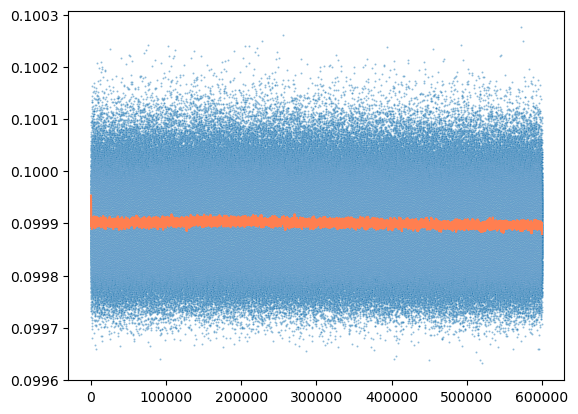

INFO     Generating sequential column names                                                                        


  0%|          | 0/33055 [00:00<?, ?it/s]

  0%|          | 40/33055 [00:00<01:23, 397.61it/s]

  0%|          | 81/33055 [00:00<01:21, 402.68it/s]

  0%|          | 122/33055 [00:00<01:21, 402.62it/s]

  0%|          | 163/33055 [00:00<01:21, 405.46it/s]

  1%|          | 204/33055 [00:00<01:20, 407.02it/s]

  1%|          | 246/33055 [00:00<01:20, 408.43it/s]

  1%|          | 287/33055 [00:00<01:20, 408.39it/s]

  1%|          | 328/33055 [00:00<01:20, 408.80it/s]

  1%|          | 370/33055 [00:00<01:19, 409.27it/s]

  1%|          | 411/33055 [00:01<01:19, 408.66it/s]

  1%|▏         | 452/33055 [00:01<01:19, 408.62it/s]

  1%|▏         | 493/33055 [00:01<01:19, 407.57it/s]

  2%|▏         | 535/33055 [00:01<01:19, 408.77it/s]

  2%|▏         | 577/33055 [00:01<01:19, 410.32it/s]

  2%|▏         | 619/33055 [00:01<01:18, 412.09it/s]

  2%|▏         | 661/33055 [00:01<01:18, 413.84it/s]

  2%|▏         | 703/33055 [00:01<01:18, 412.58it/s]

  2%|▏         | 745/33055 [00:01<01:18, 412.91it/s]

  2%|▏         | 787/33055 [00:01<01:18, 413.27it/s]

  3%|▎         | 829/33055 [00:02<01:17, 414.38it/s]

  3%|▎         | 871/33055 [00:02<01:17, 414.47it/s]

  3%|▎         | 913/33055 [00:02<01:17, 413.01it/s]

  3%|▎         | 955/33055 [00:02<01:18, 409.64it/s]

  3%|▎         | 996/33055 [00:02<01:18, 409.61it/s]

  3%|▎         | 1038/33055 [00:02<01:17, 410.64it/s]

  3%|▎         | 1080/33055 [00:02<01:17, 411.86it/s]

  3%|▎         | 1122/33055 [00:02<01:17, 412.82it/s]

  4%|▎         | 1164/33055 [00:02<01:18, 408.36it/s]

  4%|▎         | 1205/33055 [00:02<01:18, 404.09it/s]

  4%|▍         | 1246/33055 [00:03<01:19, 402.19it/s]

  4%|▍         | 1287/33055 [00:03<01:19, 401.36it/s]

  4%|▍         | 1328/33055 [00:03<01:18, 401.71it/s]

  4%|▍         | 1369/33055 [00:03<01:18, 402.66it/s]

  4%|▍         | 1410/33055 [00:03<01:18, 404.31it/s]

  4%|▍         | 1451/33055 [00:03<01:18, 405.09it/s]

  5%|▍         | 1492/33055 [00:03<01:18, 404.11it/s]

  5%|▍         | 1533/33055 [00:03<01:17, 404.51it/s]

  5%|▍         | 1574/33055 [00:03<01:17, 405.15it/s]

  5%|▍         | 1615/33055 [00:03<01:17, 406.15it/s]

  5%|▌         | 1657/33055 [00:04<01:16, 407.84it/s]

  5%|▌         | 1698/33055 [00:04<01:16, 407.98it/s]

  5%|▌         | 1740/33055 [00:04<01:16, 409.14it/s]

  5%|▌         | 1782/33055 [00:04<01:16, 410.63it/s]

  6%|▌         | 1824/33055 [00:04<01:15, 412.09it/s]

  6%|▌         | 1866/33055 [00:04<01:15, 413.23it/s]

  6%|▌         | 1908/33055 [00:04<01:16, 409.02it/s]

  6%|▌         | 1949/33055 [00:04<01:16, 406.97it/s]

  6%|▌         | 1990/33055 [00:04<01:16, 406.09it/s]

  6%|▌         | 2031/33055 [00:04<01:16, 405.85it/s]

  6%|▋         | 2072/33055 [00:05<01:16, 406.26it/s]

  6%|▋         | 2113/33055 [00:05<01:16, 405.35it/s]

  7%|▋         | 2154/33055 [00:05<01:16, 403.75it/s]

  7%|▋         | 2195/33055 [00:05<01:16, 404.00it/s]

  7%|▋         | 2236/33055 [00:05<01:16, 404.70it/s]

  7%|▋         | 2277/33055 [00:05<01:15, 405.57it/s]

  7%|▋         | 2318/33055 [00:05<01:15, 406.27it/s]

  7%|▋         | 2359/33055 [00:05<01:15, 405.90it/s]

  7%|▋         | 2400/33055 [00:05<01:15, 405.27it/s]

  7%|▋         | 2442/33055 [00:05<01:15, 406.98it/s]

  8%|▊         | 2483/33055 [00:06<01:15, 406.38it/s]

  8%|▊         | 2524/33055 [00:06<01:14, 407.26it/s]

  8%|▊         | 2565/33055 [00:06<01:14, 407.53it/s]

  8%|▊         | 2606/33055 [00:06<01:14, 407.89it/s]

  8%|▊         | 2647/33055 [00:06<01:14, 408.12it/s]

  8%|▊         | 2688/33055 [00:06<01:14, 406.88it/s]

  8%|▊         | 2729/33055 [00:06<01:14, 406.92it/s]

  8%|▊         | 2770/33055 [00:06<01:14, 406.44it/s]

  9%|▊         | 2811/33055 [00:06<01:14, 406.35it/s]

  9%|▊         | 2852/33055 [00:06<01:14, 406.31it/s]

  9%|▉         | 2893/33055 [00:07<01:14, 406.31it/s]

  9%|▉         | 2934/33055 [00:07<01:14, 406.57it/s]

  9%|▉         | 2975/33055 [00:07<01:14, 405.89it/s]

  9%|▉         | 3016/33055 [00:07<01:14, 405.30it/s]

  9%|▉         | 3057/33055 [00:07<01:13, 406.42it/s]

  9%|▉         | 3098/33055 [00:07<01:13, 406.32it/s]

  9%|▉         | 3139/33055 [00:07<01:13, 407.09it/s]

 10%|▉         | 3180/33055 [00:07<01:13, 406.94it/s]

 10%|▉         | 3221/33055 [00:07<01:13, 407.11it/s]

 10%|▉         | 3262/33055 [00:08<01:13, 407.05it/s]

 10%|▉         | 3303/33055 [00:08<01:13, 407.53it/s]

 10%|█         | 3345/33055 [00:08<01:12, 408.31it/s]

 10%|█         | 3386/33055 [00:08<01:12, 407.89it/s]

 10%|█         | 3427/33055 [00:08<01:12, 407.90it/s]

 10%|█         | 3469/33055 [00:08<01:12, 408.60it/s]

 11%|█         | 3510/33055 [00:08<01:12, 406.04it/s]

 11%|█         | 3552/33055 [00:08<01:12, 407.62it/s]

 11%|█         | 3593/33055 [00:08<01:12, 407.43it/s]

 11%|█         | 3634/33055 [00:08<01:12, 407.30it/s]

 11%|█         | 3675/33055 [00:09<01:12, 407.62it/s]

 11%|█         | 3716/33055 [00:09<01:11, 407.72it/s]

 11%|█▏        | 3757/33055 [00:09<01:11, 407.55it/s]

 11%|█▏        | 3798/33055 [00:09<01:11, 407.40it/s]

 12%|█▏        | 3840/33055 [00:09<01:11, 408.67it/s]

 12%|█▏        | 3881/33055 [00:09<01:11, 408.49it/s]

 12%|█▏        | 3922/33055 [00:09<01:11, 408.29it/s]

 12%|█▏        | 3963/33055 [00:09<01:11, 407.26it/s]

 12%|█▏        | 4004/33055 [00:09<01:11, 406.90it/s]

 12%|█▏        | 4045/33055 [00:09<01:11, 406.55it/s]

 12%|█▏        | 4086/33055 [00:10<01:11, 405.98it/s]

 12%|█▏        | 4127/33055 [00:10<01:11, 405.65it/s]

 13%|█▎        | 4168/33055 [00:10<01:11, 406.25it/s]

 13%|█▎        | 4210/33055 [00:10<01:10, 407.74it/s]

 13%|█▎        | 4251/33055 [00:10<01:10, 408.04it/s]

 13%|█▎        | 4293/33055 [00:10<01:10, 408.94it/s]

 13%|█▎        | 4335/33055 [00:10<01:10, 409.33it/s]

 13%|█▎        | 4376/33055 [00:10<01:10, 408.60it/s]

 13%|█▎        | 4418/33055 [00:10<01:09, 410.06it/s]

 13%|█▎        | 4460/33055 [00:10<01:09, 410.15it/s]

 14%|█▎        | 4502/33055 [00:11<01:09, 410.88it/s]

 14%|█▎        | 4544/33055 [00:11<01:09, 409.88it/s]

 14%|█▍        | 4586/33055 [00:11<01:09, 410.30it/s]

 14%|█▍        | 4628/33055 [00:11<01:09, 411.74it/s]

 14%|█▍        | 4670/33055 [00:11<01:09, 410.32it/s]

 14%|█▍        | 4712/33055 [00:11<01:09, 410.55it/s]

 14%|█▍        | 4754/33055 [00:11<01:08, 410.80it/s]

 15%|█▍        | 4796/33055 [00:11<01:08, 411.77it/s]

 15%|█▍        | 4838/33055 [00:11<01:08, 412.67it/s]

 15%|█▍        | 4880/33055 [00:11<01:08, 413.36it/s]

 15%|█▍        | 4922/33055 [00:12<01:07, 414.29it/s]

 15%|█▌        | 4964/33055 [00:12<01:07, 414.94it/s]

 15%|█▌        | 5006/33055 [00:12<01:07, 415.61it/s]

 15%|█▌        | 5048/33055 [00:12<01:07, 414.07it/s]

 15%|█▌        | 5090/33055 [00:12<01:07, 412.31it/s]

 16%|█▌        | 5132/33055 [00:12<01:07, 411.88it/s]

 16%|█▌        | 5174/33055 [00:12<01:07, 412.19it/s]

 16%|█▌        | 5216/33055 [00:12<01:07, 412.74it/s]

 16%|█▌        | 5258/33055 [00:12<01:07, 412.44it/s]

 16%|█▌        | 5300/33055 [00:12<01:07, 413.44it/s]

 16%|█▌        | 5342/33055 [00:13<01:07, 413.31it/s]

 16%|█▋        | 5384/33055 [00:13<01:06, 414.23it/s]

 16%|█▋        | 5426/33055 [00:13<01:06, 415.19it/s]

 17%|█▋        | 5468/33055 [00:13<01:06, 413.80it/s]

 17%|█▋        | 5510/33055 [00:13<01:06, 413.18it/s]

 17%|█▋        | 5552/33055 [00:13<01:06, 413.58it/s]

 17%|█▋        | 5594/33055 [00:13<01:06, 413.31it/s]

 17%|█▋        | 5636/33055 [00:13<01:06, 413.66it/s]

 17%|█▋        | 5678/33055 [00:13<01:06, 412.29it/s]

 17%|█▋        | 5720/33055 [00:13<01:06, 411.30it/s]

 17%|█▋        | 5762/33055 [00:14<01:06, 411.09it/s]

 18%|█▊        | 5804/33055 [00:14<01:06, 411.41it/s]

 18%|█▊        | 5846/33055 [00:14<01:06, 411.99it/s]

 18%|█▊        | 5888/33055 [00:14<01:05, 412.26it/s]

 18%|█▊        | 5930/33055 [00:14<01:05, 412.59it/s]

 18%|█▊        | 5972/33055 [00:14<01:05, 414.08it/s]

 18%|█▊        | 6014/33055 [00:14<01:05, 412.36it/s]

 18%|█▊        | 6056/33055 [00:14<01:05, 411.40it/s]

 18%|█▊        | 6098/33055 [00:14<01:05, 411.36it/s]

 19%|█▊        | 6140/33055 [00:15<01:05, 411.88it/s]

 19%|█▊        | 6182/33055 [00:15<01:05, 411.96it/s]

 19%|█▉        | 6224/33055 [00:15<01:04, 413.05it/s]

 19%|█▉        | 6266/33055 [00:15<01:05, 409.99it/s]

 19%|█▉        | 6308/33055 [00:15<01:05, 406.23it/s]

 19%|█▉        | 6349/33055 [00:15<01:05, 404.73it/s]

 19%|█▉        | 6390/33055 [00:15<01:06, 403.67it/s]

 19%|█▉        | 6431/33055 [00:15<01:05, 404.45it/s]

 20%|█▉        | 6473/33055 [00:15<01:05, 406.47it/s]

 20%|█▉        | 6515/33055 [00:15<01:04, 408.80it/s]

 20%|█▉        | 6556/33055 [00:16<01:04, 408.16it/s]

 20%|█▉        | 6597/33055 [00:16<01:04, 407.75it/s]

 20%|██        | 6638/33055 [00:16<01:04, 407.96it/s]

 20%|██        | 6680/33055 [00:16<01:04, 410.17it/s]

 20%|██        | 6722/33055 [00:16<01:04, 408.81it/s]

 20%|██        | 6763/33055 [00:16<01:04, 408.55it/s]

 21%|██        | 6805/33055 [00:16<01:04, 409.16it/s]

 21%|██        | 6847/33055 [00:16<01:03, 410.53it/s]

 21%|██        | 6889/33055 [00:16<01:04, 408.17it/s]

 21%|██        | 6930/33055 [00:16<01:04, 407.85it/s]

 21%|██        | 6972/33055 [00:17<01:03, 408.54it/s]

 21%|██        | 7013/33055 [00:17<01:03, 408.71it/s]

 21%|██▏       | 7055/33055 [00:17<01:03, 409.58it/s]

 21%|██▏       | 7097/33055 [00:17<01:03, 410.26it/s]

 22%|██▏       | 7139/33055 [00:17<01:03, 411.32it/s]

 22%|██▏       | 7181/33055 [00:17<01:02, 412.19it/s]

 22%|██▏       | 7223/33055 [00:17<01:02, 412.11it/s]

 22%|██▏       | 7265/33055 [00:17<01:02, 410.89it/s]

 22%|██▏       | 7307/33055 [00:17<01:02, 410.85it/s]

 22%|██▏       | 7349/33055 [00:17<01:02, 411.63it/s]

 22%|██▏       | 7391/33055 [00:18<01:02, 409.90it/s]

 22%|██▏       | 7432/33055 [00:18<01:02, 409.68it/s]

 23%|██▎       | 7474/33055 [00:18<01:02, 409.93it/s]

 23%|██▎       | 7516/33055 [00:18<01:02, 410.24it/s]

 23%|██▎       | 7558/33055 [00:18<01:01, 411.25it/s]

 23%|██▎       | 7600/33055 [00:18<01:01, 412.16it/s]

 23%|██▎       | 7642/33055 [00:18<01:01, 411.64it/s]

 23%|██▎       | 7684/33055 [00:18<01:01, 410.71it/s]

 23%|██▎       | 7726/33055 [00:18<01:01, 410.70it/s]

 24%|██▎       | 7768/33055 [00:18<01:01, 411.26it/s]

 24%|██▎       | 7810/33055 [00:19<01:01, 411.94it/s]

 24%|██▍       | 7852/33055 [00:19<01:01, 412.75it/s]

 24%|██▍       | 7894/33055 [00:19<01:00, 413.53it/s]

 24%|██▍       | 7936/33055 [00:19<01:00, 414.15it/s]

 24%|██▍       | 7978/33055 [00:19<01:00, 414.89it/s]

 24%|██▍       | 8020/33055 [00:19<01:00, 415.48it/s]

 24%|██▍       | 8062/33055 [00:19<01:00, 412.10it/s]

 25%|██▍       | 8104/33055 [00:19<01:00, 412.00it/s]

 25%|██▍       | 8146/33055 [00:19<01:00, 408.81it/s]

 25%|██▍       | 8187/33055 [00:20<01:01, 407.60it/s]

 25%|██▍       | 8228/33055 [00:20<01:00, 407.77it/s]

 25%|██▌       | 8270/33055 [00:20<01:00, 408.96it/s]

 25%|██▌       | 8311/33055 [00:20<01:01, 405.60it/s]

 25%|██▌       | 8352/33055 [00:20<01:00, 405.75it/s]

 25%|██▌       | 8393/33055 [00:20<01:00, 406.41it/s]

 26%|██▌       | 8434/33055 [00:20<01:00, 407.30it/s]

 26%|██▌       | 8475/33055 [00:20<01:00, 406.97it/s]

 26%|██▌       | 8516/33055 [00:20<01:00, 404.59it/s]

 26%|██▌       | 8557/33055 [00:20<01:00, 404.57it/s]

 26%|██▌       | 8598/33055 [00:21<01:00, 405.95it/s]

 26%|██▌       | 8639/33055 [00:21<01:00, 404.16it/s]

 26%|██▋       | 8680/33055 [00:21<01:00, 403.97it/s]

 26%|██▋       | 8721/33055 [00:21<01:00, 404.69it/s]

 27%|██▋       | 8762/33055 [00:21<00:59, 405.96it/s]

 27%|██▋       | 8804/33055 [00:21<00:59, 407.35it/s]

 27%|██▋       | 8845/33055 [00:21<00:59, 406.43it/s]

 27%|██▋       | 8886/33055 [00:21<00:59, 403.99it/s]

 27%|██▋       | 8927/33055 [00:21<00:59, 403.36it/s]

 27%|██▋       | 8968/33055 [00:21<00:59, 403.67it/s]

 27%|██▋       | 9009/33055 [00:22<00:59, 404.43it/s]

 27%|██▋       | 9050/33055 [00:22<00:59, 405.46it/s]

 28%|██▊       | 9091/33055 [00:22<00:59, 405.30it/s]

 28%|██▊       | 9132/33055 [00:22<00:59, 403.41it/s]

 28%|██▊       | 9173/33055 [00:22<00:59, 404.23it/s]

 28%|██▊       | 9215/33055 [00:22<00:58, 406.24it/s]

 28%|██▊       | 9257/33055 [00:22<00:58, 408.32it/s]

 28%|██▊       | 9299/33055 [00:22<00:57, 410.09it/s]

 28%|██▊       | 9341/33055 [00:22<00:57, 411.75it/s]

 28%|██▊       | 9383/33055 [00:22<00:57, 413.03it/s]

 29%|██▊       | 9425/33055 [00:23<00:57, 411.78it/s]

 29%|██▊       | 9467/33055 [00:23<00:57, 411.00it/s]

 29%|██▉       | 9509/33055 [00:23<00:57, 411.60it/s]

 29%|██▉       | 9551/33055 [00:23<00:56, 412.73it/s]

 29%|██▉       | 9593/33055 [00:23<00:57, 410.13it/s]

 29%|██▉       | 9635/33055 [00:23<00:57, 407.42it/s]

 29%|██▉       | 9676/33055 [00:23<00:57, 406.30it/s]

 29%|██▉       | 9717/33055 [00:23<00:57, 406.10it/s]

 30%|██▉       | 9758/33055 [00:23<00:57, 406.60it/s]

 30%|██▉       | 9799/33055 [00:23<00:57, 407.43it/s]

 30%|██▉       | 9841/33055 [00:24<00:56, 408.49it/s]

 30%|██▉       | 9882/33055 [00:24<00:56, 408.64it/s]

 30%|███       | 9923/33055 [00:24<00:57, 405.82it/s]

 30%|███       | 9964/33055 [00:24<00:56, 405.53it/s]

 30%|███       | 10006/33055 [00:24<00:56, 407.09it/s]

 30%|███       | 10048/33055 [00:24<00:56, 409.00it/s]

 31%|███       | 10090/33055 [00:24<00:55, 411.13it/s]

 31%|███       | 10132/33055 [00:24<00:55, 409.59it/s]

 31%|███       | 10173/33055 [00:24<00:55, 409.49it/s]

 31%|███       | 10215/33055 [00:24<00:55, 409.74it/s]

 31%|███       | 10257/33055 [00:25<00:55, 411.28it/s]

 31%|███       | 10299/33055 [00:25<00:55, 410.05it/s]

 31%|███▏      | 10341/33055 [00:25<00:55, 408.41it/s]

 31%|███▏      | 10382/33055 [00:25<00:55, 408.45it/s]

 32%|███▏      | 10424/33055 [00:25<00:55, 409.84it/s]

 32%|███▏      | 10465/33055 [00:25<00:55, 408.08it/s]

 32%|███▏      | 10506/33055 [00:25<00:55, 406.23it/s]

 32%|███▏      | 10547/33055 [00:25<00:55, 405.72it/s]

 32%|███▏      | 10588/33055 [00:25<00:55, 406.44it/s]

 32%|███▏      | 10629/33055 [00:26<00:55, 407.36it/s]

 32%|███▏      | 10670/33055 [00:26<00:54, 407.55it/s]

 32%|███▏      | 10712/33055 [00:26<00:54, 408.84it/s]

 33%|███▎      | 10754/33055 [00:26<00:54, 410.35it/s]

 33%|███▎      | 10796/33055 [00:26<00:54, 410.68it/s]

 33%|███▎      | 10838/33055 [00:26<00:54, 409.36it/s]

 33%|███▎      | 10879/33055 [00:26<00:54, 409.43it/s]

 33%|███▎      | 10921/33055 [00:26<00:53, 410.14it/s]

 33%|███▎      | 10963/33055 [00:26<00:53, 411.17it/s]

 33%|███▎      | 11005/33055 [00:26<00:53, 409.63it/s]

 33%|███▎      | 11046/33055 [00:27<00:54, 406.02it/s]

 34%|███▎      | 11087/33055 [00:27<00:54, 404.43it/s]

 34%|███▎      | 11128/33055 [00:27<00:54, 403.74it/s]

 34%|███▍      | 11169/33055 [00:27<00:54, 405.04it/s]

 34%|███▍      | 11210/33055 [00:27<00:54, 403.30it/s]

 34%|███▍      | 11251/33055 [00:27<00:54, 402.82it/s]

 34%|███▍      | 11292/33055 [00:27<00:53, 403.22it/s]

 34%|███▍      | 11333/33055 [00:27<00:53, 404.23it/s]

 34%|███▍      | 11374/33055 [00:27<00:53, 405.93it/s]

 35%|███▍      | 11416/33055 [00:27<00:53, 407.89it/s]

 35%|███▍      | 11457/33055 [00:28<00:53, 406.84it/s]

 35%|███▍      | 11498/33055 [00:28<00:52, 407.53it/s]

 35%|███▍      | 11540/33055 [00:28<00:52, 409.21it/s]

 35%|███▌      | 11581/33055 [00:28<00:52, 408.53it/s]

 35%|███▌      | 11622/33055 [00:28<00:52, 408.61it/s]

 35%|███▌      | 11664/33055 [00:28<00:52, 409.23it/s]

 35%|███▌      | 11706/33055 [00:28<00:52, 410.28it/s]

 36%|███▌      | 11748/33055 [00:28<00:51, 411.29it/s]

 36%|███▌      | 11790/33055 [00:28<00:51, 410.17it/s]

 36%|███▌      | 11832/33055 [00:28<00:52, 407.53it/s]

 36%|███▌      | 11873/33055 [00:29<00:51, 407.78it/s]

 36%|███▌      | 11915/33055 [00:29<00:51, 408.49it/s]

 36%|███▌      | 11957/33055 [00:29<00:51, 409.33it/s]

 36%|███▋      | 11999/33055 [00:29<00:51, 410.13it/s]

 36%|███▋      | 12041/33055 [00:29<00:51, 410.29it/s]

 37%|███▋      | 12083/33055 [00:29<00:51, 408.66it/s]

 37%|███▋      | 12125/33055 [00:29<00:51, 410.17it/s]

 37%|███▋      | 12167/33055 [00:29<00:51, 408.93it/s]

 37%|███▋      | 12208/33055 [00:29<00:50, 408.97it/s]

 37%|███▋      | 12250/33055 [00:29<00:50, 410.78it/s]

 37%|███▋      | 12292/33055 [00:30<00:50, 408.83it/s]

 37%|███▋      | 12333/33055 [00:30<00:51, 405.41it/s]

 37%|███▋      | 12374/33055 [00:30<00:51, 404.37it/s]

 38%|███▊      | 12415/33055 [00:30<00:50, 405.21it/s]

 38%|███▊      | 12457/33055 [00:30<00:50, 406.78it/s]

 38%|███▊      | 12499/33055 [00:30<00:50, 408.22it/s]

 38%|███▊      | 12541/33055 [00:30<00:50, 409.44it/s]

 38%|███▊      | 12583/33055 [00:30<00:49, 410.68it/s]

 38%|███▊      | 12625/33055 [00:30<00:49, 409.06it/s]

 38%|███▊      | 12666/33055 [00:30<00:49, 409.17it/s]

 38%|███▊      | 12707/33055 [00:31<00:49, 409.34it/s]

 39%|███▊      | 12748/33055 [00:31<00:49, 406.71it/s]

 39%|███▊      | 12789/33055 [00:31<00:49, 407.37it/s]

 39%|███▉      | 12830/33055 [00:31<00:49, 405.66it/s]

 39%|███▉      | 12871/33055 [00:31<00:49, 406.77it/s]

 39%|███▉      | 12913/33055 [00:31<00:49, 408.91it/s]

 39%|███▉      | 12954/33055 [00:31<00:49, 407.50it/s]

 39%|███▉      | 12995/33055 [00:31<00:49, 407.63it/s]

 39%|███▉      | 13037/33055 [00:31<00:48, 409.06it/s]

 40%|███▉      | 13079/33055 [00:32<00:48, 410.87it/s]

 40%|███▉      | 13121/33055 [00:32<00:48, 410.05it/s]

 40%|███▉      | 13163/33055 [00:32<00:48, 409.60it/s]

 40%|███▉      | 13204/33055 [00:32<00:48, 407.15it/s]

 40%|████      | 13245/33055 [00:32<00:48, 405.78it/s]

 40%|████      | 13286/33055 [00:32<00:48, 405.59it/s]

 40%|████      | 13327/33055 [00:32<00:48, 405.97it/s]

 40%|████      | 13368/33055 [00:32<00:48, 406.64it/s]

 41%|████      | 13409/33055 [00:32<00:48, 405.92it/s]

 41%|████      | 13450/33055 [00:32<00:48, 406.27it/s]

 41%|████      | 13491/33055 [00:33<00:48, 406.89it/s]

 41%|████      | 13532/33055 [00:33<00:47, 407.59it/s]

 41%|████      | 13574/33055 [00:33<00:47, 409.01it/s]

 41%|████      | 13616/33055 [00:33<00:47, 409.71it/s]

 41%|████▏     | 13658/33055 [00:33<00:47, 410.93it/s]

 41%|████▏     | 13700/33055 [00:33<00:46, 411.99it/s]

 42%|████▏     | 13742/33055 [00:33<00:46, 412.64it/s]

 42%|████▏     | 13784/33055 [00:33<00:46, 413.72it/s]

 42%|████▏     | 13826/33055 [00:33<00:46, 410.10it/s]

 42%|████▏     | 13868/33055 [00:33<00:46, 408.31it/s]

 42%|████▏     | 13909/33055 [00:34<00:46, 407.53it/s]

 42%|████▏     | 13950/33055 [00:34<00:46, 407.47it/s]

 42%|████▏     | 13991/33055 [00:34<00:46, 407.84it/s]

 42%|████▏     | 14032/33055 [00:34<00:46, 408.40it/s]

 43%|████▎     | 14074/33055 [00:34<00:46, 408.90it/s]

 43%|████▎     | 14116/33055 [00:34<00:46, 409.59it/s]

 43%|████▎     | 14158/33055 [00:34<00:46, 410.37it/s]

 43%|████▎     | 14200/33055 [00:34<00:45, 411.14it/s]

 43%|████▎     | 14242/33055 [00:34<00:45, 411.09it/s]

 43%|████▎     | 14284/33055 [00:34<00:45, 411.68it/s]

 43%|████▎     | 14326/33055 [00:35<00:45, 413.06it/s]

 43%|████▎     | 14368/33055 [00:35<00:45, 412.01it/s]

 44%|████▎     | 14410/33055 [00:35<00:45, 411.54it/s]

 44%|████▎     | 14452/33055 [00:35<00:45, 412.18it/s]

 44%|████▍     | 14494/33055 [00:35<00:44, 413.15it/s]

 44%|████▍     | 14536/33055 [00:35<00:44, 414.24it/s]

 44%|████▍     | 14578/33055 [00:35<00:44, 412.23it/s]

 44%|████▍     | 14620/33055 [00:35<00:44, 412.07it/s]

 44%|████▍     | 14662/33055 [00:35<00:44, 412.31it/s]

 44%|████▍     | 14704/33055 [00:35<00:44, 413.06it/s]

 45%|████▍     | 14746/33055 [00:36<00:44, 414.01it/s]

 45%|████▍     | 14788/33055 [00:36<00:44, 413.29it/s]

 45%|████▍     | 14830/33055 [00:36<00:44, 413.71it/s]

 45%|████▍     | 14872/33055 [00:36<00:43, 414.60it/s]

 45%|████▌     | 14914/33055 [00:36<00:44, 412.16it/s]

 45%|████▌     | 14956/33055 [00:36<00:44, 409.55it/s]

 45%|████▌     | 14997/33055 [00:36<00:44, 408.59it/s]

 45%|████▌     | 15038/33055 [00:36<00:44, 408.35it/s]

 46%|████▌     | 15079/33055 [00:36<00:44, 408.52it/s]

 46%|████▌     | 15121/33055 [00:36<00:43, 409.07it/s]

 46%|████▌     | 15163/33055 [00:37<00:43, 409.82it/s]

 46%|████▌     | 15205/33055 [00:37<00:43, 410.29it/s]

 46%|████▌     | 15247/33055 [00:37<00:43, 411.69it/s]

 46%|████▋     | 15289/33055 [00:37<00:43, 410.99it/s]

 46%|████▋     | 15331/33055 [00:37<00:43, 409.99it/s]

 47%|████▋     | 15373/33055 [00:37<00:42, 411.47it/s]

 47%|████▋     | 15415/33055 [00:37<00:43, 410.06it/s]

 47%|████▋     | 15457/33055 [00:37<00:43, 407.33it/s]

 47%|████▋     | 15498/33055 [00:37<00:43, 407.37it/s]

 47%|████▋     | 15540/33055 [00:38<00:42, 408.37it/s]

 47%|████▋     | 15582/33055 [00:38<00:42, 409.16it/s]

 47%|████▋     | 15623/33055 [00:38<00:42, 408.78it/s]

 47%|████▋     | 15665/33055 [00:38<00:42, 409.66it/s]

 48%|████▊     | 15707/33055 [00:38<00:42, 410.54it/s]

 48%|████▊     | 15749/33055 [00:38<00:42, 410.82it/s]

 48%|████▊     | 15791/33055 [00:38<00:42, 409.59it/s]

 48%|████▊     | 15833/33055 [00:38<00:42, 410.04it/s]

 48%|████▊     | 15875/33055 [00:38<00:41, 411.31it/s]

 48%|████▊     | 15917/33055 [00:38<00:41, 412.07it/s]

 48%|████▊     | 15959/33055 [00:39<00:41, 411.32it/s]

 48%|████▊     | 16001/33055 [00:39<00:41, 412.12it/s]

 49%|████▊     | 16043/33055 [00:39<00:41, 411.64it/s]

 49%|████▊     | 16085/33055 [00:39<00:41, 411.15it/s]

 49%|████▉     | 16127/33055 [00:39<00:41, 412.31it/s]

 49%|████▉     | 16169/33055 [00:39<00:41, 410.54it/s]

 49%|████▉     | 16211/33055 [00:39<00:40, 411.69it/s]

 49%|████▉     | 16253/33055 [00:39<00:41, 409.79it/s]

 49%|████▉     | 16294/33055 [00:39<00:40, 409.59it/s]

 49%|████▉     | 16336/33055 [00:39<00:40, 411.09it/s]

 50%|████▉     | 16378/33055 [00:40<00:40, 409.52it/s]

 50%|████▉     | 16419/33055 [00:40<00:40, 409.46it/s]

 50%|████▉     | 16460/33055 [00:40<00:40, 408.66it/s]

 50%|████▉     | 16501/33055 [00:40<00:40, 408.55it/s]

 50%|█████     | 16542/33055 [00:40<00:40, 408.61it/s]

 50%|█████     | 16583/33055 [00:40<00:40, 407.92it/s]

 50%|█████     | 16624/33055 [00:40<00:40, 408.45it/s]

 50%|█████     | 16666/33055 [00:40<00:39, 409.80it/s]

 51%|█████     | 16708/33055 [00:40<00:39, 410.92it/s]

 51%|█████     | 16750/33055 [00:40<00:39, 412.61it/s]

 51%|█████     | 16792/33055 [00:41<00:39, 411.01it/s]

 51%|█████     | 16834/33055 [00:41<00:39, 411.64it/s]

 51%|█████     | 16876/33055 [00:41<00:39, 412.02it/s]

 51%|█████     | 16918/33055 [00:41<00:39, 412.34it/s]

 51%|█████▏    | 16960/33055 [00:41<00:38, 413.08it/s]

 51%|█████▏    | 17002/33055 [00:41<00:38, 413.26it/s]

 52%|█████▏    | 17044/33055 [00:41<00:38, 413.48it/s]

 52%|█████▏    | 17086/33055 [00:41<00:38, 413.65it/s]

 52%|█████▏    | 17128/33055 [00:41<00:38, 410.42it/s]

 52%|█████▏    | 17170/33055 [00:41<00:38, 411.07it/s]

 52%|█████▏    | 17212/33055 [00:42<00:38, 411.62it/s]

 52%|█████▏    | 17254/33055 [00:42<00:38, 412.58it/s]

 52%|█████▏    | 17296/33055 [00:42<00:38, 412.44it/s]

 52%|█████▏    | 17338/33055 [00:42<00:38, 411.07it/s]

 53%|█████▎    | 17380/33055 [00:42<00:38, 411.53it/s]

 53%|█████▎    | 17422/33055 [00:42<00:37, 412.20it/s]

 53%|█████▎    | 17464/33055 [00:42<00:38, 409.70it/s]

 53%|█████▎    | 17505/33055 [00:42<00:38, 408.94it/s]

 53%|█████▎    | 17546/33055 [00:42<00:37, 409.22it/s]

 53%|█████▎    | 17588/33055 [00:42<00:37, 410.01it/s]

 53%|█████▎    | 17630/33055 [00:43<00:37, 410.85it/s]

 53%|█████▎    | 17672/33055 [00:43<00:37, 411.74it/s]

 54%|█████▎    | 17714/33055 [00:43<00:37, 410.95it/s]

 54%|█████▎    | 17756/33055 [00:43<00:37, 409.05it/s]

 54%|█████▍    | 17797/33055 [00:43<00:37, 408.66it/s]

 54%|█████▍    | 17839/33055 [00:43<00:37, 409.43it/s]

 54%|█████▍    | 17881/33055 [00:43<00:36, 410.29it/s]

 54%|█████▍    | 17923/33055 [00:43<00:36, 409.13it/s]

 54%|█████▍    | 17964/33055 [00:43<00:36, 409.13it/s]

 54%|█████▍    | 18005/33055 [00:44<00:36, 407.58it/s]

 55%|█████▍    | 18046/33055 [00:44<00:36, 407.68it/s]

 55%|█████▍    | 18087/33055 [00:44<00:36, 408.08it/s]

 55%|█████▍    | 18128/33055 [00:44<00:36, 407.70it/s]

 55%|█████▍    | 18169/33055 [00:44<00:36, 406.62it/s]

 55%|█████▌    | 18210/33055 [00:44<00:36, 407.23it/s]

 55%|█████▌    | 18251/33055 [00:44<00:36, 405.24it/s]

 55%|█████▌    | 18292/33055 [00:44<00:36, 404.19it/s]

 55%|█████▌    | 18333/33055 [00:44<00:36, 404.95it/s]

 56%|█████▌    | 18374/33055 [00:44<00:36, 406.32it/s]

 56%|█████▌    | 18415/33055 [00:45<00:36, 405.51it/s]

 56%|█████▌    | 18456/33055 [00:45<00:36, 404.50it/s]

 56%|█████▌    | 18497/33055 [00:45<00:36, 404.06it/s]

 56%|█████▌    | 18538/33055 [00:45<00:35, 404.45it/s]

 56%|█████▌    | 18579/33055 [00:45<00:35, 405.25it/s]

 56%|█████▋    | 18620/33055 [00:45<00:35, 406.40it/s]

 56%|█████▋    | 18662/33055 [00:45<00:35, 407.82it/s]

 57%|█████▋    | 18704/33055 [00:45<00:35, 408.40it/s]

 57%|█████▋    | 18745/33055 [00:45<00:35, 406.06it/s]

 57%|█████▋    | 18786/33055 [00:45<00:35, 405.85it/s]

 57%|█████▋    | 18827/33055 [00:46<00:35, 406.35it/s]

 57%|█████▋    | 18868/33055 [00:46<00:34, 406.82it/s]

 57%|█████▋    | 18910/33055 [00:46<00:34, 408.08it/s]

 57%|█████▋    | 18952/33055 [00:46<00:34, 409.67it/s]

 57%|█████▋    | 18993/33055 [00:46<00:34, 409.37it/s]

 58%|█████▊    | 19034/33055 [00:46<00:34, 407.09it/s]

 58%|█████▊    | 19075/33055 [00:46<00:34, 406.35it/s]

 58%|█████▊    | 19117/33055 [00:46<00:34, 407.69it/s]

 58%|█████▊    | 19159/33055 [00:46<00:33, 409.49it/s]

 58%|█████▊    | 19201/33055 [00:46<00:33, 410.92it/s]

 58%|█████▊    | 19243/33055 [00:47<00:33, 409.80it/s]

 58%|█████▊    | 19284/33055 [00:47<00:33, 409.78it/s]

 58%|█████▊    | 19326/33055 [00:47<00:33, 410.66it/s]

 59%|█████▊    | 19368/33055 [00:47<00:33, 407.98it/s]

 59%|█████▊    | 19409/33055 [00:47<00:33, 408.47it/s]

 59%|█████▉    | 19451/33055 [00:47<00:33, 409.91it/s]

 59%|█████▉    | 19493/33055 [00:47<00:32, 411.11it/s]

 59%|█████▉    | 19535/33055 [00:47<00:32, 412.38it/s]

 59%|█████▉    | 19577/33055 [00:47<00:32, 409.38it/s]

 59%|█████▉    | 19618/33055 [00:47<00:32, 409.23it/s]

 59%|█████▉    | 19660/33055 [00:48<00:32, 409.78it/s]

 60%|█████▉    | 19702/33055 [00:48<00:32, 410.95it/s]

 60%|█████▉    | 19744/33055 [00:48<00:32, 410.75it/s]

 60%|█████▉    | 19786/33055 [00:48<00:32, 411.13it/s]

 60%|█████▉    | 19828/33055 [00:48<00:32, 412.07it/s]

 60%|██████    | 19870/33055 [00:48<00:31, 413.02it/s]

 60%|██████    | 19912/33055 [00:48<00:31, 410.98it/s]

 60%|██████    | 19954/33055 [00:48<00:31, 410.86it/s]

 60%|██████    | 19996/33055 [00:48<00:31, 411.50it/s]

 61%|██████    | 20038/33055 [00:48<00:31, 412.25it/s]

 61%|██████    | 20080/33055 [00:49<00:31, 412.34it/s]

 61%|██████    | 20122/33055 [00:49<00:31, 412.36it/s]

 61%|██████    | 20164/33055 [00:49<00:31, 410.20it/s]

 61%|██████    | 20206/33055 [00:49<00:31, 410.35it/s]

 61%|██████▏   | 20248/33055 [00:49<00:31, 410.09it/s]

 61%|██████▏   | 20290/33055 [00:49<00:31, 410.49it/s]

 62%|██████▏   | 20332/33055 [00:49<00:30, 411.79it/s]

 62%|██████▏   | 20374/33055 [00:49<00:30, 412.64it/s]

 62%|██████▏   | 20416/33055 [00:49<00:30, 411.33it/s]

 62%|██████▏   | 20458/33055 [00:50<00:30, 411.84it/s]

 62%|██████▏   | 20500/33055 [00:50<00:30, 412.77it/s]

 62%|██████▏   | 20542/33055 [00:50<00:30, 413.38it/s]

 62%|██████▏   | 20584/33055 [00:50<00:30, 414.09it/s]

 62%|██████▏   | 20626/33055 [00:50<00:30, 411.64it/s]

 63%|██████▎   | 20668/33055 [00:50<00:30, 409.52it/s]

 63%|██████▎   | 20709/33055 [00:50<00:30, 408.86it/s]

 63%|██████▎   | 20750/33055 [00:50<00:30, 408.82it/s]

 63%|██████▎   | 20792/33055 [00:50<00:29, 409.35it/s]

 63%|██████▎   | 20834/33055 [00:50<00:29, 410.45it/s]

 63%|██████▎   | 20876/33055 [00:51<00:29, 410.97it/s]

 63%|██████▎   | 20918/33055 [00:51<00:29, 411.62it/s]

 63%|██████▎   | 20960/33055 [00:51<00:29, 412.55it/s]

 64%|██████▎   | 21002/33055 [00:51<00:29, 411.82it/s]

 64%|██████▎   | 21044/33055 [00:51<00:29, 412.80it/s]

 64%|██████▍   | 21086/33055 [00:51<00:29, 412.54it/s]

 64%|██████▍   | 21128/33055 [00:51<00:28, 413.08it/s]

 64%|██████▍   | 21170/33055 [00:51<00:28, 414.36it/s]

 64%|██████▍   | 21212/33055 [00:51<00:28, 413.61it/s]

 64%|██████▍   | 21254/33055 [00:51<00:28, 414.15it/s]

 64%|██████▍   | 21296/33055 [00:52<00:28, 414.12it/s]

 65%|██████▍   | 21338/33055 [00:52<00:28, 412.55it/s]

 65%|██████▍   | 21380/33055 [00:52<00:28, 411.42it/s]

 65%|██████▍   | 21422/33055 [00:52<00:28, 411.98it/s]

 65%|██████▍   | 21464/33055 [00:52<00:28, 412.44it/s]

 65%|██████▌   | 21506/33055 [00:52<00:28, 409.16it/s]

 65%|██████▌   | 21547/33055 [00:52<00:28, 407.24it/s]

 65%|██████▌   | 21588/33055 [00:52<00:28, 407.76it/s]

 65%|██████▌   | 21630/33055 [00:52<00:27, 409.27it/s]

 66%|██████▌   | 21671/33055 [00:52<00:28, 406.45it/s]

 66%|██████▌   | 21712/33055 [00:53<00:27, 406.52it/s]

 66%|██████▌   | 21753/33055 [00:53<00:27, 406.93it/s]

 66%|██████▌   | 21795/33055 [00:53<00:27, 408.90it/s]

 66%|██████▌   | 21837/33055 [00:53<00:27, 409.50it/s]

 66%|██████▌   | 21878/33055 [00:53<00:27, 407.51it/s]

 66%|██████▋   | 21920/33055 [00:53<00:27, 409.33it/s]

 66%|██████▋   | 21962/33055 [00:53<00:26, 411.29it/s]

 67%|██████▋   | 22004/33055 [00:53<00:26, 412.79it/s]

 67%|██████▋   | 22046/33055 [00:53<00:26, 411.04it/s]

 67%|██████▋   | 22088/33055 [00:53<00:26, 410.23it/s]

 67%|██████▋   | 22130/33055 [00:54<00:26, 410.26it/s]

 67%|██████▋   | 22172/33055 [00:54<00:26, 411.45it/s]

 67%|██████▋   | 22214/33055 [00:54<00:26, 412.64it/s]

 67%|██████▋   | 22256/33055 [00:54<00:26, 408.47it/s]

 67%|██████▋   | 22297/33055 [00:54<00:26, 407.63it/s]

 68%|██████▊   | 22339/33055 [00:54<00:26, 408.41it/s]

 68%|██████▊   | 22381/33055 [00:54<00:26, 409.62it/s]

 68%|██████▊   | 22423/33055 [00:54<00:25, 411.01it/s]

 68%|██████▊   | 22465/33055 [00:54<00:25, 410.45it/s]

 68%|██████▊   | 22507/33055 [00:55<00:25, 406.04it/s]

 68%|██████▊   | 22548/33055 [00:55<00:25, 406.49it/s]

 68%|██████▊   | 22590/33055 [00:55<00:25, 407.95it/s]

 68%|██████▊   | 22631/33055 [00:55<00:25, 407.91it/s]

 69%|██████▊   | 22673/33055 [00:55<00:25, 409.16it/s]

 69%|██████▊   | 22715/33055 [00:55<00:25, 411.15it/s]

 69%|██████▉   | 22757/33055 [00:55<00:25, 405.76it/s]

 69%|██████▉   | 22798/33055 [00:55<00:25, 404.60it/s]

 69%|██████▉   | 22839/33055 [00:55<00:25, 404.47it/s]

 69%|██████▉   | 22880/33055 [00:55<00:25, 404.86it/s]

 69%|██████▉   | 22921/33055 [00:56<00:24, 405.81it/s]

 69%|██████▉   | 22962/33055 [00:56<00:24, 406.86it/s]

 70%|██████▉   | 23003/33055 [00:56<00:24, 406.34it/s]

 70%|██████▉   | 23044/33055 [00:56<00:24, 407.18it/s]

 70%|██████▉   | 23086/33055 [00:56<00:24, 408.79it/s]

 70%|██████▉   | 23128/33055 [00:56<00:24, 410.47it/s]

 70%|███████   | 23170/33055 [00:56<00:24, 406.78it/s]

 70%|███████   | 23211/33055 [00:56<00:24, 405.14it/s]

 70%|███████   | 23252/33055 [00:56<00:24, 406.05it/s]

 70%|███████   | 23293/33055 [00:56<00:23, 407.16it/s]

 71%|███████   | 23335/33055 [00:57<00:23, 408.84it/s]

 71%|███████   | 23377/33055 [00:57<00:23, 410.33it/s]

 71%|███████   | 23419/33055 [00:57<00:23, 412.00it/s]

 71%|███████   | 23461/33055 [00:57<00:23, 406.97it/s]

 71%|███████   | 23502/33055 [00:57<00:23, 405.54it/s]

 71%|███████   | 23543/33055 [00:57<00:23, 404.86it/s]

 71%|███████▏  | 23584/33055 [00:57<00:23, 405.83it/s]

 71%|███████▏  | 23625/33055 [00:57<00:23, 406.69it/s]

 72%|███████▏  | 23666/33055 [00:57<00:23, 407.61it/s]

 72%|███████▏  | 23708/33055 [00:57<00:22, 408.63it/s]

 72%|███████▏  | 23749/33055 [00:58<00:22, 406.85it/s]

 72%|███████▏  | 23790/33055 [00:58<00:22, 406.60it/s]

 72%|███████▏  | 23832/33055 [00:58<00:22, 407.93it/s]

 72%|███████▏  | 23873/33055 [00:58<00:22, 408.06it/s]

 72%|███████▏  | 23914/33055 [00:58<00:22, 408.25it/s]

 72%|███████▏  | 23956/33055 [00:58<00:22, 409.33it/s]

 73%|███████▎  | 23998/33055 [00:58<00:22, 410.24it/s]

 73%|███████▎  | 24040/33055 [00:58<00:21, 411.58it/s]

 73%|███████▎  | 24082/33055 [00:58<00:21, 409.66it/s]

 73%|███████▎  | 24123/33055 [00:58<00:21, 406.48it/s]

 73%|███████▎  | 24164/33055 [00:59<00:21, 405.32it/s]

 73%|███████▎  | 24205/33055 [00:59<00:21, 405.81it/s]

 73%|███████▎  | 24246/33055 [00:59<00:21, 406.69it/s]

 73%|███████▎  | 24288/33055 [00:59<00:21, 408.06it/s]

 74%|███████▎  | 24329/33055 [00:59<00:21, 406.07it/s]

 74%|███████▎  | 24370/33055 [00:59<00:21, 403.90it/s]

 74%|███████▍  | 24411/33055 [00:59<00:21, 403.22it/s]

 74%|███████▍  | 24452/33055 [00:59<00:21, 404.09it/s]

 74%|███████▍  | 24493/33055 [00:59<00:21, 405.82it/s]

 74%|███████▍  | 24534/33055 [00:59<00:21, 403.58it/s]

 74%|███████▍  | 24575/33055 [01:00<00:20, 403.97it/s]

 74%|███████▍  | 24616/33055 [01:00<00:20, 404.71it/s]

 75%|███████▍  | 24657/33055 [01:00<00:20, 406.23it/s]

 75%|███████▍  | 24699/33055 [01:00<00:20, 407.76it/s]

 75%|███████▍  | 24741/33055 [01:00<00:20, 409.11it/s]

 75%|███████▍  | 24783/33055 [01:00<00:20, 409.43it/s]

 75%|███████▌  | 24824/33055 [01:00<00:20, 408.71it/s]

 75%|███████▌  | 24866/33055 [01:00<00:19, 409.75it/s]

 75%|███████▌  | 24908/33055 [01:00<00:19, 411.14it/s]

 75%|███████▌  | 24950/33055 [01:00<00:19, 412.39it/s]

 76%|███████▌  | 24992/33055 [01:01<00:19, 413.48it/s]

 76%|███████▌  | 25034/33055 [01:01<00:19, 414.45it/s]

 76%|███████▌  | 25076/33055 [01:01<00:19, 410.52it/s]

 76%|███████▌  | 25118/33055 [01:01<00:19, 408.79it/s]

 76%|███████▌  | 25159/33055 [01:01<00:19, 408.70it/s]

 76%|███████▌  | 25201/33055 [01:01<00:19, 409.32it/s]

 76%|███████▋  | 25243/33055 [01:01<00:19, 410.39it/s]

 76%|███████▋  | 25285/33055 [01:01<00:18, 411.77it/s]

 77%|███████▋  | 25327/33055 [01:01<00:18, 409.57it/s]

 77%|███████▋  | 25368/33055 [01:02<00:18, 409.64it/s]

 77%|███████▋  | 25410/33055 [01:02<00:18, 410.79it/s]

 77%|███████▋  | 25452/33055 [01:02<00:18, 411.79it/s]

 77%|███████▋  | 25494/33055 [01:02<00:18, 413.29it/s]

 77%|███████▋  | 25536/33055 [01:02<00:18, 410.32it/s]

 77%|███████▋  | 25578/33055 [01:02<00:18, 410.59it/s]

 78%|███████▊  | 25620/33055 [01:02<00:18, 411.32it/s]

 78%|███████▊  | 25662/33055 [01:02<00:17, 412.31it/s]

 78%|███████▊  | 25704/33055 [01:02<00:17, 413.46it/s]

 78%|███████▊  | 25746/33055 [01:02<00:17, 410.76it/s]

 78%|███████▊  | 25788/33055 [01:03<00:17, 410.30it/s]

 78%|███████▊  | 25830/33055 [01:03<00:17, 410.20it/s]

 78%|███████▊  | 25872/33055 [01:03<00:17, 410.44it/s]

 78%|███████▊  | 25914/33055 [01:03<00:17, 410.90it/s]

 79%|███████▊  | 25956/33055 [01:03<00:17, 411.52it/s]

 79%|███████▊  | 25998/33055 [01:03<00:17, 412.19it/s]

 79%|███████▉  | 26040/33055 [01:03<00:17, 412.63it/s]

 79%|███████▉  | 26082/33055 [01:03<00:16, 413.60it/s]

 79%|███████▉  | 26124/33055 [01:03<00:16, 414.51it/s]

 79%|███████▉  | 26166/33055 [01:03<00:16, 412.76it/s]

 79%|███████▉  | 26208/33055 [01:04<00:16, 412.88it/s]

 79%|███████▉  | 26250/33055 [01:04<00:16, 413.50it/s]

 80%|███████▉  | 26292/33055 [01:04<00:16, 411.83it/s]

 80%|███████▉  | 26334/33055 [01:04<00:16, 410.08it/s]

 80%|███████▉  | 26376/33055 [01:04<00:16, 411.00it/s]

 80%|███████▉  | 26418/33055 [01:04<00:16, 410.95it/s]

 80%|████████  | 26460/33055 [01:04<00:15, 412.82it/s]

 80%|████████  | 26502/33055 [01:04<00:15, 413.58it/s]

 80%|████████  | 26544/33055 [01:04<00:15, 410.80it/s]

 80%|████████  | 26586/33055 [01:04<00:15, 409.96it/s]

 81%|████████  | 26628/33055 [01:05<00:15, 409.26it/s]

 81%|████████  | 26669/33055 [01:05<00:15, 408.97it/s]

 81%|████████  | 26710/33055 [01:05<00:15, 409.12it/s]

 81%|████████  | 26752/33055 [01:05<00:15, 409.56it/s]

 81%|████████  | 26794/33055 [01:05<00:15, 410.34it/s]

 81%|████████  | 26836/33055 [01:05<00:15, 411.20it/s]

 81%|████████▏ | 26878/33055 [01:05<00:15, 409.52it/s]

 81%|████████▏ | 26919/33055 [01:05<00:15, 408.55it/s]

 82%|████████▏ | 26960/33055 [01:05<00:14, 407.91it/s]

 82%|████████▏ | 27001/33055 [01:05<00:14, 408.10it/s]

 82%|████████▏ | 27042/33055 [01:06<00:14, 408.66it/s]

 82%|████████▏ | 27084/33055 [01:06<00:14, 409.33it/s]

 82%|████████▏ | 27126/33055 [01:06<00:14, 410.71it/s]

 82%|████████▏ | 27168/33055 [01:06<00:14, 412.09it/s]

 82%|████████▏ | 27210/33055 [01:06<00:14, 410.44it/s]

 82%|████████▏ | 27252/33055 [01:06<00:14, 410.56it/s]

 83%|████████▎ | 27294/33055 [01:06<00:14, 411.31it/s]

 83%|████████▎ | 27336/33055 [01:06<00:13, 410.20it/s]

 83%|████████▎ | 27378/33055 [01:06<00:13, 408.23it/s]

 83%|████████▎ | 27419/33055 [01:07<00:13, 407.40it/s]

 83%|████████▎ | 27461/33055 [01:07<00:13, 408.89it/s]

 83%|████████▎ | 27503/33055 [01:07<00:13, 409.42it/s]

 83%|████████▎ | 27545/33055 [01:07<00:13, 411.84it/s]

 83%|████████▎ | 27587/33055 [01:07<00:13, 407.80it/s]

 84%|████████▎ | 27628/33055 [01:07<00:13, 407.50it/s]

 84%|████████▎ | 27669/33055 [01:07<00:13, 406.89it/s]

 84%|████████▍ | 27710/33055 [01:07<00:13, 406.92it/s]

 84%|████████▍ | 27751/33055 [01:07<00:13, 407.20it/s]

 84%|████████▍ | 27792/33055 [01:07<00:12, 407.68it/s]

 84%|████████▍ | 27834/33055 [01:08<00:12, 408.57it/s]

 84%|████████▍ | 27876/33055 [01:08<00:12, 409.94it/s]

 84%|████████▍ | 27917/33055 [01:08<00:12, 407.88it/s]

 85%|████████▍ | 27959/33055 [01:08<00:12, 409.05it/s]

 85%|████████▍ | 28001/33055 [01:08<00:12, 410.17it/s]

 85%|████████▍ | 28043/33055 [01:08<00:12, 411.10it/s]

 85%|████████▍ | 28085/33055 [01:08<00:12, 412.05it/s]

 85%|████████▌ | 28127/33055 [01:08<00:11, 411.36it/s]

 85%|████████▌ | 28169/33055 [01:08<00:11, 411.50it/s]

 85%|████████▌ | 28211/33055 [01:08<00:11, 412.34it/s]

 85%|████████▌ | 28253/33055 [01:09<00:11, 413.21it/s]

 86%|████████▌ | 28295/33055 [01:09<00:11, 410.79it/s]

 86%|████████▌ | 28337/33055 [01:09<00:11, 410.22it/s]

 86%|████████▌ | 28379/33055 [01:09<00:11, 411.54it/s]

 86%|████████▌ | 28421/33055 [01:09<00:11, 410.07it/s]

 86%|████████▌ | 28463/33055 [01:09<00:11, 410.77it/s]

 86%|████████▌ | 28505/33055 [01:09<00:11, 412.22it/s]

 86%|████████▋ | 28547/33055 [01:09<00:10, 410.23it/s]

 86%|████████▋ | 28589/33055 [01:09<00:10, 410.54it/s]

 87%|████████▋ | 28631/33055 [01:09<00:10, 412.02it/s]

 87%|████████▋ | 28673/33055 [01:10<00:10, 410.79it/s]

 87%|████████▋ | 28715/33055 [01:10<00:10, 412.30it/s]

 87%|████████▋ | 28757/33055 [01:10<00:10, 411.95it/s]

 87%|████████▋ | 28799/33055 [01:10<00:10, 412.81it/s]

 87%|████████▋ | 28841/33055 [01:10<00:10, 411.16it/s]

 87%|████████▋ | 28883/33055 [01:10<00:10, 410.53it/s]

 88%|████████▊ | 28925/33055 [01:10<00:10, 411.06it/s]

 88%|████████▊ | 28967/33055 [01:10<00:09, 412.14it/s]

 88%|████████▊ | 29009/33055 [01:10<00:09, 410.67it/s]

 88%|████████▊ | 29051/33055 [01:10<00:09, 410.68it/s]

 88%|████████▊ | 29093/33055 [01:11<00:09, 411.73it/s]

 88%|████████▊ | 29135/33055 [01:11<00:09, 413.00it/s]

 88%|████████▊ | 29177/33055 [01:11<00:09, 410.33it/s]

 88%|████████▊ | 29219/33055 [01:11<00:09, 411.78it/s]

 89%|████████▊ | 29261/33055 [01:11<00:09, 413.14it/s]

 89%|████████▊ | 29303/33055 [01:11<00:09, 411.36it/s]

 89%|████████▉ | 29345/33055 [01:11<00:09, 410.84it/s]

 89%|████████▉ | 29387/33055 [01:11<00:08, 411.51it/s]

 89%|████████▉ | 29429/33055 [01:11<00:08, 412.39it/s]

 89%|████████▉ | 29471/33055 [01:12<00:08, 411.73it/s]

 89%|████████▉ | 29513/33055 [01:12<00:08, 411.75it/s]

 89%|████████▉ | 29555/33055 [01:12<00:08, 412.84it/s]

 90%|████████▉ | 29597/33055 [01:12<00:08, 413.05it/s]

 90%|████████▉ | 29639/33055 [01:12<00:08, 412.78it/s]

 90%|████████▉ | 29681/33055 [01:12<00:08, 412.75it/s]

 90%|████████▉ | 29723/33055 [01:12<00:08, 412.95it/s]

 90%|█████████ | 29765/33055 [01:12<00:07, 414.25it/s]

 90%|█████████ | 29807/33055 [01:12<00:07, 412.36it/s]

 90%|█████████ | 29849/33055 [01:12<00:07, 412.91it/s]

 90%|█████████ | 29891/33055 [01:13<00:07, 408.83it/s]

 91%|█████████ | 29932/33055 [01:13<00:07, 408.03it/s]

 91%|█████████ | 29973/33055 [01:13<00:07, 408.14it/s]

 91%|█████████ | 30014/33055 [01:13<00:07, 408.56it/s]

 91%|█████████ | 30056/33055 [01:13<00:07, 409.42it/s]

 91%|█████████ | 30098/33055 [01:13<00:07, 410.26it/s]

 91%|█████████ | 30140/33055 [01:13<00:07, 411.35it/s]

 91%|█████████▏| 30182/33055 [01:13<00:07, 408.52it/s]

 91%|█████████▏| 30223/33055 [01:13<00:06, 406.21it/s]

 92%|█████████▏| 30264/33055 [01:13<00:06, 406.35it/s]

 92%|█████████▏| 30305/33055 [01:14<00:06, 406.69it/s]

 92%|█████████▏| 30346/33055 [01:14<00:06, 407.03it/s]

 92%|█████████▏| 30387/33055 [01:14<00:06, 405.25it/s]

 92%|█████████▏| 30428/33055 [01:14<00:06, 404.97it/s]

 92%|█████████▏| 30469/33055 [01:14<00:06, 405.98it/s]

 92%|█████████▏| 30511/33055 [01:14<00:06, 407.28it/s]

 92%|█████████▏| 30552/33055 [01:14<00:06, 406.24it/s]

 93%|█████████▎| 30593/33055 [01:14<00:06, 405.18it/s]

 93%|█████████▎| 30634/33055 [01:14<00:05, 404.58it/s]

 93%|█████████▎| 30675/33055 [01:14<00:05, 404.77it/s]

 93%|█████████▎| 30716/33055 [01:15<00:05, 405.70it/s]

 93%|█████████▎| 30758/33055 [01:15<00:05, 407.28it/s]

 93%|█████████▎| 30800/33055 [01:15<00:05, 409.20it/s]

 93%|█████████▎| 30841/33055 [01:15<00:05, 407.12it/s]

 93%|█████████▎| 30882/33055 [01:15<00:05, 407.50it/s]

 94%|█████████▎| 30924/33055 [01:15<00:05, 409.74it/s]

 94%|█████████▎| 30966/33055 [01:15<00:05, 411.23it/s]

 94%|█████████▍| 31008/33055 [01:15<00:04, 410.67it/s]

 94%|█████████▍| 31050/33055 [01:15<00:04, 406.98it/s]

 94%|█████████▍| 31091/33055 [01:15<00:04, 404.76it/s]

 94%|█████████▍| 31132/33055 [01:16<00:04, 405.90it/s]

 94%|█████████▍| 31173/33055 [01:16<00:04, 404.38it/s]

 94%|█████████▍| 31214/33055 [01:16<00:04, 405.81it/s]

 95%|█████████▍| 31256/33055 [01:16<00:04, 407.55it/s]

 95%|█████████▍| 31297/33055 [01:16<00:04, 405.67it/s]

 95%|█████████▍| 31338/33055 [01:16<00:04, 404.98it/s]

 95%|█████████▍| 31379/33055 [01:16<00:04, 405.88it/s]

 95%|█████████▌| 31420/33055 [01:16<00:04, 406.83it/s]

 95%|█████████▌| 31462/33055 [01:16<00:03, 408.00it/s]

 95%|█████████▌| 31504/33055 [01:16<00:03, 409.12it/s]

 95%|█████████▌| 31546/33055 [01:17<00:03, 410.26it/s]

 96%|█████████▌| 31588/33055 [01:17<00:03, 411.46it/s]

 96%|█████████▌| 31630/33055 [01:17<00:03, 406.62it/s]

 96%|█████████▌| 31671/33055 [01:17<00:03, 405.14it/s]

 96%|█████████▌| 31712/33055 [01:17<00:03, 405.81it/s]

 96%|█████████▌| 31753/33055 [01:17<00:03, 405.53it/s]

 96%|█████████▌| 31794/33055 [01:17<00:03, 404.05it/s]

 96%|█████████▋| 31835/33055 [01:17<00:03, 404.18it/s]

 96%|█████████▋| 31876/33055 [01:17<00:02, 405.24it/s]

 97%|█████████▋| 31917/33055 [01:18<00:02, 406.55it/s]

 97%|█████████▋| 31958/33055 [01:18<00:02, 407.34it/s]

 97%|█████████▋| 31999/33055 [01:18<00:02, 401.62it/s]

 97%|█████████▋| 32040/33055 [01:18<00:02, 402.36it/s]

 97%|█████████▋| 32081/33055 [01:18<00:02, 403.85it/s]

 97%|█████████▋| 32122/33055 [01:18<00:02, 405.17it/s]

 97%|█████████▋| 32164/33055 [01:18<00:02, 406.71it/s]

 97%|█████████▋| 32205/33055 [01:18<00:02, 403.96it/s]

 98%|█████████▊| 32246/33055 [01:18<00:02, 403.32it/s]

 98%|█████████▊| 32287/33055 [01:18<00:01, 403.42it/s]

 98%|█████████▊| 32328/33055 [01:19<00:01, 402.63it/s]

 98%|█████████▊| 32369/33055 [01:19<00:01, 404.10it/s]

 98%|█████████▊| 32411/33055 [01:19<00:01, 406.53it/s]

 98%|█████████▊| 32452/33055 [01:19<00:01, 407.23it/s]

 98%|█████████▊| 32493/33055 [01:19<00:01, 406.78it/s]

 98%|█████████▊| 32535/33055 [01:19<00:01, 407.82it/s]

 99%|█████████▊| 32577/33055 [01:19<00:01, 409.20it/s]

 99%|█████████▊| 32618/33055 [01:19<00:01, 408.75it/s]

 99%|█████████▉| 32660/33055 [01:19<00:00, 410.92it/s]

 99%|█████████▉| 32702/33055 [01:19<00:00, 409.09it/s]

 99%|█████████▉| 32744/33055 [01:20<00:00, 410.55it/s]

 99%|█████████▉| 32786/33055 [01:20<00:00, 409.55it/s]

 99%|█████████▉| 32828/33055 [01:20<00:00, 410.71it/s]

 99%|█████████▉| 32870/33055 [01:20<00:00, 411.87it/s]

100%|█████████▉| 32912/33055 [01:20<00:00, 412.38it/s]

100%|█████████▉| 32954/33055 [01:20<00:00, 410.94it/s]

100%|█████████▉| 32996/33055 [01:20<00:00, 411.41it/s]

100%|█████████▉| 33038/33055 [01:20<00:00, 412.56it/s]

100%|██████████| 33055/33055 [01:20<00:00, 409.14it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

  3%|▎         | 14/517 [00:00<00:03, 138.40it/s]

  5%|▌         | 28/517 [00:00<00:03, 137.14it/s]

  8%|▊         | 42/517 [00:00<00:03, 136.79it/s]

 11%|█         | 56/517 [00:00<00:03, 136.57it/s]

 14%|█▎        | 70/517 [00:00<00:03, 136.38it/s]

 16%|█▌        | 84/517 [00:00<00:03, 136.28it/s]

 19%|█▉        | 98/517 [00:00<00:03, 136.24it/s]

 22%|██▏       | 112/517 [00:00<00:02, 135.99it/s]

 24%|██▍       | 126/517 [00:00<00:02, 135.91it/s]

 27%|██▋       | 140/517 [00:01<00:02, 135.87it/s]

 30%|██▉       | 154/517 [00:01<00:02, 135.72it/s]

 32%|███▏      | 168/517 [00:01<00:02, 135.74it/s]

 35%|███▌      | 182/517 [00:01<00:02, 135.81it/s]

 38%|███▊      | 196/517 [00:01<00:02, 136.04it/s]

 41%|████      | 210/517 [00:01<00:02, 135.92it/s]

 43%|████▎     | 224/517 [00:01<00:02, 135.82it/s]

 46%|████▌     | 238/517 [00:01<00:02, 135.98it/s]

 49%|████▊     | 252/517 [00:01<00:01, 135.70it/s]

 51%|█████▏    | 266/517 [00:01<00:01, 135.81it/s]

 54%|█████▍    | 280/517 [00:02<00:01, 135.22it/s]

 57%|█████▋    | 294/517 [00:02<00:01, 134.07it/s]

 60%|█████▉    | 308/517 [00:02<00:01, 133.98it/s]

 62%|██████▏   | 322/517 [00:02<00:01, 134.50it/s]

 65%|██████▍   | 336/517 [00:02<00:01, 134.74it/s]

 68%|██████▊   | 350/517 [00:02<00:01, 135.02it/s]

 70%|███████   | 364/517 [00:02<00:01, 135.29it/s]

 73%|███████▎  | 378/517 [00:02<00:01, 135.34it/s]

 76%|███████▌  | 392/517 [00:02<00:00, 135.27it/s]

 79%|███████▊  | 406/517 [00:02<00:00, 134.31it/s]

 81%|████████  | 420/517 [00:03<00:00, 133.89it/s]

 84%|████████▍ | 434/517 [00:03<00:00, 134.32it/s]

 87%|████████▋ | 448/517 [00:03<00:00, 134.65it/s]

 89%|████████▉ | 462/517 [00:03<00:00, 135.01it/s]

 92%|█████████▏| 476/517 [00:03<00:00, 135.24it/s]

 95%|█████████▍| 490/517 [00:03<00:00, 135.41it/s]

 97%|█████████▋| 504/517 [00:03<00:00, 135.48it/s]

100%|██████████| 517/517 [00:03<00:00, 135.58it/s]

INFO     Generating sequential column names                                                                        


  0%|          | 0/33055 [00:00<?, ?it/s]

  0%|          | 40/33055 [00:00<01:23, 397.22it/s]

  0%|          | 81/33055 [00:00<01:21, 402.97it/s]

  0%|          | 123/33055 [00:00<01:21, 406.46it/s]

  0%|          | 165/33055 [00:00<01:20, 408.26it/s]

  1%|          | 206/33055 [00:00<01:20, 408.86it/s]

  1%|          | 248/33055 [00:00<01:20, 409.79it/s]

  1%|          | 289/33055 [00:00<01:20, 409.44it/s]

  1%|          | 331/33055 [00:00<01:19, 409.80it/s]

  1%|          | 373/33055 [00:00<01:19, 410.55it/s]

  1%|▏         | 415/33055 [00:01<01:19, 410.31it/s]

  1%|▏         | 457/33055 [00:01<01:19, 410.60it/s]

  2%|▏         | 499/33055 [00:01<01:19, 410.00it/s]

  2%|▏         | 541/33055 [00:01<01:19, 410.57it/s]

  2%|▏         | 583/33055 [00:01<01:18, 411.30it/s]

  2%|▏         | 625/33055 [00:01<01:19, 409.46it/s]

  2%|▏         | 667/33055 [00:01<01:18, 410.89it/s]

  2%|▏         | 709/33055 [00:01<01:18, 410.57it/s]

  2%|▏         | 751/33055 [00:01<01:18, 410.64it/s]

  2%|▏         | 793/33055 [00:01<01:18, 412.02it/s]

  3%|▎         | 835/33055 [00:02<01:18, 412.65it/s]

  3%|▎         | 877/33055 [00:02<01:17, 413.36it/s]

  3%|▎         | 919/33055 [00:02<01:18, 410.96it/s]

  3%|▎         | 961/33055 [00:02<01:18, 408.53it/s]

  3%|▎         | 1002/33055 [00:02<01:18, 407.70it/s]

  3%|▎         | 1044/33055 [00:02<01:18, 409.02it/s]

  3%|▎         | 1086/33055 [00:02<01:17, 410.07it/s]

  3%|▎         | 1128/33055 [00:02<01:17, 411.85it/s]

  4%|▎         | 1170/33055 [00:02<01:18, 406.54it/s]

  4%|▎         | 1211/33055 [00:02<01:19, 402.85it/s]

  4%|▍         | 1252/33055 [00:03<01:19, 401.42it/s]

  4%|▍         | 1293/33055 [00:03<01:19, 398.02it/s]

  4%|▍         | 1334/33055 [00:03<01:19, 399.22it/s]

  4%|▍         | 1375/33055 [00:03<01:19, 400.91it/s]

  4%|▍         | 1416/33055 [00:03<01:18, 402.64it/s]

  4%|▍         | 1457/33055 [00:03<01:18, 400.31it/s]

  5%|▍         | 1498/33055 [00:03<01:18, 401.22it/s]

  5%|▍         | 1539/33055 [00:03<01:18, 402.16it/s]

  5%|▍         | 1580/33055 [00:03<01:17, 403.55it/s]

  5%|▍         | 1621/33055 [00:03<01:17, 405.04it/s]

  5%|▌         | 1663/33055 [00:04<01:17, 407.34it/s]

  5%|▌         | 1704/33055 [00:04<01:16, 407.27it/s]

  5%|▌         | 1746/33055 [00:04<01:16, 409.13it/s]

  5%|▌         | 1788/33055 [00:04<01:16, 410.68it/s]

  6%|▌         | 1830/33055 [00:04<01:15, 412.31it/s]

  6%|▌         | 1872/33055 [00:04<01:15, 412.64it/s]

  6%|▌         | 1914/33055 [00:04<01:16, 408.39it/s]

  6%|▌         | 1955/33055 [00:04<01:16, 406.57it/s]

  6%|▌         | 1996/33055 [00:04<01:16, 405.83it/s]

  6%|▌         | 2037/33055 [00:04<01:16, 405.42it/s]

  6%|▋         | 2078/33055 [00:05<01:16, 406.16it/s]

  6%|▋         | 2119/33055 [00:05<01:16, 404.99it/s]

  7%|▋         | 2160/33055 [00:05<01:16, 404.49it/s]

  7%|▋         | 2201/33055 [00:05<01:16, 404.52it/s]

  7%|▋         | 2242/33055 [00:05<01:16, 404.93it/s]

  7%|▋         | 2283/33055 [00:05<01:15, 405.63it/s]

  7%|▋         | 2324/33055 [00:05<01:15, 406.54it/s]

  7%|▋         | 2365/33055 [00:05<01:15, 405.53it/s]

  7%|▋         | 2406/33055 [00:05<01:15, 405.26it/s]

  7%|▋         | 2448/33055 [00:06<01:15, 407.10it/s]

  8%|▊         | 2489/33055 [00:06<01:15, 407.01it/s]

  8%|▊         | 2530/33055 [00:06<01:14, 407.87it/s]

  8%|▊         | 2571/33055 [00:06<01:14, 407.75it/s]

  8%|▊         | 2612/33055 [00:06<01:14, 408.13it/s]

  8%|▊         | 2653/33055 [00:06<01:14, 408.24it/s]

  8%|▊         | 2694/33055 [00:06<01:14, 407.66it/s]

  8%|▊         | 2735/33055 [00:06<01:14, 407.79it/s]

  8%|▊         | 2776/33055 [00:06<01:14, 407.78it/s]

  9%|▊         | 2817/33055 [00:06<01:14, 407.64it/s]

  9%|▊         | 2858/33055 [00:07<01:14, 407.81it/s]

  9%|▉         | 2899/33055 [00:07<01:13, 407.78it/s]

  9%|▉         | 2940/33055 [00:07<01:14, 406.88it/s]

  9%|▉         | 2981/33055 [00:07<01:13, 407.15it/s]

  9%|▉         | 3022/33055 [00:07<01:13, 406.65it/s]

  9%|▉         | 3063/33055 [00:07<01:13, 407.36it/s]

  9%|▉         | 3104/33055 [00:07<01:13, 407.02it/s]

 10%|▉         | 3145/33055 [00:07<01:13, 407.51it/s]

 10%|▉         | 3186/33055 [00:07<01:13, 407.20it/s]

 10%|▉         | 3227/33055 [00:07<01:13, 407.96it/s]

 10%|▉         | 3268/33055 [00:08<01:13, 407.77it/s]

 10%|█         | 3309/33055 [00:08<01:12, 407.70it/s]

 10%|█         | 3350/33055 [00:08<01:12, 407.39it/s]

 10%|█         | 3391/33055 [00:08<01:12, 407.23it/s]

 10%|█         | 3432/33055 [00:08<01:12, 407.34it/s]

 11%|█         | 3473/33055 [00:08<01:12, 407.61it/s]

 11%|█         | 3514/33055 [00:08<01:12, 406.96it/s]

 11%|█         | 3556/33055 [00:08<01:12, 408.35it/s]

 11%|█         | 3597/33055 [00:08<01:12, 408.46it/s]

 11%|█         | 3638/33055 [00:08<01:12, 407.60it/s]

 11%|█         | 3679/33055 [00:09<01:12, 407.94it/s]

 11%|█▏        | 3720/33055 [00:09<01:11, 408.12it/s]

 11%|█▏        | 3762/33055 [00:09<01:11, 408.69it/s]

 12%|█▏        | 3803/33055 [00:09<01:11, 408.36it/s]

 12%|█▏        | 3845/33055 [00:09<01:11, 409.74it/s]

 12%|█▏        | 3886/33055 [00:09<01:11, 409.31it/s]

 12%|█▏        | 3927/33055 [00:09<01:11, 409.50it/s]

 12%|█▏        | 3968/33055 [00:09<01:11, 408.16it/s]

 12%|█▏        | 4009/33055 [00:09<01:11, 408.39it/s]

 12%|█▏        | 4050/33055 [00:09<01:11, 407.06it/s]

 12%|█▏        | 4091/33055 [00:10<01:11, 407.27it/s]

 13%|█▎        | 4132/33055 [00:10<01:10, 407.65it/s]

 13%|█▎        | 4173/33055 [00:10<01:10, 407.33it/s]

 13%|█▎        | 4215/33055 [00:10<01:10, 408.71it/s]

 13%|█▎        | 4256/33055 [00:10<01:10, 407.51it/s]

 13%|█▎        | 4297/33055 [00:10<01:10, 408.22it/s]

 13%|█▎        | 4339/33055 [00:10<01:10, 408.80it/s]

 13%|█▎        | 4380/33055 [00:10<01:10, 407.16it/s]

 13%|█▎        | 4422/33055 [00:10<01:10, 408.18it/s]

 14%|█▎        | 4464/33055 [00:10<01:09, 409.05it/s]

 14%|█▎        | 4505/33055 [00:11<01:09, 408.34it/s]

 14%|█▍        | 4546/33055 [00:11<01:09, 408.01it/s]

 14%|█▍        | 4587/33055 [00:11<01:09, 408.36it/s]

 14%|█▍        | 4629/33055 [00:11<01:09, 410.27it/s]

 14%|█▍        | 4671/33055 [00:11<01:09, 408.38it/s]

 14%|█▍        | 4712/33055 [00:11<01:09, 408.76it/s]

 14%|█▍        | 4754/33055 [00:11<01:09, 409.46it/s]

 15%|█▍        | 4796/33055 [00:11<01:08, 410.63it/s]

 15%|█▍        | 4838/33055 [00:11<01:08, 411.58it/s]

 15%|█▍        | 4880/33055 [00:11<01:08, 412.56it/s]

 15%|█▍        | 4922/33055 [00:12<01:08, 413.33it/s]

 15%|█▌        | 4964/33055 [00:12<01:07, 414.23it/s]

 15%|█▌        | 5006/33055 [00:12<01:07, 414.61it/s]

 15%|█▌        | 5048/33055 [00:12<01:07, 413.37it/s]

 15%|█▌        | 5090/33055 [00:12<01:07, 411.49it/s]

 16%|█▌        | 5132/33055 [00:12<01:07, 411.23it/s]

 16%|█▌        | 5174/33055 [00:12<01:07, 411.47it/s]

 16%|█▌        | 5216/33055 [00:12<01:07, 412.08it/s]

 16%|█▌        | 5258/33055 [00:12<01:07, 412.56it/s]

 16%|█▌        | 5300/33055 [00:12<01:07, 413.07it/s]

 16%|█▌        | 5342/33055 [00:13<01:06, 413.66it/s]

 16%|█▋        | 5384/33055 [00:13<01:06, 413.77it/s]

 16%|█▋        | 5426/33055 [00:13<01:06, 414.49it/s]

 17%|█▋        | 5468/33055 [00:13<01:06, 414.00it/s]

 17%|█▋        | 5510/33055 [00:13<01:06, 413.00it/s]

 17%|█▋        | 5552/33055 [00:13<01:06, 413.40it/s]

 17%|█▋        | 5594/33055 [00:13<01:06, 413.28it/s]

 17%|█▋        | 5636/33055 [00:13<01:06, 413.64it/s]

 17%|█▋        | 5678/33055 [00:13<01:06, 412.43it/s]

 17%|█▋        | 5720/33055 [00:14<01:06, 411.44it/s]

 17%|█▋        | 5762/33055 [00:14<01:06, 411.39it/s]

 18%|█▊        | 5804/33055 [00:14<01:06, 411.93it/s]

 18%|█▊        | 5846/33055 [00:14<01:06, 411.86it/s]

 18%|█▊        | 5888/33055 [00:14<01:05, 413.08it/s]

 18%|█▊        | 5930/33055 [00:14<01:05, 413.82it/s]

 18%|█▊        | 5972/33055 [00:14<01:05, 414.87it/s]

 18%|█▊        | 6014/33055 [00:14<01:05, 413.40it/s]

 18%|█▊        | 6056/33055 [00:14<01:05, 412.44it/s]

 18%|█▊        | 6098/33055 [00:14<01:05, 412.19it/s]

 19%|█▊        | 6140/33055 [00:15<01:05, 413.28it/s]

 19%|█▊        | 6182/33055 [00:15<01:04, 414.31it/s]

 19%|█▉        | 6224/33055 [00:15<01:04, 415.02it/s]

 19%|█▉        | 6266/33055 [00:15<01:04, 412.37it/s]

 19%|█▉        | 6308/33055 [00:15<01:05, 408.84it/s]

 19%|█▉        | 6349/33055 [00:15<01:05, 407.23it/s]

 19%|█▉        | 6390/33055 [00:15<01:05, 406.39it/s]

 19%|█▉        | 6431/33055 [00:15<01:05, 406.46it/s]

 20%|█▉        | 6473/33055 [00:15<01:05, 407.94it/s]

 20%|█▉        | 6515/33055 [00:15<01:04, 410.06it/s]

 20%|█▉        | 6557/33055 [00:16<01:04, 409.65it/s]

 20%|█▉        | 6598/33055 [00:16<01:04, 409.23it/s]

 20%|██        | 6640/33055 [00:16<01:04, 409.81it/s]

 20%|██        | 6682/33055 [00:16<01:04, 411.61it/s]

 20%|██        | 6724/33055 [00:16<01:04, 410.71it/s]

 20%|██        | 6766/33055 [00:16<01:04, 410.17it/s]

 21%|██        | 6808/33055 [00:16<01:03, 410.81it/s]

 21%|██        | 6850/33055 [00:16<01:03, 412.23it/s]

 21%|██        | 6892/33055 [00:16<01:03, 409.57it/s]

 21%|██        | 6934/33055 [00:16<01:03, 409.89it/s]

 21%|██        | 6975/33055 [00:17<01:04, 407.29it/s]

 21%|██        | 7017/33055 [00:17<01:03, 408.35it/s]

 21%|██▏       | 7059/33055 [00:17<01:03, 409.12it/s]

 21%|██▏       | 7101/33055 [00:17<01:03, 410.31it/s]

 22%|██▏       | 7143/33055 [00:17<01:03, 410.94it/s]

 22%|██▏       | 7185/33055 [00:17<01:02, 412.16it/s]

 22%|██▏       | 7227/33055 [00:17<01:02, 410.72it/s]

 22%|██▏       | 7269/33055 [00:17<01:02, 409.94it/s]

 22%|██▏       | 7310/33055 [00:17<01:03, 407.02it/s]

 22%|██▏       | 7352/33055 [00:17<01:02, 408.42it/s]

 22%|██▏       | 7393/33055 [00:18<01:03, 406.11it/s]

 22%|██▏       | 7434/33055 [00:18<01:02, 407.01it/s]

 23%|██▎       | 7475/33055 [00:18<01:02, 407.70it/s]

 23%|██▎       | 7517/33055 [00:18<01:02, 408.64it/s]

 23%|██▎       | 7559/33055 [00:18<01:02, 409.54it/s]

 23%|██▎       | 7601/33055 [00:18<01:02, 410.52it/s]

 23%|██▎       | 7643/33055 [00:18<01:02, 409.35it/s]

 23%|██▎       | 7684/33055 [00:18<01:02, 409.01it/s]

 23%|██▎       | 7725/33055 [00:18<01:01, 409.21it/s]

 23%|██▎       | 7767/33055 [00:18<01:01, 409.90it/s]

 24%|██▎       | 7809/33055 [00:19<01:01, 410.97it/s]

 24%|██▍       | 7851/33055 [00:19<01:01, 412.07it/s]

 24%|██▍       | 7893/33055 [00:19<01:00, 413.00it/s]

 24%|██▍       | 7935/33055 [00:19<01:00, 413.85it/s]

 24%|██▍       | 7977/33055 [00:19<01:00, 414.48it/s]

 24%|██▍       | 8019/33055 [00:19<01:00, 415.10it/s]

 24%|██▍       | 8061/33055 [00:19<01:00, 411.81it/s]

 25%|██▍       | 8103/33055 [00:19<01:00, 411.29it/s]

 25%|██▍       | 8145/33055 [00:19<01:00, 408.71it/s]

 25%|██▍       | 8186/33055 [00:20<01:01, 407.64it/s]

 25%|██▍       | 8227/33055 [00:20<01:00, 407.70it/s]

 25%|██▌       | 8269/33055 [00:20<01:00, 408.67it/s]

 25%|██▌       | 8310/33055 [00:20<01:01, 405.27it/s]

 25%|██▌       | 8351/33055 [00:20<01:00, 405.23it/s]

 25%|██▌       | 8392/33055 [00:20<01:00, 406.04it/s]

 26%|██▌       | 8434/33055 [00:20<01:00, 407.27it/s]

 26%|██▌       | 8475/33055 [00:20<01:00, 406.74it/s]

 26%|██▌       | 8516/33055 [00:20<01:00, 404.39it/s]

 26%|██▌       | 8557/33055 [00:20<01:00, 404.48it/s]

 26%|██▌       | 8598/33055 [00:21<01:00, 405.81it/s]

 26%|██▌       | 8639/33055 [00:21<01:00, 403.62it/s]

 26%|██▋       | 8680/33055 [00:21<01:00, 403.21it/s]

 26%|██▋       | 8721/33055 [00:21<01:00, 404.11it/s]

 27%|██▋       | 8762/33055 [00:21<00:59, 405.36it/s]

 27%|██▋       | 8803/33055 [00:21<00:59, 406.01it/s]

 27%|██▋       | 8844/33055 [00:21<00:59, 405.23it/s]

 27%|██▋       | 8885/33055 [00:21<00:59, 402.88it/s]

 27%|██▋       | 8926/33055 [00:21<00:59, 402.22it/s]

 27%|██▋       | 8967/33055 [00:21<00:59, 402.87it/s]

 27%|██▋       | 9008/33055 [00:22<00:59, 403.53it/s]

 27%|██▋       | 9049/33055 [00:22<00:59, 404.21it/s]

 27%|██▋       | 9090/33055 [00:22<00:59, 404.09it/s]

 28%|██▊       | 9131/33055 [00:22<00:59, 402.76it/s]

 28%|██▊       | 9172/33055 [00:22<00:59, 402.94it/s]

 28%|██▊       | 9214/33055 [00:22<00:58, 405.21it/s]

 28%|██▊       | 9256/33055 [00:22<00:58, 407.44it/s]

 28%|██▊       | 9298/33055 [00:22<00:58, 409.25it/s]

 28%|██▊       | 9340/33055 [00:22<00:57, 410.72it/s]

 28%|██▊       | 9382/33055 [00:22<00:57, 410.47it/s]

 29%|██▊       | 9424/33055 [00:23<00:57, 408.92it/s]

 29%|██▊       | 9465/33055 [00:23<00:57, 408.40it/s]

 29%|██▉       | 9507/33055 [00:23<00:57, 409.35it/s]

 29%|██▉       | 9548/33055 [00:23<00:57, 408.64it/s]

 29%|██▉       | 9589/33055 [00:23<00:57, 406.67it/s]

 29%|██▉       | 9630/33055 [00:23<00:57, 404.91it/s]

 29%|██▉       | 9671/33055 [00:23<00:57, 403.82it/s]

 29%|██▉       | 9712/33055 [00:23<00:57, 404.37it/s]

 30%|██▉       | 9753/33055 [00:23<00:57, 405.00it/s]

 30%|██▉       | 9794/33055 [00:23<00:57, 406.05it/s]

 30%|██▉       | 9836/33055 [00:24<00:56, 407.42it/s]

 30%|██▉       | 9877/33055 [00:24<00:57, 404.76it/s]

 30%|███       | 9918/33055 [00:24<00:57, 402.11it/s]

 30%|███       | 9959/33055 [00:24<00:57, 402.33it/s]

 30%|███       | 10000/33055 [00:24<00:57, 403.68it/s]

 30%|███       | 10042/33055 [00:24<00:56, 406.16it/s]

 31%|███       | 10084/33055 [00:24<00:56, 408.84it/s]

 31%|███       | 10125/33055 [00:24<00:56, 407.97it/s]

 31%|███       | 10166/33055 [00:24<00:56, 407.81it/s]

 31%|███       | 10207/33055 [00:24<00:56, 406.93it/s]

 31%|███       | 10249/33055 [00:25<00:55, 408.48it/s]

 31%|███       | 10290/33055 [00:25<00:55, 407.66it/s]

 31%|███▏      | 10331/33055 [00:25<00:56, 405.44it/s]

 31%|███▏      | 10372/33055 [00:25<00:56, 404.98it/s]

 32%|███▏      | 10413/33055 [00:25<00:55, 406.26it/s]

 32%|███▏      | 10454/33055 [00:25<00:55, 405.17it/s]

 32%|███▏      | 10495/33055 [00:25<00:55, 403.40it/s]

 32%|███▏      | 10536/33055 [00:25<00:56, 401.69it/s]

 32%|███▏      | 10577/33055 [00:25<00:55, 402.28it/s]

 32%|███▏      | 10618/33055 [00:26<00:55, 403.77it/s]

 32%|███▏      | 10659/33055 [00:26<00:55, 403.30it/s]

 32%|███▏      | 10700/33055 [00:26<00:55, 404.49it/s]

 32%|███▏      | 10742/33055 [00:26<00:54, 406.95it/s]

 33%|███▎      | 10784/33055 [00:26<00:54, 409.64it/s]

 33%|███▎      | 10825/33055 [00:26<00:54, 407.14it/s]

 33%|███▎      | 10866/33055 [00:26<00:54, 405.59it/s]

 33%|███▎      | 10907/33055 [00:26<00:54, 406.04it/s]

 33%|███▎      | 10949/33055 [00:26<00:54, 408.15it/s]

 33%|███▎      | 10991/33055 [00:26<00:53, 409.17it/s]

 33%|███▎      | 11032/33055 [00:27<00:54, 403.93it/s]

 33%|███▎      | 11073/33055 [00:27<00:54, 402.28it/s]

 34%|███▎      | 11114/33055 [00:27<00:54, 401.38it/s]

 34%|███▎      | 11155/33055 [00:27<00:54, 401.83it/s]

 34%|███▍      | 11196/33055 [00:27<00:55, 396.65it/s]

 34%|███▍      | 11236/33055 [00:27<00:54, 397.28it/s]

 34%|███▍      | 11277/33055 [00:27<00:54, 398.10it/s]

 34%|███▍      | 11318/33055 [00:27<00:54, 399.51it/s]

 34%|███▍      | 11359/33055 [00:27<00:53, 401.88it/s]

 34%|███▍      | 11400/33055 [00:27<00:53, 404.23it/s]

 35%|███▍      | 11441/33055 [00:28<00:53, 403.57it/s]

 35%|███▍      | 11482/33055 [00:28<00:53, 405.05it/s]

 35%|███▍      | 11524/33055 [00:28<00:52, 406.89it/s]

 35%|███▍      | 11565/33055 [00:28<00:52, 407.04it/s]

 35%|███▌      | 11606/33055 [00:28<00:52, 406.71it/s]

 35%|███▌      | 11647/33055 [00:28<00:52, 407.36it/s]

 35%|███▌      | 11689/33055 [00:28<00:52, 408.42it/s]

 35%|███▌      | 11731/33055 [00:28<00:52, 409.71it/s]

 36%|███▌      | 11772/33055 [00:28<00:51, 409.44it/s]

 36%|███▌      | 11813/33055 [00:28<00:52, 406.72it/s]

 36%|███▌      | 11854/33055 [00:29<00:52, 406.26it/s]

 36%|███▌      | 11895/33055 [00:29<00:51, 407.15it/s]

 36%|███▌      | 11937/33055 [00:29<00:51, 408.06it/s]

 36%|███▌      | 11979/33055 [00:29<00:51, 408.30it/s]

 36%|███▋      | 12021/33055 [00:29<00:51, 409.95it/s]

 36%|███▋      | 12062/33055 [00:29<00:51, 408.06it/s]

 37%|███▋      | 12103/33055 [00:29<00:51, 407.78it/s]

 37%|███▋      | 12145/33055 [00:29<00:51, 409.07it/s]

 37%|███▋      | 12186/33055 [00:29<00:51, 407.46it/s]

 37%|███▋      | 12228/33055 [00:29<00:50, 409.22it/s]

 37%|███▋      | 12270/33055 [00:30<00:50, 410.67it/s]

 37%|███▋      | 12312/33055 [00:30<00:51, 405.86it/s]

 37%|███▋      | 12353/33055 [00:30<00:51, 403.79it/s]

 37%|███▋      | 12394/33055 [00:30<00:51, 403.53it/s]

 38%|███▊      | 12435/33055 [00:30<00:50, 405.42it/s]

 38%|███▊      | 12476/33055 [00:30<00:50, 406.73it/s]

 38%|███▊      | 12518/33055 [00:30<00:50, 407.96it/s]

 38%|███▊      | 12560/33055 [00:30<00:50, 409.30it/s]

 38%|███▊      | 12602/33055 [00:30<00:49, 410.53it/s]

 38%|███▊      | 12644/33055 [00:30<00:49, 411.63it/s]

 38%|███▊      | 12686/33055 [00:31<00:49, 412.61it/s]

 39%|███▊      | 12728/33055 [00:31<00:49, 408.21it/s]

 39%|███▊      | 12769/33055 [00:31<00:49, 407.64it/s]

 39%|███▉      | 12810/33055 [00:31<00:49, 406.11it/s]

 39%|███▉      | 12851/33055 [00:31<00:49, 405.44it/s]

 39%|███▉      | 12893/33055 [00:31<00:49, 407.13it/s]

 39%|███▉      | 12934/33055 [00:31<00:49, 406.66it/s]

 39%|███▉      | 12975/33055 [00:31<00:49, 406.32it/s]

 39%|███▉      | 13016/33055 [00:31<00:49, 407.19it/s]

 40%|███▉      | 13058/33055 [00:32<00:48, 409.03it/s]

 40%|███▉      | 13100/33055 [00:32<00:48, 410.54it/s]

 40%|███▉      | 13142/33055 [00:32<00:48, 409.53it/s]

 40%|███▉      | 13183/33055 [00:32<00:48, 407.08it/s]

 40%|████      | 13224/33055 [00:32<00:48, 405.80it/s]

 40%|████      | 13265/33055 [00:32<00:48, 404.65it/s]

 40%|████      | 13306/33055 [00:32<00:48, 405.17it/s]

 40%|████      | 13347/33055 [00:32<00:48, 405.74it/s]

 41%|████      | 13388/33055 [00:32<00:48, 405.40it/s]

 41%|████      | 13429/33055 [00:32<00:48, 404.90it/s]

 41%|████      | 13470/33055 [00:33<00:48, 405.21it/s]

 41%|████      | 13511/33055 [00:33<00:48, 405.88it/s]

 41%|████      | 13553/33055 [00:33<00:47, 407.67it/s]

 41%|████      | 13595/33055 [00:33<00:47, 409.00it/s]

 41%|████▏     | 13637/33055 [00:33<00:47, 410.02it/s]

 41%|████▏     | 13679/33055 [00:33<00:47, 406.47it/s]

 42%|████▏     | 13721/33055 [00:33<00:47, 407.59it/s]

 42%|████▏     | 13763/33055 [00:33<00:47, 410.07it/s]

 42%|████▏     | 13805/33055 [00:33<00:47, 409.25it/s]

 42%|████▏     | 13846/33055 [00:33<00:47, 407.15it/s]

 42%|████▏     | 13887/33055 [00:34<00:47, 405.64it/s]

 42%|████▏     | 13928/33055 [00:34<00:47, 405.90it/s]

 42%|████▏     | 13969/33055 [00:34<00:47, 405.48it/s]

 42%|████▏     | 14010/33055 [00:34<00:46, 406.65it/s]

 43%|████▎     | 14052/33055 [00:34<00:46, 407.98it/s]

 43%|████▎     | 14093/33055 [00:34<00:46, 408.56it/s]

 43%|████▎     | 14135/33055 [00:34<00:46, 409.42it/s]

 43%|████▎     | 14177/33055 [00:34<00:46, 410.35it/s]

 43%|████▎     | 14219/33055 [00:34<00:45, 410.93it/s]

 43%|████▎     | 14261/33055 [00:34<00:45, 411.76it/s]

 43%|████▎     | 14303/33055 [00:35<00:45, 412.16it/s]

 43%|████▎     | 14345/33055 [00:35<00:45, 411.82it/s]

 44%|████▎     | 14387/33055 [00:35<00:45, 410.60it/s]

 44%|████▎     | 14429/33055 [00:35<00:45, 411.06it/s]

 44%|████▍     | 14471/33055 [00:35<00:45, 411.71it/s]

 44%|████▍     | 14513/33055 [00:35<00:44, 412.51it/s]

 44%|████▍     | 14555/33055 [00:35<00:44, 413.62it/s]

 44%|████▍     | 14597/33055 [00:35<00:44, 411.79it/s]

 44%|████▍     | 14639/33055 [00:35<00:44, 412.36it/s]

 44%|████▍     | 14681/33055 [00:35<00:44, 412.67it/s]

 45%|████▍     | 14723/33055 [00:36<00:44, 413.08it/s]

 45%|████▍     | 14765/33055 [00:36<00:44, 412.80it/s]

 45%|████▍     | 14807/33055 [00:36<00:44, 412.64it/s]

 45%|████▍     | 14849/33055 [00:36<00:44, 413.23it/s]

 45%|████▌     | 14891/33055 [00:36<00:43, 414.03it/s]

 45%|████▌     | 14933/33055 [00:36<00:44, 409.52it/s]

 45%|████▌     | 14974/33055 [00:36<00:44, 408.55it/s]

 45%|████▌     | 15015/33055 [00:36<00:44, 407.87it/s]

 46%|████▌     | 15056/33055 [00:36<00:44, 407.81it/s]

 46%|████▌     | 15097/33055 [00:36<00:44, 408.10it/s]

 46%|████▌     | 15138/33055 [00:37<00:43, 408.60it/s]

 46%|████▌     | 15179/33055 [00:37<00:43, 408.35it/s]

 46%|████▌     | 15221/33055 [00:37<00:43, 409.90it/s]

 46%|████▌     | 15263/33055 [00:37<00:43, 411.44it/s]

 46%|████▋     | 15305/33055 [00:37<00:43, 408.43it/s]

 46%|████▋     | 15347/33055 [00:37<00:43, 409.17it/s]

 47%|████▋     | 15388/33055 [00:37<00:43, 409.14it/s]

 47%|████▋     | 15429/33055 [00:37<00:43, 408.31it/s]

 47%|████▋     | 15470/33055 [00:37<00:43, 405.71it/s]

 47%|████▋     | 15511/33055 [00:38<00:43, 406.69it/s]

 47%|████▋     | 15553/33055 [00:38<00:42, 408.11it/s]

 47%|████▋     | 15594/33055 [00:38<00:42, 407.19it/s]

 47%|████▋     | 15635/33055 [00:38<00:42, 407.72it/s]

 47%|████▋     | 15677/33055 [00:38<00:42, 408.62it/s]

 48%|████▊     | 15719/33055 [00:38<00:42, 409.67it/s]

 48%|████▊     | 15760/33055 [00:38<00:42, 406.95it/s]

 48%|████▊     | 15801/33055 [00:38<00:42, 407.10it/s]

 48%|████▊     | 15843/33055 [00:38<00:42, 408.27it/s]

 48%|████▊     | 15885/33055 [00:38<00:41, 410.64it/s]

 48%|████▊     | 15927/33055 [00:39<00:41, 411.22it/s]

 48%|████▊     | 15969/33055 [00:39<00:41, 411.54it/s]

 48%|████▊     | 16011/33055 [00:39<00:41, 411.70it/s]

 49%|████▊     | 16053/33055 [00:39<00:41, 410.45it/s]

 49%|████▊     | 16095/33055 [00:39<00:41, 410.76it/s]

 49%|████▉     | 16137/33055 [00:39<00:41, 411.00it/s]

 49%|████▉     | 16179/33055 [00:39<00:41, 410.18it/s]

 49%|████▉     | 16221/33055 [00:39<00:40, 411.89it/s]

 49%|████▉     | 16263/33055 [00:39<00:41, 408.61it/s]

 49%|████▉     | 16305/33055 [00:39<00:40, 409.47it/s]

 49%|████▉     | 16347/33055 [00:40<00:40, 410.65it/s]

 50%|████▉     | 16389/33055 [00:40<00:40, 409.02it/s]

 50%|████▉     | 16430/33055 [00:40<00:40, 408.24it/s]

 50%|████▉     | 16471/33055 [00:40<00:40, 407.18it/s]

 50%|████▉     | 16513/33055 [00:40<00:40, 408.22it/s]

 50%|█████     | 16554/33055 [00:40<00:40, 407.30it/s]

 50%|█████     | 16595/33055 [00:40<00:40, 407.16it/s]

 50%|█████     | 16636/33055 [00:40<00:40, 407.96it/s]

 50%|█████     | 16678/33055 [00:40<00:40, 409.31it/s]

 51%|█████     | 16720/33055 [00:40<00:39, 410.85it/s]

 51%|█████     | 16762/33055 [00:41<00:39, 412.02it/s]

 51%|█████     | 16804/33055 [00:41<00:39, 412.72it/s]

 51%|█████     | 16846/33055 [00:41<00:39, 412.06it/s]

 51%|█████     | 16888/33055 [00:41<00:39, 412.33it/s]

 51%|█████     | 16930/33055 [00:41<00:39, 413.14it/s]

 51%|█████▏    | 16972/33055 [00:41<00:38, 412.42it/s]

 51%|█████▏    | 17014/33055 [00:41<00:38, 413.37it/s]

 52%|█████▏    | 17056/33055 [00:41<00:38, 413.42it/s]

 52%|█████▏    | 17098/33055 [00:41<00:38, 412.51it/s]

 52%|█████▏    | 17140/33055 [00:41<00:38, 413.01it/s]

 52%|█████▏    | 17182/33055 [00:42<00:38, 412.50it/s]

 52%|█████▏    | 17224/33055 [00:42<00:38, 413.01it/s]

 52%|█████▏    | 17266/33055 [00:42<00:38, 413.92it/s]

 52%|█████▏    | 17308/33055 [00:42<00:38, 412.23it/s]

 52%|█████▏    | 17350/33055 [00:42<00:38, 411.94it/s]

 53%|█████▎    | 17392/33055 [00:42<00:37, 412.24it/s]

 53%|█████▎    | 17434/33055 [00:42<00:37, 413.08it/s]

 53%|█████▎    | 17476/33055 [00:42<00:37, 411.15it/s]

 53%|█████▎    | 17518/33055 [00:42<00:37, 411.81it/s]

 53%|█████▎    | 17560/33055 [00:42<00:37, 412.26it/s]

 53%|█████▎    | 17602/33055 [00:43<00:37, 412.70it/s]

 53%|█████▎    | 17644/33055 [00:43<00:37, 413.34it/s]

 54%|█████▎    | 17686/33055 [00:43<00:37, 414.02it/s]

 54%|█████▎    | 17728/33055 [00:43<00:37, 411.78it/s]

 54%|█████▍    | 17770/33055 [00:43<00:37, 410.86it/s]

 54%|█████▍    | 17812/33055 [00:43<00:37, 411.11it/s]

 54%|█████▍    | 17854/33055 [00:43<00:36, 411.79it/s]

 54%|█████▍    | 17896/33055 [00:43<00:36, 412.64it/s]

 54%|█████▍    | 17938/33055 [00:43<00:36, 409.24it/s]

 54%|█████▍    | 17980/33055 [00:44<00:36, 409.61it/s]

 55%|█████▍    | 18021/33055 [00:44<00:36, 409.14it/s]

 55%|█████▍    | 18063/33055 [00:44<00:36, 409.74it/s]

 55%|█████▍    | 18105/33055 [00:44<00:36, 410.79it/s]

 55%|█████▍    | 18147/33055 [00:44<00:36, 411.14it/s]

 55%|█████▌    | 18189/33055 [00:44<00:36, 410.69it/s]

 55%|█████▌    | 18231/33055 [00:44<00:36, 411.67it/s]

 55%|█████▌    | 18273/33055 [00:44<00:36, 408.89it/s]

 55%|█████▌    | 18314/33055 [00:44<00:36, 408.10it/s]

 56%|█████▌    | 18356/33055 [00:44<00:35, 409.16it/s]

 56%|█████▌    | 18398/33055 [00:45<00:35, 409.90it/s]

 56%|█████▌    | 18439/33055 [00:45<00:35, 406.91it/s]

 56%|█████▌    | 18480/33055 [00:45<00:35, 406.07it/s]

 56%|█████▌    | 18521/33055 [00:45<00:35, 405.70it/s]

 56%|█████▌    | 18562/33055 [00:45<00:35, 406.19it/s]

 56%|█████▋    | 18603/33055 [00:45<00:35, 407.14it/s]

 56%|█████▋    | 18645/33055 [00:45<00:35, 408.33it/s]

 57%|█████▋    | 18687/33055 [00:45<00:35, 410.34it/s]

 57%|█████▋    | 18729/33055 [00:45<00:35, 408.28it/s]

 57%|█████▋    | 18770/33055 [00:45<00:35, 407.58it/s]

 57%|█████▋    | 18811/33055 [00:46<00:34, 407.69it/s]

 57%|█████▋    | 18852/33055 [00:46<00:34, 407.76it/s]

 57%|█████▋    | 18894/33055 [00:46<00:34, 408.75it/s]

 57%|█████▋    | 18936/33055 [00:46<00:34, 409.93it/s]

 57%|█████▋    | 18978/33055 [00:46<00:34, 411.26it/s]

 58%|█████▊    | 19020/33055 [00:46<00:34, 407.52it/s]

 58%|█████▊    | 19061/33055 [00:46<00:34, 406.41it/s]

 58%|█████▊    | 19102/33055 [00:46<00:34, 406.92it/s]

 58%|█████▊    | 19144/33055 [00:46<00:34, 408.37it/s]

 58%|█████▊    | 19186/33055 [00:46<00:33, 410.14it/s]

 58%|█████▊    | 19228/33055 [00:47<00:33, 410.74it/s]

 58%|█████▊    | 19270/33055 [00:47<00:33, 409.63it/s]

 58%|█████▊    | 19312/33055 [00:47<00:33, 410.16it/s]

 59%|█████▊    | 19354/33055 [00:47<00:33, 409.77it/s]

 59%|█████▊    | 19395/33055 [00:47<00:33, 408.12it/s]

 59%|█████▉    | 19437/33055 [00:47<00:33, 409.38it/s]

 59%|█████▉    | 19479/33055 [00:47<00:33, 410.37it/s]

 59%|█████▉    | 19521/33055 [00:47<00:32, 411.65it/s]

 59%|█████▉    | 19563/33055 [00:47<00:32, 410.63it/s]

 59%|█████▉    | 19605/33055 [00:47<00:32, 408.79it/s]

 59%|█████▉    | 19647/33055 [00:48<00:32, 409.65it/s]

 60%|█████▉    | 19689/33055 [00:48<00:32, 410.47it/s]

 60%|█████▉    | 19731/33055 [00:48<00:32, 410.93it/s]

 60%|█████▉    | 19773/33055 [00:48<00:32, 410.81it/s]

 60%|█████▉    | 19815/33055 [00:48<00:32, 411.63it/s]

 60%|██████    | 19857/33055 [00:48<00:32, 412.29it/s]

 60%|██████    | 19899/33055 [00:48<00:31, 412.03it/s]

 60%|██████    | 19941/33055 [00:48<00:31, 411.41it/s]

 60%|██████    | 19983/33055 [00:48<00:31, 411.55it/s]

 61%|██████    | 20025/33055 [00:49<00:31, 411.93it/s]

 61%|██████    | 20067/33055 [00:49<00:31, 412.80it/s]

 61%|██████    | 20109/33055 [00:49<00:31, 413.66it/s]

 61%|██████    | 20151/33055 [00:49<00:31, 407.19it/s]

 61%|██████    | 20192/33055 [00:49<00:31, 407.19it/s]

 61%|██████    | 20234/33055 [00:49<00:31, 408.59it/s]

 61%|██████▏   | 20276/33055 [00:49<00:31, 409.92it/s]

 61%|██████▏   | 20318/33055 [00:49<00:30, 411.08it/s]

 62%|██████▏   | 20360/33055 [00:49<00:30, 411.59it/s]

 62%|██████▏   | 20402/33055 [00:49<00:30, 411.29it/s]

 62%|██████▏   | 20444/33055 [00:50<00:30, 411.63it/s]

 62%|██████▏   | 20486/33055 [00:50<00:30, 412.58it/s]

 62%|██████▏   | 20528/33055 [00:50<00:30, 413.23it/s]

 62%|██████▏   | 20570/33055 [00:50<00:30, 413.79it/s]

 62%|██████▏   | 20612/33055 [00:50<00:30, 411.81it/s]

 62%|██████▏   | 20654/33055 [00:50<00:30, 408.01it/s]

 63%|██████▎   | 20695/33055 [00:50<00:30, 407.21it/s]

 63%|██████▎   | 20736/33055 [00:50<00:30, 407.78it/s]

 63%|██████▎   | 20778/33055 [00:50<00:30, 408.90it/s]

 63%|██████▎   | 20820/33055 [00:50<00:29, 410.35it/s]

 63%|██████▎   | 20862/33055 [00:51<00:29, 410.78it/s]

 63%|██████▎   | 20904/33055 [00:51<00:29, 411.26it/s]

 63%|██████▎   | 20946/33055 [00:51<00:29, 412.27it/s]

 63%|██████▎   | 20988/33055 [00:51<00:29, 412.92it/s]

 64%|██████▎   | 21030/33055 [00:51<00:29, 412.20it/s]

 64%|██████▎   | 21072/33055 [00:51<00:28, 413.60it/s]

 64%|██████▍   | 21114/33055 [00:51<00:28, 412.50it/s]

 64%|██████▍   | 21156/33055 [00:51<00:28, 413.56it/s]

 64%|██████▍   | 21198/33055 [00:51<00:28, 414.35it/s]

 64%|██████▍   | 21240/33055 [00:51<00:28, 412.87it/s]

 64%|██████▍   | 21282/33055 [00:52<00:28, 412.65it/s]

 65%|██████▍   | 21324/33055 [00:52<00:28, 413.37it/s]

 65%|██████▍   | 21366/33055 [00:52<00:28, 410.79it/s]

 65%|██████▍   | 21408/33055 [00:52<00:28, 411.29it/s]

 65%|██████▍   | 21450/33055 [00:52<00:28, 412.11it/s]

 65%|██████▌   | 21492/33055 [00:52<00:28, 409.96it/s]

 65%|██████▌   | 21534/33055 [00:52<00:28, 406.91it/s]

 65%|██████▌   | 21575/33055 [00:52<00:28, 406.96it/s]

 65%|██████▌   | 21617/33055 [00:52<00:28, 408.39it/s]

 66%|██████▌   | 21658/33055 [00:52<00:28, 406.70it/s]

 66%|██████▌   | 21699/33055 [00:53<00:27, 405.93it/s]

 66%|██████▌   | 21740/33055 [00:53<00:27, 406.28it/s]

 66%|██████▌   | 21782/33055 [00:53<00:27, 408.07it/s]

 66%|██████▌   | 21824/33055 [00:53<00:27, 410.10it/s]

 66%|██████▌   | 21866/33055 [00:53<00:27, 407.46it/s]

 66%|██████▋   | 21908/33055 [00:53<00:27, 408.36it/s]

 66%|██████▋   | 21950/33055 [00:53<00:27, 410.24it/s]

 67%|██████▋   | 21992/33055 [00:53<00:26, 411.59it/s]

 67%|██████▋   | 22034/33055 [00:53<00:26, 410.70it/s]

 67%|██████▋   | 22076/33055 [00:54<00:26, 409.20it/s]

 67%|██████▋   | 22117/33055 [00:54<00:26, 408.99it/s]

 67%|██████▋   | 22159/33055 [00:54<00:26, 409.95it/s]

 67%|██████▋   | 22201/33055 [00:54<00:26, 411.39it/s]

 67%|██████▋   | 22243/33055 [00:54<00:26, 408.00it/s]

 67%|██████▋   | 22284/33055 [00:54<00:26, 407.47it/s]

 68%|██████▊   | 22325/33055 [00:54<00:26, 408.18it/s]

 68%|██████▊   | 22367/33055 [00:54<00:26, 409.32it/s]

 68%|██████▊   | 22409/33055 [00:54<00:25, 410.66it/s]

 68%|██████▊   | 22451/33055 [00:54<00:25, 411.96it/s]

 68%|██████▊   | 22493/33055 [00:55<00:25, 406.65it/s]

 68%|██████▊   | 22534/33055 [00:55<00:25, 405.70it/s]

 68%|██████▊   | 22575/33055 [00:55<00:25, 406.82it/s]

 68%|██████▊   | 22616/33055 [00:55<00:25, 407.25it/s]

 69%|██████▊   | 22658/33055 [00:55<00:25, 408.25it/s]

 69%|██████▊   | 22700/33055 [00:55<00:25, 410.06it/s]

 69%|██████▉   | 22742/33055 [00:55<00:25, 406.97it/s]

 69%|██████▉   | 22783/33055 [00:55<00:25, 404.78it/s]

 69%|██████▉   | 22824/33055 [00:55<00:25, 404.31it/s]

 69%|██████▉   | 22865/33055 [00:55<00:25, 400.52it/s]

 69%|██████▉   | 22906/33055 [00:56<00:25, 402.30it/s]

 69%|██████▉   | 22947/33055 [00:56<00:25, 404.03it/s]

 70%|██████▉   | 22988/33055 [00:56<00:24, 404.73it/s]

 70%|██████▉   | 23029/33055 [00:56<00:24, 405.05it/s]

 70%|██████▉   | 23071/33055 [00:56<00:24, 406.97it/s]

 70%|██████▉   | 23113/33055 [00:56<00:24, 408.74it/s]

 70%|███████   | 23154/33055 [00:56<00:24, 407.08it/s]

 70%|███████   | 23195/33055 [00:56<00:24, 403.07it/s]

 70%|███████   | 23236/33055 [00:56<00:24, 403.42it/s]

 70%|███████   | 23277/33055 [00:56<00:24, 404.69it/s]

 71%|███████   | 23318/33055 [00:57<00:23, 406.02it/s]

 71%|███████   | 23360/33055 [00:57<00:23, 407.75it/s]

 71%|███████   | 23402/33055 [00:57<00:23, 409.33it/s]

 71%|███████   | 23443/33055 [00:57<00:23, 405.34it/s]

 71%|███████   | 23484/33055 [00:57<00:23, 403.23it/s]

 71%|███████   | 23525/33055 [00:57<00:23, 400.44it/s]

 71%|███████▏  | 23566/33055 [00:57<00:23, 402.05it/s]

 71%|███████▏  | 23607/33055 [00:57<00:23, 404.00it/s]

 72%|███████▏  | 23648/33055 [00:57<00:23, 405.68it/s]

 72%|███████▏  | 23690/33055 [00:57<00:22, 407.59it/s]

 72%|███████▏  | 23732/33055 [00:58<00:22, 408.93it/s]

 72%|███████▏  | 23773/33055 [00:58<00:22, 406.11it/s]

 72%|███████▏  | 23814/33055 [00:58<00:22, 405.96it/s]

 72%|███████▏  | 23856/33055 [00:58<00:22, 407.64it/s]

 72%|███████▏  | 23897/33055 [00:58<00:22, 406.74it/s]

 72%|███████▏  | 23938/33055 [00:58<00:22, 407.28it/s]

 73%|███████▎  | 23980/33055 [00:58<00:22, 408.12it/s]

 73%|███████▎  | 24022/33055 [00:58<00:22, 409.31it/s]

 73%|███████▎  | 24064/33055 [00:58<00:21, 410.62it/s]

 73%|███████▎  | 24106/33055 [00:59<00:22, 404.92it/s]

 73%|███████▎  | 24147/33055 [00:59<00:22, 401.60it/s]

 73%|███████▎  | 24188/33055 [00:59<00:22, 401.94it/s]

 73%|███████▎  | 24229/33055 [00:59<00:21, 402.84it/s]

 73%|███████▎  | 24270/33055 [00:59<00:21, 404.21it/s]

 74%|███████▎  | 24311/33055 [00:59<00:21, 405.75it/s]

 74%|███████▎  | 24352/33055 [00:59<00:21, 401.41it/s]

 74%|███████▍  | 24393/33055 [00:59<00:21, 400.99it/s]

 74%|███████▍  | 24434/33055 [00:59<00:21, 400.79it/s]

 74%|███████▍  | 24475/33055 [00:59<00:21, 400.57it/s]

 74%|███████▍  | 24516/33055 [01:00<00:21, 400.34it/s]

 74%|███████▍  | 24557/33055 [01:00<00:21, 400.42it/s]

 74%|███████▍  | 24598/33055 [01:00<00:21, 401.43it/s]

 75%|███████▍  | 24639/33055 [01:00<00:20, 402.61it/s]

 75%|███████▍  | 24680/33055 [01:00<00:20, 403.99it/s]

 75%|███████▍  | 24721/33055 [01:00<00:20, 405.40it/s]

 75%|███████▍  | 24763/33055 [01:00<00:20, 406.87it/s]

 75%|███████▌  | 24804/33055 [01:00<00:20, 405.43it/s]

 75%|███████▌  | 24845/33055 [01:00<00:20, 405.80it/s]

 75%|███████▌  | 24886/33055 [01:00<00:20, 406.88it/s]

 75%|███████▌  | 24928/33055 [01:01<00:19, 408.25it/s]

 76%|███████▌  | 24970/33055 [01:01<00:19, 409.86it/s]

 76%|███████▌  | 25012/33055 [01:01<00:19, 411.00it/s]

 76%|███████▌  | 25054/33055 [01:01<00:19, 409.84it/s]

 76%|███████▌  | 25095/33055 [01:01<00:19, 406.88it/s]

 76%|███████▌  | 25136/33055 [01:01<00:19, 405.77it/s]

 76%|███████▌  | 25177/33055 [01:01<00:19, 406.23it/s]

 76%|███████▋  | 25218/33055 [01:01<00:19, 407.14it/s]

 76%|███████▋  | 25260/33055 [01:01<00:19, 408.44it/s]

 77%|███████▋  | 25302/33055 [01:01<00:18, 408.89it/s]

 77%|███████▋  | 25343/33055 [01:02<00:18, 407.28it/s]

 77%|███████▋  | 25385/33055 [01:02<00:18, 408.24it/s]

 77%|███████▋  | 25427/33055 [01:02<00:18, 409.38it/s]

 77%|███████▋  | 25469/33055 [01:02<00:18, 410.72it/s]

 77%|███████▋  | 25511/33055 [01:02<00:18, 408.69it/s]

 77%|███████▋  | 25552/33055 [01:02<00:18, 407.82it/s]

 77%|███████▋  | 25593/33055 [01:02<00:18, 408.20it/s]

 78%|███████▊  | 25635/33055 [01:02<00:18, 408.96it/s]

 78%|███████▊  | 25677/33055 [01:02<00:17, 410.11it/s]

 78%|███████▊  | 25719/33055 [01:02<00:17, 410.30it/s]

 78%|███████▊  | 25761/33055 [01:03<00:17, 408.49it/s]

 78%|███████▊  | 25802/33055 [01:03<00:17, 408.56it/s]

 78%|███████▊  | 25843/33055 [01:03<00:17, 408.63it/s]

 78%|███████▊  | 25884/33055 [01:03<00:17, 409.00it/s]

 78%|███████▊  | 25926/33055 [01:03<00:17, 409.71it/s]

 79%|███████▊  | 25968/33055 [01:03<00:17, 410.19it/s]

 79%|███████▊  | 26010/33055 [01:03<00:17, 410.95it/s]

 79%|███████▉  | 26052/33055 [01:03<00:17, 411.51it/s]

 79%|███████▉  | 26094/33055 [01:03<00:16, 412.29it/s]

 79%|███████▉  | 26136/33055 [01:03<00:16, 413.08it/s]

 79%|███████▉  | 26178/33055 [01:04<00:16, 410.32it/s]

 79%|███████▉  | 26220/33055 [01:04<00:16, 410.98it/s]

 79%|███████▉  | 26262/33055 [01:04<00:16, 410.45it/s]

 80%|███████▉  | 26304/33055 [01:04<00:16, 409.73it/s]

 80%|███████▉  | 26346/33055 [01:04<00:16, 409.97it/s]

 80%|███████▉  | 26388/33055 [01:04<00:16, 410.17it/s]

 80%|███████▉  | 26430/33055 [01:04<00:16, 411.03it/s]

 80%|████████  | 26472/33055 [01:04<00:15, 412.03it/s]

 80%|████████  | 26514/33055 [01:04<00:15, 410.46it/s]

 80%|████████  | 26556/33055 [01:05<00:15, 408.67it/s]

 80%|████████  | 26597/33055 [01:05<00:15, 408.15it/s]

 81%|████████  | 26638/33055 [01:05<00:15, 407.96it/s]

 81%|████████  | 26679/33055 [01:05<00:15, 408.16it/s]

 81%|████████  | 26721/33055 [01:05<00:15, 408.75it/s]

 81%|████████  | 26763/33055 [01:05<00:15, 409.68it/s]

 81%|████████  | 26805/33055 [01:05<00:15, 410.88it/s]

 81%|████████  | 26847/33055 [01:05<00:15, 412.00it/s]

 81%|████████▏ | 26889/33055 [01:05<00:15, 409.84it/s]

 81%|████████▏ | 26930/33055 [01:05<00:14, 408.77it/s]

 82%|████████▏ | 26971/33055 [01:06<00:14, 408.27it/s]

 82%|████████▏ | 27012/33055 [01:06<00:14, 408.45it/s]

 82%|████████▏ | 27054/33055 [01:06<00:14, 409.21it/s]

 82%|████████▏ | 27096/33055 [01:06<00:14, 410.34it/s]

 82%|████████▏ | 27138/33055 [01:06<00:14, 411.44it/s]

 82%|████████▏ | 27180/33055 [01:06<00:14, 411.90it/s]

 82%|████████▏ | 27222/33055 [01:06<00:14, 411.29it/s]

 82%|████████▏ | 27264/33055 [01:06<00:14, 411.25it/s]

 83%|████████▎ | 27306/33055 [01:06<00:13, 412.34it/s]

 83%|████████▎ | 27348/33055 [01:06<00:13, 410.09it/s]

 83%|████████▎ | 27390/33055 [01:07<00:13, 408.32it/s]

 83%|████████▎ | 27432/33055 [01:07<00:13, 409.29it/s]

 83%|████████▎ | 27474/33055 [01:07<00:13, 409.85it/s]

 83%|████████▎ | 27516/33055 [01:07<00:13, 411.50it/s]

 83%|████████▎ | 27558/33055 [01:07<00:13, 410.80it/s]

 83%|████████▎ | 27600/33055 [01:07<00:13, 408.02it/s]

 84%|████████▎ | 27641/33055 [01:07<00:13, 407.60it/s]

 84%|████████▎ | 27682/33055 [01:07<00:13, 407.40it/s]

 84%|████████▍ | 27723/33055 [01:07<00:13, 407.49it/s]

 84%|████████▍ | 27764/33055 [01:07<00:12, 407.88it/s]

 84%|████████▍ | 27806/33055 [01:08<00:12, 408.79it/s]

 84%|████████▍ | 27848/33055 [01:08<00:12, 410.04it/s]

 84%|████████▍ | 27890/33055 [01:08<00:12, 410.83it/s]

 85%|████████▍ | 27932/33055 [01:08<00:12, 408.40it/s]

 85%|████████▍ | 27974/33055 [01:08<00:12, 409.58it/s]

 85%|████████▍ | 28016/33055 [01:08<00:12, 410.93it/s]

 85%|████████▍ | 28058/33055 [01:08<00:12, 412.43it/s]

 85%|████████▌ | 28100/33055 [01:08<00:11, 413.13it/s]

 85%|████████▌ | 28142/33055 [01:08<00:11, 413.86it/s]

 85%|████████▌ | 28184/33055 [01:08<00:11, 412.66it/s]

 85%|████████▌ | 28226/33055 [01:09<00:11, 412.56it/s]

 86%|████████▌ | 28268/33055 [01:09<00:11, 413.72it/s]

 86%|████████▌ | 28310/33055 [01:09<00:11, 411.44it/s]

 86%|████████▌ | 28352/33055 [01:09<00:11, 411.01it/s]

 86%|████████▌ | 28394/33055 [01:09<00:11, 412.21it/s]

 86%|████████▌ | 28436/33055 [01:09<00:11, 410.66it/s]

 86%|████████▌ | 28478/33055 [01:09<00:11, 411.72it/s]

 86%|████████▋ | 28520/33055 [01:09<00:10, 413.09it/s]

 86%|████████▋ | 28562/33055 [01:09<00:10, 410.90it/s]

 87%|████████▋ | 28604/33055 [01:10<00:10, 411.61it/s]

 87%|████████▋ | 28646/33055 [01:10<00:10, 413.09it/s]

 87%|████████▋ | 28688/33055 [01:10<00:10, 411.36it/s]

 87%|████████▋ | 28730/33055 [01:10<00:10, 412.65it/s]

 87%|████████▋ | 28772/33055 [01:10<00:10, 412.68it/s]

 87%|████████▋ | 28814/33055 [01:10<00:10, 412.32it/s]

 87%|████████▋ | 28856/33055 [01:10<00:10, 410.62it/s]

 87%|████████▋ | 28898/33055 [01:10<00:10, 410.75it/s]

 88%|████████▊ | 28940/33055 [01:10<00:09, 411.82it/s]

 88%|████████▊ | 28982/33055 [01:10<00:09, 412.02it/s]

 88%|████████▊ | 29024/33055 [01:11<00:09, 411.55it/s]

 88%|████████▊ | 29066/33055 [01:11<00:09, 412.09it/s]

 88%|████████▊ | 29108/33055 [01:11<00:09, 413.13it/s]

 88%|████████▊ | 29150/33055 [01:11<00:09, 411.91it/s]

 88%|████████▊ | 29192/33055 [01:11<00:09, 411.83it/s]

 88%|████████▊ | 29234/33055 [01:11<00:09, 412.80it/s]

 89%|████████▊ | 29276/33055 [01:11<00:09, 413.78it/s]

 89%|████████▊ | 29318/33055 [01:11<00:09, 411.24it/s]

 89%|████████▉ | 29360/33055 [01:11<00:08, 410.68it/s]

 89%|████████▉ | 29402/33055 [01:11<00:08, 411.46it/s]

 89%|████████▉ | 29444/33055 [01:12<00:08, 411.69it/s]

 89%|████████▉ | 29486/33055 [01:12<00:08, 413.24it/s]

 89%|████████▉ | 29528/33055 [01:12<00:08, 412.91it/s]

 89%|████████▉ | 29570/33055 [01:12<00:08, 413.61it/s]

 90%|████████▉ | 29612/33055 [01:12<00:08, 412.99it/s]

 90%|████████▉ | 29654/33055 [01:12<00:08, 413.28it/s]

 90%|████████▉ | 29696/33055 [01:12<00:08, 412.38it/s]

 90%|████████▉ | 29738/33055 [01:12<00:08, 413.14it/s]

 90%|█████████ | 29780/33055 [01:12<00:07, 414.23it/s]

 90%|█████████ | 29822/33055 [01:12<00:07, 412.22it/s]

 90%|█████████ | 29864/33055 [01:13<00:07, 411.17it/s]

 90%|█████████ | 29906/33055 [01:13<00:07, 408.67it/s]

 91%|█████████ | 29947/33055 [01:13<00:07, 407.68it/s]

 91%|█████████ | 29988/33055 [01:13<00:07, 407.34it/s]

 91%|█████████ | 30030/33055 [01:13<00:07, 408.36it/s]

 91%|█████████ | 30072/33055 [01:13<00:07, 409.52it/s]

 91%|█████████ | 30114/33055 [01:13<00:07, 410.65it/s]

 91%|█████████ | 30156/33055 [01:13<00:07, 412.11it/s]

 91%|█████████▏| 30198/33055 [01:13<00:06, 408.34it/s]

 91%|█████████▏| 30239/33055 [01:13<00:06, 407.12it/s]

 92%|█████████▏| 30280/33055 [01:14<00:06, 407.21it/s]

 92%|█████████▏| 30321/33055 [01:14<00:06, 407.52it/s]

 92%|█████████▏| 30363/33055 [01:14<00:06, 408.35it/s]

 92%|█████████▏| 30404/33055 [01:14<00:06, 405.79it/s]

 92%|█████████▏| 30445/33055 [01:14<00:06, 405.99it/s]

 92%|█████████▏| 30486/33055 [01:14<00:06, 406.85it/s]

 92%|█████████▏| 30528/33055 [01:14<00:06, 408.33it/s]

 92%|█████████▏| 30569/33055 [01:14<00:06, 406.09it/s]

 93%|█████████▎| 30610/33055 [01:14<00:06, 405.17it/s]

 93%|█████████▎| 30651/33055 [01:14<00:05, 404.95it/s]

 93%|█████████▎| 30692/33055 [01:15<00:05, 405.31it/s]

 93%|█████████▎| 30733/33055 [01:15<00:05, 406.41it/s]

 93%|█████████▎| 30775/33055 [01:15<00:05, 408.27it/s]

 93%|█████████▎| 30816/33055 [01:15<00:05, 408.24it/s]

 93%|█████████▎| 30857/33055 [01:15<00:05, 407.42it/s]

 93%|█████████▎| 30899/33055 [01:15<00:05, 408.92it/s]

 94%|█████████▎| 30941/33055 [01:15<00:05, 410.41it/s]

 94%|█████████▎| 30983/33055 [01:15<00:05, 412.02it/s]

 94%|█████████▍| 31025/33055 [01:15<00:04, 409.15it/s]

 94%|█████████▍| 31066/33055 [01:16<00:04, 406.84it/s]

 94%|█████████▍| 31107/33055 [01:16<00:04, 405.70it/s]

 94%|█████████▍| 31148/33055 [01:16<00:04, 406.62it/s]

 94%|█████████▍| 31189/33055 [01:16<00:04, 405.60it/s]

 94%|█████████▍| 31231/33055 [01:16<00:04, 407.01it/s]

 95%|█████████▍| 31273/33055 [01:16<00:04, 408.15it/s]

 95%|█████████▍| 31314/33055 [01:16<00:04, 405.69it/s]

 95%|█████████▍| 31355/33055 [01:16<00:04, 405.74it/s]

 95%|█████████▍| 31396/33055 [01:16<00:04, 406.55it/s]

 95%|█████████▌| 31438/33055 [01:16<00:03, 407.74it/s]

 95%|█████████▌| 31480/33055 [01:17<00:03, 409.15it/s]

 95%|█████████▌| 31522/33055 [01:17<00:03, 410.46it/s]

 95%|█████████▌| 31564/33055 [01:17<00:03, 411.28it/s]

 96%|█████████▌| 31606/33055 [01:17<00:03, 410.69it/s]

 96%|█████████▌| 31648/33055 [01:17<00:03, 407.06it/s]

 96%|█████████▌| 31689/33055 [01:17<00:03, 406.67it/s]

 96%|█████████▌| 31730/33055 [01:17<00:03, 407.01it/s]

 96%|█████████▌| 31771/33055 [01:17<00:03, 404.92it/s]

 96%|█████████▌| 31812/33055 [01:17<00:03, 404.27it/s]

 96%|█████████▋| 31853/33055 [01:17<00:02, 404.78it/s]

 96%|█████████▋| 31894/33055 [01:18<00:02, 406.08it/s]

 97%|█████████▋| 31936/33055 [01:18<00:02, 407.78it/s]

 97%|█████████▋| 31977/33055 [01:18<00:02, 406.82it/s]

 97%|█████████▋| 32018/33055 [01:18<00:02, 403.83it/s]

 97%|█████████▋| 32059/33055 [01:18<00:02, 404.11it/s]

 97%|█████████▋| 32100/33055 [01:18<00:02, 404.81it/s]

 97%|█████████▋| 32141/33055 [01:18<00:02, 406.09it/s]

 97%|█████████▋| 32182/33055 [01:18<00:02, 406.03it/s]

 97%|█████████▋| 32223/33055 [01:18<00:02, 404.12it/s]

 98%|█████████▊| 32264/33055 [01:18<00:01, 403.63it/s]

 98%|█████████▊| 32305/33055 [01:19<00:01, 403.46it/s]

 98%|█████████▊| 32346/33055 [01:19<00:01, 404.30it/s]

 98%|█████████▊| 32388/33055 [01:19<00:01, 406.26it/s]

 98%|█████████▊| 32430/33055 [01:19<00:01, 408.25it/s]

 98%|█████████▊| 32471/33055 [01:19<00:01, 407.35it/s]

 98%|█████████▊| 32512/33055 [01:19<00:01, 407.38it/s]

 98%|█████████▊| 32554/33055 [01:19<00:01, 408.55it/s]

 99%|█████████▊| 32596/33055 [01:19<00:01, 410.16it/s]

 99%|█████████▊| 32638/33055 [01:19<00:01, 409.04it/s]

 99%|█████████▉| 32680/33055 [01:19<00:00, 409.58it/s]

 99%|█████████▉| 32721/33055 [01:20<00:00, 409.26it/s]

 99%|█████████▉| 32763/33055 [01:20<00:00, 411.01it/s]

 99%|█████████▉| 32805/33055 [01:20<00:00, 410.13it/s]

 99%|█████████▉| 32847/33055 [01:20<00:00, 411.38it/s]

 99%|█████████▉| 32889/33055 [01:20<00:00, 412.28it/s]

100%|█████████▉| 32931/33055 [01:20<00:00, 411.39it/s]

100%|█████████▉| 32973/33055 [01:20<00:00, 410.77it/s]

100%|█████████▉| 33015/33055 [01:20<00:00, 411.43it/s]

100%|██████████| 33055/33055 [01:20<00:00, 408.64it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

  3%|▎         | 14/517 [00:00<00:03, 136.75it/s]

  5%|▌         | 28/517 [00:00<00:03, 135.76it/s]

  8%|▊         | 42/517 [00:00<00:03, 135.45it/s]

 11%|█         | 56/517 [00:00<00:03, 135.23it/s]

 14%|█▎        | 70/517 [00:00<00:03, 135.14it/s]

 16%|█▌        | 84/517 [00:00<00:03, 135.15it/s]

 19%|█▉        | 98/517 [00:00<00:03, 135.12it/s]

 22%|██▏       | 112/517 [00:00<00:02, 135.16it/s]

 24%|██▍       | 126/517 [00:00<00:02, 135.30it/s]

 27%|██▋       | 140/517 [00:01<00:02, 135.37it/s]

 30%|██▉       | 154/517 [00:01<00:02, 135.31it/s]

 32%|███▏      | 168/517 [00:01<00:02, 135.37it/s]

 35%|███▌      | 182/517 [00:01<00:02, 135.31it/s]

 38%|███▊      | 196/517 [00:01<00:02, 135.22it/s]

 41%|████      | 210/517 [00:01<00:02, 135.23it/s]

 43%|████▎     | 224/517 [00:01<00:02, 135.19it/s]

 46%|████▌     | 238/517 [00:01<00:02, 135.21it/s]

 49%|████▊     | 252/517 [00:01<00:01, 134.17it/s]

 51%|█████▏    | 266/517 [00:01<00:01, 133.35it/s]

 54%|█████▍    | 280/517 [00:02<00:01, 133.56it/s]

 57%|█████▋    | 294/517 [00:02<00:01, 134.08it/s]

 60%|█████▉    | 308/517 [00:02<00:01, 134.31it/s]

 62%|██████▏   | 322/517 [00:02<00:01, 134.33it/s]

 65%|██████▍   | 336/517 [00:02<00:01, 134.36it/s]

 68%|██████▊   | 350/517 [00:02<00:01, 134.52it/s]

 70%|███████   | 364/517 [00:02<00:01, 134.75it/s]

 73%|███████▎  | 378/517 [00:02<00:01, 134.79it/s]

 76%|███████▌  | 392/517 [00:02<00:00, 134.68it/s]

 79%|███████▊  | 406/517 [00:03<00:00, 134.71it/s]

 81%|████████  | 420/517 [00:03<00:00, 134.70it/s]

 84%|████████▍ | 434/517 [00:03<00:00, 134.63it/s]

 87%|████████▋ | 448/517 [00:03<00:00, 134.69it/s]

 89%|████████▉ | 462/517 [00:03<00:00, 134.84it/s]

 92%|█████████▏| 476/517 [00:03<00:00, 134.93it/s]

 95%|█████████▍| 490/517 [00:03<00:00, 134.64it/s]

 97%|█████████▋| 504/517 [00:03<00:00, 133.61it/s]

100%|██████████| 517/517 [00:03<00:00, 134.75it/s]

Running final correction


  0%|          | 0/8264 [00:00<?, ?it/s]

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:626: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  )
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:627: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count_post = np.zeros(
  0%|          | 2/8264 [00:00<08:13, 16.74it/s]

  0%|          | 5/8264 [00:00<06:59, 19.69it/s]

  0%|          | 8/8264 [00:00<06:37, 20.75it/s]

  0%|          | 11/8264 [00:00<06:28, 21.25it/s]

  0%|          | 14/8264 [00:00<06:23, 21.54it/s]

  0%|          | 17/8264 [00:00<06:19, 21.74it/s]

  0%|          | 20/8264 [00:00<06:16, 21.88it/s]

  0%|          | 23/8264 [00:01<06:14, 21.99it/s]

  0%|          | 26/8264 [00:01<06:13, 22.08it/s]

  0%|          | 29/8264 [00:01<06:12, 22.10it/s]

  0%|          | 32/8264 [00:01<06:12, 22.11it/s]

  0%|          | 35/8264 [00:01<06:11, 22.14it/s]

  0%|          | 38/8264 [00:01<06:11, 22.17it/s]

  0%|          | 41/8264 [00:01<06:10, 22.21it/s]

  1%|          | 44/8264 [00:02<06:09, 22.25it/s]

  1%|          | 47/8264 [00:02<06:09, 22.27it/s]

  1%|          | 50/8264 [00:02<06:10, 22.19it/s]

  1%|          | 53/8264 [00:02<06:10, 22.17it/s]

  1%|          | 56/8264 [00:02<06:10, 22.13it/s]

  1%|          | 59/8264 [00:02<06:10, 22.16it/s]

  1%|          | 62/8264 [00:02<06:09, 22.20it/s]

  1%|          | 65/8264 [00:02<06:10, 22.16it/s]

  1%|          | 68/8264 [00:03<06:09, 22.16it/s]

  1%|          | 71/8264 [00:03<06:09, 22.18it/s]

  1%|          | 74/8264 [00:03<06:08, 22.21it/s]

  1%|          | 77/8264 [00:03<06:08, 22.20it/s]

  1%|          | 80/8264 [00:03<06:08, 22.22it/s]

  1%|          | 83/8264 [00:03<06:08, 22.19it/s]

  1%|          | 86/8264 [00:03<06:08, 22.19it/s]

  1%|          | 89/8264 [00:04<06:08, 22.21it/s]

  1%|          | 92/8264 [00:04<06:07, 22.24it/s]

  1%|          | 95/8264 [00:04<06:08, 22.19it/s]

  1%|          | 98/8264 [00:04<06:08, 22.17it/s]

  1%|          | 101/8264 [00:04<06:08, 22.15it/s]

  1%|▏         | 104/8264 [00:04<06:07, 22.18it/s]

  1%|▏         | 107/8264 [00:04<06:08, 22.12it/s]

  1%|▏         | 110/8264 [00:04<06:07, 22.17it/s]

  1%|▏         | 113/8264 [00:05<06:06, 22.22it/s]

  1%|▏         | 116/8264 [00:05<06:07, 22.19it/s]

  1%|▏         | 119/8264 [00:05<06:06, 22.20it/s]

  1%|▏         | 122/8264 [00:05<06:08, 22.12it/s]

  2%|▏         | 125/8264 [00:05<06:06, 22.18it/s]

  2%|▏         | 128/8264 [00:05<06:06, 22.22it/s]

  2%|▏         | 131/8264 [00:05<06:05, 22.25it/s]

  2%|▏         | 134/8264 [00:06<06:04, 22.28it/s]

  2%|▏         | 137/8264 [00:06<06:04, 22.31it/s]

  2%|▏         | 140/8264 [00:06<06:03, 22.34it/s]

  2%|▏         | 143/8264 [00:06<06:03, 22.37it/s]

  2%|▏         | 146/8264 [00:06<06:02, 22.37it/s]

  2%|▏         | 149/8264 [00:06<06:02, 22.39it/s]

  2%|▏         | 152/8264 [00:06<06:01, 22.41it/s]

  2%|▏         | 155/8264 [00:07<06:01, 22.43it/s]

  2%|▏         | 158/8264 [00:07<06:01, 22.44it/s]

  2%|▏         | 161/8264 [00:07<06:00, 22.45it/s]

  2%|▏         | 164/8264 [00:07<06:00, 22.46it/s]

  2%|▏         | 167/8264 [00:07<06:00, 22.46it/s]

  2%|▏         | 170/8264 [00:07<06:02, 22.36it/s]

  2%|▏         | 173/8264 [00:07<06:02, 22.32it/s]

  2%|▏         | 176/8264 [00:07<06:02, 22.30it/s]

  2%|▏         | 179/8264 [00:08<06:02, 22.30it/s]

  2%|▏         | 182/8264 [00:08<06:02, 22.27it/s]

  2%|▏         | 185/8264 [00:08<06:02, 22.30it/s]

  2%|▏         | 188/8264 [00:08<06:01, 22.31it/s]

  2%|▏         | 191/8264 [00:08<06:01, 22.34it/s]

  2%|▏         | 194/8264 [00:08<06:00, 22.36it/s]

  2%|▏         | 197/8264 [00:08<06:00, 22.35it/s]

  2%|▏         | 200/8264 [00:09<06:00, 22.39it/s]

  2%|▏         | 203/8264 [00:09<05:59, 22.42it/s]

  2%|▏         | 206/8264 [00:09<05:59, 22.44it/s]

  3%|▎         | 209/8264 [00:09<05:58, 22.47it/s]

  3%|▎         | 212/8264 [00:09<05:58, 22.48it/s]

  3%|▎         | 215/8264 [00:09<05:57, 22.49it/s]

  3%|▎         | 218/8264 [00:09<05:58, 22.42it/s]

  3%|▎         | 221/8264 [00:09<05:59, 22.39it/s]

  3%|▎         | 224/8264 [00:10<05:59, 22.38it/s]

  3%|▎         | 227/8264 [00:10<05:59, 22.36it/s]

  3%|▎         | 230/8264 [00:10<06:03, 22.11it/s]

  3%|▎         | 233/8264 [00:10<06:04, 22.03it/s]

  3%|▎         | 236/8264 [00:10<06:04, 22.05it/s]

  3%|▎         | 239/8264 [00:10<06:03, 22.10it/s]

  3%|▎         | 242/8264 [00:10<06:01, 22.16it/s]

  3%|▎         | 245/8264 [00:11<06:01, 22.21it/s]

  3%|▎         | 248/8264 [00:11<06:00, 22.24it/s]

  3%|▎         | 251/8264 [00:11<05:59, 22.27it/s]

  3%|▎         | 254/8264 [00:11<05:59, 22.27it/s]

  3%|▎         | 257/8264 [00:11<05:59, 22.28it/s]

  3%|▎         | 260/8264 [00:11<05:58, 22.30it/s]

  3%|▎         | 263/8264 [00:11<05:58, 22.32it/s]

  3%|▎         | 266/8264 [00:11<05:58, 22.33it/s]

  3%|▎         | 269/8264 [00:12<05:57, 22.36it/s]

  3%|▎         | 272/8264 [00:12<05:57, 22.38it/s]

  3%|▎         | 275/8264 [00:12<05:56, 22.39it/s]

  3%|▎         | 278/8264 [00:12<06:00, 22.15it/s]

  3%|▎         | 281/8264 [00:12<05:58, 22.25it/s]

  3%|▎         | 284/8264 [00:12<05:57, 22.30it/s]

  3%|▎         | 287/8264 [00:12<06:00, 22.16it/s]

  4%|▎         | 290/8264 [00:13<06:00, 22.09it/s]

  4%|▎         | 293/8264 [00:13<06:01, 22.08it/s]

  4%|▎         | 296/8264 [00:13<06:01, 22.05it/s]

  4%|▎         | 299/8264 [00:13<06:01, 22.04it/s]

  4%|▎         | 302/8264 [00:13<06:01, 22.04it/s]

  4%|▎         | 305/8264 [00:13<06:01, 22.02it/s]

  4%|▎         | 308/8264 [00:13<06:01, 22.00it/s]

  4%|▍         | 311/8264 [00:14<06:01, 22.02it/s]

  4%|▍         | 314/8264 [00:14<06:00, 22.03it/s]

  4%|▍         | 317/8264 [00:14<06:00, 22.04it/s]

  4%|▍         | 320/8264 [00:14<06:00, 22.06it/s]

  4%|▍         | 323/8264 [00:14<05:59, 22.10it/s]

  4%|▍         | 326/8264 [00:14<05:59, 22.10it/s]

  4%|▍         | 329/8264 [00:14<05:59, 22.07it/s]

  4%|▍         | 332/8264 [00:14<05:59, 22.09it/s]

  4%|▍         | 335/8264 [00:15<05:58, 22.12it/s]

  4%|▍         | 338/8264 [00:15<05:58, 22.12it/s]

  4%|▍         | 341/8264 [00:15<05:57, 22.15it/s]

  4%|▍         | 344/8264 [00:15<05:57, 22.17it/s]

  4%|▍         | 347/8264 [00:15<05:58, 22.11it/s]

  4%|▍         | 350/8264 [00:15<05:57, 22.15it/s]

  4%|▍         | 353/8264 [00:15<05:56, 22.21it/s]

  4%|▍         | 356/8264 [00:16<05:55, 22.27it/s]

  4%|▍         | 359/8264 [00:16<05:55, 22.26it/s]

  4%|▍         | 362/8264 [00:16<05:54, 22.29it/s]

  4%|▍         | 365/8264 [00:16<05:53, 22.32it/s]

  4%|▍         | 368/8264 [00:16<05:53, 22.35it/s]

  4%|▍         | 371/8264 [00:16<05:52, 22.41it/s]

  5%|▍         | 374/8264 [00:16<05:51, 22.44it/s]

  5%|▍         | 377/8264 [00:16<05:50, 22.48it/s]

  5%|▍         | 380/8264 [00:17<05:50, 22.49it/s]

  5%|▍         | 383/8264 [00:17<05:50, 22.51it/s]

  5%|▍         | 386/8264 [00:17<05:50, 22.51it/s]

  5%|▍         | 389/8264 [00:17<05:49, 22.50it/s]

  5%|▍         | 392/8264 [00:17<05:49, 22.50it/s]

  5%|▍         | 395/8264 [00:17<05:49, 22.49it/s]

  5%|▍         | 398/8264 [00:17<05:50, 22.44it/s]

  5%|▍         | 401/8264 [00:18<05:50, 22.46it/s]

  5%|▍         | 404/8264 [00:18<05:49, 22.47it/s]

  5%|▍         | 407/8264 [00:18<05:49, 22.49it/s]

  5%|▍         | 410/8264 [00:18<05:49, 22.49it/s]

  5%|▍         | 413/8264 [00:18<05:48, 22.50it/s]

  5%|▌         | 416/8264 [00:18<05:48, 22.50it/s]

  5%|▌         | 419/8264 [00:18<05:49, 22.46it/s]

  5%|▌         | 422/8264 [00:18<05:48, 22.47it/s]

  5%|▌         | 425/8264 [00:19<05:48, 22.51it/s]

  5%|▌         | 428/8264 [00:19<05:47, 22.53it/s]

  5%|▌         | 431/8264 [00:19<05:47, 22.55it/s]

  5%|▌         | 434/8264 [00:19<05:47, 22.55it/s]

  5%|▌         | 437/8264 [00:19<05:46, 22.58it/s]

  5%|▌         | 440/8264 [00:19<05:46, 22.60it/s]

  5%|▌         | 443/8264 [00:19<05:45, 22.63it/s]

  5%|▌         | 446/8264 [00:20<05:45, 22.65it/s]

  5%|▌         | 449/8264 [00:20<05:45, 22.65it/s]

  5%|▌         | 452/8264 [00:20<05:44, 22.65it/s]

  6%|▌         | 455/8264 [00:20<05:44, 22.65it/s]

  6%|▌         | 458/8264 [00:20<05:45, 22.62it/s]

  6%|▌         | 461/8264 [00:20<05:44, 22.62it/s]

  6%|▌         | 464/8264 [00:20<05:44, 22.64it/s]

  6%|▌         | 467/8264 [00:20<05:44, 22.64it/s]

  6%|▌         | 470/8264 [00:21<05:46, 22.51it/s]

  6%|▌         | 473/8264 [00:21<05:48, 22.38it/s]

  6%|▌         | 476/8264 [00:21<05:49, 22.30it/s]

  6%|▌         | 479/8264 [00:21<05:49, 22.27it/s]

  6%|▌         | 482/8264 [00:21<05:49, 22.25it/s]

  6%|▌         | 485/8264 [00:21<05:51, 22.12it/s]

  6%|▌         | 488/8264 [00:21<05:51, 22.15it/s]

  6%|▌         | 491/8264 [00:22<05:50, 22.16it/s]

  6%|▌         | 494/8264 [00:22<05:50, 22.15it/s]

  6%|▌         | 497/8264 [00:22<05:50, 22.17it/s]

  6%|▌         | 500/8264 [00:22<05:50, 22.17it/s]

  6%|▌         | 503/8264 [00:22<05:50, 22.14it/s]

  6%|▌         | 506/8264 [00:22<05:50, 22.14it/s]

  6%|▌         | 509/8264 [00:22<05:49, 22.17it/s]

  6%|▌         | 512/8264 [00:23<05:49, 22.19it/s]

  6%|▌         | 515/8264 [00:23<05:48, 22.23it/s]

  6%|▋         | 518/8264 [00:23<05:48, 22.21it/s]

  6%|▋         | 521/8264 [00:23<05:49, 22.16it/s]

  6%|▋         | 524/8264 [00:23<05:49, 22.15it/s]

  6%|▋         | 527/8264 [00:23<05:49, 22.15it/s]

  6%|▋         | 530/8264 [00:23<05:48, 22.21it/s]

  6%|▋         | 533/8264 [00:23<05:47, 22.26it/s]

  6%|▋         | 536/8264 [00:24<05:47, 22.22it/s]

  7%|▋         | 539/8264 [00:24<05:46, 22.27it/s]

  7%|▋         | 542/8264 [00:24<05:46, 22.31it/s]

  7%|▋         | 545/8264 [00:24<05:45, 22.32it/s]

  7%|▋         | 548/8264 [00:24<05:45, 22.36it/s]

  7%|▋         | 551/8264 [00:24<05:44, 22.38it/s]

  7%|▋         | 554/8264 [00:24<05:44, 22.40it/s]

  7%|▋         | 557/8264 [00:25<05:43, 22.41it/s]

  7%|▋         | 560/8264 [00:25<05:43, 22.42it/s]

  7%|▋         | 563/8264 [00:25<05:43, 22.45it/s]

  7%|▋         | 566/8264 [00:25<05:42, 22.46it/s]

  7%|▋         | 569/8264 [00:25<05:42, 22.48it/s]

  7%|▋         | 572/8264 [00:25<05:42, 22.47it/s]

  7%|▋         | 575/8264 [00:25<05:42, 22.48it/s]

  7%|▋         | 578/8264 [00:25<05:43, 22.38it/s]

  7%|▋         | 581/8264 [00:26<05:43, 22.37it/s]

  7%|▋         | 584/8264 [00:26<05:44, 22.32it/s]

  7%|▋         | 587/8264 [00:26<05:44, 22.26it/s]

  7%|▋         | 590/8264 [00:26<05:45, 22.22it/s]

  7%|▋         | 593/8264 [00:26<05:45, 22.20it/s]

  7%|▋         | 596/8264 [00:26<05:45, 22.19it/s]

  7%|▋         | 599/8264 [00:26<05:44, 22.24it/s]

  7%|▋         | 602/8264 [00:27<05:43, 22.28it/s]

  7%|▋         | 605/8264 [00:27<05:43, 22.28it/s]

  7%|▋         | 608/8264 [00:27<05:43, 22.29it/s]

  7%|▋         | 611/8264 [00:27<05:42, 22.33it/s]

  7%|▋         | 614/8264 [00:27<05:42, 22.32it/s]

  7%|▋         | 617/8264 [00:27<05:42, 22.33it/s]

  8%|▊         | 620/8264 [00:27<05:42, 22.32it/s]

  8%|▊         | 623/8264 [00:27<05:42, 22.32it/s]

  8%|▊         | 626/8264 [00:28<05:41, 22.34it/s]

  8%|▊         | 629/8264 [00:28<05:41, 22.34it/s]

  8%|▊         | 632/8264 [00:28<05:41, 22.37it/s]

  8%|▊         | 635/8264 [00:28<05:41, 22.36it/s]

  8%|▊         | 638/8264 [00:28<05:41, 22.34it/s]

  8%|▊         | 641/8264 [00:28<05:42, 22.28it/s]

  8%|▊         | 644/8264 [00:28<05:42, 22.25it/s]

  8%|▊         | 647/8264 [00:29<05:42, 22.26it/s]

  8%|▊         | 650/8264 [00:29<05:42, 22.24it/s]

  8%|▊         | 653/8264 [00:29<05:42, 22.24it/s]

  8%|▊         | 656/8264 [00:29<05:41, 22.27it/s]

  8%|▊         | 659/8264 [00:29<05:41, 22.25it/s]

  8%|▊         | 662/8264 [00:29<05:42, 22.21it/s]

  8%|▊         | 665/8264 [00:29<05:41, 22.22it/s]

  8%|▊         | 668/8264 [00:30<05:41, 22.25it/s]

  8%|▊         | 671/8264 [00:30<05:41, 22.23it/s]

  8%|▊         | 674/8264 [00:30<05:41, 22.23it/s]

  8%|▊         | 677/8264 [00:30<05:41, 22.23it/s]

  8%|▊         | 680/8264 [00:30<05:41, 22.18it/s]

  8%|▊         | 683/8264 [00:30<05:42, 22.16it/s]

  8%|▊         | 686/8264 [00:30<05:41, 22.16it/s]

  8%|▊         | 689/8264 [00:30<05:41, 22.20it/s]

  8%|▊         | 692/8264 [00:31<05:41, 22.14it/s]

  8%|▊         | 695/8264 [00:31<05:41, 22.15it/s]

  8%|▊         | 698/8264 [00:31<05:41, 22.14it/s]

  8%|▊         | 701/8264 [00:31<05:41, 22.17it/s]

  9%|▊         | 704/8264 [00:31<05:40, 22.17it/s]

  9%|▊         | 707/8264 [00:31<05:40, 22.20it/s]

  9%|▊         | 710/8264 [00:31<05:39, 22.24it/s]

  9%|▊         | 713/8264 [00:32<05:39, 22.23it/s]

  9%|▊         | 716/8264 [00:32<05:39, 22.25it/s]

  9%|▊         | 719/8264 [00:32<05:39, 22.25it/s]

  9%|▊         | 722/8264 [00:32<05:38, 22.27it/s]

  9%|▉         | 725/8264 [00:32<05:38, 22.30it/s]

  9%|▉         | 728/8264 [00:32<05:37, 22.32it/s]

  9%|▉         | 731/8264 [00:32<05:37, 22.31it/s]

  9%|▉         | 734/8264 [00:32<05:37, 22.28it/s]

  9%|▉         | 737/8264 [00:33<05:37, 22.28it/s]

  9%|▉         | 740/8264 [00:33<05:37, 22.29it/s]

  9%|▉         | 743/8264 [00:33<05:36, 22.32it/s]

  9%|▉         | 746/8264 [00:33<05:37, 22.27it/s]

  9%|▉         | 749/8264 [00:33<05:37, 22.27it/s]

  9%|▉         | 752/8264 [00:33<05:37, 22.26it/s]

  9%|▉         | 755/8264 [00:33<05:37, 22.26it/s]

  9%|▉         | 758/8264 [00:34<05:36, 22.28it/s]

  9%|▉         | 761/8264 [00:34<05:36, 22.31it/s]

  9%|▉         | 764/8264 [00:34<05:35, 22.32it/s]

  9%|▉         | 767/8264 [00:34<05:36, 22.28it/s]

  9%|▉         | 770/8264 [00:34<05:36, 22.28it/s]

  9%|▉         | 773/8264 [00:34<05:36, 22.27it/s]

  9%|▉         | 776/8264 [00:34<05:36, 22.25it/s]

  9%|▉         | 779/8264 [00:34<05:35, 22.28it/s]

  9%|▉         | 782/8264 [00:35<05:35, 22.31it/s]

  9%|▉         | 785/8264 [00:35<05:35, 22.27it/s]

 10%|▉         | 788/8264 [00:35<05:35, 22.28it/s]

 10%|▉         | 791/8264 [00:35<05:35, 22.26it/s]

 10%|▉         | 794/8264 [00:35<05:35, 22.24it/s]

 10%|▉         | 797/8264 [00:35<05:35, 22.27it/s]

 10%|▉         | 800/8264 [00:35<05:35, 22.24it/s]

 10%|▉         | 803/8264 [00:36<05:35, 22.23it/s]

 10%|▉         | 806/8264 [00:36<05:35, 22.23it/s]

 10%|▉         | 809/8264 [00:36<05:36, 22.16it/s]

 10%|▉         | 812/8264 [00:36<05:36, 22.16it/s]

 10%|▉         | 815/8264 [00:36<05:36, 22.17it/s]

 10%|▉         | 818/8264 [00:36<05:35, 22.19it/s]

 10%|▉         | 821/8264 [00:36<05:35, 22.17it/s]

 10%|▉         | 824/8264 [00:37<05:35, 22.16it/s]

 10%|█         | 827/8264 [00:37<05:36, 22.08it/s]

 10%|█         | 830/8264 [00:37<05:36, 22.10it/s]

 10%|█         | 833/8264 [00:37<05:35, 22.15it/s]

 10%|█         | 836/8264 [00:37<05:35, 22.14it/s]

 10%|█         | 839/8264 [00:37<05:34, 22.18it/s]

 10%|█         | 842/8264 [00:37<05:34, 22.20it/s]

 10%|█         | 845/8264 [00:37<05:34, 22.20it/s]

 10%|█         | 848/8264 [00:38<05:33, 22.24it/s]

 10%|█         | 851/8264 [00:38<05:32, 22.28it/s]

 10%|█         | 854/8264 [00:38<05:32, 22.30it/s]

 10%|█         | 857/8264 [00:38<05:32, 22.26it/s]

 10%|█         | 860/8264 [00:38<05:32, 22.24it/s]

 10%|█         | 863/8264 [00:38<05:32, 22.26it/s]

 10%|█         | 866/8264 [00:38<05:31, 22.29it/s]

 11%|█         | 869/8264 [00:39<05:32, 22.25it/s]

 11%|█         | 872/8264 [00:39<05:32, 22.26it/s]

 11%|█         | 875/8264 [00:39<05:31, 22.27it/s]

 11%|█         | 878/8264 [00:39<05:31, 22.26it/s]

 11%|█         | 881/8264 [00:39<05:31, 22.27it/s]

 11%|█         | 884/8264 [00:39<05:31, 22.28it/s]

 11%|█         | 887/8264 [00:39<05:30, 22.32it/s]

 11%|█         | 890/8264 [00:39<05:30, 22.32it/s]

 11%|█         | 893/8264 [00:40<05:30, 22.28it/s]

 11%|█         | 896/8264 [00:40<05:31, 22.25it/s]

 11%|█         | 899/8264 [00:40<05:30, 22.27it/s]

 11%|█         | 902/8264 [00:40<05:29, 22.31it/s]

 11%|█         | 905/8264 [00:40<05:30, 22.27it/s]

 11%|█         | 908/8264 [00:40<05:30, 22.26it/s]

 11%|█         | 911/8264 [00:40<05:30, 22.27it/s]

 11%|█         | 914/8264 [00:41<05:30, 22.26it/s]

 11%|█         | 917/8264 [00:41<05:29, 22.28it/s]

 11%|█         | 920/8264 [00:41<05:29, 22.30it/s]

 11%|█         | 923/8264 [00:41<05:29, 22.31it/s]

 11%|█         | 926/8264 [00:41<05:29, 22.25it/s]

 11%|█         | 929/8264 [00:41<05:30, 22.23it/s]

 11%|█▏        | 932/8264 [00:41<05:29, 22.22it/s]

 11%|█▏        | 935/8264 [00:42<05:29, 22.26it/s]

 11%|█▏        | 938/8264 [00:42<05:29, 22.25it/s]

 11%|█▏        | 941/8264 [00:42<05:29, 22.22it/s]

 11%|█▏        | 944/8264 [00:42<05:29, 22.21it/s]

 11%|█▏        | 947/8264 [00:42<05:29, 22.20it/s]

 11%|█▏        | 950/8264 [00:42<05:29, 22.20it/s]

 12%|█▏        | 953/8264 [00:42<05:28, 22.22it/s]

 12%|█▏        | 956/8264 [00:42<05:28, 22.24it/s]

 12%|█▏        | 959/8264 [00:43<05:28, 22.27it/s]

 12%|█▏        | 962/8264 [00:43<05:28, 22.24it/s]

 12%|█▏        | 965/8264 [00:43<05:27, 22.31it/s]

 12%|█▏        | 968/8264 [00:43<05:27, 22.26it/s]

 12%|█▏        | 971/8264 [00:43<05:27, 22.25it/s]

 12%|█▏        | 974/8264 [00:43<05:27, 22.25it/s]

 12%|█▏        | 977/8264 [00:43<05:27, 22.28it/s]

 12%|█▏        | 980/8264 [00:44<05:28, 22.16it/s]

 12%|█▏        | 983/8264 [00:44<05:28, 22.16it/s]

 12%|█▏        | 986/8264 [00:44<05:28, 22.19it/s]

 12%|█▏        | 989/8264 [00:44<05:27, 22.21it/s]

 12%|█▏        | 992/8264 [00:44<05:27, 22.23it/s]

 12%|█▏        | 995/8264 [00:44<05:26, 22.25it/s]

 12%|█▏        | 998/8264 [00:44<05:27, 22.16it/s]

 12%|█▏        | 1001/8264 [00:44<05:28, 22.14it/s]

 12%|█▏        | 1004/8264 [00:45<05:27, 22.15it/s]

 12%|█▏        | 1007/8264 [00:45<05:26, 22.19it/s]

 12%|█▏        | 1010/8264 [00:45<05:26, 22.21it/s]

 12%|█▏        | 1013/8264 [00:45<05:26, 22.20it/s]

 12%|█▏        | 1016/8264 [00:45<05:25, 22.23it/s]

 12%|█▏        | 1019/8264 [00:45<05:25, 22.28it/s]

 12%|█▏        | 1022/8264 [00:45<05:25, 22.23it/s]

 12%|█▏        | 1025/8264 [00:46<05:25, 22.25it/s]

 12%|█▏        | 1028/8264 [00:46<05:25, 22.26it/s]

 12%|█▏        | 1031/8264 [00:46<05:24, 22.27it/s]

 13%|█▎        | 1034/8264 [00:46<05:24, 22.30it/s]

 13%|█▎        | 1037/8264 [00:46<05:24, 22.31it/s]

 13%|█▎        | 1040/8264 [00:46<05:24, 22.26it/s]

 13%|█▎        | 1043/8264 [00:46<05:24, 22.27it/s]

 13%|█▎        | 1046/8264 [00:46<05:23, 22.29it/s]

 13%|█▎        | 1049/8264 [00:47<05:23, 22.30it/s]

 13%|█▎        | 1052/8264 [00:47<05:23, 22.30it/s]

 13%|█▎        | 1055/8264 [00:47<05:22, 22.34it/s]

 13%|█▎        | 1058/8264 [00:47<05:23, 22.25it/s]

 13%|█▎        | 1061/8264 [00:47<05:23, 22.25it/s]

 13%|█▎        | 1064/8264 [00:47<05:23, 22.28it/s]

 13%|█▎        | 1067/8264 [00:47<05:24, 22.20it/s]

 13%|█▎        | 1070/8264 [00:48<05:23, 22.24it/s]

 13%|█▎        | 1073/8264 [00:48<05:23, 22.22it/s]

 13%|█▎        | 1076/8264 [00:48<05:23, 22.21it/s]

 13%|█▎        | 1079/8264 [00:48<05:23, 22.22it/s]

 13%|█▎        | 1082/8264 [00:48<05:23, 22.23it/s]

 13%|█▎        | 1085/8264 [00:48<05:22, 22.27it/s]

 13%|█▎        | 1088/8264 [00:48<05:21, 22.32it/s]

 13%|█▎        | 1091/8264 [00:49<05:22, 22.23it/s]

 13%|█▎        | 1094/8264 [00:49<05:22, 22.24it/s]

 13%|█▎        | 1097/8264 [00:49<05:21, 22.29it/s]

 13%|█▎        | 1100/8264 [00:49<05:20, 22.36it/s]

 13%|█▎        | 1103/8264 [00:49<05:19, 22.44it/s]

 13%|█▎        | 1106/8264 [00:49<05:19, 22.41it/s]

 13%|█▎        | 1109/8264 [00:49<05:20, 22.36it/s]

 13%|█▎        | 1112/8264 [00:49<05:20, 22.34it/s]

 13%|█▎        | 1115/8264 [00:50<05:19, 22.35it/s]

 14%|█▎        | 1118/8264 [00:50<05:19, 22.36it/s]

 14%|█▎        | 1121/8264 [00:50<05:20, 22.32it/s]

 14%|█▎        | 1124/8264 [00:50<05:19, 22.33it/s]

 14%|█▎        | 1127/8264 [00:50<05:20, 22.28it/s]

 14%|█▎        | 1130/8264 [00:50<05:20, 22.26it/s]

 14%|█▎        | 1133/8264 [00:50<05:19, 22.29it/s]

 14%|█▎        | 1136/8264 [00:51<05:19, 22.33it/s]

 14%|█▍        | 1139/8264 [00:51<05:17, 22.42it/s]

 14%|█▍        | 1142/8264 [00:51<05:17, 22.42it/s]

 14%|█▍        | 1145/8264 [00:51<05:18, 22.36it/s]

 14%|█▍        | 1148/8264 [00:51<05:18, 22.32it/s]

 14%|█▍        | 1151/8264 [00:51<05:18, 22.32it/s]

 14%|█▍        | 1154/8264 [00:51<05:18, 22.34it/s]

 14%|█▍        | 1157/8264 [00:51<05:17, 22.39it/s]

 14%|█▍        | 1160/8264 [00:52<05:17, 22.35it/s]

 14%|█▍        | 1163/8264 [00:52<05:18, 22.31it/s]

 14%|█▍        | 1166/8264 [00:52<05:18, 22.31it/s]

 14%|█▍        | 1169/8264 [00:52<05:17, 22.32it/s]

 14%|█▍        | 1172/8264 [00:52<05:17, 22.34it/s]

 14%|█▍        | 1175/8264 [00:52<05:16, 22.37it/s]

 14%|█▍        | 1178/8264 [00:52<05:16, 22.40it/s]

 14%|█▍        | 1181/8264 [00:53<05:15, 22.43it/s]

 14%|█▍        | 1184/8264 [00:53<05:15, 22.44it/s]

 14%|█▍        | 1187/8264 [00:53<05:15, 22.46it/s]

 14%|█▍        | 1190/8264 [00:53<05:14, 22.47it/s]

 14%|█▍        | 1193/8264 [00:53<05:14, 22.48it/s]

 14%|█▍        | 1196/8264 [00:53<05:14, 22.47it/s]

 15%|█▍        | 1199/8264 [00:53<05:14, 22.49it/s]

 15%|█▍        | 1202/8264 [00:53<05:13, 22.50it/s]

 15%|█▍        | 1205/8264 [00:54<05:13, 22.52it/s]

 15%|█▍        | 1208/8264 [00:54<05:13, 22.53it/s]

 15%|█▍        | 1211/8264 [00:54<05:13, 22.53it/s]

 15%|█▍        | 1214/8264 [00:54<05:12, 22.53it/s]

 15%|█▍        | 1217/8264 [00:54<05:12, 22.54it/s]

 15%|█▍        | 1220/8264 [00:54<05:12, 22.53it/s]

 15%|█▍        | 1223/8264 [00:54<05:12, 22.54it/s]

 15%|█▍        | 1226/8264 [00:55<05:12, 22.53it/s]

 15%|█▍        | 1229/8264 [00:55<05:11, 22.55it/s]

 15%|█▍        | 1232/8264 [00:55<05:11, 22.56it/s]

 15%|█▍        | 1235/8264 [00:55<05:11, 22.59it/s]

 15%|█▍        | 1238/8264 [00:55<05:12, 22.50it/s]

 15%|█▌        | 1241/8264 [00:55<05:11, 22.52it/s]

 15%|█▌        | 1244/8264 [00:55<05:11, 22.55it/s]

 15%|█▌        | 1247/8264 [00:55<05:10, 22.57it/s]

 15%|█▌        | 1250/8264 [00:56<05:10, 22.59it/s]

 15%|█▌        | 1253/8264 [00:56<05:10, 22.60it/s]

 15%|█▌        | 1256/8264 [00:56<05:09, 22.61it/s]

 15%|█▌        | 1259/8264 [00:56<05:10, 22.57it/s]

 15%|█▌        | 1262/8264 [00:56<05:11, 22.49it/s]

 15%|█▌        | 1265/8264 [00:56<05:12, 22.42it/s]

 15%|█▌        | 1268/8264 [00:56<05:12, 22.41it/s]

 15%|█▌        | 1271/8264 [00:57<05:12, 22.37it/s]

 15%|█▌        | 1274/8264 [00:57<05:12, 22.36it/s]

 15%|█▌        | 1277/8264 [00:57<05:12, 22.36it/s]

 15%|█▌        | 1280/8264 [00:57<05:12, 22.37it/s]

 16%|█▌        | 1283/8264 [00:57<05:12, 22.37it/s]

 16%|█▌        | 1286/8264 [00:57<05:11, 22.37it/s]

 16%|█▌        | 1289/8264 [00:57<05:11, 22.37it/s]

 16%|█▌        | 1292/8264 [00:57<05:11, 22.38it/s]

 16%|█▌        | 1295/8264 [00:58<05:11, 22.40it/s]

 16%|█▌        | 1298/8264 [00:58<05:10, 22.40it/s]

 16%|█▌        | 1301/8264 [00:58<05:10, 22.42it/s]

 16%|█▌        | 1304/8264 [00:58<05:10, 22.41it/s]

 16%|█▌        | 1307/8264 [00:58<05:10, 22.43it/s]

 16%|█▌        | 1310/8264 [00:58<05:10, 22.43it/s]

 16%|█▌        | 1313/8264 [00:58<05:09, 22.46it/s]

 16%|█▌        | 1316/8264 [00:59<05:09, 22.47it/s]

 16%|█▌        | 1319/8264 [00:59<05:08, 22.48it/s]

 16%|█▌        | 1322/8264 [00:59<05:08, 22.49it/s]

 16%|█▌        | 1325/8264 [00:59<05:08, 22.49it/s]

 16%|█▌        | 1328/8264 [00:59<05:08, 22.50it/s]

 16%|█▌        | 1331/8264 [00:59<05:08, 22.49it/s]

 16%|█▌        | 1334/8264 [00:59<05:07, 22.51it/s]

 16%|█▌        | 1337/8264 [00:59<05:07, 22.53it/s]

 16%|█▌        | 1340/8264 [01:00<05:07, 22.54it/s]

 16%|█▋        | 1343/8264 [01:00<05:07, 22.53it/s]

 16%|█▋        | 1346/8264 [01:00<05:06, 22.55it/s]

 16%|█▋        | 1349/8264 [01:00<05:06, 22.55it/s]

 16%|█▋        | 1352/8264 [01:00<05:06, 22.56it/s]

 16%|█▋        | 1355/8264 [01:00<05:06, 22.57it/s]

 16%|█▋        | 1358/8264 [01:00<05:05, 22.57it/s]

 16%|█▋        | 1361/8264 [01:01<05:06, 22.55it/s]

 17%|█▋        | 1364/8264 [01:01<05:06, 22.51it/s]

 17%|█▋        | 1367/8264 [01:01<05:06, 22.51it/s]

 17%|█▋        | 1370/8264 [01:01<05:05, 22.53it/s]

 17%|█▋        | 1373/8264 [01:01<05:05, 22.58it/s]

 17%|█▋        | 1376/8264 [01:01<05:06, 22.50it/s]

 17%|█▋        | 1379/8264 [01:01<05:06, 22.46it/s]

 17%|█▋        | 1382/8264 [01:01<05:06, 22.42it/s]

 17%|█▋        | 1385/8264 [01:02<05:06, 22.42it/s]

 17%|█▋        | 1388/8264 [01:02<05:06, 22.42it/s]

 17%|█▋        | 1391/8264 [01:02<05:06, 22.43it/s]

 17%|█▋        | 1394/8264 [01:02<05:07, 22.38it/s]

 17%|█▋        | 1397/8264 [01:02<05:06, 22.43it/s]

 17%|█▋        | 1400/8264 [01:02<05:05, 22.44it/s]

 17%|█▋        | 1403/8264 [01:02<05:05, 22.47it/s]

 17%|█▋        | 1406/8264 [01:03<05:05, 22.48it/s]

 17%|█▋        | 1409/8264 [01:03<05:05, 22.47it/s]

 17%|█▋        | 1412/8264 [01:03<05:05, 22.40it/s]

 17%|█▋        | 1415/8264 [01:03<05:06, 22.36it/s]

 17%|█▋        | 1418/8264 [01:03<05:06, 22.37it/s]

 17%|█▋        | 1421/8264 [01:03<05:06, 22.36it/s]

 17%|█▋        | 1424/8264 [01:03<05:05, 22.38it/s]

 17%|█▋        | 1427/8264 [01:03<05:06, 22.33it/s]

 17%|█▋        | 1430/8264 [01:04<05:05, 22.35it/s]

 17%|█▋        | 1433/8264 [01:04<05:05, 22.38it/s]

 17%|█▋        | 1436/8264 [01:04<05:04, 22.41it/s]

 17%|█▋        | 1439/8264 [01:04<05:04, 22.44it/s]

 17%|█▋        | 1442/8264 [01:04<05:03, 22.46it/s]

 17%|█▋        | 1445/8264 [01:04<05:03, 22.45it/s]

 18%|█▊        | 1448/8264 [01:04<05:03, 22.43it/s]

 18%|█▊        | 1451/8264 [01:05<05:03, 22.45it/s]

 18%|█▊        | 1454/8264 [01:05<05:03, 22.47it/s]

 18%|█▊        | 1457/8264 [01:05<05:02, 22.50it/s]

 18%|█▊        | 1460/8264 [01:05<05:02, 22.50it/s]

 18%|█▊        | 1463/8264 [01:05<05:02, 22.50it/s]

 18%|█▊        | 1466/8264 [01:05<05:01, 22.51it/s]

 18%|█▊        | 1469/8264 [01:05<05:01, 22.53it/s]

 18%|█▊        | 1472/8264 [01:05<05:01, 22.54it/s]

 18%|█▊        | 1475/8264 [01:06<05:00, 22.57it/s]

 18%|█▊        | 1478/8264 [01:06<05:00, 22.56it/s]

 18%|█▊        | 1481/8264 [01:06<05:00, 22.59it/s]

 18%|█▊        | 1484/8264 [01:06<04:59, 22.61it/s]

 18%|█▊        | 1487/8264 [01:06<04:59, 22.62it/s]

 18%|█▊        | 1490/8264 [01:06<04:59, 22.63it/s]

 18%|█▊        | 1493/8264 [01:06<04:59, 22.64it/s]

 18%|█▊        | 1496/8264 [01:07<04:58, 22.65it/s]

 18%|█▊        | 1499/8264 [01:07<04:59, 22.63it/s]

 18%|█▊        | 1502/8264 [01:07<05:00, 22.52it/s]

 18%|█▊        | 1505/8264 [01:07<05:00, 22.46it/s]

 18%|█▊        | 1508/8264 [01:07<05:01, 22.42it/s]

 18%|█▊        | 1511/8264 [01:07<05:01, 22.41it/s]

 18%|█▊        | 1514/8264 [01:07<05:01, 22.40it/s]

 18%|█▊        | 1517/8264 [01:07<05:00, 22.42it/s]

 18%|█▊        | 1520/8264 [01:08<05:01, 22.40it/s]

 18%|█▊        | 1523/8264 [01:08<05:01, 22.38it/s]

 18%|█▊        | 1526/8264 [01:08<05:00, 22.40it/s]

 19%|█▊        | 1529/8264 [01:08<05:00, 22.40it/s]

 19%|█▊        | 1532/8264 [01:08<05:00, 22.41it/s]

 19%|█▊        | 1535/8264 [01:08<05:00, 22.41it/s]

 19%|█▊        | 1538/8264 [01:08<05:00, 22.42it/s]

 19%|█▊        | 1541/8264 [01:09<04:59, 22.42it/s]

 19%|█▊        | 1544/8264 [01:09<04:59, 22.43it/s]

 19%|█▊        | 1547/8264 [01:09<04:59, 22.45it/s]

 19%|█▉        | 1550/8264 [01:09<04:58, 22.46it/s]

 19%|█▉        | 1553/8264 [01:09<04:58, 22.46it/s]

 19%|█▉        | 1556/8264 [01:09<04:58, 22.46it/s]

 19%|█▉        | 1559/8264 [01:09<04:59, 22.40it/s]

 19%|█▉        | 1562/8264 [01:09<04:59, 22.39it/s]

 19%|█▉        | 1565/8264 [01:10<05:01, 22.21it/s]

 19%|█▉        | 1568/8264 [01:10<05:01, 22.21it/s]

 19%|█▉        | 1571/8264 [01:10<05:00, 22.26it/s]

 19%|█▉        | 1574/8264 [01:10<05:01, 22.17it/s]

 19%|█▉        | 1577/8264 [01:10<05:01, 22.15it/s]

 19%|█▉        | 1580/8264 [01:10<05:01, 22.20it/s]

 19%|█▉        | 1583/8264 [01:10<05:00, 22.23it/s]

 19%|█▉        | 1586/8264 [01:11<04:59, 22.27it/s]

 19%|█▉        | 1589/8264 [01:11<04:59, 22.32it/s]

 19%|█▉        | 1592/8264 [01:11<04:59, 22.31it/s]

 19%|█▉        | 1595/8264 [01:11<04:59, 22.26it/s]

 19%|█▉        | 1598/8264 [01:11<04:59, 22.28it/s]

 19%|█▉        | 1601/8264 [01:11<04:58, 22.29it/s]

 19%|█▉        | 1604/8264 [01:11<04:58, 22.30it/s]

 19%|█▉        | 1607/8264 [01:12<04:58, 22.33it/s]

 19%|█▉        | 1610/8264 [01:12<04:57, 22.38it/s]

 20%|█▉        | 1613/8264 [01:12<04:56, 22.43it/s]

 20%|█▉        | 1616/8264 [01:12<04:57, 22.37it/s]

 20%|█▉        | 1619/8264 [01:12<04:59, 22.22it/s]

 20%|█▉        | 1622/8264 [01:12<04:58, 22.29it/s]

 20%|█▉        | 1625/8264 [01:12<04:57, 22.35it/s]

 20%|█▉        | 1628/8264 [01:12<04:55, 22.43it/s]

 20%|█▉        | 1631/8264 [01:13<04:55, 22.46it/s]

 20%|█▉        | 1634/8264 [01:13<04:54, 22.52it/s]

 20%|█▉        | 1637/8264 [01:13<04:53, 22.56it/s]

 20%|█▉        | 1640/8264 [01:13<04:54, 22.46it/s]

 20%|█▉        | 1643/8264 [01:13<04:55, 22.42it/s]

 20%|█▉        | 1646/8264 [01:13<04:55, 22.37it/s]

 20%|█▉        | 1649/8264 [01:13<04:55, 22.37it/s]

 20%|█▉        | 1652/8264 [01:14<04:55, 22.35it/s]

 20%|██        | 1655/8264 [01:14<04:55, 22.38it/s]

 20%|██        | 1658/8264 [01:14<04:55, 22.39it/s]

 20%|██        | 1661/8264 [01:14<04:54, 22.43it/s]

 20%|██        | 1664/8264 [01:14<04:53, 22.46it/s]

 20%|██        | 1667/8264 [01:14<04:53, 22.44it/s]

 20%|██        | 1670/8264 [01:14<04:53, 22.47it/s]

 20%|██        | 1673/8264 [01:14<04:52, 22.51it/s]

 20%|██        | 1676/8264 [01:15<04:53, 22.43it/s]

 20%|██        | 1679/8264 [01:15<04:54, 22.38it/s]

 20%|██        | 1682/8264 [01:15<04:54, 22.36it/s]

 20%|██        | 1685/8264 [01:15<04:55, 22.25it/s]

 20%|██        | 1688/8264 [01:15<04:55, 22.25it/s]

 20%|██        | 1691/8264 [01:15<04:55, 22.24it/s]

 20%|██        | 1694/8264 [01:15<04:55, 22.26it/s]

 21%|██        | 1697/8264 [01:16<04:54, 22.29it/s]

 21%|██        | 1700/8264 [01:16<04:54, 22.32it/s]

 21%|██        | 1703/8264 [01:16<04:53, 22.33it/s]

 21%|██        | 1706/8264 [01:16<04:53, 22.36it/s]

 21%|██        | 1709/8264 [01:16<04:52, 22.39it/s]

 21%|██        | 1712/8264 [01:16<04:52, 22.43it/s]

 21%|██        | 1715/8264 [01:16<04:52, 22.37it/s]

 21%|██        | 1718/8264 [01:16<04:52, 22.36it/s]

 21%|██        | 1721/8264 [01:17<04:52, 22.37it/s]

 21%|██        | 1724/8264 [01:17<04:52, 22.37it/s]

 21%|██        | 1727/8264 [01:17<04:52, 22.38it/s]

 21%|██        | 1730/8264 [01:17<04:51, 22.38it/s]

 21%|██        | 1733/8264 [01:17<04:51, 22.41it/s]

 21%|██        | 1736/8264 [01:17<04:50, 22.44it/s]

 21%|██        | 1739/8264 [01:17<04:51, 22.41it/s]

 21%|██        | 1742/8264 [01:18<04:51, 22.41it/s]

 21%|██        | 1745/8264 [01:18<04:50, 22.44it/s]

 21%|██        | 1748/8264 [01:18<04:50, 22.47it/s]

 21%|██        | 1751/8264 [01:18<04:49, 22.51it/s]

 21%|██        | 1754/8264 [01:18<04:48, 22.53it/s]

 21%|██▏       | 1757/8264 [01:18<04:48, 22.54it/s]

 21%|██▏       | 1760/8264 [01:18<04:48, 22.56it/s]

 21%|██▏       | 1763/8264 [01:18<04:48, 22.56it/s]

 21%|██▏       | 1766/8264 [01:19<04:48, 22.56it/s]

 21%|██▏       | 1769/8264 [01:19<04:48, 22.55it/s]

 21%|██▏       | 1772/8264 [01:19<04:48, 22.53it/s]

 21%|██▏       | 1775/8264 [01:19<04:48, 22.51it/s]

 22%|██▏       | 1778/8264 [01:19<04:48, 22.52it/s]

 22%|██▏       | 1781/8264 [01:19<04:47, 22.52it/s]

 22%|██▏       | 1784/8264 [01:19<04:47, 22.53it/s]

 22%|██▏       | 1787/8264 [01:20<04:47, 22.53it/s]

 22%|██▏       | 1790/8264 [01:20<04:47, 22.52it/s]

 22%|██▏       | 1793/8264 [01:20<04:47, 22.51it/s]

 22%|██▏       | 1796/8264 [01:20<04:47, 22.51it/s]

 22%|██▏       | 1799/8264 [01:20<04:47, 22.52it/s]

 22%|██▏       | 1802/8264 [01:20<04:46, 22.53it/s]

 22%|██▏       | 1805/8264 [01:20<04:48, 22.39it/s]

 22%|██▏       | 1808/8264 [01:20<04:48, 22.35it/s]

 22%|██▏       | 1811/8264 [01:21<04:48, 22.34it/s]

 22%|██▏       | 1814/8264 [01:21<04:48, 22.35it/s]

 22%|██▏       | 1817/8264 [01:21<04:48, 22.35it/s]

 22%|██▏       | 1820/8264 [01:21<04:48, 22.35it/s]

 22%|██▏       | 1823/8264 [01:21<04:48, 22.29it/s]

 22%|██▏       | 1826/8264 [01:21<04:48, 22.32it/s]

 22%|██▏       | 1829/8264 [01:21<04:47, 22.35it/s]

 22%|██▏       | 1832/8264 [01:22<04:47, 22.37it/s]

 22%|██▏       | 1835/8264 [01:22<04:46, 22.40it/s]

 22%|██▏       | 1838/8264 [01:22<04:46, 22.41it/s]

 22%|██▏       | 1841/8264 [01:22<04:49, 22.21it/s]

 22%|██▏       | 1844/8264 [01:22<04:48, 22.26it/s]

 22%|██▏       | 1847/8264 [01:22<04:47, 22.31it/s]

 22%|██▏       | 1850/8264 [01:22<04:46, 22.37it/s]

 22%|██▏       | 1853/8264 [01:22<04:46, 22.41it/s]

 22%|██▏       | 1856/8264 [01:23<04:46, 22.40it/s]

 22%|██▏       | 1859/8264 [01:23<04:45, 22.40it/s]

 23%|██▎       | 1862/8264 [01:23<04:45, 22.43it/s]

 23%|██▎       | 1865/8264 [01:23<04:45, 22.45it/s]

 23%|██▎       | 1868/8264 [01:23<04:44, 22.46it/s]

 23%|██▎       | 1871/8264 [01:23<04:44, 22.45it/s]

 23%|██▎       | 1874/8264 [01:23<04:44, 22.43it/s]

 23%|██▎       | 1877/8264 [01:24<04:44, 22.42it/s]

 23%|██▎       | 1880/8264 [01:24<04:44, 22.43it/s]

 23%|██▎       | 1883/8264 [01:24<04:44, 22.42it/s]

 23%|██▎       | 1886/8264 [01:24<04:44, 22.45it/s]

 23%|██▎       | 1889/8264 [01:24<04:43, 22.46it/s]

 23%|██▎       | 1892/8264 [01:24<04:43, 22.48it/s]

 23%|██▎       | 1895/8264 [01:24<04:43, 22.46it/s]

 23%|██▎       | 1898/8264 [01:25<04:43, 22.47it/s]

 23%|██▎       | 1901/8264 [01:25<04:43, 22.48it/s]

 23%|██▎       | 1904/8264 [01:25<04:42, 22.48it/s]

 23%|██▎       | 1907/8264 [01:25<04:42, 22.47it/s]

 23%|██▎       | 1910/8264 [01:25<04:44, 22.34it/s]

 23%|██▎       | 1913/8264 [01:25<04:44, 22.33it/s]

 23%|██▎       | 1916/8264 [01:25<04:44, 22.30it/s]

 23%|██▎       | 1919/8264 [01:25<04:44, 22.30it/s]

 23%|██▎       | 1922/8264 [01:26<04:44, 22.32it/s]

 23%|██▎       | 1925/8264 [01:26<04:44, 22.30it/s]

 23%|██▎       | 1928/8264 [01:26<04:43, 22.32it/s]

 23%|██▎       | 1931/8264 [01:26<04:43, 22.38it/s]

 23%|██▎       | 1934/8264 [01:26<04:42, 22.42it/s]

 23%|██▎       | 1937/8264 [01:26<04:41, 22.45it/s]

 23%|██▎       | 1940/8264 [01:26<04:41, 22.47it/s]

 24%|██▎       | 1943/8264 [01:27<04:41, 22.49it/s]

 24%|██▎       | 1946/8264 [01:27<04:40, 22.50it/s]

 24%|██▎       | 1949/8264 [01:27<04:40, 22.52it/s]

 24%|██▎       | 1952/8264 [01:27<04:40, 22.54it/s]

 24%|██▎       | 1955/8264 [01:27<04:39, 22.54it/s]

 24%|██▎       | 1958/8264 [01:27<04:39, 22.56it/s]

 24%|██▎       | 1961/8264 [01:27<04:39, 22.58it/s]

 24%|██▍       | 1964/8264 [01:27<04:39, 22.58it/s]

 24%|██▍       | 1967/8264 [01:28<04:38, 22.60it/s]

 24%|██▍       | 1970/8264 [01:28<04:38, 22.61it/s]

 24%|██▍       | 1973/8264 [01:28<04:38, 22.61it/s]

 24%|██▍       | 1976/8264 [01:28<04:37, 22.62it/s]

 24%|██▍       | 1979/8264 [01:28<04:38, 22.61it/s]

 24%|██▍       | 1982/8264 [01:28<04:37, 22.61it/s]

 24%|██▍       | 1985/8264 [01:28<04:37, 22.62it/s]

 24%|██▍       | 1988/8264 [01:29<04:39, 22.49it/s]

 24%|██▍       | 1991/8264 [01:29<04:38, 22.52it/s]

 24%|██▍       | 1994/8264 [01:29<04:38, 22.55it/s]

 24%|██▍       | 1997/8264 [01:29<04:37, 22.56it/s]

 24%|██▍       | 2000/8264 [01:29<04:37, 22.57it/s]

 24%|██▍       | 2003/8264 [01:29<04:37, 22.56it/s]

 24%|██▍       | 2006/8264 [01:29<04:37, 22.52it/s]

 24%|██▍       | 2009/8264 [01:29<04:38, 22.44it/s]

 24%|██▍       | 2012/8264 [01:30<04:39, 22.40it/s]

 24%|██▍       | 2015/8264 [01:30<04:39, 22.36it/s]

 24%|██▍       | 2018/8264 [01:30<04:39, 22.35it/s]

 24%|██▍       | 2021/8264 [01:30<04:39, 22.35it/s]

 24%|██▍       | 2024/8264 [01:30<04:38, 22.37it/s]

 25%|██▍       | 2027/8264 [01:30<04:39, 22.32it/s]

 25%|██▍       | 2030/8264 [01:30<04:39, 22.30it/s]

 25%|██▍       | 2033/8264 [01:31<04:38, 22.34it/s]

 25%|██▍       | 2036/8264 [01:31<04:38, 22.38it/s]

 25%|██▍       | 2039/8264 [01:31<04:37, 22.39it/s]

 25%|██▍       | 2042/8264 [01:31<04:37, 22.38it/s]

 25%|██▍       | 2045/8264 [01:31<04:38, 22.37it/s]

 25%|██▍       | 2048/8264 [01:31<04:37, 22.38it/s]

 25%|██▍       | 2051/8264 [01:31<04:37, 22.39it/s]

 25%|██▍       | 2054/8264 [01:31<04:37, 22.39it/s]

 25%|██▍       | 2057/8264 [01:32<04:36, 22.41it/s]

 25%|██▍       | 2060/8264 [01:32<04:36, 22.43it/s]

 25%|██▍       | 2063/8264 [01:32<04:36, 22.42it/s]

 25%|██▌       | 2066/8264 [01:32<04:36, 22.43it/s]

 25%|██▌       | 2069/8264 [01:32<04:37, 22.31it/s]

 25%|██▌       | 2072/8264 [01:32<04:38, 22.21it/s]

 25%|██▌       | 2075/8264 [01:32<04:38, 22.20it/s]

 25%|██▌       | 2078/8264 [01:33<04:38, 22.22it/s]

 25%|██▌       | 2081/8264 [01:33<04:37, 22.25it/s]

 25%|██▌       | 2084/8264 [01:33<04:37, 22.27it/s]

 25%|██▌       | 2087/8264 [01:33<04:36, 22.32it/s]

 25%|██▌       | 2090/8264 [01:33<04:36, 22.34it/s]

 25%|██▌       | 2093/8264 [01:33<04:35, 22.38it/s]

 25%|██▌       | 2096/8264 [01:33<04:35, 22.40it/s]

 25%|██▌       | 2099/8264 [01:33<04:35, 22.42it/s]

 25%|██▌       | 2102/8264 [01:34<04:34, 22.45it/s]

 25%|██▌       | 2105/8264 [01:34<04:33, 22.48it/s]

 26%|██▌       | 2108/8264 [01:34<04:33, 22.50it/s]

 26%|██▌       | 2111/8264 [01:34<04:33, 22.51it/s]

 26%|██▌       | 2114/8264 [01:34<04:33, 22.47it/s]

 26%|██▌       | 2117/8264 [01:34<04:35, 22.35it/s]

 26%|██▌       | 2120/8264 [01:34<04:35, 22.26it/s]

 26%|██▌       | 2123/8264 [01:35<04:36, 22.24it/s]

 26%|██▌       | 2126/8264 [01:35<04:36, 22.23it/s]

 26%|██▌       | 2129/8264 [01:35<04:35, 22.24it/s]

 26%|██▌       | 2132/8264 [01:35<04:36, 22.18it/s]

 26%|██▌       | 2135/8264 [01:35<04:36, 22.16it/s]

 26%|██▌       | 2138/8264 [01:35<04:35, 22.20it/s]

 26%|██▌       | 2141/8264 [01:35<04:35, 22.25it/s]

 26%|██▌       | 2144/8264 [01:35<04:34, 22.33it/s]

 26%|██▌       | 2147/8264 [01:36<04:33, 22.39it/s]

 26%|██▌       | 2150/8264 [01:36<04:32, 22.43it/s]

 26%|██▌       | 2153/8264 [01:36<04:33, 22.33it/s]

 26%|██▌       | 2156/8264 [01:36<04:34, 22.24it/s]

 26%|██▌       | 2159/8264 [01:36<04:35, 22.19it/s]

 26%|██▌       | 2162/8264 [01:36<04:34, 22.19it/s]

 26%|██▌       | 2165/8264 [01:36<04:35, 22.18it/s]

 26%|██▌       | 2168/8264 [01:37<04:34, 22.18it/s]

 26%|██▋       | 2171/8264 [01:37<04:34, 22.21it/s]

 26%|██▋       | 2174/8264 [01:37<04:33, 22.24it/s]

 26%|██▋       | 2177/8264 [01:37<04:33, 22.26it/s]

 26%|██▋       | 2180/8264 [01:37<04:32, 22.30it/s]

 26%|██▋       | 2183/8264 [01:37<04:32, 22.29it/s]

 26%|██▋       | 2186/8264 [01:37<04:32, 22.32it/s]

 26%|██▋       | 2189/8264 [01:38<04:31, 22.35it/s]

 27%|██▋       | 2192/8264 [01:38<04:31, 22.39it/s]

 27%|██▋       | 2195/8264 [01:38<04:30, 22.41it/s]

 27%|██▋       | 2198/8264 [01:38<04:30, 22.42it/s]

 27%|██▋       | 2201/8264 [01:38<04:30, 22.39it/s]

 27%|██▋       | 2204/8264 [01:38<04:30, 22.37it/s]

 27%|██▋       | 2207/8264 [01:38<04:30, 22.40it/s]

 27%|██▋       | 2210/8264 [01:38<04:31, 22.27it/s]

 27%|██▋       | 2213/8264 [01:39<04:32, 22.24it/s]

 27%|██▋       | 2216/8264 [01:39<04:32, 22.21it/s]

 27%|██▋       | 2219/8264 [01:39<04:32, 22.19it/s]

 27%|██▋       | 2222/8264 [01:39<04:32, 22.19it/s]

 27%|██▋       | 2225/8264 [01:39<04:32, 22.20it/s]

 27%|██▋       | 2228/8264 [01:39<04:31, 22.20it/s]

 27%|██▋       | 2231/8264 [01:39<04:31, 22.22it/s]

 27%|██▋       | 2234/8264 [01:40<04:31, 22.22it/s]

 27%|██▋       | 2237/8264 [01:40<04:31, 22.23it/s]

 27%|██▋       | 2240/8264 [01:40<04:30, 22.25it/s]

 27%|██▋       | 2243/8264 [01:40<04:30, 22.29it/s]

 27%|██▋       | 2246/8264 [01:40<04:29, 22.30it/s]

 27%|██▋       | 2249/8264 [01:40<04:29, 22.32it/s]

 27%|██▋       | 2252/8264 [01:40<04:29, 22.32it/s]

 27%|██▋       | 2255/8264 [01:40<04:29, 22.33it/s]

 27%|██▋       | 2258/8264 [01:41<04:28, 22.35it/s]

 27%|██▋       | 2261/8264 [01:41<04:28, 22.36it/s]

 27%|██▋       | 2264/8264 [01:41<04:28, 22.35it/s]

 27%|██▋       | 2267/8264 [01:41<04:28, 22.34it/s]

 27%|██▋       | 2270/8264 [01:41<04:30, 22.14it/s]

 28%|██▊       | 2273/8264 [01:41<04:30, 22.12it/s]

 28%|██▊       | 2276/8264 [01:41<04:30, 22.11it/s]

 28%|██▊       | 2279/8264 [01:42<04:30, 22.11it/s]

 28%|██▊       | 2282/8264 [01:42<04:30, 22.13it/s]

 28%|██▊       | 2285/8264 [01:42<04:29, 22.17it/s]

 28%|██▊       | 2288/8264 [01:42<04:30, 22.11it/s]

 28%|██▊       | 2291/8264 [01:42<04:29, 22.16it/s]

 28%|██▊       | 2294/8264 [01:42<04:28, 22.21it/s]

 28%|██▊       | 2297/8264 [01:42<04:27, 22.30it/s]

 28%|██▊       | 2300/8264 [01:42<04:26, 22.36it/s]

 28%|██▊       | 2303/8264 [01:43<04:26, 22.36it/s]

 28%|██▊       | 2306/8264 [01:43<04:25, 22.40it/s]

 28%|██▊       | 2309/8264 [01:43<04:25, 22.44it/s]

 28%|██▊       | 2312/8264 [01:43<04:24, 22.47it/s]

 28%|██▊       | 2315/8264 [01:43<04:24, 22.51it/s]

 28%|██▊       | 2318/8264 [01:43<04:23, 22.53it/s]

 28%|██▊       | 2321/8264 [01:43<04:23, 22.54it/s]

 28%|██▊       | 2324/8264 [01:44<04:23, 22.56it/s]

 28%|██▊       | 2327/8264 [01:44<04:22, 22.57it/s]

 28%|██▊       | 2330/8264 [01:44<04:22, 22.58it/s]

 28%|██▊       | 2333/8264 [01:44<04:22, 22.58it/s]

 28%|██▊       | 2336/8264 [01:44<04:22, 22.58it/s]

 28%|██▊       | 2339/8264 [01:44<04:22, 22.58it/s]

 28%|██▊       | 2342/8264 [01:44<04:22, 22.59it/s]

 28%|██▊       | 2345/8264 [01:44<04:21, 22.60it/s]

 28%|██▊       | 2348/8264 [01:45<04:21, 22.61it/s]

 28%|██▊       | 2351/8264 [01:45<04:22, 22.54it/s]

 28%|██▊       | 2354/8264 [01:45<04:23, 22.43it/s]

 29%|██▊       | 2357/8264 [01:45<04:24, 22.36it/s]

 29%|██▊       | 2360/8264 [01:45<04:24, 22.35it/s]

 29%|██▊       | 2363/8264 [01:45<04:24, 22.34it/s]

 29%|██▊       | 2366/8264 [01:45<04:23, 22.36it/s]

 29%|██▊       | 2369/8264 [01:46<04:23, 22.39it/s]

 29%|██▊       | 2372/8264 [01:46<04:23, 22.39it/s]

 29%|██▊       | 2375/8264 [01:46<04:22, 22.42it/s]

 29%|██▉       | 2378/8264 [01:46<04:22, 22.45it/s]

 29%|██▉       | 2381/8264 [01:46<04:21, 22.48it/s]

 29%|██▉       | 2384/8264 [01:46<04:21, 22.49it/s]

 29%|██▉       | 2387/8264 [01:46<04:20, 22.53it/s]

 29%|██▉       | 2390/8264 [01:46<04:20, 22.53it/s]

 29%|██▉       | 2393/8264 [01:47<04:21, 22.44it/s]

 29%|██▉       | 2396/8264 [01:47<04:23, 22.28it/s]

 29%|██▉       | 2399/8264 [01:47<04:24, 22.21it/s]

 29%|██▉       | 2402/8264 [01:47<04:24, 22.17it/s]

 29%|██▉       | 2405/8264 [01:47<04:24, 22.16it/s]

 29%|██▉       | 2408/8264 [01:47<04:24, 22.16it/s]

 29%|██▉       | 2411/8264 [01:47<04:23, 22.19it/s]

 29%|██▉       | 2414/8264 [01:48<04:23, 22.20it/s]

 29%|██▉       | 2417/8264 [01:48<04:23, 22.22it/s]

 29%|██▉       | 2420/8264 [01:48<04:22, 22.24it/s]

 29%|██▉       | 2423/8264 [01:48<04:22, 22.26it/s]

 29%|██▉       | 2426/8264 [01:48<04:22, 22.28it/s]

 29%|██▉       | 2429/8264 [01:48<04:21, 22.31it/s]

 29%|██▉       | 2432/8264 [01:48<04:21, 22.33it/s]

 29%|██▉       | 2435/8264 [01:49<04:20, 22.35it/s]

 30%|██▉       | 2438/8264 [01:49<04:20, 22.36it/s]

 30%|██▉       | 2441/8264 [01:49<04:20, 22.37it/s]

 30%|██▉       | 2444/8264 [01:49<04:19, 22.39it/s]

 30%|██▉       | 2447/8264 [01:49<04:19, 22.41it/s]

 30%|██▉       | 2450/8264 [01:49<04:19, 22.42it/s]

 30%|██▉       | 2453/8264 [01:49<04:19, 22.43it/s]

 30%|██▉       | 2456/8264 [01:49<04:18, 22.43it/s]

 30%|██▉       | 2459/8264 [01:50<04:18, 22.46it/s]

 30%|██▉       | 2462/8264 [01:50<04:18, 22.47it/s]

 30%|██▉       | 2465/8264 [01:50<04:17, 22.49it/s]

 30%|██▉       | 2468/8264 [01:50<04:17, 22.49it/s]

 30%|██▉       | 2471/8264 [01:50<04:19, 22.34it/s]

 30%|██▉       | 2474/8264 [01:50<04:20, 22.25it/s]

 30%|██▉       | 2477/8264 [01:50<04:20, 22.22it/s]

 30%|███       | 2480/8264 [01:51<04:20, 22.21it/s]

 30%|███       | 2483/8264 [01:51<04:20, 22.20it/s]

 30%|███       | 2486/8264 [01:51<04:20, 22.22it/s]

 30%|███       | 2489/8264 [01:51<04:19, 22.23it/s]

 30%|███       | 2492/8264 [01:51<04:19, 22.24it/s]

 30%|███       | 2495/8264 [01:51<04:19, 22.27it/s]

 30%|███       | 2498/8264 [01:51<04:18, 22.34it/s]

 30%|███       | 2501/8264 [01:51<04:17, 22.39it/s]

 30%|███       | 2504/8264 [01:52<04:16, 22.43it/s]

 30%|███       | 2507/8264 [01:52<04:16, 22.45it/s]

 30%|███       | 2510/8264 [01:52<04:16, 22.45it/s]

 30%|███       | 2513/8264 [01:52<04:15, 22.48it/s]

 30%|███       | 2516/8264 [01:52<04:15, 22.49it/s]

 30%|███       | 2519/8264 [01:52<04:15, 22.52it/s]

 31%|███       | 2522/8264 [01:52<04:14, 22.54it/s]

 31%|███       | 2525/8264 [01:53<04:14, 22.54it/s]

 31%|███       | 2528/8264 [01:53<04:15, 22.43it/s]

 31%|███       | 2531/8264 [01:53<04:15, 22.40it/s]

 31%|███       | 2534/8264 [01:53<04:16, 22.37it/s]

 31%|███       | 2537/8264 [01:53<04:16, 22.37it/s]

 31%|███       | 2540/8264 [01:53<04:15, 22.37it/s]

 31%|███       | 2543/8264 [01:53<04:15, 22.35it/s]

 31%|███       | 2546/8264 [01:53<04:15, 22.37it/s]

 31%|███       | 2549/8264 [01:54<04:15, 22.40it/s]

 31%|███       | 2552/8264 [01:54<04:14, 22.43it/s]

 31%|███       | 2555/8264 [01:54<04:14, 22.47it/s]

 31%|███       | 2558/8264 [01:54<04:13, 22.49it/s]

 31%|███       | 2561/8264 [01:54<04:13, 22.48it/s]

 31%|███       | 2564/8264 [01:54<04:13, 22.51it/s]

 31%|███       | 2567/8264 [01:54<04:13, 22.44it/s]

 31%|███       | 2570/8264 [01:55<04:13, 22.47it/s]

 31%|███       | 2573/8264 [01:55<04:14, 22.33it/s]

 31%|███       | 2576/8264 [01:55<04:14, 22.33it/s]

 31%|███       | 2579/8264 [01:55<04:14, 22.34it/s]

 31%|███       | 2582/8264 [01:55<04:14, 22.37it/s]

 31%|███▏      | 2585/8264 [01:55<04:13, 22.38it/s]

 31%|███▏      | 2588/8264 [01:55<04:13, 22.39it/s]

 31%|███▏      | 2591/8264 [01:55<04:13, 22.42it/s]

 31%|███▏      | 2594/8264 [01:56<04:12, 22.42it/s]

 31%|███▏      | 2597/8264 [01:56<04:12, 22.43it/s]

 31%|███▏      | 2600/8264 [01:56<04:12, 22.45it/s]

 31%|███▏      | 2603/8264 [01:56<04:11, 22.48it/s]

 32%|███▏      | 2606/8264 [01:56<04:11, 22.53it/s]

 32%|███▏      | 2609/8264 [01:56<04:10, 22.57it/s]

 32%|███▏      | 2612/8264 [01:56<04:11, 22.46it/s]

 32%|███▏      | 2615/8264 [01:57<04:12, 22.37it/s]

 32%|███▏      | 2618/8264 [01:57<04:12, 22.34it/s]

 32%|███▏      | 2621/8264 [01:57<04:12, 22.34it/s]

 32%|███▏      | 2624/8264 [01:57<04:12, 22.34it/s]

 32%|███▏      | 2627/8264 [01:57<04:12, 22.33it/s]

 32%|███▏      | 2630/8264 [01:57<04:12, 22.34it/s]

 32%|███▏      | 2633/8264 [01:57<04:11, 22.35it/s]

 32%|███▏      | 2636/8264 [01:57<04:11, 22.36it/s]

 32%|███▏      | 2639/8264 [01:58<04:11, 22.37it/s]

 32%|███▏      | 2642/8264 [01:58<04:11, 22.37it/s]

 32%|███▏      | 2645/8264 [01:58<04:11, 22.38it/s]

 32%|███▏      | 2648/8264 [01:58<04:10, 22.39it/s]

 32%|███▏      | 2651/8264 [01:58<04:10, 22.42it/s]

 32%|███▏      | 2654/8264 [01:58<04:10, 22.40it/s]

 32%|███▏      | 2657/8264 [01:58<04:11, 22.34it/s]

 32%|███▏      | 2660/8264 [01:59<04:10, 22.35it/s]

 32%|███▏      | 2663/8264 [01:59<04:10, 22.37it/s]

 32%|███▏      | 2666/8264 [01:59<04:09, 22.40it/s]

 32%|███▏      | 2669/8264 [01:59<04:09, 22.44it/s]

 32%|███▏      | 2672/8264 [01:59<04:08, 22.48it/s]

 32%|███▏      | 2675/8264 [01:59<04:08, 22.50it/s]

 32%|███▏      | 2678/8264 [01:59<04:08, 22.52it/s]

 32%|███▏      | 2681/8264 [01:59<04:09, 22.42it/s]

 32%|███▏      | 2684/8264 [02:00<04:08, 22.47it/s]

 33%|███▎      | 2687/8264 [02:00<04:07, 22.49it/s]

 33%|███▎      | 2690/8264 [02:00<04:07, 22.52it/s]

 33%|███▎      | 2693/8264 [02:00<04:07, 22.54it/s]

 33%|███▎      | 2696/8264 [02:00<04:06, 22.56it/s]

 33%|███▎      | 2699/8264 [02:00<04:09, 22.30it/s]

 33%|███▎      | 2702/8264 [02:00<04:09, 22.29it/s]

 33%|███▎      | 2705/8264 [02:01<04:09, 22.31it/s]

 33%|███▎      | 2708/8264 [02:01<04:08, 22.33it/s]

 33%|███▎      | 2711/8264 [02:01<04:08, 22.34it/s]

 33%|███▎      | 2714/8264 [02:01<04:09, 22.29it/s]

 33%|███▎      | 2717/8264 [02:01<04:09, 22.27it/s]

 33%|███▎      | 2720/8264 [02:01<04:08, 22.30it/s]

 33%|███▎      | 2723/8264 [02:01<04:08, 22.32it/s]

 33%|███▎      | 2726/8264 [02:02<04:08, 22.33it/s]

 33%|███▎      | 2729/8264 [02:02<04:07, 22.36it/s]

 33%|███▎      | 2732/8264 [02:02<04:07, 22.39it/s]

 33%|███▎      | 2735/8264 [02:02<04:06, 22.42it/s]

 33%|███▎      | 2738/8264 [02:02<04:06, 22.44it/s]

 33%|███▎      | 2741/8264 [02:02<04:05, 22.47it/s]

 33%|███▎      | 2744/8264 [02:02<04:05, 22.48it/s]

 33%|███▎      | 2747/8264 [02:02<04:05, 22.49it/s]

 33%|███▎      | 2750/8264 [02:03<04:07, 22.29it/s]

 33%|███▎      | 2753/8264 [02:03<04:08, 22.22it/s]

 33%|███▎      | 2756/8264 [02:03<04:08, 22.18it/s]

 33%|███▎      | 2759/8264 [02:03<04:08, 22.19it/s]

 33%|███▎      | 2762/8264 [02:03<04:08, 22.17it/s]

 33%|███▎      | 2765/8264 [02:03<04:08, 22.17it/s]

 33%|███▎      | 2768/8264 [02:03<04:08, 22.16it/s]

 34%|███▎      | 2771/8264 [02:04<04:07, 22.17it/s]

 34%|███▎      | 2774/8264 [02:04<04:07, 22.19it/s]

 34%|███▎      | 2777/8264 [02:04<04:07, 22.21it/s]

 34%|███▎      | 2780/8264 [02:04<04:06, 22.21it/s]

 34%|███▎      | 2783/8264 [02:04<04:06, 22.22it/s]

 34%|███▎      | 2786/8264 [02:04<04:06, 22.24it/s]

 34%|███▎      | 2789/8264 [02:04<04:06, 22.25it/s]

 34%|███▍      | 2792/8264 [02:04<04:05, 22.26it/s]

 34%|███▍      | 2795/8264 [02:05<04:06, 22.21it/s]

 34%|███▍      | 2798/8264 [02:05<04:06, 22.17it/s]

 34%|███▍      | 2801/8264 [02:05<04:06, 22.17it/s]

 34%|███▍      | 2804/8264 [02:05<04:06, 22.17it/s]

 34%|███▍      | 2807/8264 [02:05<04:05, 22.18it/s]

 34%|███▍      | 2810/8264 [02:05<04:05, 22.19it/s]

 34%|███▍      | 2813/8264 [02:05<04:05, 22.22it/s]

 34%|███▍      | 2816/8264 [02:06<04:05, 22.23it/s]

 34%|███▍      | 2819/8264 [02:06<04:04, 22.26it/s]

 34%|███▍      | 2822/8264 [02:06<04:04, 22.29it/s]

 34%|███▍      | 2825/8264 [02:06<04:03, 22.34it/s]

 34%|███▍      | 2828/8264 [02:06<04:03, 22.35it/s]

 34%|███▍      | 2831/8264 [02:06<04:02, 22.36it/s]

 34%|███▍      | 2834/8264 [02:06<04:02, 22.36it/s]

 34%|███▍      | 2837/8264 [02:06<04:02, 22.35it/s]

 34%|███▍      | 2840/8264 [02:07<04:02, 22.36it/s]

 34%|███▍      | 2843/8264 [02:07<04:01, 22.42it/s]

 34%|███▍      | 2846/8264 [02:07<04:00, 22.51it/s]

 34%|███▍      | 2849/8264 [02:07<03:59, 22.59it/s]

 35%|███▍      | 2852/8264 [02:07<03:59, 22.63it/s]

 35%|███▍      | 2855/8264 [02:07<04:00, 22.45it/s]

 35%|███▍      | 2858/8264 [02:07<04:01, 22.36it/s]

 35%|███▍      | 2861/8264 [02:08<04:02, 22.31it/s]

 35%|███▍      | 2864/8264 [02:08<04:02, 22.28it/s]

 35%|███▍      | 2867/8264 [02:08<04:02, 22.28it/s]

 35%|███▍      | 2870/8264 [02:08<04:01, 22.29it/s]

 35%|███▍      | 2873/8264 [02:08<04:01, 22.31it/s]

 35%|███▍      | 2876/8264 [02:08<04:01, 22.32it/s]

 35%|███▍      | 2879/8264 [02:08<04:01, 22.34it/s]

 35%|███▍      | 2882/8264 [02:09<04:00, 22.36it/s]

 35%|███▍      | 2885/8264 [02:09<04:00, 22.40it/s]

 35%|███▍      | 2888/8264 [02:09<04:00, 22.37it/s]

 35%|███▍      | 2891/8264 [02:09<04:00, 22.34it/s]

 35%|███▌      | 2894/8264 [02:09<04:00, 22.35it/s]

 35%|███▌      | 2897/8264 [02:09<03:59, 22.37it/s]

 35%|███▌      | 2900/8264 [02:09<03:59, 22.37it/s]

 35%|███▌      | 2903/8264 [02:09<03:59, 22.39it/s]

 35%|███▌      | 2906/8264 [02:10<03:59, 22.40it/s]

 35%|███▌      | 2909/8264 [02:10<03:59, 22.40it/s]

 35%|███▌      | 2912/8264 [02:10<03:58, 22.40it/s]

 35%|███▌      | 2915/8264 [02:10<03:58, 22.40it/s]

 35%|███▌      | 2918/8264 [02:10<03:58, 22.40it/s]

 35%|███▌      | 2921/8264 [02:10<03:58, 22.41it/s]

 35%|███▌      | 2924/8264 [02:10<03:58, 22.43it/s]

 35%|███▌      | 2927/8264 [02:11<03:57, 22.46it/s]

 35%|███▌      | 2930/8264 [02:11<03:57, 22.46it/s]

 35%|███▌      | 2933/8264 [02:11<03:57, 22.48it/s]

 36%|███▌      | 2936/8264 [02:11<03:56, 22.49it/s]

 36%|███▌      | 2939/8264 [02:11<03:57, 22.40it/s]

 36%|███▌      | 2942/8264 [02:11<03:57, 22.39it/s]

 36%|███▌      | 2945/8264 [02:11<03:57, 22.40it/s]

 36%|███▌      | 2948/8264 [02:11<03:58, 22.30it/s]

 36%|███▌      | 2951/8264 [02:12<03:58, 22.26it/s]

 36%|███▌      | 2954/8264 [02:12<03:58, 22.23it/s]

 36%|███▌      | 2957/8264 [02:12<03:58, 22.25it/s]

 36%|███▌      | 2960/8264 [02:12<04:01, 21.93it/s]

 36%|███▌      | 2963/8264 [02:12<04:02, 21.89it/s]

 36%|███▌      | 2966/8264 [02:12<04:01, 21.90it/s]

 36%|███▌      | 2969/8264 [02:12<04:00, 21.98it/s]

 36%|███▌      | 2972/8264 [02:13<04:00, 21.96it/s]

 36%|███▌      | 2975/8264 [02:13<04:00, 22.01it/s]

 36%|███▌      | 2978/8264 [02:13<03:58, 22.12it/s]

 36%|███▌      | 2981/8264 [02:13<03:57, 22.25it/s]

 36%|███▌      | 2984/8264 [02:13<03:56, 22.34it/s]

 36%|███▌      | 2987/8264 [02:13<03:55, 22.41it/s]

 36%|███▌      | 2990/8264 [02:13<03:54, 22.45it/s]

 36%|███▌      | 2993/8264 [02:13<03:54, 22.51it/s]

 36%|███▋      | 2996/8264 [02:14<03:53, 22.54it/s]

 36%|███▋      | 2999/8264 [02:14<03:53, 22.57it/s]

 36%|███▋      | 3002/8264 [02:14<03:53, 22.56it/s]

 36%|███▋      | 3005/8264 [02:14<03:52, 22.58it/s]

 36%|███▋      | 3008/8264 [02:14<03:53, 22.53it/s]

 36%|███▋      | 3011/8264 [02:14<03:54, 22.41it/s]

 36%|███▋      | 3014/8264 [02:14<03:54, 22.38it/s]

 37%|███▋      | 3017/8264 [02:15<03:54, 22.38it/s]

 37%|███▋      | 3020/8264 [02:15<03:54, 22.40it/s]

 37%|███▋      | 3023/8264 [02:15<03:53, 22.42it/s]

 37%|███▋      | 3026/8264 [02:15<03:53, 22.48it/s]

 37%|███▋      | 3029/8264 [02:15<03:52, 22.55it/s]

 37%|███▋      | 3032/8264 [02:15<03:51, 22.59it/s]

 37%|███▋      | 3035/8264 [02:15<03:51, 22.55it/s]

 37%|███▋      | 3038/8264 [02:15<03:52, 22.45it/s]

 37%|███▋      | 3041/8264 [02:16<03:53, 22.40it/s]

 37%|███▋      | 3044/8264 [02:16<03:53, 22.36it/s]

 37%|███▋      | 3047/8264 [02:16<03:53, 22.37it/s]

 37%|███▋      | 3050/8264 [02:16<03:52, 22.39it/s]

 37%|███▋      | 3053/8264 [02:16<03:52, 22.41it/s]

 37%|███▋      | 3056/8264 [02:16<03:52, 22.44it/s]

 37%|███▋      | 3059/8264 [02:16<03:51, 22.47it/s]

 37%|███▋      | 3062/8264 [02:17<03:51, 22.50it/s]

 37%|███▋      | 3065/8264 [02:17<03:50, 22.55it/s]

 37%|███▋      | 3068/8264 [02:17<03:50, 22.59it/s]

 37%|███▋      | 3071/8264 [02:17<03:52, 22.35it/s]

 37%|███▋      | 3074/8264 [02:17<03:53, 22.27it/s]

 37%|███▋      | 3077/8264 [02:17<03:53, 22.23it/s]

 37%|███▋      | 3080/8264 [02:17<03:53, 22.21it/s]

 37%|███▋      | 3083/8264 [02:17<03:53, 22.20it/s]

 37%|███▋      | 3086/8264 [02:18<03:53, 22.19it/s]

 37%|███▋      | 3089/8264 [02:18<03:53, 22.19it/s]

 37%|███▋      | 3092/8264 [02:18<03:53, 22.17it/s]

 37%|███▋      | 3095/8264 [02:18<03:53, 22.16it/s]

 37%|███▋      | 3098/8264 [02:18<03:52, 22.17it/s]

 38%|███▊      | 3101/8264 [02:18<03:52, 22.20it/s]

 38%|███▊      | 3104/8264 [02:18<03:51, 22.25it/s]

 38%|███▊      | 3107/8264 [02:19<03:51, 22.30it/s]

 38%|███▊      | 3110/8264 [02:19<03:50, 22.32it/s]

 38%|███▊      | 3113/8264 [02:19<03:50, 22.35it/s]

 38%|███▊      | 3116/8264 [02:19<03:50, 22.37it/s]

 38%|███▊      | 3119/8264 [02:19<03:49, 22.38it/s]

 38%|███▊      | 3122/8264 [02:19<03:49, 22.40it/s]

 38%|███▊      | 3125/8264 [02:19<03:49, 22.36it/s]

 38%|███▊      | 3128/8264 [02:20<03:49, 22.40it/s]

 38%|███▊      | 3131/8264 [02:20<03:48, 22.43it/s]

 38%|███▊      | 3134/8264 [02:20<03:48, 22.45it/s]

 38%|███▊      | 3137/8264 [02:20<03:48, 22.47it/s]

 38%|███▊      | 3140/8264 [02:20<03:47, 22.48it/s]

 38%|███▊      | 3143/8264 [02:20<03:48, 22.46it/s]

 38%|███▊      | 3146/8264 [02:20<03:48, 22.42it/s]

 38%|███▊      | 3149/8264 [02:20<03:47, 22.46it/s]

 38%|███▊      | 3152/8264 [02:21<03:47, 22.49it/s]

 38%|███▊      | 3155/8264 [02:21<03:46, 22.54it/s]

 38%|███▊      | 3158/8264 [02:21<03:46, 22.57it/s]

 38%|███▊      | 3161/8264 [02:21<03:46, 22.55it/s]

 38%|███▊      | 3164/8264 [02:21<03:45, 22.57it/s]

 38%|███▊      | 3167/8264 [02:21<03:45, 22.59it/s]

 38%|███▊      | 3170/8264 [02:21<03:45, 22.61it/s]

 38%|███▊      | 3173/8264 [02:22<03:44, 22.64it/s]

 38%|███▊      | 3176/8264 [02:22<03:47, 22.40it/s]

 38%|███▊      | 3179/8264 [02:22<03:49, 22.17it/s]

 39%|███▊      | 3182/8264 [02:22<03:49, 22.12it/s]

 39%|███▊      | 3185/8264 [02:22<03:49, 22.13it/s]

 39%|███▊      | 3188/8264 [02:22<03:48, 22.18it/s]

 39%|███▊      | 3191/8264 [02:22<03:48, 22.23it/s]

 39%|███▊      | 3194/8264 [02:22<03:47, 22.27it/s]

 39%|███▊      | 3197/8264 [02:23<03:47, 22.32it/s]

 39%|███▊      | 3200/8264 [02:23<03:47, 22.30it/s]

 39%|███▉      | 3203/8264 [02:23<03:47, 22.22it/s]

 39%|███▉      | 3206/8264 [02:23<03:47, 22.19it/s]

 39%|███▉      | 3209/8264 [02:23<03:47, 22.21it/s]

 39%|███▉      | 3212/8264 [02:23<03:47, 22.21it/s]

 39%|███▉      | 3215/8264 [02:23<03:46, 22.25it/s]

 39%|███▉      | 3218/8264 [02:24<03:46, 22.28it/s]

 39%|███▉      | 3221/8264 [02:24<03:45, 22.32it/s]

 39%|███▉      | 3224/8264 [02:24<03:45, 22.38it/s]

 39%|███▉      | 3227/8264 [02:24<03:44, 22.44it/s]

 39%|███▉      | 3230/8264 [02:24<03:44, 22.45it/s]

 39%|███▉      | 3233/8264 [02:24<03:45, 22.34it/s]

 39%|███▉      | 3236/8264 [02:24<03:45, 22.33it/s]

 39%|███▉      | 3239/8264 [02:24<03:45, 22.31it/s]

 39%|███▉      | 3242/8264 [02:25<03:45, 22.30it/s]

 39%|███▉      | 3245/8264 [02:25<03:45, 22.29it/s]

 39%|███▉      | 3248/8264 [02:25<03:45, 22.28it/s]

 39%|███▉      | 3251/8264 [02:25<03:44, 22.28it/s]

 39%|███▉      | 3254/8264 [02:25<03:44, 22.28it/s]

 39%|███▉      | 3257/8264 [02:25<03:44, 22.29it/s]

 39%|███▉      | 3260/8264 [02:25<03:44, 22.33it/s]

 39%|███▉      | 3263/8264 [02:26<03:43, 22.37it/s]

 40%|███▉      | 3266/8264 [02:26<03:42, 22.42it/s]

 40%|███▉      | 3269/8264 [02:26<03:42, 22.47it/s]

 40%|███▉      | 3272/8264 [02:26<03:41, 22.51it/s]

 40%|███▉      | 3275/8264 [02:26<03:41, 22.50it/s]

 40%|███▉      | 3278/8264 [02:26<03:42, 22.43it/s]

 40%|███▉      | 3281/8264 [02:26<03:42, 22.40it/s]

 40%|███▉      | 3284/8264 [02:26<03:42, 22.43it/s]

 40%|███▉      | 3287/8264 [02:27<03:41, 22.47it/s]

 40%|███▉      | 3290/8264 [02:27<03:41, 22.41it/s]

 40%|███▉      | 3293/8264 [02:27<03:42, 22.32it/s]

 40%|███▉      | 3296/8264 [02:27<03:42, 22.29it/s]

 40%|███▉      | 3299/8264 [02:27<03:42, 22.30it/s]

 40%|███▉      | 3302/8264 [02:27<03:42, 22.31it/s]

 40%|███▉      | 3305/8264 [02:27<03:42, 22.31it/s]

 40%|████      | 3308/8264 [02:28<03:41, 22.33it/s]

 40%|████      | 3311/8264 [02:28<03:41, 22.33it/s]

 40%|████      | 3314/8264 [02:28<03:41, 22.34it/s]

 40%|████      | 3317/8264 [02:28<03:41, 22.33it/s]

 40%|████      | 3320/8264 [02:28<03:41, 22.33it/s]

 40%|████      | 3323/8264 [02:28<03:41, 22.33it/s]

 40%|████      | 3326/8264 [02:28<03:41, 22.33it/s]

 40%|████      | 3329/8264 [02:28<03:40, 22.34it/s]

 40%|████      | 3332/8264 [02:29<03:40, 22.35it/s]

 40%|████      | 3335/8264 [02:29<03:40, 22.35it/s]

 40%|████      | 3338/8264 [02:29<03:40, 22.38it/s]

 40%|████      | 3341/8264 [02:29<03:39, 22.39it/s]

 40%|████      | 3344/8264 [02:29<03:39, 22.38it/s]

 41%|████      | 3347/8264 [02:29<03:39, 22.37it/s]

 41%|████      | 3350/8264 [02:29<03:39, 22.36it/s]

 41%|████      | 3353/8264 [02:30<03:39, 22.35it/s]

 41%|████      | 3356/8264 [02:30<03:39, 22.35it/s]

 41%|████      | 3359/8264 [02:30<03:39, 22.35it/s]

 41%|████      | 3362/8264 [02:30<03:39, 22.36it/s]

 41%|████      | 3365/8264 [02:30<03:39, 22.37it/s]

 41%|████      | 3368/8264 [02:30<03:38, 22.38it/s]

 41%|████      | 3371/8264 [02:30<03:38, 22.39it/s]

 41%|████      | 3374/8264 [02:31<03:38, 22.40it/s]

 41%|████      | 3377/8264 [02:31<03:38, 22.40it/s]

 41%|████      | 3380/8264 [02:31<03:37, 22.41it/s]

 41%|████      | 3383/8264 [02:31<03:38, 22.39it/s]

 41%|████      | 3386/8264 [02:31<03:38, 22.35it/s]

 41%|████      | 3389/8264 [02:31<03:37, 22.38it/s]

 41%|████      | 3392/8264 [02:31<03:37, 22.39it/s]

 41%|████      | 3395/8264 [02:31<03:37, 22.42it/s]

 41%|████      | 3398/8264 [02:32<03:36, 22.43it/s]

 41%|████      | 3401/8264 [02:32<03:37, 22.35it/s]

 41%|████      | 3404/8264 [02:32<03:37, 22.38it/s]

 41%|████      | 3407/8264 [02:32<03:36, 22.40it/s]

 41%|████▏     | 3410/8264 [02:32<03:36, 22.42it/s]

 41%|████▏     | 3413/8264 [02:32<03:36, 22.42it/s]

 41%|████▏     | 3416/8264 [02:32<03:36, 22.44it/s]

 41%|████▏     | 3419/8264 [02:33<03:35, 22.44it/s]

 41%|████▏     | 3422/8264 [02:33<03:35, 22.45it/s]

 41%|████▏     | 3425/8264 [02:33<03:35, 22.46it/s]

 41%|████▏     | 3428/8264 [02:33<03:35, 22.47it/s]

 42%|████▏     | 3431/8264 [02:33<03:35, 22.47it/s]

 42%|████▏     | 3434/8264 [02:33<03:34, 22.48it/s]

 42%|████▏     | 3437/8264 [02:33<03:34, 22.48it/s]

 42%|████▏     | 3440/8264 [02:33<03:34, 22.49it/s]

 42%|████▏     | 3443/8264 [02:34<03:34, 22.51it/s]

 42%|████▏     | 3446/8264 [02:34<03:33, 22.52it/s]

 42%|████▏     | 3449/8264 [02:34<03:34, 22.49it/s]

 42%|████▏     | 3452/8264 [02:34<03:35, 22.31it/s]

 42%|████▏     | 3455/8264 [02:34<03:35, 22.27it/s]

 42%|████▏     | 3458/8264 [02:34<03:36, 22.25it/s]

 42%|████▏     | 3461/8264 [02:34<03:35, 22.24it/s]

 42%|████▏     | 3464/8264 [02:35<03:35, 22.23it/s]

 42%|████▏     | 3467/8264 [02:35<03:35, 22.25it/s]

 42%|████▏     | 3470/8264 [02:35<03:35, 22.22it/s]

 42%|████▏     | 3473/8264 [02:35<03:35, 22.23it/s]

 42%|████▏     | 3476/8264 [02:35<03:35, 22.24it/s]

 42%|████▏     | 3479/8264 [02:35<03:34, 22.26it/s]

 42%|████▏     | 3482/8264 [02:35<03:34, 22.26it/s]

 42%|████▏     | 3485/8264 [02:35<03:34, 22.27it/s]

 42%|████▏     | 3488/8264 [02:36<03:34, 22.27it/s]

 42%|████▏     | 3491/8264 [02:36<03:34, 22.28it/s]

 42%|████▏     | 3494/8264 [02:36<03:33, 22.29it/s]

 42%|████▏     | 3497/8264 [02:36<03:33, 22.29it/s]

 42%|████▏     | 3500/8264 [02:36<03:33, 22.31it/s]

 42%|████▏     | 3503/8264 [02:36<03:33, 22.30it/s]

 42%|████▏     | 3506/8264 [02:36<03:33, 22.32it/s]

 42%|████▏     | 3509/8264 [02:37<03:33, 22.32it/s]

 42%|████▏     | 3512/8264 [02:37<03:32, 22.34it/s]

 43%|████▎     | 3515/8264 [02:37<03:32, 22.35it/s]

 43%|████▎     | 3518/8264 [02:37<03:32, 22.36it/s]

 43%|████▎     | 3521/8264 [02:37<03:32, 22.36it/s]

 43%|████▎     | 3524/8264 [02:37<03:31, 22.36it/s]

 43%|████▎     | 3527/8264 [02:37<03:31, 22.38it/s]

 43%|████▎     | 3530/8264 [02:37<03:31, 22.38it/s]

 43%|████▎     | 3533/8264 [02:38<03:31, 22.39it/s]

 43%|████▎     | 3536/8264 [02:38<03:31, 22.40it/s]

 43%|████▎     | 3539/8264 [02:38<03:31, 22.39it/s]

 43%|████▎     | 3542/8264 [02:38<03:30, 22.40it/s]

 43%|████▎     | 3545/8264 [02:38<03:30, 22.41it/s]

 43%|████▎     | 3548/8264 [02:38<03:30, 22.41it/s]

 43%|████▎     | 3551/8264 [02:38<03:30, 22.43it/s]

 43%|████▎     | 3554/8264 [02:39<03:30, 22.37it/s]

 43%|████▎     | 3557/8264 [02:39<03:30, 22.39it/s]

 43%|████▎     | 3560/8264 [02:39<03:29, 22.42it/s]

 43%|████▎     | 3563/8264 [02:39<03:29, 22.45it/s]

 43%|████▎     | 3566/8264 [02:39<03:29, 22.46it/s]

 43%|████▎     | 3569/8264 [02:39<03:28, 22.47it/s]

 43%|████▎     | 3572/8264 [02:39<03:29, 22.40it/s]

 43%|████▎     | 3575/8264 [02:39<03:29, 22.41it/s]

 43%|████▎     | 3578/8264 [02:40<03:28, 22.45it/s]

 43%|████▎     | 3581/8264 [02:40<03:28, 22.47it/s]

 43%|████▎     | 3584/8264 [02:40<03:28, 22.48it/s]

 43%|████▎     | 3587/8264 [02:40<03:28, 22.41it/s]

 43%|████▎     | 3590/8264 [02:40<03:29, 22.29it/s]

 43%|████▎     | 3593/8264 [02:40<03:29, 22.26it/s]

 44%|████▎     | 3596/8264 [02:40<03:29, 22.26it/s]

 44%|████▎     | 3599/8264 [02:41<03:29, 22.27it/s]

 44%|████▎     | 3602/8264 [02:41<03:29, 22.27it/s]

 44%|████▎     | 3605/8264 [02:41<03:29, 22.28it/s]

 44%|████▎     | 3608/8264 [02:41<03:29, 22.26it/s]

 44%|████▎     | 3611/8264 [02:41<03:28, 22.28it/s]

 44%|████▎     | 3614/8264 [02:41<03:28, 22.29it/s]

 44%|████▍     | 3617/8264 [02:41<03:28, 22.31it/s]

 44%|████▍     | 3620/8264 [02:42<03:28, 22.32it/s]

 44%|████▍     | 3623/8264 [02:42<03:27, 22.34it/s]

 44%|████▍     | 3626/8264 [02:42<03:27, 22.36it/s]

 44%|████▍     | 3629/8264 [02:42<03:27, 22.38it/s]

 44%|████▍     | 3632/8264 [02:42<03:26, 22.38it/s]

 44%|████▍     | 3635/8264 [02:42<03:26, 22.42it/s]

 44%|████▍     | 3638/8264 [02:42<03:26, 22.43it/s]

 44%|████▍     | 3641/8264 [02:42<03:26, 22.39it/s]

 44%|████▍     | 3644/8264 [02:43<03:26, 22.40it/s]

 44%|████▍     | 3647/8264 [02:43<03:25, 22.44it/s]

 44%|████▍     | 3650/8264 [02:43<03:25, 22.45it/s]

 44%|████▍     | 3653/8264 [02:43<03:25, 22.48it/s]

 44%|████▍     | 3656/8264 [02:43<03:24, 22.48it/s]

 44%|████▍     | 3659/8264 [02:43<03:24, 22.49it/s]

 44%|████▍     | 3662/8264 [02:43<03:24, 22.50it/s]

 44%|████▍     | 3665/8264 [02:44<03:24, 22.52it/s]

 44%|████▍     | 3668/8264 [02:44<03:24, 22.53it/s]

 44%|████▍     | 3671/8264 [02:44<03:23, 22.53it/s]

 44%|████▍     | 3674/8264 [02:44<03:23, 22.54it/s]

 44%|████▍     | 3677/8264 [02:44<03:23, 22.54it/s]

 45%|████▍     | 3680/8264 [02:44<03:23, 22.55it/s]

 45%|████▍     | 3683/8264 [02:44<03:23, 22.56it/s]

 45%|████▍     | 3686/8264 [02:44<03:22, 22.57it/s]

 45%|████▍     | 3689/8264 [02:45<03:22, 22.54it/s]

 45%|████▍     | 3692/8264 [02:45<03:23, 22.52it/s]

 45%|████▍     | 3695/8264 [02:45<03:22, 22.51it/s]

 45%|████▍     | 3698/8264 [02:45<03:22, 22.52it/s]

 45%|████▍     | 3701/8264 [02:45<03:22, 22.53it/s]

 45%|████▍     | 3704/8264 [02:45<03:22, 22.55it/s]

 45%|████▍     | 3707/8264 [02:45<03:21, 22.57it/s]

 45%|████▍     | 3710/8264 [02:46<03:21, 22.58it/s]

 45%|████▍     | 3713/8264 [02:46<03:21, 22.61it/s]

 45%|████▍     | 3716/8264 [02:46<03:21, 22.62it/s]

 45%|████▌     | 3719/8264 [02:46<03:20, 22.62it/s]

 45%|████▌     | 3722/8264 [02:46<03:21, 22.54it/s]

 45%|████▌     | 3725/8264 [02:46<03:22, 22.45it/s]

 45%|████▌     | 3728/8264 [02:46<03:23, 22.32it/s]

 45%|████▌     | 3731/8264 [02:46<03:23, 22.30it/s]

 45%|████▌     | 3734/8264 [02:47<03:23, 22.28it/s]

 45%|████▌     | 3737/8264 [02:47<03:23, 22.29it/s]

 45%|████▌     | 3740/8264 [02:47<03:22, 22.31it/s]

 45%|████▌     | 3743/8264 [02:47<03:22, 22.33it/s]

 45%|████▌     | 3746/8264 [02:47<03:22, 22.35it/s]

 45%|████▌     | 3749/8264 [02:47<03:21, 22.37it/s]

 45%|████▌     | 3752/8264 [02:47<03:21, 22.40it/s]

 45%|████▌     | 3755/8264 [02:48<03:21, 22.41it/s]

 45%|████▌     | 3758/8264 [02:48<03:20, 22.45it/s]

 46%|████▌     | 3761/8264 [02:48<03:20, 22.47it/s]

 46%|████▌     | 3764/8264 [02:48<03:20, 22.48it/s]

 46%|████▌     | 3767/8264 [02:48<03:20, 22.48it/s]

 46%|████▌     | 3770/8264 [02:48<03:19, 22.49it/s]

 46%|████▌     | 3773/8264 [02:48<03:19, 22.49it/s]

 46%|████▌     | 3776/8264 [02:48<03:19, 22.50it/s]

 46%|████▌     | 3779/8264 [02:49<03:19, 22.50it/s]

 46%|████▌     | 3782/8264 [02:49<03:19, 22.51it/s]

 46%|████▌     | 3785/8264 [02:49<03:18, 22.51it/s]

 46%|████▌     | 3788/8264 [02:49<03:18, 22.51it/s]

 46%|████▌     | 3791/8264 [02:49<03:18, 22.50it/s]

 46%|████▌     | 3794/8264 [02:49<03:18, 22.51it/s]

 46%|████▌     | 3797/8264 [02:49<03:18, 22.53it/s]

 46%|████▌     | 3800/8264 [02:50<03:18, 22.54it/s]

 46%|████▌     | 3803/8264 [02:50<03:17, 22.55it/s]

 46%|████▌     | 3806/8264 [02:50<03:17, 22.54it/s]

 46%|████▌     | 3809/8264 [02:50<03:17, 22.58it/s]

 46%|████▌     | 3812/8264 [02:50<03:17, 22.58it/s]

 46%|████▌     | 3815/8264 [02:50<03:17, 22.54it/s]

 46%|████▌     | 3818/8264 [02:50<03:17, 22.55it/s]

 46%|████▌     | 3821/8264 [02:50<03:18, 22.42it/s]

 46%|████▋     | 3824/8264 [02:51<03:18, 22.37it/s]

 46%|████▋     | 3827/8264 [02:51<03:18, 22.35it/s]

 46%|████▋     | 3830/8264 [02:51<03:18, 22.31it/s]

 46%|████▋     | 3833/8264 [02:51<03:18, 22.31it/s]

 46%|████▋     | 3836/8264 [02:51<03:18, 22.33it/s]

 46%|████▋     | 3839/8264 [02:51<03:17, 22.37it/s]

 46%|████▋     | 3842/8264 [02:51<03:17, 22.43it/s]

 47%|████▋     | 3845/8264 [02:52<03:17, 22.42it/s]

 47%|████▋     | 3848/8264 [02:52<03:17, 22.38it/s]

 47%|████▋     | 3851/8264 [02:52<03:17, 22.38it/s]

 47%|████▋     | 3854/8264 [02:52<03:16, 22.42it/s]

 47%|████▋     | 3857/8264 [02:52<03:16, 22.47it/s]

 47%|████▋     | 3860/8264 [02:52<03:17, 22.32it/s]

 47%|████▋     | 3863/8264 [02:52<03:17, 22.24it/s]

 47%|████▋     | 3866/8264 [02:52<03:18, 22.20it/s]

 47%|████▋     | 3869/8264 [02:53<03:17, 22.22it/s]

 47%|████▋     | 3872/8264 [02:53<03:17, 22.26it/s]

 47%|████▋     | 3875/8264 [02:53<03:16, 22.29it/s]

 47%|████▋     | 3878/8264 [02:53<03:16, 22.34it/s]

 47%|████▋     | 3881/8264 [02:53<03:15, 22.37it/s]

 47%|████▋     | 3884/8264 [02:53<03:15, 22.40it/s]

 47%|████▋     | 3887/8264 [02:53<03:14, 22.45it/s]

 47%|████▋     | 3890/8264 [02:54<03:14, 22.47it/s]

 47%|████▋     | 3893/8264 [02:54<03:14, 22.45it/s]

 47%|████▋     | 3896/8264 [02:54<03:14, 22.43it/s]

 47%|████▋     | 3899/8264 [02:54<03:14, 22.46it/s]

 47%|████▋     | 3902/8264 [02:54<03:13, 22.49it/s]

 47%|████▋     | 3905/8264 [02:54<03:13, 22.53it/s]

 47%|████▋     | 3908/8264 [02:54<03:12, 22.57it/s]

 47%|████▋     | 3911/8264 [02:54<03:12, 22.60it/s]

 47%|████▋     | 3914/8264 [02:55<03:12, 22.61it/s]

 47%|████▋     | 3917/8264 [02:55<03:12, 22.62it/s]

 47%|████▋     | 3920/8264 [02:55<03:11, 22.64it/s]

 47%|████▋     | 3923/8264 [02:55<03:11, 22.65it/s]

 48%|████▊     | 3926/8264 [02:55<03:11, 22.66it/s]

 48%|████▊     | 3929/8264 [02:55<03:11, 22.66it/s]

 48%|████▊     | 3932/8264 [02:55<03:11, 22.66it/s]

 48%|████▊     | 3935/8264 [02:56<03:11, 22.62it/s]

 48%|████▊     | 3938/8264 [02:56<03:12, 22.47it/s]

 48%|████▊     | 3941/8264 [02:56<03:13, 22.40it/s]

 48%|████▊     | 3944/8264 [02:56<03:13, 22.37it/s]

 48%|████▊     | 3947/8264 [02:56<03:13, 22.37it/s]

 48%|████▊     | 3950/8264 [02:56<03:13, 22.35it/s]

 48%|████▊     | 3953/8264 [02:56<03:12, 22.35it/s]

 48%|████▊     | 3956/8264 [02:56<03:12, 22.38it/s]

 48%|████▊     | 3959/8264 [02:57<03:12, 22.40it/s]

 48%|████▊     | 3962/8264 [02:57<03:11, 22.44it/s]

 48%|████▊     | 3965/8264 [02:57<03:11, 22.50it/s]

 48%|████▊     | 3968/8264 [02:57<03:10, 22.52it/s]

 48%|████▊     | 3971/8264 [02:57<03:10, 22.58it/s]

 48%|████▊     | 3974/8264 [02:57<03:09, 22.61it/s]

 48%|████▊     | 3977/8264 [02:57<03:09, 22.64it/s]

 48%|████▊     | 3980/8264 [02:58<03:10, 22.50it/s]

 48%|████▊     | 3983/8264 [02:58<03:10, 22.47it/s]

 48%|████▊     | 3986/8264 [02:58<03:10, 22.41it/s]

 48%|████▊     | 3989/8264 [02:58<03:10, 22.44it/s]

 48%|████▊     | 3992/8264 [02:58<03:10, 22.46it/s]

 48%|████▊     | 3995/8264 [02:58<03:09, 22.50it/s]

 48%|████▊     | 3998/8264 [02:58<03:09, 22.53it/s]

 48%|████▊     | 4001/8264 [02:58<03:08, 22.56it/s]

 48%|████▊     | 4004/8264 [02:59<03:09, 22.47it/s]

 48%|████▊     | 4007/8264 [02:59<03:09, 22.52it/s]

 49%|████▊     | 4010/8264 [02:59<03:09, 22.40it/s]

 49%|████▊     | 4013/8264 [02:59<03:09, 22.39it/s]

 49%|████▊     | 4016/8264 [02:59<03:09, 22.40it/s]

 49%|████▊     | 4019/8264 [02:59<03:09, 22.37it/s]

 49%|████▊     | 4022/8264 [02:59<03:09, 22.35it/s]

 49%|████▊     | 4025/8264 [03:00<03:09, 22.39it/s]

 49%|████▊     | 4028/8264 [03:00<03:08, 22.43it/s]

 49%|████▉     | 4031/8264 [03:00<03:08, 22.48it/s]

 49%|████▉     | 4034/8264 [03:00<03:08, 22.41it/s]

 49%|████▉     | 4037/8264 [03:00<03:09, 22.35it/s]

 49%|████▉     | 4040/8264 [03:00<03:09, 22.33it/s]

 49%|████▉     | 4043/8264 [03:00<03:09, 22.33it/s]

 49%|████▉     | 4046/8264 [03:00<03:08, 22.38it/s]

 49%|████▉     | 4049/8264 [03:01<03:07, 22.43it/s]

 49%|████▉     | 4052/8264 [03:01<03:07, 22.48it/s]

 49%|████▉     | 4055/8264 [03:01<03:06, 22.53it/s]

 49%|████▉     | 4058/8264 [03:01<03:06, 22.55it/s]

 49%|████▉     | 4061/8264 [03:01<03:08, 22.34it/s]

 49%|████▉     | 4064/8264 [03:01<03:08, 22.28it/s]

 49%|████▉     | 4067/8264 [03:01<03:08, 22.26it/s]

 49%|████▉     | 4070/8264 [03:02<03:08, 22.27it/s]

 49%|████▉     | 4073/8264 [03:02<03:08, 22.26it/s]

 49%|████▉     | 4076/8264 [03:02<03:07, 22.33it/s]

 49%|████▉     | 4079/8264 [03:02<03:06, 22.38it/s]

 49%|████▉     | 4082/8264 [03:02<03:06, 22.45it/s]

 49%|████▉     | 4085/8264 [03:02<03:05, 22.47it/s]

 49%|████▉     | 4088/8264 [03:02<03:06, 22.40it/s]

 50%|████▉     | 4091/8264 [03:02<03:06, 22.40it/s]

 50%|████▉     | 4094/8264 [03:03<03:05, 22.43it/s]

 50%|████▉     | 4097/8264 [03:03<03:05, 22.45it/s]

 50%|████▉     | 4100/8264 [03:03<03:05, 22.47it/s]

 50%|████▉     | 4103/8264 [03:03<03:05, 22.48it/s]

 50%|████▉     | 4106/8264 [03:03<03:05, 22.39it/s]

 50%|████▉     | 4109/8264 [03:03<03:05, 22.40it/s]

 50%|████▉     | 4112/8264 [03:03<03:05, 22.34it/s]

 50%|████▉     | 4115/8264 [03:04<03:06, 22.29it/s]

 50%|████▉     | 4118/8264 [03:04<03:05, 22.29it/s]

 50%|████▉     | 4121/8264 [03:04<03:05, 22.31it/s]

 50%|████▉     | 4124/8264 [03:04<03:05, 22.33it/s]

 50%|████▉     | 4127/8264 [03:04<03:04, 22.37it/s]

 50%|████▉     | 4130/8264 [03:04<03:04, 22.41it/s]

 50%|█████     | 4133/8264 [03:04<03:04, 22.35it/s]

 50%|█████     | 4136/8264 [03:05<03:04, 22.34it/s]

 50%|█████     | 4139/8264 [03:05<03:04, 22.33it/s]

 50%|█████     | 4142/8264 [03:05<03:04, 22.32it/s]

 50%|█████     | 4145/8264 [03:05<03:04, 22.34it/s]

 50%|█████     | 4148/8264 [03:05<03:04, 22.35it/s]

 50%|█████     | 4151/8264 [03:05<03:03, 22.37it/s]

 50%|█████     | 4154/8264 [03:05<03:03, 22.38it/s]

 50%|█████     | 4157/8264 [03:05<03:03, 22.41it/s]

 50%|█████     | 4160/8264 [03:06<03:02, 22.43it/s]

 50%|█████     | 4163/8264 [03:06<03:02, 22.46it/s]

 50%|█████     | 4166/8264 [03:06<03:02, 22.50it/s]

 50%|█████     | 4169/8264 [03:06<03:01, 22.54it/s]

 50%|█████     | 4172/8264 [03:06<03:01, 22.58it/s]

 51%|█████     | 4175/8264 [03:06<03:00, 22.59it/s]

 51%|█████     | 4178/8264 [03:06<03:00, 22.62it/s]

 51%|█████     | 4181/8264 [03:07<03:00, 22.65it/s]

 51%|█████     | 4184/8264 [03:07<03:00, 22.65it/s]

 51%|█████     | 4187/8264 [03:07<02:59, 22.67it/s]

 51%|█████     | 4190/8264 [03:07<02:59, 22.68it/s]

 51%|█████     | 4193/8264 [03:07<02:59, 22.68it/s]

 51%|█████     | 4196/8264 [03:07<02:59, 22.67it/s]

 51%|█████     | 4199/8264 [03:07<02:59, 22.61it/s]

 51%|█████     | 4202/8264 [03:07<02:59, 22.58it/s]

 51%|█████     | 4205/8264 [03:08<02:59, 22.60it/s]

 51%|█████     | 4208/8264 [03:08<02:59, 22.58it/s]

 51%|█████     | 4211/8264 [03:08<02:59, 22.58it/s]

 51%|█████     | 4214/8264 [03:08<02:59, 22.57it/s]

 51%|█████     | 4217/8264 [03:08<02:59, 22.58it/s]

 51%|█████     | 4220/8264 [03:08<02:59, 22.52it/s]

 51%|█████     | 4223/8264 [03:08<02:59, 22.49it/s]

 51%|█████     | 4226/8264 [03:08<02:59, 22.51it/s]

 51%|█████     | 4229/8264 [03:09<02:59, 22.54it/s]

 51%|█████     | 4232/8264 [03:09<02:58, 22.56it/s]

 51%|█████     | 4235/8264 [03:09<02:58, 22.55it/s]

 51%|█████▏    | 4238/8264 [03:09<02:58, 22.54it/s]

 51%|█████▏    | 4241/8264 [03:09<02:58, 22.51it/s]

 51%|█████▏    | 4244/8264 [03:09<02:58, 22.50it/s]

 51%|█████▏    | 4247/8264 [03:09<02:58, 22.52it/s]

 51%|█████▏    | 4250/8264 [03:10<02:58, 22.52it/s]

 51%|█████▏    | 4253/8264 [03:10<02:58, 22.53it/s]

 52%|█████▏    | 4256/8264 [03:10<02:58, 22.50it/s]

 52%|█████▏    | 4259/8264 [03:10<02:58, 22.48it/s]

 52%|█████▏    | 4262/8264 [03:10<02:58, 22.48it/s]

 52%|█████▏    | 4265/8264 [03:10<02:57, 22.51it/s]

 52%|█████▏    | 4268/8264 [03:10<02:57, 22.55it/s]

 52%|█████▏    | 4271/8264 [03:10<02:56, 22.57it/s]

 52%|█████▏    | 4274/8264 [03:11<02:57, 22.51it/s]

 52%|█████▏    | 4277/8264 [03:11<02:57, 22.47it/s]

 52%|█████▏    | 4280/8264 [03:11<02:58, 22.37it/s]

 52%|█████▏    | 4283/8264 [03:11<02:57, 22.38it/s]

 52%|█████▏    | 4286/8264 [03:11<02:57, 22.42it/s]

 52%|█████▏    | 4289/8264 [03:11<02:57, 22.46it/s]

 52%|█████▏    | 4292/8264 [03:11<02:56, 22.45it/s]

 52%|█████▏    | 4295/8264 [03:12<02:56, 22.46it/s]

 52%|█████▏    | 4298/8264 [03:12<02:56, 22.48it/s]

 52%|█████▏    | 4301/8264 [03:12<02:56, 22.51it/s]

 52%|█████▏    | 4304/8264 [03:12<02:57, 22.30it/s]

 52%|█████▏    | 4307/8264 [03:12<02:58, 22.19it/s]

 52%|█████▏    | 4310/8264 [03:12<02:58, 22.17it/s]

 52%|█████▏    | 4313/8264 [03:12<02:58, 22.15it/s]

 52%|█████▏    | 4316/8264 [03:13<02:57, 22.21it/s]

 52%|█████▏    | 4319/8264 [03:13<02:56, 22.35it/s]

 52%|█████▏    | 4322/8264 [03:13<02:55, 22.45it/s]

 52%|█████▏    | 4325/8264 [03:13<02:55, 22.42it/s]

 52%|█████▏    | 4328/8264 [03:13<02:55, 22.39it/s]

 52%|█████▏    | 4331/8264 [03:13<02:56, 22.34it/s]

 52%|█████▏    | 4334/8264 [03:13<02:56, 22.32it/s]

 52%|█████▏    | 4337/8264 [03:13<02:55, 22.32it/s]

 53%|█████▎    | 4340/8264 [03:14<02:55, 22.31it/s]

 53%|█████▎    | 4343/8264 [03:14<02:55, 22.32it/s]

 53%|█████▎    | 4346/8264 [03:14<02:55, 22.35it/s]

 53%|█████▎    | 4349/8264 [03:14<02:54, 22.39it/s]

 53%|█████▎    | 4352/8264 [03:14<02:54, 22.41it/s]

 53%|█████▎    | 4355/8264 [03:14<02:54, 22.43it/s]

 53%|█████▎    | 4358/8264 [03:14<02:53, 22.45it/s]

 53%|█████▎    | 4361/8264 [03:15<02:53, 22.48it/s]

 53%|█████▎    | 4364/8264 [03:15<02:53, 22.44it/s]

 53%|█████▎    | 4367/8264 [03:15<02:53, 22.43it/s]

 53%|█████▎    | 4370/8264 [03:15<02:53, 22.42it/s]

 53%|█████▎    | 4373/8264 [03:15<02:53, 22.41it/s]

 53%|█████▎    | 4376/8264 [03:15<02:53, 22.43it/s]

 53%|█████▎    | 4379/8264 [03:15<02:53, 22.42it/s]

 53%|█████▎    | 4382/8264 [03:15<02:53, 22.44it/s]

 53%|█████▎    | 4385/8264 [03:16<02:52, 22.46it/s]

 53%|█████▎    | 4388/8264 [03:16<02:52, 22.47it/s]

 53%|█████▎    | 4391/8264 [03:16<02:52, 22.47it/s]

 53%|█████▎    | 4394/8264 [03:16<02:52, 22.48it/s]

 53%|█████▎    | 4397/8264 [03:16<02:52, 22.47it/s]

 53%|█████▎    | 4400/8264 [03:16<02:52, 22.46it/s]

 53%|█████▎    | 4403/8264 [03:16<02:51, 22.47it/s]

 53%|█████▎    | 4406/8264 [03:17<02:51, 22.48it/s]

 53%|█████▎    | 4409/8264 [03:17<02:51, 22.49it/s]

 53%|█████▎    | 4412/8264 [03:17<02:51, 22.50it/s]

 53%|█████▎    | 4415/8264 [03:17<02:51, 22.50it/s]

 53%|█████▎    | 4418/8264 [03:17<02:50, 22.52it/s]

 53%|█████▎    | 4421/8264 [03:17<02:50, 22.55it/s]

 54%|█████▎    | 4424/8264 [03:17<02:50, 22.56it/s]

 54%|█████▎    | 4427/8264 [03:17<02:50, 22.47it/s]

 54%|█████▎    | 4430/8264 [03:18<02:50, 22.42it/s]

 54%|█████▎    | 4433/8264 [03:18<02:51, 22.32it/s]

 54%|█████▎    | 4436/8264 [03:18<02:51, 22.30it/s]

 54%|█████▎    | 4439/8264 [03:18<02:51, 22.30it/s]

 54%|█████▍    | 4442/8264 [03:18<02:51, 22.31it/s]

 54%|█████▍    | 4445/8264 [03:18<02:51, 22.33it/s]

 54%|█████▍    | 4448/8264 [03:18<02:50, 22.37it/s]

 54%|█████▍    | 4451/8264 [03:19<02:51, 22.28it/s]

 54%|█████▍    | 4454/8264 [03:19<02:50, 22.33it/s]

 54%|█████▍    | 4457/8264 [03:19<02:50, 22.38it/s]

 54%|█████▍    | 4460/8264 [03:19<02:49, 22.42it/s]

 54%|█████▍    | 4463/8264 [03:19<02:49, 22.43it/s]

 54%|█████▍    | 4466/8264 [03:19<02:49, 22.45it/s]

 54%|█████▍    | 4469/8264 [03:19<02:49, 22.39it/s]

 54%|█████▍    | 4472/8264 [03:19<02:49, 22.43it/s]

 54%|█████▍    | 4475/8264 [03:20<02:48, 22.44it/s]

 54%|█████▍    | 4478/8264 [03:20<02:49, 22.37it/s]

 54%|█████▍    | 4481/8264 [03:20<02:49, 22.35it/s]

 54%|█████▍    | 4484/8264 [03:20<02:48, 22.37it/s]

 54%|█████▍    | 4487/8264 [03:20<02:48, 22.39it/s]

 54%|█████▍    | 4490/8264 [03:20<02:48, 22.42it/s]

 54%|█████▍    | 4493/8264 [03:20<02:47, 22.47it/s]

 54%|█████▍    | 4496/8264 [03:21<02:47, 22.45it/s]

 54%|█████▍    | 4499/8264 [03:21<02:47, 22.47it/s]

 54%|█████▍    | 4502/8264 [03:21<02:47, 22.46it/s]

 55%|█████▍    | 4505/8264 [03:21<02:47, 22.50it/s]

 55%|█████▍    | 4508/8264 [03:21<02:46, 22.53it/s]

 55%|█████▍    | 4511/8264 [03:21<02:46, 22.56it/s]

 55%|█████▍    | 4514/8264 [03:21<02:46, 22.57it/s]

 55%|█████▍    | 4517/8264 [03:21<02:46, 22.56it/s]

 55%|█████▍    | 4520/8264 [03:22<02:46, 22.52it/s]

 55%|█████▍    | 4523/8264 [03:22<02:46, 22.53it/s]

 55%|█████▍    | 4526/8264 [03:22<02:45, 22.54it/s]

 55%|█████▍    | 4529/8264 [03:22<02:45, 22.56it/s]

 55%|█████▍    | 4532/8264 [03:22<02:45, 22.56it/s]

 55%|█████▍    | 4535/8264 [03:22<02:45, 22.58it/s]

 55%|█████▍    | 4538/8264 [03:22<02:45, 22.52it/s]

 55%|█████▍    | 4541/8264 [03:23<02:45, 22.54it/s]

 55%|█████▍    | 4544/8264 [03:23<02:44, 22.55it/s]

 55%|█████▌    | 4547/8264 [03:23<02:44, 22.58it/s]

 55%|█████▌    | 4550/8264 [03:23<02:44, 22.60it/s]

 55%|█████▌    | 4553/8264 [03:23<02:44, 22.60it/s]

 55%|█████▌    | 4556/8264 [03:23<02:43, 22.62it/s]

 55%|█████▌    | 4559/8264 [03:23<02:43, 22.61it/s]

 55%|█████▌    | 4562/8264 [03:23<02:45, 22.42it/s]

 55%|█████▌    | 4565/8264 [03:24<02:45, 22.32it/s]

 55%|█████▌    | 4568/8264 [03:24<02:45, 22.28it/s]

 55%|█████▌    | 4571/8264 [03:24<02:46, 22.24it/s]

 55%|█████▌    | 4574/8264 [03:24<02:46, 22.22it/s]

 55%|█████▌    | 4577/8264 [03:24<02:45, 22.21it/s]

 55%|█████▌    | 4580/8264 [03:24<02:45, 22.21it/s]

 55%|█████▌    | 4583/8264 [03:24<02:45, 22.22it/s]

 55%|█████▌    | 4586/8264 [03:25<02:45, 22.25it/s]

 56%|█████▌    | 4589/8264 [03:25<02:45, 22.27it/s]

 56%|█████▌    | 4592/8264 [03:25<02:44, 22.29it/s]

 56%|█████▌    | 4595/8264 [03:25<02:44, 22.32it/s]

 56%|█████▌    | 4598/8264 [03:25<02:43, 22.36it/s]

 56%|█████▌    | 4601/8264 [03:25<02:44, 22.25it/s]

 56%|█████▌    | 4604/8264 [03:25<02:44, 22.18it/s]

 56%|█████▌    | 4607/8264 [03:25<02:44, 22.17it/s]

 56%|█████▌    | 4610/8264 [03:26<02:44, 22.16it/s]

 56%|█████▌    | 4613/8264 [03:26<02:44, 22.16it/s]

 56%|█████▌    | 4616/8264 [03:26<02:44, 22.16it/s]

 56%|█████▌    | 4619/8264 [03:26<02:44, 22.13it/s]

 56%|█████▌    | 4622/8264 [03:26<02:44, 22.15it/s]

 56%|█████▌    | 4625/8264 [03:26<02:44, 22.17it/s]

 56%|█████▌    | 4628/8264 [03:26<02:43, 22.18it/s]

 56%|█████▌    | 4631/8264 [03:27<02:43, 22.19it/s]

 56%|█████▌    | 4634/8264 [03:27<02:43, 22.21it/s]

 56%|█████▌    | 4637/8264 [03:27<02:43, 22.22it/s]

 56%|█████▌    | 4640/8264 [03:27<02:43, 22.23it/s]

 56%|█████▌    | 4643/8264 [03:27<02:42, 22.25it/s]

 56%|█████▌    | 4646/8264 [03:27<02:42, 22.27it/s]

 56%|█████▋    | 4649/8264 [03:27<02:42, 22.30it/s]

 56%|█████▋    | 4652/8264 [03:28<02:41, 22.30it/s]

 56%|█████▋    | 4655/8264 [03:28<02:41, 22.32it/s]

 56%|█████▋    | 4658/8264 [03:28<02:41, 22.31it/s]

 56%|█████▋    | 4661/8264 [03:28<02:41, 22.33it/s]

 56%|█████▋    | 4664/8264 [03:28<02:41, 22.34it/s]

 56%|█████▋    | 4667/8264 [03:28<02:41, 22.34it/s]

 57%|█████▋    | 4670/8264 [03:28<02:40, 22.37it/s]

 57%|█████▋    | 4673/8264 [03:28<02:40, 22.37it/s]

 57%|█████▋    | 4676/8264 [03:29<02:40, 22.38it/s]

 57%|█████▋    | 4679/8264 [03:29<02:40, 22.28it/s]

 57%|█████▋    | 4682/8264 [03:29<02:41, 22.23it/s]

 57%|█████▋    | 4685/8264 [03:29<02:41, 22.21it/s]

 57%|█████▋    | 4688/8264 [03:29<02:41, 22.19it/s]

 57%|█████▋    | 4691/8264 [03:29<02:41, 22.09it/s]

 57%|█████▋    | 4694/8264 [03:29<02:41, 22.12it/s]

 57%|█████▋    | 4697/8264 [03:30<02:41, 22.15it/s]

 57%|█████▋    | 4700/8264 [03:30<02:40, 22.16it/s]

 57%|█████▋    | 4703/8264 [03:30<02:40, 22.19it/s]

 57%|█████▋    | 4706/8264 [03:30<02:40, 22.20it/s]

 57%|█████▋    | 4709/8264 [03:30<02:40, 22.20it/s]

 57%|█████▋    | 4712/8264 [03:30<02:40, 22.20it/s]

 57%|█████▋    | 4715/8264 [03:30<02:39, 22.24it/s]

 57%|█████▋    | 4718/8264 [03:30<02:39, 22.27it/s]

 57%|█████▋    | 4721/8264 [03:31<02:38, 22.29it/s]

 57%|█████▋    | 4724/8264 [03:31<02:38, 22.30it/s]

 57%|█████▋    | 4727/8264 [03:31<02:38, 22.32it/s]

 57%|█████▋    | 4730/8264 [03:31<02:38, 22.33it/s]

 57%|█████▋    | 4733/8264 [03:31<02:38, 22.34it/s]

 57%|█████▋    | 4736/8264 [03:31<02:37, 22.34it/s]

 57%|█████▋    | 4739/8264 [03:31<02:37, 22.36it/s]

 57%|█████▋    | 4742/8264 [03:32<02:37, 22.34it/s]

 57%|█████▋    | 4745/8264 [03:32<02:37, 22.39it/s]

 57%|█████▋    | 4748/8264 [03:32<02:37, 22.34it/s]

 57%|█████▋    | 4751/8264 [03:32<02:37, 22.25it/s]

 58%|█████▊    | 4754/8264 [03:32<02:38, 22.21it/s]

 58%|█████▊    | 4757/8264 [03:32<02:38, 22.19it/s]

 58%|█████▊    | 4760/8264 [03:32<02:37, 22.18it/s]

 58%|█████▊    | 4763/8264 [03:33<02:37, 22.16it/s]

 58%|█████▊    | 4766/8264 [03:33<02:37, 22.15it/s]

 58%|█████▊    | 4769/8264 [03:33<02:37, 22.17it/s]

 58%|█████▊    | 4772/8264 [03:33<02:37, 22.17it/s]

 58%|█████▊    | 4775/8264 [03:33<02:37, 22.18it/s]

 58%|█████▊    | 4778/8264 [03:33<02:36, 22.21it/s]

 58%|█████▊    | 4781/8264 [03:33<02:36, 22.24it/s]

 58%|█████▊    | 4784/8264 [03:33<02:36, 22.27it/s]

 58%|█████▊    | 4787/8264 [03:34<02:35, 22.31it/s]

 58%|█████▊    | 4790/8264 [03:34<02:35, 22.36it/s]

 58%|█████▊    | 4793/8264 [03:34<02:34, 22.39it/s]

 58%|█████▊    | 4796/8264 [03:34<02:34, 22.43it/s]

 58%|█████▊    | 4799/8264 [03:34<02:34, 22.48it/s]

 58%|█████▊    | 4802/8264 [03:34<02:33, 22.51it/s]

 58%|█████▊    | 4805/8264 [03:34<02:33, 22.53it/s]

 58%|█████▊    | 4808/8264 [03:35<02:33, 22.49it/s]

 58%|█████▊    | 4811/8264 [03:35<02:34, 22.41it/s]

 58%|█████▊    | 4814/8264 [03:35<02:34, 22.34it/s]

 58%|█████▊    | 4817/8264 [03:35<02:34, 22.30it/s]

 58%|█████▊    | 4820/8264 [03:35<02:34, 22.28it/s]

 58%|█████▊    | 4823/8264 [03:35<02:34, 22.29it/s]

 58%|█████▊    | 4826/8264 [03:35<02:34, 22.29it/s]

 58%|█████▊    | 4829/8264 [03:35<02:33, 22.31it/s]

 58%|█████▊    | 4832/8264 [03:36<02:33, 22.34it/s]

 59%|█████▊    | 4835/8264 [03:36<02:33, 22.34it/s]

 59%|█████▊    | 4838/8264 [03:36<02:33, 22.34it/s]

 59%|█████▊    | 4841/8264 [03:36<02:33, 22.36it/s]

 59%|█████▊    | 4844/8264 [03:36<02:33, 22.27it/s]

 59%|█████▊    | 4847/8264 [03:36<02:32, 22.38it/s]

 59%|█████▊    | 4850/8264 [03:36<02:31, 22.48it/s]

 59%|█████▊    | 4853/8264 [03:37<02:31, 22.56it/s]

 59%|█████▉    | 4856/8264 [03:37<02:30, 22.61it/s]

 59%|█████▉    | 4859/8264 [03:37<02:30, 22.67it/s]

 59%|█████▉    | 4862/8264 [03:37<02:30, 22.60it/s]

 59%|█████▉    | 4865/8264 [03:37<02:30, 22.63it/s]

 59%|█████▉    | 4868/8264 [03:37<02:29, 22.68it/s]

 59%|█████▉    | 4871/8264 [03:37<02:29, 22.71it/s]

 59%|█████▉    | 4874/8264 [03:37<02:29, 22.73it/s]

 59%|█████▉    | 4877/8264 [03:38<02:28, 22.75it/s]

 59%|█████▉    | 4880/8264 [03:38<02:28, 22.73it/s]

 59%|█████▉    | 4883/8264 [03:38<02:28, 22.75it/s]

 59%|█████▉    | 4886/8264 [03:38<02:28, 22.77it/s]

 59%|█████▉    | 4889/8264 [03:38<02:28, 22.76it/s]

 59%|█████▉    | 4892/8264 [03:38<02:29, 22.52it/s]

 59%|█████▉    | 4895/8264 [03:38<02:29, 22.46it/s]

 59%|█████▉    | 4898/8264 [03:39<02:29, 22.47it/s]

 59%|█████▉    | 4901/8264 [03:39<02:29, 22.52it/s]

 59%|█████▉    | 4904/8264 [03:39<02:28, 22.57it/s]

 59%|█████▉    | 4907/8264 [03:39<02:28, 22.62it/s]

 59%|█████▉    | 4910/8264 [03:39<02:28, 22.66it/s]

 59%|█████▉    | 4913/8264 [03:39<02:28, 22.63it/s]

 59%|█████▉    | 4916/8264 [03:39<02:28, 22.60it/s]

 60%|█████▉    | 4919/8264 [03:39<02:27, 22.61it/s]

 60%|█████▉    | 4922/8264 [03:40<02:27, 22.61it/s]

 60%|█████▉    | 4925/8264 [03:40<02:27, 22.61it/s]

 60%|█████▉    | 4928/8264 [03:40<02:27, 22.61it/s]

 60%|█████▉    | 4931/8264 [03:40<02:27, 22.62it/s]

 60%|█████▉    | 4934/8264 [03:40<02:28, 22.49it/s]

 60%|█████▉    | 4937/8264 [03:40<02:28, 22.45it/s]

 60%|█████▉    | 4940/8264 [03:40<02:28, 22.44it/s]

 60%|█████▉    | 4943/8264 [03:41<02:28, 22.43it/s]

 60%|█████▉    | 4946/8264 [03:41<02:27, 22.43it/s]

 60%|█████▉    | 4949/8264 [03:41<02:27, 22.42it/s]

 60%|█████▉    | 4952/8264 [03:41<02:27, 22.43it/s]

 60%|█████▉    | 4955/8264 [03:41<02:27, 22.43it/s]

 60%|█████▉    | 4958/8264 [03:41<02:27, 22.44it/s]

 60%|██████    | 4961/8264 [03:41<02:27, 22.45it/s]

 60%|██████    | 4964/8264 [03:41<02:26, 22.45it/s]

 60%|██████    | 4967/8264 [03:42<02:26, 22.48it/s]

 60%|██████    | 4970/8264 [03:42<02:26, 22.51it/s]

 60%|██████    | 4973/8264 [03:42<02:26, 22.50it/s]

 60%|██████    | 4976/8264 [03:42<02:26, 22.47it/s]

 60%|██████    | 4979/8264 [03:42<02:26, 22.46it/s]

 60%|██████    | 4982/8264 [03:42<02:26, 22.45it/s]

 60%|██████    | 4985/8264 [03:42<02:25, 22.47it/s]

 60%|██████    | 4988/8264 [03:43<02:25, 22.47it/s]

 60%|██████    | 4991/8264 [03:43<02:25, 22.45it/s]

 60%|██████    | 4994/8264 [03:43<02:25, 22.44it/s]

 60%|██████    | 4997/8264 [03:43<02:25, 22.43it/s]

 61%|██████    | 5000/8264 [03:43<02:25, 22.43it/s]

 61%|██████    | 5003/8264 [03:43<02:25, 22.43it/s]

 61%|██████    | 5006/8264 [03:43<02:25, 22.43it/s]

 61%|██████    | 5009/8264 [03:43<02:25, 22.44it/s]

 61%|██████    | 5012/8264 [03:44<02:24, 22.44it/s]

 61%|██████    | 5015/8264 [03:44<02:24, 22.43it/s]

 61%|██████    | 5018/8264 [03:44<02:24, 22.43it/s]

 61%|██████    | 5021/8264 [03:44<02:24, 22.43it/s]

 61%|██████    | 5024/8264 [03:44<02:24, 22.42it/s]

 61%|██████    | 5027/8264 [03:44<02:24, 22.43it/s]

 61%|██████    | 5030/8264 [03:44<02:24, 22.43it/s]

 61%|██████    | 5033/8264 [03:45<02:24, 22.31it/s]

 61%|██████    | 5036/8264 [03:45<02:24, 22.29it/s]

 61%|██████    | 5039/8264 [03:45<02:24, 22.31it/s]

 61%|██████    | 5042/8264 [03:45<02:24, 22.28it/s]

 61%|██████    | 5045/8264 [03:45<02:24, 22.28it/s]

 61%|██████    | 5048/8264 [03:45<02:24, 22.28it/s]

 61%|██████    | 5051/8264 [03:45<02:24, 22.28it/s]

 61%|██████    | 5054/8264 [03:45<02:23, 22.30it/s]

 61%|██████    | 5057/8264 [03:46<02:23, 22.30it/s]

 61%|██████    | 5060/8264 [03:46<02:23, 22.32it/s]

 61%|██████▏   | 5063/8264 [03:46<02:23, 22.33it/s]

 61%|██████▏   | 5066/8264 [03:46<02:23, 22.34it/s]

 61%|██████▏   | 5069/8264 [03:46<02:22, 22.36it/s]

 61%|██████▏   | 5072/8264 [03:46<02:22, 22.36it/s]

 61%|██████▏   | 5075/8264 [03:46<02:22, 22.38it/s]

 61%|██████▏   | 5078/8264 [03:47<02:22, 22.39it/s]

 61%|██████▏   | 5081/8264 [03:47<02:22, 22.38it/s]

 62%|██████▏   | 5084/8264 [03:47<02:21, 22.40it/s]

 62%|██████▏   | 5087/8264 [03:47<02:21, 22.42it/s]

 62%|██████▏   | 5090/8264 [03:47<02:21, 22.42it/s]

 62%|██████▏   | 5093/8264 [03:47<02:21, 22.44it/s]

 62%|██████▏   | 5096/8264 [03:47<02:21, 22.44it/s]

 62%|██████▏   | 5099/8264 [03:47<02:20, 22.45it/s]

 62%|██████▏   | 5102/8264 [03:48<02:21, 22.39it/s]

 62%|██████▏   | 5105/8264 [03:48<02:20, 22.41it/s]

 62%|██████▏   | 5108/8264 [03:48<02:20, 22.43it/s]

 62%|██████▏   | 5111/8264 [03:48<02:20, 22.46it/s]

 62%|██████▏   | 5114/8264 [03:48<02:20, 22.45it/s]

 62%|██████▏   | 5117/8264 [03:48<02:20, 22.45it/s]

 62%|██████▏   | 5120/8264 [03:48<02:20, 22.44it/s]

 62%|██████▏   | 5123/8264 [03:49<02:20, 22.43it/s]

 62%|██████▏   | 5126/8264 [03:49<02:19, 22.45it/s]

 62%|██████▏   | 5129/8264 [03:49<02:19, 22.46it/s]

 62%|██████▏   | 5132/8264 [03:49<02:19, 22.46it/s]

 62%|██████▏   | 5135/8264 [03:49<02:19, 22.45it/s]

 62%|██████▏   | 5138/8264 [03:49<02:19, 22.36it/s]

 62%|██████▏   | 5141/8264 [03:49<02:19, 22.37it/s]

 62%|██████▏   | 5144/8264 [03:49<02:19, 22.41it/s]

 62%|██████▏   | 5147/8264 [03:50<02:18, 22.44it/s]

 62%|██████▏   | 5150/8264 [03:50<02:18, 22.46it/s]

 62%|██████▏   | 5153/8264 [03:50<02:18, 22.46it/s]

 62%|██████▏   | 5156/8264 [03:50<02:18, 22.36it/s]

 62%|██████▏   | 5159/8264 [03:50<02:18, 22.34it/s]

 62%|██████▏   | 5162/8264 [03:50<02:18, 22.32it/s]

 62%|██████▎   | 5165/8264 [03:50<02:18, 22.31it/s]

 63%|██████▎   | 5168/8264 [03:51<02:18, 22.30it/s]

 63%|██████▎   | 5171/8264 [03:51<02:18, 22.28it/s]

 63%|██████▎   | 5174/8264 [03:51<02:18, 22.27it/s]

 63%|██████▎   | 5177/8264 [03:51<02:18, 22.25it/s]

 63%|██████▎   | 5180/8264 [03:51<02:18, 22.25it/s]

 63%|██████▎   | 5183/8264 [03:51<02:18, 22.26it/s]

 63%|██████▎   | 5186/8264 [03:51<02:18, 22.28it/s]

 63%|██████▎   | 5189/8264 [03:51<02:17, 22.29it/s]

 63%|██████▎   | 5192/8264 [03:52<02:17, 22.30it/s]

 63%|██████▎   | 5195/8264 [03:52<02:17, 22.30it/s]

 63%|██████▎   | 5198/8264 [03:52<02:17, 22.30it/s]

 63%|██████▎   | 5201/8264 [03:52<02:17, 22.30it/s]

 63%|██████▎   | 5204/8264 [03:52<02:17, 22.32it/s]

 63%|██████▎   | 5207/8264 [03:52<02:16, 22.33it/s]

 63%|██████▎   | 5210/8264 [03:52<02:16, 22.36it/s]

 63%|██████▎   | 5213/8264 [03:53<02:16, 22.38it/s]

 63%|██████▎   | 5216/8264 [03:53<02:16, 22.38it/s]

 63%|██████▎   | 5219/8264 [03:53<02:15, 22.40it/s]

 63%|██████▎   | 5222/8264 [03:53<02:15, 22.45it/s]

 63%|██████▎   | 5225/8264 [03:53<02:15, 22.47it/s]

 63%|██████▎   | 5228/8264 [03:53<02:15, 22.47it/s]

 63%|██████▎   | 5231/8264 [03:53<02:14, 22.47it/s]

 63%|██████▎   | 5234/8264 [03:54<02:14, 22.46it/s]

 63%|██████▎   | 5237/8264 [03:54<02:14, 22.47it/s]

 63%|██████▎   | 5240/8264 [03:54<02:14, 22.48it/s]

 63%|██████▎   | 5243/8264 [03:54<02:14, 22.53it/s]

 63%|██████▎   | 5246/8264 [03:54<02:14, 22.51it/s]

 64%|██████▎   | 5249/8264 [03:54<02:13, 22.50it/s]

 64%|██████▎   | 5252/8264 [03:54<02:14, 22.47it/s]

 64%|██████▎   | 5255/8264 [03:54<02:13, 22.46it/s]

 64%|██████▎   | 5258/8264 [03:55<02:13, 22.45it/s]

 64%|██████▎   | 5261/8264 [03:55<02:13, 22.44it/s]

 64%|██████▎   | 5264/8264 [03:55<02:13, 22.46it/s]

 64%|██████▎   | 5267/8264 [03:55<02:13, 22.49it/s]

 64%|██████▍   | 5270/8264 [03:55<02:12, 22.52it/s]

 64%|██████▍   | 5273/8264 [03:55<02:13, 22.48it/s]

 64%|██████▍   | 5276/8264 [03:55<02:13, 22.40it/s]

 64%|██████▍   | 5279/8264 [03:56<02:13, 22.42it/s]

 64%|██████▍   | 5282/8264 [03:56<02:12, 22.46it/s]

 64%|██████▍   | 5285/8264 [03:56<02:12, 22.51it/s]

 64%|██████▍   | 5288/8264 [03:56<02:12, 22.54it/s]

 64%|██████▍   | 5291/8264 [03:56<02:11, 22.57it/s]

 64%|██████▍   | 5294/8264 [03:56<02:12, 22.48it/s]

 64%|██████▍   | 5297/8264 [03:56<02:11, 22.51it/s]

 64%|██████▍   | 5300/8264 [03:56<02:11, 22.55it/s]

 64%|██████▍   | 5303/8264 [03:57<02:11, 22.53it/s]

 64%|██████▍   | 5306/8264 [03:57<02:11, 22.52it/s]

 64%|██████▍   | 5309/8264 [03:57<02:11, 22.45it/s]

 64%|██████▍   | 5312/8264 [03:57<02:11, 22.46it/s]

 64%|██████▍   | 5315/8264 [03:57<02:11, 22.48it/s]

 64%|██████▍   | 5318/8264 [03:57<02:11, 22.47it/s]

 64%|██████▍   | 5321/8264 [03:57<02:11, 22.45it/s]

 64%|██████▍   | 5324/8264 [03:58<02:10, 22.46it/s]

 64%|██████▍   | 5327/8264 [03:58<02:10, 22.47it/s]

 64%|██████▍   | 5330/8264 [03:58<02:10, 22.49it/s]

 65%|██████▍   | 5333/8264 [03:58<02:11, 22.31it/s]

 65%|██████▍   | 5336/8264 [03:58<02:11, 22.28it/s]

 65%|██████▍   | 5339/8264 [03:58<02:11, 22.28it/s]

 65%|██████▍   | 5342/8264 [03:58<02:10, 22.33it/s]

 65%|██████▍   | 5345/8264 [03:58<02:10, 22.37it/s]

 65%|██████▍   | 5348/8264 [03:59<02:10, 22.42it/s]

 65%|██████▍   | 5351/8264 [03:59<02:09, 22.49it/s]

 65%|██████▍   | 5354/8264 [03:59<02:09, 22.52it/s]

 65%|██████▍   | 5357/8264 [03:59<02:08, 22.55it/s]

 65%|██████▍   | 5360/8264 [03:59<02:08, 22.55it/s]

 65%|██████▍   | 5363/8264 [03:59<02:08, 22.57it/s]

 65%|██████▍   | 5366/8264 [03:59<02:08, 22.59it/s]

 65%|██████▍   | 5369/8264 [04:00<02:08, 22.61it/s]

 65%|██████▌   | 5372/8264 [04:00<02:08, 22.52it/s]

 65%|██████▌   | 5375/8264 [04:00<02:08, 22.45it/s]

 65%|██████▌   | 5378/8264 [04:00<02:08, 22.42it/s]

 65%|██████▌   | 5381/8264 [04:00<02:08, 22.40it/s]

 65%|██████▌   | 5384/8264 [04:00<02:08, 22.39it/s]

 65%|██████▌   | 5387/8264 [04:00<02:08, 22.38it/s]

 65%|██████▌   | 5390/8264 [04:00<02:08, 22.38it/s]

 65%|██████▌   | 5393/8264 [04:01<02:08, 22.41it/s]

 65%|██████▌   | 5396/8264 [04:01<02:07, 22.44it/s]

 65%|██████▌   | 5399/8264 [04:01<02:07, 22.48it/s]

 65%|██████▌   | 5402/8264 [04:01<02:07, 22.52it/s]

 65%|██████▌   | 5405/8264 [04:01<02:06, 22.53it/s]

 65%|██████▌   | 5408/8264 [04:01<02:06, 22.55it/s]

 65%|██████▌   | 5411/8264 [04:01<02:06, 22.55it/s]

 66%|██████▌   | 5414/8264 [04:02<02:07, 22.42it/s]

 66%|██████▌   | 5417/8264 [04:02<02:07, 22.37it/s]

 66%|██████▌   | 5420/8264 [04:02<02:07, 22.33it/s]

 66%|██████▌   | 5423/8264 [04:02<02:07, 22.30it/s]

 66%|██████▌   | 5426/8264 [04:02<02:07, 22.29it/s]

 66%|██████▌   | 5429/8264 [04:02<02:07, 22.30it/s]

 66%|██████▌   | 5432/8264 [04:02<02:06, 22.31it/s]

 66%|██████▌   | 5435/8264 [04:02<02:06, 22.34it/s]

 66%|██████▌   | 5438/8264 [04:03<02:06, 22.36it/s]

 66%|██████▌   | 5441/8264 [04:03<02:06, 22.38it/s]

 66%|██████▌   | 5444/8264 [04:03<02:05, 22.41it/s]

 66%|██████▌   | 5447/8264 [04:03<02:05, 22.42it/s]

 66%|██████▌   | 5450/8264 [04:03<02:05, 22.43it/s]

 66%|██████▌   | 5453/8264 [04:03<02:05, 22.46it/s]

 66%|██████▌   | 5456/8264 [04:03<02:04, 22.49it/s]

 66%|██████▌   | 5459/8264 [04:04<02:04, 22.46it/s]

 66%|██████▌   | 5462/8264 [04:04<02:05, 22.38it/s]

 66%|██████▌   | 5465/8264 [04:04<02:05, 22.35it/s]

 66%|██████▌   | 5468/8264 [04:04<02:05, 22.34it/s]

 66%|██████▌   | 5471/8264 [04:04<02:04, 22.35it/s]

 66%|██████▌   | 5474/8264 [04:04<02:04, 22.37it/s]

 66%|██████▋   | 5477/8264 [04:04<02:04, 22.39it/s]

 66%|██████▋   | 5480/8264 [04:04<02:04, 22.44it/s]

 66%|██████▋   | 5483/8264 [04:05<02:03, 22.47it/s]

 66%|██████▋   | 5486/8264 [04:05<02:03, 22.51it/s]

 66%|██████▋   | 5489/8264 [04:05<02:03, 22.56it/s]

 66%|██████▋   | 5492/8264 [04:05<02:02, 22.59it/s]

 66%|██████▋   | 5495/8264 [04:05<02:02, 22.62it/s]

 67%|██████▋   | 5498/8264 [04:05<02:02, 22.63it/s]

 67%|██████▋   | 5501/8264 [04:05<02:01, 22.65it/s]

 67%|██████▋   | 5504/8264 [04:06<02:01, 22.66it/s]

 67%|██████▋   | 5507/8264 [04:06<02:02, 22.59it/s]

 67%|██████▋   | 5510/8264 [04:06<02:02, 22.53it/s]

 67%|██████▋   | 5513/8264 [04:06<02:02, 22.52it/s]

 67%|██████▋   | 5516/8264 [04:06<02:02, 22.49it/s]

 67%|██████▋   | 5519/8264 [04:06<02:02, 22.50it/s]

 67%|██████▋   | 5522/8264 [04:06<02:01, 22.49it/s]

 67%|██████▋   | 5525/8264 [04:06<02:01, 22.49it/s]

 67%|██████▋   | 5528/8264 [04:07<02:01, 22.50it/s]

 67%|██████▋   | 5531/8264 [04:07<02:01, 22.51it/s]

 67%|██████▋   | 5534/8264 [04:07<02:01, 22.49it/s]

 67%|██████▋   | 5537/8264 [04:07<02:01, 22.52it/s]

 67%|██████▋   | 5540/8264 [04:07<02:00, 22.53it/s]

 67%|██████▋   | 5543/8264 [04:07<02:00, 22.56it/s]

 67%|██████▋   | 5546/8264 [04:07<02:00, 22.60it/s]

 67%|██████▋   | 5549/8264 [04:08<01:59, 22.63it/s]

 67%|██████▋   | 5552/8264 [04:08<01:59, 22.65it/s]

 67%|██████▋   | 5555/8264 [04:08<02:00, 22.56it/s]

 67%|██████▋   | 5558/8264 [04:08<02:00, 22.44it/s]

 67%|██████▋   | 5561/8264 [04:08<02:00, 22.40it/s]

 67%|██████▋   | 5564/8264 [04:08<02:00, 22.35it/s]

 67%|██████▋   | 5567/8264 [04:08<02:01, 22.24it/s]

 67%|██████▋   | 5570/8264 [04:08<02:01, 22.22it/s]

 67%|██████▋   | 5573/8264 [04:09<02:00, 22.26it/s]

 67%|██████▋   | 5576/8264 [04:09<02:00, 22.30it/s]

 68%|██████▊   | 5579/8264 [04:09<02:00, 22.33it/s]

 68%|██████▊   | 5582/8264 [04:09<01:59, 22.36it/s]

 68%|██████▊   | 5585/8264 [04:09<01:59, 22.37it/s]

 68%|██████▊   | 5588/8264 [04:09<01:59, 22.40it/s]

 68%|██████▊   | 5591/8264 [04:09<01:59, 22.44it/s]

 68%|██████▊   | 5594/8264 [04:10<01:58, 22.47it/s]

 68%|██████▊   | 5597/8264 [04:10<01:58, 22.50it/s]

 68%|██████▊   | 5600/8264 [04:10<01:58, 22.52it/s]

 68%|██████▊   | 5603/8264 [04:10<01:58, 22.52it/s]

 68%|██████▊   | 5606/8264 [04:10<01:58, 22.52it/s]

 68%|██████▊   | 5609/8264 [04:10<01:57, 22.53it/s]

 68%|██████▊   | 5612/8264 [04:10<01:57, 22.53it/s]

 68%|██████▊   | 5615/8264 [04:10<01:57, 22.54it/s]

 68%|██████▊   | 5618/8264 [04:11<01:58, 22.33it/s]

 68%|██████▊   | 5621/8264 [04:11<01:58, 22.25it/s]

 68%|██████▊   | 5624/8264 [04:11<01:58, 22.21it/s]

 68%|██████▊   | 5627/8264 [04:11<01:58, 22.21it/s]

 68%|██████▊   | 5630/8264 [04:11<01:58, 22.26it/s]

 68%|██████▊   | 5633/8264 [04:11<01:57, 22.30it/s]

 68%|██████▊   | 5636/8264 [04:11<01:57, 22.33it/s]

 68%|██████▊   | 5639/8264 [04:12<01:57, 22.37it/s]

 68%|██████▊   | 5642/8264 [04:12<01:57, 22.41it/s]

 68%|██████▊   | 5645/8264 [04:12<01:56, 22.45it/s]

 68%|██████▊   | 5648/8264 [04:12<01:57, 22.22it/s]

 68%|██████▊   | 5651/8264 [04:12<01:58, 22.03it/s]

 68%|██████▊   | 5654/8264 [04:12<01:58, 21.98it/s]

 68%|██████▊   | 5657/8264 [04:12<01:58, 21.98it/s]

 68%|██████▊   | 5660/8264 [04:12<01:58, 21.98it/s]

 69%|██████▊   | 5663/8264 [04:13<01:57, 22.05it/s]

 69%|██████▊   | 5666/8264 [04:13<01:57, 22.16it/s]

 69%|██████▊   | 5669/8264 [04:13<01:56, 22.24it/s]

 69%|██████▊   | 5672/8264 [04:13<01:56, 22.27it/s]

 69%|██████▊   | 5675/8264 [04:13<01:55, 22.34it/s]

 69%|██████▊   | 5678/8264 [04:13<01:55, 22.36it/s]

 69%|██████▊   | 5681/8264 [04:13<01:55, 22.32it/s]

 69%|██████▉   | 5684/8264 [04:14<01:56, 22.19it/s]

 69%|██████▉   | 5687/8264 [04:14<01:56, 22.16it/s]

 69%|██████▉   | 5690/8264 [04:14<01:56, 22.16it/s]

 69%|██████▉   | 5693/8264 [04:14<01:56, 22.15it/s]

 69%|██████▉   | 5696/8264 [04:14<01:55, 22.16it/s]

 69%|██████▉   | 5699/8264 [04:14<01:55, 22.17it/s]

 69%|██████▉   | 5702/8264 [04:14<01:55, 22.21it/s]

 69%|██████▉   | 5705/8264 [04:15<01:55, 22.16it/s]

 69%|██████▉   | 5708/8264 [04:15<01:55, 22.22it/s]

 69%|██████▉   | 5711/8264 [04:15<01:54, 22.27it/s]

 69%|██████▉   | 5714/8264 [04:15<01:54, 22.30it/s]

 69%|██████▉   | 5717/8264 [04:15<01:54, 22.34it/s]

 69%|██████▉   | 5720/8264 [04:15<01:53, 22.34it/s]

 69%|██████▉   | 5723/8264 [04:15<01:54, 22.27it/s]

 69%|██████▉   | 5726/8264 [04:15<01:53, 22.33it/s]

 69%|██████▉   | 5729/8264 [04:16<01:53, 22.37it/s]

 69%|██████▉   | 5732/8264 [04:16<01:53, 22.40it/s]

 69%|██████▉   | 5735/8264 [04:16<01:52, 22.43it/s]

 69%|██████▉   | 5738/8264 [04:16<01:52, 22.40it/s]

 69%|██████▉   | 5741/8264 [04:16<01:52, 22.39it/s]

 70%|██████▉   | 5744/8264 [04:16<01:52, 22.40it/s]

 70%|██████▉   | 5747/8264 [04:16<01:53, 22.27it/s]

 70%|██████▉   | 5750/8264 [04:17<01:52, 22.28it/s]

 70%|██████▉   | 5753/8264 [04:17<01:52, 22.29it/s]

 70%|██████▉   | 5756/8264 [04:17<01:52, 22.27it/s]

 70%|██████▉   | 5759/8264 [04:17<01:52, 22.29it/s]

 70%|██████▉   | 5762/8264 [04:17<01:52, 22.30it/s]

 70%|██████▉   | 5765/8264 [04:17<01:51, 22.34it/s]

 70%|██████▉   | 5768/8264 [04:17<01:51, 22.36it/s]

 70%|██████▉   | 5771/8264 [04:17<01:51, 22.40it/s]

 70%|██████▉   | 5774/8264 [04:18<01:51, 22.43it/s]

 70%|██████▉   | 5777/8264 [04:18<01:50, 22.47it/s]

 70%|██████▉   | 5780/8264 [04:18<01:50, 22.50it/s]

 70%|██████▉   | 5783/8264 [04:18<01:50, 22.52it/s]

 70%|███████   | 5786/8264 [04:18<01:50, 22.41it/s]

 70%|███████   | 5789/8264 [04:18<01:51, 22.28it/s]

 70%|███████   | 5792/8264 [04:18<01:51, 22.24it/s]

 70%|███████   | 5795/8264 [04:19<01:50, 22.25it/s]

 70%|███████   | 5798/8264 [04:19<01:50, 22.25it/s]

 70%|███████   | 5801/8264 [04:19<01:50, 22.27it/s]

 70%|███████   | 5804/8264 [04:19<01:50, 22.28it/s]

 70%|███████   | 5807/8264 [04:19<01:50, 22.27it/s]

 70%|███████   | 5810/8264 [04:19<01:50, 22.29it/s]

 70%|███████   | 5813/8264 [04:19<01:49, 22.30it/s]

 70%|███████   | 5816/8264 [04:19<01:49, 22.35it/s]

 70%|███████   | 5819/8264 [04:20<01:49, 22.41it/s]

 70%|███████   | 5822/8264 [04:20<01:48, 22.43it/s]

 70%|███████   | 5825/8264 [04:20<01:48, 22.46it/s]

 71%|███████   | 5828/8264 [04:20<01:48, 22.46it/s]

 71%|███████   | 5831/8264 [04:20<01:48, 22.46it/s]

 71%|███████   | 5834/8264 [04:20<01:48, 22.48it/s]

 71%|███████   | 5837/8264 [04:20<01:47, 22.51it/s]

 71%|███████   | 5840/8264 [04:21<01:47, 22.56it/s]

 71%|███████   | 5843/8264 [04:21<01:47, 22.60it/s]

 71%|███████   | 5846/8264 [04:21<01:46, 22.62it/s]

 71%|███████   | 5849/8264 [04:21<01:46, 22.64it/s]

 71%|███████   | 5852/8264 [04:21<01:46, 22.65it/s]

 71%|███████   | 5855/8264 [04:21<01:46, 22.68it/s]

 71%|███████   | 5858/8264 [04:21<01:46, 22.49it/s]

 71%|███████   | 5861/8264 [04:21<01:47, 22.34it/s]

 71%|███████   | 5864/8264 [04:22<01:47, 22.26it/s]

 71%|███████   | 5867/8264 [04:22<01:47, 22.22it/s]

 71%|███████   | 5870/8264 [04:22<01:47, 22.21it/s]

 71%|███████   | 5873/8264 [04:22<01:47, 22.20it/s]

 71%|███████   | 5876/8264 [04:22<01:47, 22.20it/s]

 71%|███████   | 5879/8264 [04:22<01:47, 22.11it/s]

 71%|███████   | 5882/8264 [04:22<01:47, 22.15it/s]

 71%|███████   | 5885/8264 [04:23<01:47, 22.20it/s]

 71%|███████   | 5888/8264 [04:23<01:46, 22.25it/s]

 71%|███████▏  | 5891/8264 [04:23<01:46, 22.29it/s]

 71%|███████▏  | 5894/8264 [04:23<01:46, 22.32it/s]

 71%|███████▏  | 5897/8264 [04:23<01:46, 22.31it/s]

 71%|███████▏  | 5900/8264 [04:23<01:45, 22.33it/s]

 71%|███████▏  | 5903/8264 [04:23<01:45, 22.36it/s]

 71%|███████▏  | 5906/8264 [04:24<01:45, 22.40it/s]

 72%|███████▏  | 5909/8264 [04:24<01:44, 22.43it/s]

 72%|███████▏  | 5912/8264 [04:24<01:44, 22.45it/s]

 72%|███████▏  | 5915/8264 [04:24<01:44, 22.46it/s]

 72%|███████▏  | 5918/8264 [04:24<01:44, 22.47it/s]

 72%|███████▏  | 5921/8264 [04:24<01:44, 22.49it/s]

 72%|███████▏  | 5924/8264 [04:24<01:43, 22.50it/s]

 72%|███████▏  | 5927/8264 [04:24<01:43, 22.52it/s]

 72%|███████▏  | 5930/8264 [04:25<01:43, 22.52it/s]

 72%|███████▏  | 5933/8264 [04:25<01:43, 22.52it/s]

 72%|███████▏  | 5936/8264 [04:25<01:44, 22.36it/s]

 72%|███████▏  | 5939/8264 [04:25<01:44, 22.29it/s]

 72%|███████▏  | 5942/8264 [04:25<01:44, 22.28it/s]

 72%|███████▏  | 5945/8264 [04:25<01:44, 22.29it/s]

 72%|███████▏  | 5948/8264 [04:25<01:43, 22.35it/s]

 72%|███████▏  | 5951/8264 [04:26<01:43, 22.41it/s]

 72%|███████▏  | 5954/8264 [04:26<01:42, 22.47it/s]

 72%|███████▏  | 5957/8264 [04:26<01:42, 22.49it/s]

 72%|███████▏  | 5960/8264 [04:26<01:42, 22.54it/s]

 72%|███████▏  | 5963/8264 [04:26<01:41, 22.56it/s]

 72%|███████▏  | 5966/8264 [04:26<01:41, 22.57it/s]

 72%|███████▏  | 5969/8264 [04:26<01:42, 22.50it/s]

 72%|███████▏  | 5972/8264 [04:26<01:41, 22.49it/s]

 72%|███████▏  | 5975/8264 [04:27<01:41, 22.52it/s]

 72%|███████▏  | 5978/8264 [04:27<01:41, 22.53it/s]

 72%|███████▏  | 5981/8264 [04:27<01:41, 22.53it/s]

 72%|███████▏  | 5984/8264 [04:27<01:41, 22.55it/s]

 72%|███████▏  | 5987/8264 [04:27<01:41, 22.54it/s]

 72%|███████▏  | 5990/8264 [04:27<01:40, 22.53it/s]

 73%|███████▎  | 5993/8264 [04:27<01:40, 22.53it/s]

 73%|███████▎  | 5996/8264 [04:28<01:40, 22.50it/s]

 73%|███████▎  | 5999/8264 [04:28<01:40, 22.49it/s]

 73%|███████▎  | 6002/8264 [04:28<01:40, 22.50it/s]

 73%|███████▎  | 6005/8264 [04:28<01:40, 22.51it/s]

 73%|███████▎  | 6008/8264 [04:28<01:40, 22.51it/s]

 73%|███████▎  | 6011/8264 [04:28<01:40, 22.50it/s]

 73%|███████▎  | 6014/8264 [04:28<01:40, 22.49it/s]

 73%|███████▎  | 6017/8264 [04:28<01:40, 22.45it/s]

 73%|███████▎  | 6020/8264 [04:29<01:40, 22.34it/s]

 73%|███████▎  | 6023/8264 [04:29<01:40, 22.31it/s]

 73%|███████▎  | 6026/8264 [04:29<01:40, 22.29it/s]

 73%|███████▎  | 6029/8264 [04:29<01:40, 22.27it/s]

 73%|███████▎  | 6032/8264 [04:29<01:40, 22.25it/s]

 73%|███████▎  | 6035/8264 [04:29<01:40, 22.26it/s]

 73%|███████▎  | 6038/8264 [04:29<01:39, 22.28it/s]

 73%|███████▎  | 6041/8264 [04:30<01:39, 22.31it/s]

 73%|███████▎  | 6044/8264 [04:30<01:39, 22.32it/s]

 73%|███████▎  | 6047/8264 [04:30<01:39, 22.32it/s]

 73%|███████▎  | 6050/8264 [04:30<01:39, 22.34it/s]

 73%|███████▎  | 6053/8264 [04:30<01:38, 22.35it/s]

 73%|███████▎  | 6056/8264 [04:30<01:38, 22.39it/s]

 73%|███████▎  | 6059/8264 [04:30<01:38, 22.41it/s]

 73%|███████▎  | 6062/8264 [04:30<01:38, 22.44it/s]

 73%|███████▎  | 6065/8264 [04:31<01:38, 22.43it/s]

 73%|███████▎  | 6068/8264 [04:31<01:37, 22.46it/s]

 73%|███████▎  | 6071/8264 [04:31<01:37, 22.51it/s]

 73%|███████▎  | 6074/8264 [04:31<01:37, 22.53it/s]

 74%|███████▎  | 6077/8264 [04:31<01:36, 22.56it/s]

 74%|███████▎  | 6080/8264 [04:31<01:37, 22.42it/s]

 74%|███████▎  | 6083/8264 [04:31<01:37, 22.31it/s]

 74%|███████▎  | 6086/8264 [04:32<01:37, 22.26it/s]

 74%|███████▎  | 6089/8264 [04:32<01:37, 22.24it/s]

 74%|███████▎  | 6092/8264 [04:32<01:37, 22.23it/s]

 74%|███████▍  | 6095/8264 [04:32<01:37, 22.21it/s]

 74%|███████▍  | 6098/8264 [04:32<01:37, 22.22it/s]

 74%|███████▍  | 6101/8264 [04:32<01:37, 22.23it/s]

 74%|███████▍  | 6104/8264 [04:32<01:37, 22.24it/s]

 74%|███████▍  | 6107/8264 [04:32<01:36, 22.26it/s]

 74%|███████▍  | 6110/8264 [04:33<01:36, 22.28it/s]

 74%|███████▍  | 6113/8264 [04:33<01:36, 22.32it/s]

 74%|███████▍  | 6116/8264 [04:33<01:36, 22.34it/s]

 74%|███████▍  | 6119/8264 [04:33<01:35, 22.35it/s]

 74%|███████▍  | 6122/8264 [04:33<01:35, 22.34it/s]

 74%|███████▍  | 6125/8264 [04:33<01:35, 22.33it/s]

 74%|███████▍  | 6128/8264 [04:33<01:35, 22.28it/s]

 74%|███████▍  | 6131/8264 [04:34<01:35, 22.28it/s]

 74%|███████▍  | 6134/8264 [04:34<01:35, 22.27it/s]

 74%|███████▍  | 6137/8264 [04:34<01:35, 22.28it/s]

 74%|███████▍  | 6140/8264 [04:34<01:35, 22.29it/s]

 74%|███████▍  | 6143/8264 [04:34<01:35, 22.28it/s]

 74%|███████▍  | 6146/8264 [04:34<01:35, 22.28it/s]

 74%|███████▍  | 6149/8264 [04:34<01:34, 22.28it/s]

 74%|███████▍  | 6152/8264 [04:34<01:35, 22.21it/s]

 74%|███████▍  | 6155/8264 [04:35<01:34, 22.26it/s]

 75%|███████▍  | 6158/8264 [04:35<01:34, 22.31it/s]

 75%|███████▍  | 6161/8264 [04:35<01:34, 22.36it/s]

 75%|███████▍  | 6164/8264 [04:35<01:33, 22.38it/s]

 75%|███████▍  | 6167/8264 [04:35<01:33, 22.41it/s]

 75%|███████▍  | 6170/8264 [04:35<01:33, 22.34it/s]

 75%|███████▍  | 6173/8264 [04:35<01:33, 22.40it/s]

 75%|███████▍  | 6176/8264 [04:36<01:32, 22.45it/s]

 75%|███████▍  | 6179/8264 [04:36<01:32, 22.50it/s]

 75%|███████▍  | 6182/8264 [04:36<01:32, 22.52it/s]

 75%|███████▍  | 6185/8264 [04:36<01:32, 22.51it/s]

 75%|███████▍  | 6188/8264 [04:36<01:32, 22.51it/s]

 75%|███████▍  | 6191/8264 [04:36<01:32, 22.53it/s]

 75%|███████▍  | 6194/8264 [04:36<01:31, 22.54it/s]

 75%|███████▍  | 6197/8264 [04:37<01:32, 22.37it/s]

 75%|███████▌  | 6200/8264 [04:37<01:32, 22.36it/s]

 75%|███████▌  | 6203/8264 [04:37<01:32, 22.35it/s]

 75%|███████▌  | 6206/8264 [04:37<01:32, 22.35it/s]

 75%|███████▌  | 6209/8264 [04:37<01:32, 22.33it/s]

 75%|███████▌  | 6212/8264 [04:37<01:31, 22.36it/s]

 75%|███████▌  | 6215/8264 [04:37<01:31, 22.37it/s]

 75%|███████▌  | 6218/8264 [04:37<01:31, 22.40it/s]

 75%|███████▌  | 6221/8264 [04:38<01:31, 22.40it/s]

 75%|███████▌  | 6224/8264 [04:38<01:30, 22.43it/s]

 75%|███████▌  | 6227/8264 [04:38<01:30, 22.46it/s]

 75%|███████▌  | 6230/8264 [04:38<01:30, 22.49it/s]

 75%|███████▌  | 6233/8264 [04:38<01:30, 22.50it/s]

 75%|███████▌  | 6236/8264 [04:38<01:30, 22.53it/s]

 75%|███████▌  | 6239/8264 [04:38<01:29, 22.54it/s]

 76%|███████▌  | 6242/8264 [04:39<01:29, 22.57it/s]

 76%|███████▌  | 6245/8264 [04:39<01:29, 22.59it/s]

 76%|███████▌  | 6248/8264 [04:39<01:29, 22.61it/s]

 76%|███████▌  | 6251/8264 [04:39<01:29, 22.61it/s]

 76%|███████▌  | 6254/8264 [04:39<01:28, 22.62it/s]

 76%|███████▌  | 6257/8264 [04:39<01:28, 22.62it/s]

 76%|███████▌  | 6260/8264 [04:39<01:28, 22.61it/s]

 76%|███████▌  | 6263/8264 [04:39<01:29, 22.40it/s]

 76%|███████▌  | 6266/8264 [04:40<01:29, 22.32it/s]

 76%|███████▌  | 6269/8264 [04:40<01:29, 22.30it/s]

 76%|███████▌  | 6272/8264 [04:40<01:29, 22.29it/s]

 76%|███████▌  | 6275/8264 [04:40<01:29, 22.28it/s]

 76%|███████▌  | 6278/8264 [04:40<01:29, 22.29it/s]

 76%|███████▌  | 6281/8264 [04:40<01:28, 22.29it/s]

 76%|███████▌  | 6284/8264 [04:40<01:28, 22.30it/s]

 76%|███████▌  | 6287/8264 [04:41<01:28, 22.29it/s]

 76%|███████▌  | 6290/8264 [04:41<01:28, 22.30it/s]

 76%|███████▌  | 6293/8264 [04:41<01:28, 22.31it/s]

 76%|███████▌  | 6296/8264 [04:41<01:28, 22.33it/s]

 76%|███████▌  | 6299/8264 [04:41<01:27, 22.34it/s]

 76%|███████▋  | 6302/8264 [04:41<01:27, 22.38it/s]

 76%|███████▋  | 6305/8264 [04:41<01:27, 22.38it/s]

 76%|███████▋  | 6308/8264 [04:41<01:27, 22.41it/s]

 76%|███████▋  | 6311/8264 [04:42<01:27, 22.42it/s]

 76%|███████▋  | 6314/8264 [04:42<01:26, 22.44it/s]

 76%|███████▋  | 6317/8264 [04:42<01:26, 22.45it/s]

 76%|███████▋  | 6320/8264 [04:42<01:26, 22.46it/s]

 77%|███████▋  | 6323/8264 [04:42<01:26, 22.47it/s]

 77%|███████▋  | 6326/8264 [04:42<01:26, 22.39it/s]

 77%|███████▋  | 6329/8264 [04:42<01:26, 22.33it/s]

 77%|███████▋  | 6332/8264 [04:43<01:26, 22.32it/s]

 77%|███████▋  | 6335/8264 [04:43<01:26, 22.33it/s]

 77%|███████▋  | 6338/8264 [04:43<01:26, 22.37it/s]

 77%|███████▋  | 6341/8264 [04:43<01:25, 22.41it/s]

 77%|███████▋  | 6344/8264 [04:43<01:25, 22.45it/s]

 77%|███████▋  | 6347/8264 [04:43<01:25, 22.49it/s]

 77%|███████▋  | 6350/8264 [04:43<01:24, 22.52it/s]

 77%|███████▋  | 6353/8264 [04:43<01:24, 22.55it/s]

 77%|███████▋  | 6356/8264 [04:44<01:24, 22.57it/s]

 77%|███████▋  | 6359/8264 [04:44<01:24, 22.60it/s]

 77%|███████▋  | 6362/8264 [04:44<01:24, 22.63it/s]

 77%|███████▋  | 6365/8264 [04:44<01:23, 22.63it/s]

 77%|███████▋  | 6368/8264 [04:44<01:23, 22.64it/s]

 77%|███████▋  | 6371/8264 [04:44<01:23, 22.64it/s]

 77%|███████▋  | 6374/8264 [04:44<01:23, 22.66it/s]

 77%|███████▋  | 6377/8264 [04:45<01:23, 22.53it/s]

 77%|███████▋  | 6380/8264 [04:45<01:23, 22.49it/s]

 77%|███████▋  | 6383/8264 [04:45<01:23, 22.47it/s]

 77%|███████▋  | 6386/8264 [04:45<01:23, 22.45it/s]

 77%|███████▋  | 6389/8264 [04:45<01:23, 22.44it/s]

 77%|███████▋  | 6392/8264 [04:45<01:23, 22.46it/s]

 77%|███████▋  | 6395/8264 [04:45<01:23, 22.45it/s]

 77%|███████▋  | 6398/8264 [04:45<01:23, 22.46it/s]

 77%|███████▋  | 6401/8264 [04:46<01:22, 22.47it/s]

 77%|███████▋  | 6404/8264 [04:46<01:22, 22.46it/s]

 78%|███████▊  | 6407/8264 [04:46<01:22, 22.48it/s]

 78%|███████▊  | 6410/8264 [04:46<01:22, 22.46it/s]

 78%|███████▊  | 6413/8264 [04:46<01:22, 22.49it/s]

 78%|███████▊  | 6416/8264 [04:46<01:22, 22.52it/s]

 78%|███████▊  | 6419/8264 [04:46<01:21, 22.55it/s]

 78%|███████▊  | 6422/8264 [04:47<01:21, 22.55it/s]

 78%|███████▊  | 6425/8264 [04:47<01:21, 22.54it/s]

 78%|███████▊  | 6428/8264 [04:47<01:21, 22.52it/s]

 78%|███████▊  | 6431/8264 [04:47<01:21, 22.46it/s]

 78%|███████▊  | 6434/8264 [04:47<01:21, 22.43it/s]

 78%|███████▊  | 6437/8264 [04:47<01:21, 22.44it/s]

 78%|███████▊  | 6440/8264 [04:47<01:21, 22.44it/s]

 78%|███████▊  | 6443/8264 [04:47<01:21, 22.40it/s]

 78%|███████▊  | 6446/8264 [04:48<01:21, 22.41it/s]

 78%|███████▊  | 6449/8264 [04:48<01:20, 22.44it/s]

 78%|███████▊  | 6452/8264 [04:48<01:20, 22.48it/s]

 78%|███████▊  | 6455/8264 [04:48<01:20, 22.50it/s]

 78%|███████▊  | 6458/8264 [04:48<01:20, 22.51it/s]

 78%|███████▊  | 6461/8264 [04:48<01:20, 22.49it/s]

 78%|███████▊  | 6464/8264 [04:48<01:19, 22.51it/s]

 78%|███████▊  | 6467/8264 [04:49<01:19, 22.52it/s]

 78%|███████▊  | 6470/8264 [04:49<01:19, 22.54it/s]

 78%|███████▊  | 6473/8264 [04:49<01:19, 22.55it/s]

 78%|███████▊  | 6476/8264 [04:49<01:19, 22.57it/s]

 78%|███████▊  | 6479/8264 [04:49<01:19, 22.57it/s]

 78%|███████▊  | 6482/8264 [04:49<01:18, 22.57it/s]

 78%|███████▊  | 6485/8264 [04:49<01:18, 22.57it/s]

 79%|███████▊  | 6488/8264 [04:49<01:18, 22.59it/s]

 79%|███████▊  | 6491/8264 [04:50<01:18, 22.60it/s]

 79%|███████▊  | 6494/8264 [04:50<01:18, 22.61it/s]

 79%|███████▊  | 6497/8264 [04:50<01:18, 22.61it/s]

 79%|███████▊  | 6500/8264 [04:50<01:18, 22.62it/s]

 79%|███████▊  | 6503/8264 [04:50<01:17, 22.62it/s]

 79%|███████▊  | 6506/8264 [04:50<01:17, 22.63it/s]

 79%|███████▉  | 6509/8264 [04:50<01:17, 22.64it/s]

 79%|███████▉  | 6512/8264 [04:51<01:17, 22.64it/s]

 79%|███████▉  | 6515/8264 [04:51<01:17, 22.65it/s]

 79%|███████▉  | 6518/8264 [04:51<01:17, 22.65it/s]

 79%|███████▉  | 6521/8264 [04:51<01:16, 22.65it/s]

 79%|███████▉  | 6524/8264 [04:51<01:16, 22.65it/s]

 79%|███████▉  | 6527/8264 [04:51<01:16, 22.66it/s]

 79%|███████▉  | 6530/8264 [04:51<01:16, 22.66it/s]

 79%|███████▉  | 6533/8264 [04:51<01:16, 22.65it/s]

 79%|███████▉  | 6536/8264 [04:52<01:16, 22.66it/s]

 79%|███████▉  | 6539/8264 [04:52<01:16, 22.58it/s]

 79%|███████▉  | 6542/8264 [04:52<01:16, 22.58it/s]

 79%|███████▉  | 6545/8264 [04:52<01:16, 22.59it/s]

 79%|███████▉  | 6548/8264 [04:52<01:16, 22.57it/s]

 79%|███████▉  | 6551/8264 [04:52<01:15, 22.56it/s]

 79%|███████▉  | 6554/8264 [04:52<01:15, 22.54it/s]

 79%|███████▉  | 6557/8264 [04:53<01:15, 22.55it/s]

 79%|███████▉  | 6560/8264 [04:53<01:15, 22.58it/s]

 79%|███████▉  | 6563/8264 [04:53<01:15, 22.56it/s]

 79%|███████▉  | 6566/8264 [04:53<01:15, 22.47it/s]

 79%|███████▉  | 6569/8264 [04:53<01:15, 22.46it/s]

 80%|███████▉  | 6572/8264 [04:53<01:15, 22.45it/s]

 80%|███████▉  | 6575/8264 [04:53<01:15, 22.46it/s]

 80%|███████▉  | 6578/8264 [04:53<01:15, 22.48it/s]

 80%|███████▉  | 6581/8264 [04:54<01:15, 22.41it/s]

 80%|███████▉  | 6584/8264 [04:54<01:14, 22.44it/s]

 80%|███████▉  | 6587/8264 [04:54<01:14, 22.46it/s]

 80%|███████▉  | 6590/8264 [04:54<01:14, 22.47it/s]

 80%|███████▉  | 6593/8264 [04:54<01:14, 22.47it/s]

 80%|███████▉  | 6596/8264 [04:54<01:14, 22.49it/s]

 80%|███████▉  | 6599/8264 [04:54<01:14, 22.41it/s]

 80%|███████▉  | 6602/8264 [04:55<01:14, 22.42it/s]

 80%|███████▉  | 6605/8264 [04:55<01:13, 22.46it/s]

 80%|███████▉  | 6608/8264 [04:55<01:13, 22.48it/s]

 80%|███████▉  | 6611/8264 [04:55<01:13, 22.49it/s]

 80%|████████  | 6614/8264 [04:55<01:13, 22.49it/s]

 80%|████████  | 6617/8264 [04:55<01:13, 22.33it/s]

 80%|████████  | 6620/8264 [04:55<01:13, 22.33it/s]

 80%|████████  | 6623/8264 [04:55<01:13, 22.38it/s]

 80%|████████  | 6626/8264 [04:56<01:13, 22.31it/s]

 80%|████████  | 6629/8264 [04:56<01:13, 22.30it/s]

 80%|████████  | 6632/8264 [04:56<01:13, 22.33it/s]

 80%|████████  | 6635/8264 [04:56<01:12, 22.34it/s]

 80%|████████  | 6638/8264 [04:56<01:12, 22.35it/s]

 80%|████████  | 6641/8264 [04:56<01:12, 22.37it/s]

 80%|████████  | 6644/8264 [04:56<01:12, 22.39it/s]

 80%|████████  | 6647/8264 [04:57<01:12, 22.41it/s]

 80%|████████  | 6650/8264 [04:57<01:12, 22.41it/s]

 81%|████████  | 6653/8264 [04:57<01:11, 22.43it/s]

 81%|████████  | 6656/8264 [04:57<01:11, 22.42it/s]

 81%|████████  | 6659/8264 [04:57<01:11, 22.41it/s]

 81%|████████  | 6662/8264 [04:57<01:11, 22.43it/s]

 81%|████████  | 6665/8264 [04:57<01:11, 22.44it/s]

 81%|████████  | 6668/8264 [04:57<01:11, 22.44it/s]

 81%|████████  | 6671/8264 [04:58<01:11, 22.43it/s]

 81%|████████  | 6674/8264 [04:58<01:10, 22.46it/s]

 81%|████████  | 6677/8264 [04:58<01:10, 22.47it/s]

 81%|████████  | 6680/8264 [04:58<01:10, 22.47it/s]

 81%|████████  | 6683/8264 [04:58<01:10, 22.47it/s]

 81%|████████  | 6686/8264 [04:58<01:10, 22.47it/s]

 81%|████████  | 6689/8264 [04:58<01:10, 22.48it/s]

 81%|████████  | 6692/8264 [04:59<01:09, 22.50it/s]

 81%|████████  | 6695/8264 [04:59<01:09, 22.49it/s]

 81%|████████  | 6698/8264 [04:59<01:09, 22.47it/s]

 81%|████████  | 6701/8264 [04:59<01:09, 22.48it/s]

 81%|████████  | 6704/8264 [04:59<01:09, 22.48it/s]

 81%|████████  | 6707/8264 [04:59<01:09, 22.48it/s]

 81%|████████  | 6710/8264 [04:59<01:09, 22.48it/s]

 81%|████████  | 6713/8264 [04:59<01:08, 22.48it/s]

 81%|████████▏ | 6716/8264 [05:00<01:08, 22.47it/s]

 81%|████████▏ | 6719/8264 [05:00<01:09, 22.34it/s]

 81%|████████▏ | 6722/8264 [05:00<01:09, 22.34it/s]

 81%|████████▏ | 6725/8264 [05:00<01:08, 22.35it/s]

 81%|████████▏ | 6728/8264 [05:00<01:08, 22.37it/s]

 81%|████████▏ | 6731/8264 [05:00<01:08, 22.37it/s]

 81%|████████▏ | 6734/8264 [05:00<01:08, 22.39it/s]

 82%|████████▏ | 6737/8264 [05:01<01:08, 22.41it/s]

 82%|████████▏ | 6740/8264 [05:01<01:08, 22.40it/s]

 82%|████████▏ | 6743/8264 [05:01<01:07, 22.40it/s]

 82%|████████▏ | 6746/8264 [05:01<01:07, 22.41it/s]

 82%|████████▏ | 6749/8264 [05:01<01:07, 22.41it/s]

 82%|████████▏ | 6752/8264 [05:01<01:07, 22.42it/s]

 82%|████████▏ | 6755/8264 [05:01<01:07, 22.43it/s]

 82%|████████▏ | 6758/8264 [05:01<01:07, 22.44it/s]

 82%|████████▏ | 6761/8264 [05:02<01:06, 22.44it/s]

 82%|████████▏ | 6764/8264 [05:02<01:06, 22.46it/s]

 82%|████████▏ | 6767/8264 [05:02<01:06, 22.48it/s]

 82%|████████▏ | 6770/8264 [05:02<01:06, 22.48it/s]

 82%|████████▏ | 6773/8264 [05:02<01:06, 22.50it/s]

 82%|████████▏ | 6776/8264 [05:02<01:06, 22.51it/s]

 82%|████████▏ | 6779/8264 [05:02<01:05, 22.52it/s]

 82%|████████▏ | 6782/8264 [05:03<01:05, 22.51it/s]

 82%|████████▏ | 6785/8264 [05:03<01:05, 22.51it/s]

 82%|████████▏ | 6788/8264 [05:03<01:05, 22.52it/s]

 82%|████████▏ | 6791/8264 [05:03<01:05, 22.53it/s]

 82%|████████▏ | 6794/8264 [05:03<01:05, 22.49it/s]

 82%|████████▏ | 6797/8264 [05:03<01:05, 22.49it/s]

 82%|████████▏ | 6800/8264 [05:03<01:05, 22.50it/s]

 82%|████████▏ | 6803/8264 [05:03<01:04, 22.52it/s]

 82%|████████▏ | 6806/8264 [05:04<01:04, 22.54it/s]

 82%|████████▏ | 6809/8264 [05:04<01:04, 22.55it/s]

 82%|████████▏ | 6812/8264 [05:04<01:04, 22.57it/s]

 82%|████████▏ | 6815/8264 [05:04<01:04, 22.58it/s]

 83%|████████▎ | 6818/8264 [05:04<01:03, 22.60it/s]

 83%|████████▎ | 6821/8264 [05:04<01:03, 22.61it/s]

 83%|████████▎ | 6824/8264 [05:04<01:03, 22.63it/s]

 83%|████████▎ | 6827/8264 [05:05<01:03, 22.65it/s]

 83%|████████▎ | 6830/8264 [05:05<01:03, 22.58it/s]

 83%|████████▎ | 6833/8264 [05:05<01:03, 22.52it/s]

 83%|████████▎ | 6836/8264 [05:05<01:03, 22.49it/s]

 83%|████████▎ | 6839/8264 [05:05<01:03, 22.46it/s]

 83%|████████▎ | 6842/8264 [05:05<01:03, 22.46it/s]

 83%|████████▎ | 6845/8264 [05:05<01:03, 22.45it/s]

 83%|████████▎ | 6848/8264 [05:05<01:03, 22.46it/s]

 83%|████████▎ | 6851/8264 [05:06<01:02, 22.46it/s]

 83%|████████▎ | 6854/8264 [05:06<01:02, 22.47it/s]

 83%|████████▎ | 6857/8264 [05:06<01:02, 22.39it/s]

 83%|████████▎ | 6860/8264 [05:06<01:02, 22.39it/s]

 83%|████████▎ | 6863/8264 [05:06<01:02, 22.41it/s]

 83%|████████▎ | 6866/8264 [05:06<01:02, 22.41it/s]

 83%|████████▎ | 6869/8264 [05:06<01:02, 22.42it/s]

 83%|████████▎ | 6872/8264 [05:07<01:02, 22.43it/s]

 83%|████████▎ | 6875/8264 [05:07<01:01, 22.42it/s]

 83%|████████▎ | 6878/8264 [05:07<01:01, 22.42it/s]

 83%|████████▎ | 6881/8264 [05:07<01:01, 22.44it/s]

 83%|████████▎ | 6884/8264 [05:07<01:01, 22.44it/s]

 83%|████████▎ | 6887/8264 [05:07<01:01, 22.45it/s]

 83%|████████▎ | 6890/8264 [05:07<01:01, 22.32it/s]

 83%|████████▎ | 6893/8264 [05:07<01:01, 22.28it/s]

 83%|████████▎ | 6896/8264 [05:08<01:01, 22.29it/s]

 83%|████████▎ | 6899/8264 [05:08<01:01, 22.31it/s]

 84%|████████▎ | 6902/8264 [05:08<01:00, 22.34it/s]

 84%|████████▎ | 6905/8264 [05:08<01:00, 22.36it/s]

 84%|████████▎ | 6908/8264 [05:08<01:00, 22.36it/s]

 84%|████████▎ | 6911/8264 [05:08<01:00, 22.37it/s]

 84%|████████▎ | 6914/8264 [05:08<01:00, 22.39it/s]

 84%|████████▎ | 6917/8264 [05:09<01:00, 22.41it/s]

 84%|████████▎ | 6920/8264 [05:09<00:59, 22.40it/s]

 84%|████████▍ | 6923/8264 [05:09<00:59, 22.43it/s]

 84%|████████▍ | 6926/8264 [05:09<00:59, 22.43it/s]

 84%|████████▍ | 6929/8264 [05:09<00:59, 22.42it/s]

 84%|████████▍ | 6932/8264 [05:09<00:59, 22.44it/s]

 84%|████████▍ | 6935/8264 [05:09<00:59, 22.42it/s]

 84%|████████▍ | 6938/8264 [05:09<00:59, 22.42it/s]

 84%|████████▍ | 6941/8264 [05:10<00:59, 22.42it/s]

 84%|████████▍ | 6944/8264 [05:10<00:58, 22.41it/s]

 84%|████████▍ | 6947/8264 [05:10<00:58, 22.41it/s]

 84%|████████▍ | 6950/8264 [05:10<00:58, 22.43it/s]

 84%|████████▍ | 6953/8264 [05:10<00:58, 22.43it/s]

 84%|████████▍ | 6956/8264 [05:10<00:58, 22.42it/s]

 84%|████████▍ | 6959/8264 [05:10<00:58, 22.43it/s]

 84%|████████▍ | 6962/8264 [05:11<00:58, 22.43it/s]

 84%|████████▍ | 6965/8264 [05:11<00:57, 22.44it/s]

 84%|████████▍ | 6968/8264 [05:11<00:57, 22.45it/s]

 84%|████████▍ | 6971/8264 [05:11<00:57, 22.46it/s]

 84%|████████▍ | 6974/8264 [05:11<00:57, 22.39it/s]

 84%|████████▍ | 6977/8264 [05:11<00:57, 22.38it/s]

 84%|████████▍ | 6980/8264 [05:11<00:57, 22.38it/s]

 84%|████████▍ | 6983/8264 [05:11<00:57, 22.39it/s]

 85%|████████▍ | 6986/8264 [05:12<00:57, 22.41it/s]

 85%|████████▍ | 6989/8264 [05:12<00:56, 22.41it/s]

 85%|████████▍ | 6992/8264 [05:12<00:56, 22.41it/s]

 85%|████████▍ | 6995/8264 [05:12<00:57, 22.00it/s]

 85%|████████▍ | 6998/8264 [05:12<00:57, 22.01it/s]

 85%|████████▍ | 7001/8264 [05:12<00:57, 22.00it/s]

 85%|████████▍ | 7004/8264 [05:12<00:57, 22.02it/s]

 85%|████████▍ | 7007/8264 [05:13<00:57, 22.04it/s]

 85%|████████▍ | 7010/8264 [05:13<00:56, 22.18it/s]

 85%|████████▍ | 7013/8264 [05:13<00:56, 22.17it/s]

 85%|████████▍ | 7016/8264 [05:13<00:56, 22.28it/s]

 85%|████████▍ | 7019/8264 [05:13<00:55, 22.37it/s]

 85%|████████▍ | 7022/8264 [05:13<00:55, 22.43it/s]

 85%|████████▌ | 7025/8264 [05:13<00:55, 22.48it/s]

 85%|████████▌ | 7028/8264 [05:14<00:54, 22.50it/s]

 85%|████████▌ | 7031/8264 [05:14<00:55, 22.39it/s]

 85%|████████▌ | 7034/8264 [05:14<00:54, 22.47it/s]

 85%|████████▌ | 7037/8264 [05:14<00:54, 22.55it/s]

 85%|████████▌ | 7040/8264 [05:14<00:54, 22.52it/s]

 85%|████████▌ | 7043/8264 [05:14<00:54, 22.53it/s]

 85%|████████▌ | 7046/8264 [05:14<00:54, 22.48it/s]

 85%|████████▌ | 7049/8264 [05:14<00:53, 22.51it/s]

 85%|████████▌ | 7052/8264 [05:15<00:53, 22.54it/s]

 85%|████████▌ | 7055/8264 [05:15<00:53, 22.58it/s]

 85%|████████▌ | 7058/8264 [05:15<00:53, 22.59it/s]

 85%|████████▌ | 7061/8264 [05:15<00:53, 22.60it/s]

 85%|████████▌ | 7064/8264 [05:15<00:53, 22.58it/s]

 86%|████████▌ | 7067/8264 [05:15<00:52, 22.60it/s]

 86%|████████▌ | 7070/8264 [05:15<00:52, 22.62it/s]

 86%|████████▌ | 7073/8264 [05:16<00:52, 22.48it/s]

 86%|████████▌ | 7076/8264 [05:16<00:52, 22.45it/s]

 86%|████████▌ | 7079/8264 [05:16<00:52, 22.45it/s]

 86%|████████▌ | 7082/8264 [05:16<00:52, 22.46it/s]

 86%|████████▌ | 7085/8264 [05:16<00:52, 22.46it/s]

 86%|████████▌ | 7088/8264 [05:16<00:52, 22.48it/s]

 86%|████████▌ | 7091/8264 [05:16<00:52, 22.47it/s]

 86%|████████▌ | 7094/8264 [05:16<00:52, 22.48it/s]

 86%|████████▌ | 7097/8264 [05:17<00:51, 22.48it/s]

 86%|████████▌ | 7100/8264 [05:17<00:51, 22.49it/s]

 86%|████████▌ | 7103/8264 [05:17<00:51, 22.46it/s]

 86%|████████▌ | 7106/8264 [05:17<00:51, 22.48it/s]

 86%|████████▌ | 7109/8264 [05:17<00:51, 22.51it/s]

 86%|████████▌ | 7112/8264 [05:17<00:51, 22.52it/s]

 86%|████████▌ | 7115/8264 [05:17<00:51, 22.53it/s]

 86%|████████▌ | 7118/8264 [05:18<00:50, 22.55it/s]

 86%|████████▌ | 7121/8264 [05:18<00:50, 22.56it/s]

 86%|████████▌ | 7124/8264 [05:18<00:50, 22.59it/s]

 86%|████████▌ | 7127/8264 [05:18<00:50, 22.63it/s]

 86%|████████▋ | 7130/8264 [05:18<00:50, 22.67it/s]

 86%|████████▋ | 7133/8264 [05:18<00:49, 22.67it/s]

 86%|████████▋ | 7136/8264 [05:18<00:49, 22.57it/s]

 86%|████████▋ | 7139/8264 [05:18<00:49, 22.55it/s]

 86%|████████▋ | 7142/8264 [05:19<00:49, 22.56it/s]

 86%|████████▋ | 7145/8264 [05:19<00:49, 22.55it/s]

 86%|████████▋ | 7148/8264 [05:19<00:49, 22.54it/s]

 87%|████████▋ | 7151/8264 [05:19<00:49, 22.52it/s]

 87%|████████▋ | 7154/8264 [05:19<00:49, 22.51it/s]

 87%|████████▋ | 7157/8264 [05:19<00:49, 22.50it/s]

 87%|████████▋ | 7160/8264 [05:19<00:49, 22.52it/s]

 87%|████████▋ | 7163/8264 [05:20<00:48, 22.47it/s]

 87%|████████▋ | 7166/8264 [05:20<00:48, 22.43it/s]

 87%|████████▋ | 7169/8264 [05:20<00:48, 22.41it/s]

 87%|████████▋ | 7172/8264 [05:20<00:48, 22.42it/s]

 87%|████████▋ | 7175/8264 [05:20<00:48, 22.43it/s]

 87%|████████▋ | 7178/8264 [05:20<00:48, 22.44it/s]

 87%|████████▋ | 7181/8264 [05:20<00:48, 22.42it/s]

 87%|████████▋ | 7184/8264 [05:20<00:48, 22.44it/s]

 87%|████████▋ | 7187/8264 [05:21<00:47, 22.46it/s]

 87%|████████▋ | 7190/8264 [05:21<00:47, 22.44it/s]

 87%|████████▋ | 7193/8264 [05:21<00:47, 22.46it/s]

 87%|████████▋ | 7196/8264 [05:21<00:47, 22.48it/s]

 87%|████████▋ | 7199/8264 [05:21<00:47, 22.47it/s]

 87%|████████▋ | 7202/8264 [05:21<00:47, 22.42it/s]

 87%|████████▋ | 7205/8264 [05:21<00:47, 22.41it/s]

 87%|████████▋ | 7208/8264 [05:22<00:47, 22.41it/s]

 87%|████████▋ | 7211/8264 [05:22<00:46, 22.42it/s]

 87%|████████▋ | 7214/8264 [05:22<00:46, 22.43it/s]

 87%|████████▋ | 7217/8264 [05:22<00:46, 22.44it/s]

 87%|████████▋ | 7220/8264 [05:22<00:46, 22.40it/s]

 87%|████████▋ | 7223/8264 [05:22<00:46, 22.39it/s]

 87%|████████▋ | 7226/8264 [05:22<00:46, 22.39it/s]

 87%|████████▋ | 7229/8264 [05:22<00:46, 22.38it/s]

 88%|████████▊ | 7232/8264 [05:23<00:46, 22.37it/s]

 88%|████████▊ | 7235/8264 [05:23<00:46, 22.37it/s]

 88%|████████▊ | 7238/8264 [05:23<00:45, 22.38it/s]

 88%|████████▊ | 7241/8264 [05:23<00:45, 22.41it/s]

 88%|████████▊ | 7244/8264 [05:23<00:45, 22.36it/s]

 88%|████████▊ | 7247/8264 [05:23<00:45, 22.32it/s]

 88%|████████▊ | 7250/8264 [05:23<00:45, 22.32it/s]

 88%|████████▊ | 7253/8264 [05:24<00:45, 22.29it/s]

 88%|████████▊ | 7256/8264 [05:24<00:45, 22.30it/s]

 88%|████████▊ | 7259/8264 [05:24<00:45, 22.31it/s]

 88%|████████▊ | 7262/8264 [05:24<00:44, 22.31it/s]

 88%|████████▊ | 7265/8264 [05:24<00:44, 22.31it/s]

 88%|████████▊ | 7268/8264 [05:24<00:44, 22.31it/s]

 88%|████████▊ | 7271/8264 [05:24<00:44, 22.28it/s]

 88%|████████▊ | 7274/8264 [05:24<00:44, 22.30it/s]

 88%|████████▊ | 7277/8264 [05:25<00:44, 22.31it/s]

 88%|████████▊ | 7280/8264 [05:25<00:44, 22.35it/s]

 88%|████████▊ | 7283/8264 [05:25<00:43, 22.38it/s]

 88%|████████▊ | 7286/8264 [05:25<00:43, 22.34it/s]

 88%|████████▊ | 7289/8264 [05:25<00:43, 22.24it/s]

 88%|████████▊ | 7292/8264 [05:25<00:43, 22.28it/s]

 88%|████████▊ | 7295/8264 [05:25<00:43, 22.33it/s]

 88%|████████▊ | 7298/8264 [05:26<00:43, 22.38it/s]

 88%|████████▊ | 7301/8264 [05:26<00:42, 22.40it/s]

 88%|████████▊ | 7304/8264 [05:26<00:42, 22.41it/s]

 88%|████████▊ | 7307/8264 [05:26<00:42, 22.43it/s]

 88%|████████▊ | 7310/8264 [05:26<00:42, 22.47it/s]

 88%|████████▊ | 7313/8264 [05:26<00:42, 22.52it/s]

 89%|████████▊ | 7316/8264 [05:26<00:42, 22.56it/s]

 89%|████████▊ | 7319/8264 [05:26<00:41, 22.60it/s]

 89%|████████▊ | 7322/8264 [05:27<00:41, 22.61it/s]

 89%|████████▊ | 7325/8264 [05:27<00:41, 22.51it/s]

 89%|████████▊ | 7328/8264 [05:27<00:41, 22.46it/s]

 89%|████████▊ | 7331/8264 [05:27<00:41, 22.42it/s]

 89%|████████▊ | 7334/8264 [05:27<00:41, 22.40it/s]

 89%|████████▉ | 7337/8264 [05:27<00:41, 22.38it/s]

 89%|████████▉ | 7340/8264 [05:27<00:41, 22.37it/s]

 89%|████████▉ | 7343/8264 [05:28<00:41, 22.38it/s]

 89%|████████▉ | 7346/8264 [05:28<00:41, 22.39it/s]

 89%|████████▉ | 7349/8264 [05:28<00:40, 22.39it/s]

 89%|████████▉ | 7352/8264 [05:28<00:40, 22.41it/s]

 89%|████████▉ | 7355/8264 [05:28<00:40, 22.43it/s]

 89%|████████▉ | 7358/8264 [05:28<00:40, 22.44it/s]

 89%|████████▉ | 7361/8264 [05:28<00:40, 22.40it/s]

 89%|████████▉ | 7364/8264 [05:28<00:40, 22.43it/s]

 89%|████████▉ | 7367/8264 [05:29<00:39, 22.45it/s]

 89%|████████▉ | 7370/8264 [05:29<00:39, 22.50it/s]

 89%|████████▉ | 7373/8264 [05:29<00:39, 22.54it/s]

 89%|████████▉ | 7376/8264 [05:29<00:39, 22.54it/s]

 89%|████████▉ | 7379/8264 [05:29<00:39, 22.48it/s]

 89%|████████▉ | 7382/8264 [05:29<00:39, 22.45it/s]

 89%|████████▉ | 7385/8264 [05:29<00:39, 22.44it/s]

 89%|████████▉ | 7388/8264 [05:30<00:39, 22.45it/s]

 89%|████████▉ | 7391/8264 [05:30<00:38, 22.45it/s]

 89%|████████▉ | 7394/8264 [05:30<00:38, 22.47it/s]

 90%|████████▉ | 7397/8264 [05:30<00:38, 22.42it/s]

 90%|████████▉ | 7400/8264 [05:30<00:38, 22.41it/s]

 90%|████████▉ | 7403/8264 [05:30<00:38, 22.42it/s]

 90%|████████▉ | 7406/8264 [05:30<00:38, 22.41it/s]

 90%|████████▉ | 7409/8264 [05:30<00:38, 22.43it/s]

 90%|████████▉ | 7412/8264 [05:31<00:37, 22.46it/s]

 90%|████████▉ | 7415/8264 [05:31<00:37, 22.47it/s]

 90%|████████▉ | 7418/8264 [05:31<00:37, 22.48it/s]

 90%|████████▉ | 7421/8264 [05:31<00:37, 22.43it/s]

 90%|████████▉ | 7424/8264 [05:31<00:37, 22.38it/s]

 90%|████████▉ | 7427/8264 [05:31<00:37, 22.36it/s]

 90%|████████▉ | 7430/8264 [05:31<00:37, 22.38it/s]

 90%|████████▉ | 7433/8264 [05:32<00:37, 22.39it/s]

 90%|████████▉ | 7436/8264 [05:32<00:36, 22.41it/s]

 90%|█████████ | 7439/8264 [05:32<00:36, 22.43it/s]

 90%|█████████ | 7442/8264 [05:32<00:36, 22.39it/s]

 90%|█████████ | 7445/8264 [05:32<00:36, 22.46it/s]

 90%|█████████ | 7448/8264 [05:32<00:36, 22.42it/s]

 90%|█████████ | 7451/8264 [05:32<00:36, 22.38it/s]

 90%|█████████ | 7454/8264 [05:32<00:36, 22.39it/s]

 90%|█████████ | 7457/8264 [05:33<00:36, 22.38it/s]

 90%|█████████ | 7460/8264 [05:33<00:35, 22.34it/s]

 90%|█████████ | 7463/8264 [05:33<00:35, 22.31it/s]

 90%|█████████ | 7466/8264 [05:33<00:35, 22.20it/s]

 90%|█████████ | 7469/8264 [05:33<00:35, 22.20it/s]

 90%|█████████ | 7472/8264 [05:33<00:35, 22.23it/s]

 90%|█████████ | 7475/8264 [05:33<00:35, 22.25it/s]

 90%|█████████ | 7478/8264 [05:34<00:35, 22.22it/s]

 91%|█████████ | 7481/8264 [05:34<00:35, 22.24it/s]

 91%|█████████ | 7484/8264 [05:34<00:35, 22.26it/s]

 91%|█████████ | 7487/8264 [05:34<00:34, 22.27it/s]

 91%|█████████ | 7490/8264 [05:34<00:34, 22.26it/s]

 91%|█████████ | 7493/8264 [05:34<00:34, 22.26it/s]

 91%|█████████ | 7496/8264 [05:34<00:34, 22.29it/s]

 91%|█████████ | 7499/8264 [05:35<00:34, 22.34it/s]

 91%|█████████ | 7502/8264 [05:35<00:34, 22.36it/s]

 91%|█████████ | 7505/8264 [05:35<00:33, 22.40it/s]

 91%|█████████ | 7508/8264 [05:35<00:33, 22.42it/s]

 91%|█████████ | 7511/8264 [05:35<00:33, 22.42it/s]

 91%|█████████ | 7514/8264 [05:35<00:33, 22.45it/s]

 91%|█████████ | 7517/8264 [05:35<00:33, 22.46it/s]

 91%|█████████ | 7520/8264 [05:35<00:33, 22.49it/s]

 91%|█████████ | 7523/8264 [05:36<00:32, 22.51it/s]

 91%|█████████ | 7526/8264 [05:36<00:32, 22.52it/s]

 91%|█████████ | 7529/8264 [05:36<00:32, 22.52it/s]

 91%|█████████ | 7532/8264 [05:36<00:32, 22.52it/s]

 91%|█████████ | 7535/8264 [05:36<00:32, 22.51it/s]

 91%|█████████ | 7538/8264 [05:36<00:32, 22.53it/s]

 91%|█████████▏| 7541/8264 [05:36<00:32, 22.54it/s]

 91%|█████████▏| 7544/8264 [05:37<00:32, 22.35it/s]

 91%|█████████▏| 7547/8264 [05:37<00:32, 22.24it/s]

 91%|█████████▏| 7550/8264 [05:37<00:32, 22.19it/s]

 91%|█████████▏| 7553/8264 [05:37<00:32, 22.18it/s]

 91%|█████████▏| 7556/8264 [05:37<00:31, 22.21it/s]

 91%|█████████▏| 7559/8264 [05:37<00:31, 22.25it/s]

 92%|█████████▏| 7562/8264 [05:37<00:31, 22.28it/s]

 92%|█████████▏| 7565/8264 [05:37<00:31, 22.31it/s]

 92%|█████████▏| 7568/8264 [05:38<00:31, 22.33it/s]

 92%|█████████▏| 7571/8264 [05:38<00:30, 22.36it/s]

 92%|█████████▏| 7574/8264 [05:38<00:30, 22.38it/s]

 92%|█████████▏| 7577/8264 [05:38<00:30, 22.39it/s]

 92%|█████████▏| 7580/8264 [05:38<00:30, 22.40it/s]

 92%|█████████▏| 7583/8264 [05:38<00:30, 22.41it/s]

 92%|█████████▏| 7586/8264 [05:38<00:30, 22.44it/s]

 92%|█████████▏| 7589/8264 [05:39<00:30, 22.46it/s]

 92%|█████████▏| 7592/8264 [05:39<00:30, 22.38it/s]

 92%|█████████▏| 7595/8264 [05:39<00:29, 22.33it/s]

 92%|█████████▏| 7598/8264 [05:39<00:29, 22.31it/s]

 92%|█████████▏| 7601/8264 [05:39<00:29, 22.28it/s]

 92%|█████████▏| 7604/8264 [05:39<00:29, 22.26it/s]

 92%|█████████▏| 7607/8264 [05:39<00:29, 22.27it/s]

 92%|█████████▏| 7610/8264 [05:39<00:29, 22.30it/s]

 92%|█████████▏| 7613/8264 [05:40<00:29, 22.36it/s]

 92%|█████████▏| 7616/8264 [05:40<00:28, 22.42it/s]

 92%|█████████▏| 7619/8264 [05:40<00:28, 22.45it/s]

 92%|█████████▏| 7622/8264 [05:40<00:28, 22.47it/s]

 92%|█████████▏| 7625/8264 [05:40<00:28, 22.48it/s]

 92%|█████████▏| 7628/8264 [05:40<00:28, 22.49it/s]

 92%|█████████▏| 7631/8264 [05:40<00:28, 22.51it/s]

 92%|█████████▏| 7634/8264 [05:41<00:27, 22.51it/s]

 92%|█████████▏| 7637/8264 [05:41<00:27, 22.41it/s]

 92%|█████████▏| 7640/8264 [05:41<00:27, 22.33it/s]

 92%|█████████▏| 7643/8264 [05:41<00:27, 22.32it/s]

 93%|█████████▎| 7646/8264 [05:41<00:27, 22.33it/s]

 93%|█████████▎| 7649/8264 [05:41<00:27, 22.34it/s]

 93%|█████████▎| 7652/8264 [05:41<00:27, 22.33it/s]

 93%|█████████▎| 7655/8264 [05:41<00:27, 22.32it/s]

 93%|█████████▎| 7658/8264 [05:42<00:27, 22.32it/s]

 93%|█████████▎| 7661/8264 [05:42<00:27, 22.31it/s]

 93%|█████████▎| 7664/8264 [05:42<00:26, 22.31it/s]

 93%|█████████▎| 7667/8264 [05:42<00:26, 22.27it/s]

 93%|█████████▎| 7670/8264 [05:42<00:26, 22.30it/s]

 93%|█████████▎| 7673/8264 [05:42<00:26, 22.31it/s]

 93%|█████████▎| 7676/8264 [05:42<00:26, 22.32it/s]

 93%|█████████▎| 7679/8264 [05:43<00:26, 22.23it/s]

 93%|█████████▎| 7682/8264 [05:43<00:26, 22.27it/s]

 93%|█████████▎| 7685/8264 [05:43<00:25, 22.30it/s]

 93%|█████████▎| 7688/8264 [05:43<00:25, 22.34it/s]

 93%|█████████▎| 7691/8264 [05:43<00:25, 22.37it/s]

 93%|█████████▎| 7694/8264 [05:43<00:25, 22.40it/s]

 93%|█████████▎| 7697/8264 [05:43<00:25, 22.41it/s]

 93%|█████████▎| 7700/8264 [05:43<00:25, 22.40it/s]

 93%|█████████▎| 7703/8264 [05:44<00:25, 22.36it/s]

 93%|█████████▎| 7706/8264 [05:44<00:24, 22.36it/s]

 93%|█████████▎| 7709/8264 [05:44<00:24, 22.37it/s]

 93%|█████████▎| 7712/8264 [05:44<00:24, 22.36it/s]

 93%|█████████▎| 7715/8264 [05:44<00:24, 22.37it/s]

 93%|█████████▎| 7718/8264 [05:44<00:24, 22.28it/s]

 93%|█████████▎| 7721/8264 [05:44<00:24, 22.32it/s]

 93%|█████████▎| 7724/8264 [05:45<00:24, 22.36it/s]

 94%|█████████▎| 7727/8264 [05:45<00:23, 22.40it/s]

 94%|█████████▎| 7730/8264 [05:45<00:23, 22.43it/s]

 94%|█████████▎| 7733/8264 [05:45<00:23, 22.47it/s]

 94%|█████████▎| 7736/8264 [05:45<00:23, 22.49it/s]

 94%|█████████▎| 7739/8264 [05:45<00:23, 22.53it/s]

 94%|█████████▎| 7742/8264 [05:45<00:23, 22.55it/s]

 94%|█████████▎| 7745/8264 [05:46<00:22, 22.58it/s]

 94%|█████████▍| 7748/8264 [05:46<00:22, 22.60it/s]

 94%|█████████▍| 7751/8264 [05:46<00:22, 22.52it/s]

 94%|█████████▍| 7754/8264 [05:46<00:22, 22.40it/s]

 94%|█████████▍| 7757/8264 [05:46<00:22, 22.35it/s]

 94%|█████████▍| 7760/8264 [05:46<00:22, 22.31it/s]

 94%|█████████▍| 7763/8264 [05:46<00:22, 22.29it/s]

 94%|█████████▍| 7766/8264 [05:46<00:22, 22.27it/s]

 94%|█████████▍| 7769/8264 [05:47<00:22, 22.25it/s]

 94%|█████████▍| 7772/8264 [05:47<00:22, 22.27it/s]

 94%|█████████▍| 7775/8264 [05:47<00:21, 22.28it/s]

 94%|█████████▍| 7778/8264 [05:47<00:21, 22.30it/s]

 94%|█████████▍| 7781/8264 [05:47<00:21, 22.32it/s]

 94%|█████████▍| 7784/8264 [05:47<00:21, 22.33it/s]

 94%|█████████▍| 7787/8264 [05:47<00:21, 22.35it/s]

 94%|█████████▍| 7790/8264 [05:48<00:21, 22.24it/s]

 94%|█████████▍| 7793/8264 [05:48<00:21, 22.23it/s]

 94%|█████████▍| 7796/8264 [05:48<00:21, 22.26it/s]

 94%|█████████▍| 7799/8264 [05:48<00:20, 22.32it/s]

 94%|█████████▍| 7802/8264 [05:48<00:20, 22.38it/s]

 94%|█████████▍| 7805/8264 [05:48<00:20, 22.42it/s]

 94%|█████████▍| 7808/8264 [05:48<00:20, 22.46it/s]

 95%|█████████▍| 7811/8264 [05:48<00:20, 22.49it/s]

 95%|█████████▍| 7814/8264 [05:49<00:19, 22.50it/s]

 95%|█████████▍| 7817/8264 [05:49<00:19, 22.52it/s]

 95%|█████████▍| 7820/8264 [05:49<00:19, 22.53it/s]

 95%|█████████▍| 7823/8264 [05:49<00:19, 22.39it/s]

 95%|█████████▍| 7826/8264 [05:49<00:19, 22.30it/s]

 95%|█████████▍| 7829/8264 [05:49<00:19, 22.27it/s]

 95%|█████████▍| 7832/8264 [05:49<00:19, 22.24it/s]

 95%|█████████▍| 7835/8264 [05:50<00:19, 22.23it/s]

 95%|█████████▍| 7838/8264 [05:50<00:19, 22.23it/s]

 95%|█████████▍| 7841/8264 [05:50<00:19, 22.25it/s]

 95%|█████████▍| 7844/8264 [05:50<00:18, 22.28it/s]

 95%|█████████▍| 7847/8264 [05:50<00:18, 22.30it/s]

 95%|█████████▍| 7850/8264 [05:50<00:18, 22.32it/s]

 95%|█████████▌| 7853/8264 [05:50<00:18, 22.32it/s]

 95%|█████████▌| 7856/8264 [05:50<00:18, 22.34it/s]

 95%|█████████▌| 7859/8264 [05:51<00:18, 22.36it/s]

 95%|█████████▌| 7862/8264 [05:51<00:17, 22.39it/s]

 95%|█████████▌| 7865/8264 [05:51<00:17, 22.42it/s]

 95%|█████████▌| 7868/8264 [05:51<00:17, 22.41it/s]

 95%|█████████▌| 7871/8264 [05:51<00:17, 22.37it/s]

 95%|█████████▌| 7874/8264 [05:51<00:17, 22.40it/s]

 95%|█████████▌| 7877/8264 [05:51<00:17, 22.45it/s]

 95%|█████████▌| 7880/8264 [05:52<00:17, 22.48it/s]

 95%|█████████▌| 7883/8264 [05:52<00:16, 22.51it/s]

 95%|█████████▌| 7886/8264 [05:52<00:16, 22.53it/s]

 95%|█████████▌| 7889/8264 [05:52<00:16, 22.45it/s]

 95%|█████████▌| 7892/8264 [05:52<00:16, 22.48it/s]

 96%|█████████▌| 7895/8264 [05:52<00:16, 22.52it/s]

 96%|█████████▌| 7898/8264 [05:52<00:16, 22.54it/s]

 96%|█████████▌| 7901/8264 [05:52<00:16, 22.42it/s]

 96%|█████████▌| 7904/8264 [05:53<00:16, 22.30it/s]

 96%|█████████▌| 7907/8264 [05:53<00:16, 22.19it/s]

 96%|█████████▌| 7910/8264 [05:53<00:15, 22.16it/s]

 96%|█████████▌| 7913/8264 [05:53<00:15, 22.16it/s]

 96%|█████████▌| 7916/8264 [05:53<00:15, 22.20it/s]

 96%|█████████▌| 7919/8264 [05:53<00:15, 22.22it/s]

 96%|█████████▌| 7922/8264 [05:53<00:15, 22.26it/s]

 96%|█████████▌| 7925/8264 [05:54<00:15, 22.30it/s]

 96%|█████████▌| 7928/8264 [05:54<00:15, 22.33it/s]

 96%|█████████▌| 7931/8264 [05:54<00:14, 22.37it/s]

 96%|█████████▌| 7934/8264 [05:54<00:14, 22.41it/s]

 96%|█████████▌| 7937/8264 [05:54<00:14, 22.39it/s]

 96%|█████████▌| 7940/8264 [05:54<00:14, 22.24it/s]

 96%|█████████▌| 7943/8264 [05:54<00:14, 22.23it/s]

 96%|█████████▌| 7946/8264 [05:55<00:14, 22.25it/s]

 96%|█████████▌| 7949/8264 [05:55<00:14, 22.26it/s]

 96%|█████████▌| 7952/8264 [05:55<00:14, 22.27it/s]

 96%|█████████▋| 7955/8264 [05:55<00:13, 22.28it/s]

 96%|█████████▋| 7958/8264 [05:55<00:13, 22.24it/s]

 96%|█████████▋| 7961/8264 [05:55<00:13, 22.27it/s]

 96%|█████████▋| 7964/8264 [05:55<00:13, 22.27it/s]

 96%|█████████▋| 7967/8264 [05:55<00:13, 22.30it/s]

 96%|█████████▋| 7970/8264 [05:56<00:13, 22.34it/s]

 96%|█████████▋| 7973/8264 [05:56<00:13, 22.36it/s]

 97%|█████████▋| 7976/8264 [05:56<00:12, 22.39it/s]

 97%|█████████▋| 7979/8264 [05:56<00:12, 22.42it/s]

 97%|█████████▋| 7982/8264 [05:56<00:12, 22.43it/s]

 97%|█████████▋| 7985/8264 [05:56<00:12, 22.45it/s]

 97%|█████████▋| 7988/8264 [05:56<00:12, 22.46it/s]

 97%|█████████▋| 7991/8264 [05:57<00:12, 22.40it/s]

 97%|█████████▋| 7994/8264 [05:57<00:12, 22.29it/s]

 97%|█████████▋| 7997/8264 [05:57<00:11, 22.25it/s]

 97%|█████████▋| 8000/8264 [05:57<00:11, 22.22it/s]

 97%|█████████▋| 8003/8264 [05:57<00:11, 22.22it/s]

 97%|█████████▋| 8006/8264 [05:57<00:11, 22.23it/s]

 97%|█████████▋| 8009/8264 [05:57<00:11, 22.24it/s]

 97%|█████████▋| 8012/8264 [05:57<00:11, 22.28it/s]

 97%|█████████▋| 8015/8264 [05:58<00:11, 22.31it/s]

 97%|█████████▋| 8018/8264 [05:58<00:11, 22.33it/s]

 97%|█████████▋| 8021/8264 [05:58<00:10, 22.34it/s]

 97%|█████████▋| 8024/8264 [05:58<00:10, 22.34it/s]

 97%|█████████▋| 8027/8264 [05:58<00:10, 22.37it/s]

 97%|█████████▋| 8030/8264 [05:58<00:10, 22.40it/s]

 97%|█████████▋| 8033/8264 [05:58<00:10, 22.42it/s]

 97%|█████████▋| 8036/8264 [05:59<00:10, 22.44it/s]

 97%|█████████▋| 8039/8264 [05:59<00:10, 22.46it/s]

 97%|█████████▋| 8042/8264 [05:59<00:09, 22.48it/s]

 97%|█████████▋| 8045/8264 [05:59<00:09, 22.36it/s]

 97%|█████████▋| 8048/8264 [05:59<00:09, 22.25it/s]

 97%|█████████▋| 8051/8264 [05:59<00:09, 22.13it/s]

 97%|█████████▋| 8054/8264 [05:59<00:09, 22.14it/s]

 97%|█████████▋| 8057/8264 [05:59<00:09, 22.19it/s]

 98%|█████████▊| 8060/8264 [06:00<00:09, 22.24it/s]

 98%|█████████▊| 8063/8264 [06:00<00:09, 22.26it/s]

 98%|█████████▊| 8066/8264 [06:00<00:08, 22.29it/s]

 98%|█████████▊| 8069/8264 [06:00<00:08, 22.31it/s]

 98%|█████████▊| 8072/8264 [06:00<00:08, 22.33it/s]

 98%|█████████▊| 8075/8264 [06:00<00:08, 22.30it/s]

 98%|█████████▊| 8078/8264 [06:00<00:08, 22.27it/s]

 98%|█████████▊| 8081/8264 [06:01<00:08, 22.30it/s]

 98%|█████████▊| 8084/8264 [06:01<00:08, 22.34it/s]

 98%|█████████▊| 8087/8264 [06:01<00:07, 22.36it/s]

 98%|█████████▊| 8090/8264 [06:01<00:07, 22.38it/s]

 98%|█████████▊| 8093/8264 [06:01<00:07, 22.38it/s]

 98%|█████████▊| 8096/8264 [06:01<00:07, 22.42it/s]

 98%|█████████▊| 8099/8264 [06:01<00:07, 22.46it/s]

 98%|█████████▊| 8102/8264 [06:01<00:07, 22.51it/s]

 98%|█████████▊| 8105/8264 [06:02<00:07, 22.56it/s]

 98%|█████████▊| 8108/8264 [06:02<00:06, 22.60it/s]

 98%|█████████▊| 8111/8264 [06:02<00:06, 22.64it/s]

 98%|█████████▊| 8114/8264 [06:02<00:06, 22.53it/s]

 98%|█████████▊| 8117/8264 [06:02<00:06, 22.48it/s]

 98%|█████████▊| 8120/8264 [06:02<00:06, 22.46it/s]

 98%|█████████▊| 8123/8264 [06:02<00:06, 22.44it/s]

 98%|█████████▊| 8126/8264 [06:03<00:06, 22.44it/s]

 98%|█████████▊| 8129/8264 [06:03<00:06, 22.42it/s]

 98%|█████████▊| 8132/8264 [06:03<00:05, 22.43it/s]

 98%|█████████▊| 8135/8264 [06:03<00:05, 22.45it/s]

 98%|█████████▊| 8138/8264 [06:03<00:05, 22.47it/s]

 99%|█████████▊| 8141/8264 [06:03<00:05, 22.52it/s]

 99%|█████████▊| 8144/8264 [06:03<00:05, 22.57it/s]

 99%|█████████▊| 8147/8264 [06:03<00:05, 22.56it/s]

 99%|█████████▊| 8150/8264 [06:04<00:05, 22.60it/s]

 99%|█████████▊| 8153/8264 [06:04<00:04, 22.52it/s]

 99%|█████████▊| 8156/8264 [06:04<00:04, 22.53it/s]

 99%|█████████▊| 8159/8264 [06:04<00:04, 22.57it/s]

 99%|█████████▉| 8162/8264 [06:04<00:04, 22.54it/s]

 99%|█████████▉| 8165/8264 [06:04<00:04, 22.51it/s]

 99%|█████████▉| 8168/8264 [06:04<00:04, 22.57it/s]

 99%|█████████▉| 8171/8264 [06:05<00:04, 22.49it/s]

 99%|█████████▉| 8174/8264 [06:05<00:04, 22.41it/s]

 99%|█████████▉| 8177/8264 [06:05<00:03, 22.40it/s]

 99%|█████████▉| 8180/8264 [06:05<00:03, 22.43it/s]

 99%|█████████▉| 8183/8264 [06:05<00:03, 22.47it/s]

 99%|█████████▉| 8186/8264 [06:05<00:03, 22.52it/s]

 99%|█████████▉| 8189/8264 [06:05<00:03, 22.53it/s]

 99%|█████████▉| 8192/8264 [06:05<00:03, 22.52it/s]

 99%|█████████▉| 8195/8264 [06:06<00:03, 22.45it/s]

 99%|█████████▉| 8198/8264 [06:06<00:02, 22.42it/s]

 99%|█████████▉| 8201/8264 [06:06<00:02, 22.44it/s]

 99%|█████████▉| 8204/8264 [06:06<00:02, 22.47it/s]

 99%|█████████▉| 8207/8264 [06:06<00:02, 22.50it/s]

 99%|█████████▉| 8210/8264 [06:06<00:02, 22.54it/s]

 99%|█████████▉| 8213/8264 [06:06<00:02, 22.58it/s]

 99%|█████████▉| 8216/8264 [06:07<00:02, 22.61it/s]

 99%|█████████▉| 8219/8264 [06:07<00:01, 22.63it/s]

 99%|█████████▉| 8222/8264 [06:07<00:01, 22.66it/s]

100%|█████████▉| 8225/8264 [06:07<00:01, 22.68it/s]

100%|█████████▉| 8228/8264 [06:07<00:01, 22.69it/s]

100%|█████████▉| 8231/8264 [06:07<00:01, 22.60it/s]

100%|█████████▉| 8234/8264 [06:07<00:01, 22.51it/s]

100%|█████████▉| 8237/8264 [06:07<00:01, 22.49it/s]

100%|█████████▉| 8240/8264 [06:08<00:01, 22.50it/s]

100%|█████████▉| 8243/8264 [06:08<00:00, 22.50it/s]

100%|█████████▉| 8246/8264 [06:08<00:00, 22.52it/s]

100%|█████████▉| 8249/8264 [06:08<00:00, 22.53it/s]

100%|█████████▉| 8252/8264 [06:08<00:00, 22.54it/s]

100%|█████████▉| 8255/8264 [06:08<00:00, 22.54it/s]

100%|█████████▉| 8258/8264 [06:08<00:00, 22.57it/s]

100%|█████████▉| 8261/8264 [06:09<00:00, 22.59it/s]

100%|██████████| 8264/8264 [06:09<00:00, 22.77it/s]

100%|██████████| 8264/8264 [06:09<00:00, 22.39it/s]

  0%|          | 0/411 [00:00<?, ?it/s]

  0%|          | 1/411 [00:00<00:42,  9.63it/s]

  0%|          | 2/411 [00:00<01:24,  4.84it/s]

  1%|          | 4/411 [00:00<01:37,  4.18it/s]

  2%|▏         | 7/411 [00:01<00:49,  8.20it/s]

  2%|▏         | 9/411 [00:01<00:48,  8.32it/s]

  3%|▎         | 11/411 [00:01<00:51,  7.80it/s]

  3%|▎         | 13/411 [00:01<00:42,  9.27it/s]

  4%|▎         | 15/411 [00:01<00:35, 11.04it/s]

  4%|▍         | 17/411 [00:02<00:52,  7.46it/s]

  5%|▍         | 19/411 [00:02<00:47,  8.24it/s]

  5%|▌         | 21/411 [00:02<00:58,  6.68it/s]

  6%|▌         | 23/411 [00:02<00:48,  7.96it/s]

  6%|▌         | 25/411 [00:03<00:58,  6.65it/s]

  7%|▋         | 27/411 [00:03<00:52,  7.34it/s]

  7%|▋         | 28/411 [00:03<01:06,  5.76it/s]

  7%|▋         | 29/411 [00:04<01:03,  5.99it/s]

  8%|▊         | 31/411 [00:04<00:55,  6.85it/s]

  8%|▊         | 33/411 [00:04<00:46,  8.18it/s]

  8%|▊         | 34/411 [00:04<00:46,  8.11it/s]

  9%|▉         | 38/411 [00:04<00:27, 13.34it/s]

 10%|▉         | 40/411 [00:05<00:39,  9.36it/s]

 10%|█         | 42/411 [00:05<00:50,  7.25it/s]

 11%|█         | 44/411 [00:05<00:43,  8.45it/s]

 11%|█         | 46/411 [00:05<00:36, 10.10it/s]

 12%|█▏        | 48/411 [00:05<00:34, 10.40it/s]

 12%|█▏        | 51/411 [00:06<00:26, 13.47it/s]

 13%|█▎        | 54/411 [00:06<00:21, 16.30it/s]

 14%|█▎        | 56/411 [00:06<00:32, 10.92it/s]

 14%|█▍        | 58/411 [00:06<00:43,  8.19it/s]

 15%|█▍        | 60/411 [00:07<00:53,  6.57it/s]

 15%|█▌        | 62/411 [00:07<00:45,  7.75it/s]

 16%|█▌        | 64/411 [00:07<00:53,  6.54it/s]

 16%|█▌        | 65/411 [00:08<00:49,  6.93it/s]

 16%|█▌        | 66/411 [00:08<00:55,  6.21it/s]

 17%|█▋        | 68/411 [00:08<00:47,  7.25it/s]

 17%|█▋        | 69/411 [00:08<00:48,  7.12it/s]

 18%|█▊        | 72/411 [00:08<00:36,  9.33it/s]

 18%|█▊        | 73/411 [00:09<00:41,  8.21it/s]

 18%|█▊        | 74/411 [00:09<00:43,  7.79it/s]

 18%|█▊        | 75/411 [00:09<00:52,  6.45it/s]

 18%|█▊        | 76/411 [00:09<00:49,  6.74it/s]

 19%|█▊        | 77/411 [00:09<01:10,  4.75it/s]

 19%|█▉        | 78/411 [00:10<01:13,  4.51it/s]

 19%|█▉        | 80/411 [00:10<00:59,  5.56it/s]

 20%|█▉        | 81/411 [00:10<00:55,  5.95it/s]

 20%|█▉        | 82/411 [00:10<00:53,  6.13it/s]

 20%|██        | 83/411 [00:10<00:50,  6.49it/s]

 21%|██        | 85/411 [00:11<00:40,  8.04it/s]

 21%|██        | 87/411 [00:11<00:39,  8.23it/s]

 21%|██▏       | 88/411 [00:11<00:46,  6.95it/s]

 22%|██▏       | 90/411 [00:11<00:37,  8.55it/s]

 22%|██▏       | 92/411 [00:11<00:35,  9.11it/s]

 23%|██▎       | 93/411 [00:12<00:41,  7.69it/s]

 23%|██▎       | 94/411 [00:12<00:42,  7.48it/s]

 23%|██▎       | 95/411 [00:12<01:10,  4.49it/s]

 24%|██▍       | 98/411 [00:12<00:41,  7.58it/s]

 24%|██▍       | 100/411 [00:12<00:33,  9.32it/s]

 25%|██▍       | 102/411 [00:13<00:41,  7.44it/s]

 26%|██▌       | 105/411 [00:13<00:48,  6.37it/s]

 26%|██▌       | 106/411 [00:14<01:07,  4.54it/s]

 26%|██▌       | 107/411 [00:14<01:00,  5.01it/s]

 27%|██▋       | 109/411 [00:14<00:44,  6.77it/s]

 27%|██▋       | 111/411 [00:14<00:35,  8.34it/s]

 27%|██▋       | 113/411 [00:15<00:39,  7.62it/s]

 28%|██▊       | 116/411 [00:15<00:32,  9.03it/s]

 29%|██▊       | 118/411 [00:15<00:33,  8.77it/s]

 29%|██▉       | 120/411 [00:15<00:32,  8.82it/s]

 29%|██▉       | 121/411 [00:15<00:33,  8.61it/s]

 30%|██▉       | 123/411 [00:16<00:27, 10.44it/s]

 30%|███       | 125/411 [00:16<00:35,  8.11it/s]

 31%|███       | 127/411 [00:16<00:34,  8.34it/s]

 31%|███▏      | 129/411 [00:16<00:28,  9.77it/s]

 32%|███▏      | 131/411 [00:16<00:26, 10.69it/s]

 32%|███▏      | 133/411 [00:17<00:42,  6.56it/s]

 33%|███▎      | 135/411 [00:17<00:36,  7.58it/s]

 33%|███▎      | 137/411 [00:17<00:35,  7.69it/s]

 34%|███▍      | 139/411 [00:18<00:37,  7.24it/s]

 34%|███▍      | 140/411 [00:18<00:38,  6.97it/s]

 34%|███▍      | 141/411 [00:18<00:49,  5.41it/s]

 35%|███▌      | 144/411 [00:18<00:32,  8.19it/s]

 36%|███▌      | 146/411 [00:19<00:38,  6.86it/s]

 36%|███▌      | 148/411 [00:19<00:35,  7.51it/s]

 36%|███▋      | 149/411 [00:19<00:34,  7.54it/s]

 37%|███▋      | 151/411 [00:19<00:36,  7.08it/s]

 37%|███▋      | 154/411 [00:20<00:38,  6.73it/s]

 38%|███▊      | 155/411 [00:20<00:36,  6.93it/s]

 38%|███▊      | 156/411 [00:20<00:35,  7.11it/s]

 38%|███▊      | 158/411 [00:21<00:39,  6.39it/s]

 39%|███▉      | 160/411 [00:21<00:32,  7.68it/s]

 39%|███▉      | 161/411 [00:21<00:38,  6.42it/s]

 39%|███▉      | 162/411 [00:21<00:37,  6.72it/s]

 40%|███▉      | 164/411 [00:21<00:32,  7.57it/s]

 40%|████      | 165/411 [00:22<00:40,  6.03it/s]

 40%|████      | 166/411 [00:22<00:38,  6.28it/s]

 41%|████      | 167/411 [00:22<00:41,  5.88it/s]

 41%|████      | 169/411 [00:22<00:31,  7.62it/s]

 41%|████▏     | 170/411 [00:22<00:32,  7.48it/s]

 42%|████▏     | 172/411 [00:22<00:24,  9.72it/s]

 42%|████▏     | 174/411 [00:23<00:23, 10.09it/s]

 43%|████▎     | 176/411 [00:23<00:22, 10.48it/s]

 43%|████▎     | 178/411 [00:23<00:26,  8.66it/s]

 44%|████▎     | 179/411 [00:23<00:31,  7.36it/s]

 44%|████▍     | 180/411 [00:23<00:31,  7.32it/s]

 44%|████▍     | 182/411 [00:23<00:24,  9.32it/s]

 45%|████▍     | 184/411 [00:24<00:37,  6.00it/s]

 45%|████▌     | 186/411 [00:24<00:31,  7.08it/s]

 46%|████▌     | 188/411 [00:24<00:30,  7.40it/s]

 47%|████▋     | 192/411 [00:25<00:22,  9.86it/s]

 47%|████▋     | 194/411 [00:25<00:24,  8.87it/s]

 47%|████▋     | 195/411 [00:25<00:25,  8.48it/s]

 48%|████▊     | 196/411 [00:25<00:31,  6.74it/s]

 48%|████▊     | 198/411 [00:26<00:28,  7.44it/s]

 48%|████▊     | 199/411 [00:26<00:27,  7.79it/s]

 49%|████▉     | 201/411 [00:26<00:23,  8.99it/s]

 49%|████▉     | 202/411 [00:26<00:24,  8.47it/s]

 49%|████▉     | 203/411 [00:26<00:25,  8.09it/s]

 50%|████▉     | 205/411 [00:26<00:21,  9.37it/s]

 50%|█████     | 206/411 [00:27<00:24,  8.25it/s]

 51%|█████     | 209/411 [00:27<00:20,  9.95it/s]

 51%|█████     | 210/411 [00:27<00:24,  8.13it/s]

 51%|█████▏    | 211/411 [00:27<00:29,  6.84it/s]

 52%|█████▏    | 212/411 [00:27<00:27,  7.17it/s]

 52%|█████▏    | 214/411 [00:28<00:32,  6.08it/s]

 52%|█████▏    | 215/411 [00:28<00:33,  5.88it/s]

 53%|█████▎    | 217/411 [00:28<00:30,  6.46it/s]

 53%|█████▎    | 218/411 [00:28<00:30,  6.41it/s]

 53%|█████▎    | 219/411 [00:29<00:31,  6.12it/s]

 54%|█████▎    | 220/411 [00:29<00:29,  6.45it/s]

 54%|█████▍    | 222/411 [00:29<00:37,  5.03it/s]

 55%|█████▍    | 225/411 [00:29<00:27,  6.84it/s]

 55%|█████▍    | 226/411 [00:30<00:35,  5.27it/s]

 55%|█████▌    | 227/411 [00:30<00:31,  5.76it/s]

 56%|█████▌    | 229/411 [00:30<00:25,  7.23it/s]

 56%|█████▌    | 230/411 [00:30<00:29,  6.17it/s]

 56%|█████▌    | 231/411 [00:31<00:28,  6.38it/s]

 56%|█████▋    | 232/411 [00:31<00:39,  4.58it/s]

 57%|█████▋    | 235/411 [00:31<00:21,  8.04it/s]

 58%|█████▊    | 237/411 [00:31<00:20,  8.37it/s]

 58%|█████▊    | 239/411 [00:32<00:23,  7.45it/s]

 59%|█████▊    | 241/411 [00:32<00:19,  8.69it/s]

 59%|█████▉    | 243/411 [00:33<00:35,  4.76it/s]

 59%|█████▉    | 244/411 [00:33<00:33,  5.06it/s]

 60%|██████    | 247/411 [00:33<00:24,  6.68it/s]

 60%|██████    | 248/411 [00:33<00:24,  6.63it/s]

 61%|██████    | 249/411 [00:33<00:25,  6.47it/s]

 61%|██████    | 250/411 [00:33<00:23,  6.82it/s]

 61%|██████▏   | 252/411 [00:34<00:19,  8.10it/s]

 62%|██████▏   | 253/411 [00:34<00:21,  7.32it/s]

 62%|██████▏   | 254/411 [00:34<00:20,  7.50it/s]

 62%|██████▏   | 255/411 [00:34<00:25,  6.14it/s]

 62%|██████▏   | 256/411 [00:34<00:23,  6.52it/s]

 63%|██████▎   | 258/411 [00:35<00:22,  6.70it/s]

 63%|██████▎   | 259/411 [00:35<00:22,  6.74it/s]

 64%|██████▎   | 261/411 [00:35<00:19,  7.71it/s]

 64%|██████▎   | 262/411 [00:35<00:22,  6.67it/s]

 64%|██████▍   | 264/411 [00:35<00:18,  8.08it/s]

 65%|██████▍   | 266/411 [00:36<00:21,  6.73it/s]

 65%|██████▌   | 268/411 [00:36<00:17,  8.37it/s]

 66%|██████▌   | 270/411 [00:36<00:19,  7.19it/s]

 66%|██████▌   | 272/411 [00:36<00:18,  7.61it/s]

 66%|██████▋   | 273/411 [00:37<00:18,  7.33it/s]

 67%|██████▋   | 276/411 [00:37<00:14,  9.64it/s]

 68%|██████▊   | 278/411 [00:37<00:12, 10.99it/s]

 68%|██████▊   | 280/411 [00:37<00:10, 12.20it/s]

 69%|██████▉   | 284/411 [00:37<00:07, 17.74it/s]

 70%|███████   | 289/411 [00:37<00:04, 24.87it/s]

 71%|███████   | 292/411 [00:37<00:05, 21.12it/s]

 72%|███████▏  | 295/411 [00:38<00:07, 14.95it/s]

 73%|███████▎  | 298/411 [00:38<00:07, 15.60it/s]

 73%|███████▎  | 302/411 [00:38<00:05, 18.35it/s]

 74%|███████▍  | 305/411 [00:38<00:05, 17.94it/s]

 76%|███████▌  | 312/411 [00:38<00:03, 26.21it/s]

 77%|███████▋  | 315/411 [00:39<00:03, 24.39it/s]

 77%|███████▋  | 318/411 [00:39<00:03, 24.29it/s]

 78%|███████▊  | 322/411 [00:39<00:03, 27.11it/s]

 79%|███████▉  | 326/411 [00:39<00:02, 30.09it/s]

 80%|████████  | 330/411 [00:39<00:03, 24.87it/s]

 81%|████████  | 333/411 [00:39<00:03, 25.19it/s]

 82%|████████▏ | 336/411 [00:39<00:03, 23.71it/s]

 82%|████████▏ | 339/411 [00:39<00:03, 23.74it/s]

 83%|████████▎ | 342/411 [00:40<00:02, 23.32it/s]

 84%|████████▍ | 345/411 [00:40<00:03, 21.43it/s]

 85%|████████▍ | 348/411 [00:40<00:03, 19.56it/s]

 85%|████████▌ | 351/411 [00:40<00:02, 20.08it/s]

 86%|████████▌ | 354/411 [00:40<00:02, 22.12it/s]

 87%|████████▋ | 357/411 [00:40<00:02, 23.09it/s]

 88%|████████▊ | 360/411 [00:40<00:02, 23.39it/s]

 88%|████████▊ | 363/411 [00:41<00:01, 24.27it/s]

 89%|████████▉ | 366/411 [00:41<00:01, 23.50it/s]

 90%|████████▉ | 369/411 [00:41<00:02, 19.82it/s]

 91%|█████████ | 374/411 [00:41<00:01, 23.07it/s]

 92%|█████████▏| 377/411 [00:41<00:01, 19.84it/s]

 92%|█████████▏| 380/411 [00:41<00:01, 18.15it/s]

 93%|█████████▎| 382/411 [00:42<00:01, 18.04it/s]

 94%|█████████▍| 386/411 [00:42<00:01, 21.64it/s]

 95%|█████████▍| 390/411 [00:42<00:00, 23.01it/s]

 96%|█████████▌| 393/411 [00:42<00:00, 23.41it/s]

 96%|█████████▋| 396/411 [00:42<00:00, 18.82it/s]

 97%|█████████▋| 399/411 [00:42<00:00, 16.87it/s]

 98%|█████████▊| 402/411 [00:43<00:00, 17.68it/s]

 99%|█████████▉| 406/411 [00:43<00:00, 21.39it/s]

100%|█████████▉| 409/411 [00:43<00:00, 20.88it/s]

100%|██████████| 411/411 [00:43<00:00,  9.45it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  1%|▏         | 2/137 [00:00<00:30,  4.40it/s]

  2%|▏         | 3/137 [00:00<00:24,  5.38it/s]

  3%|▎         | 4/137 [00:01<00:43,  3.09it/s]

  4%|▎         | 5/137 [00:01<00:32,  4.03it/s]

  5%|▌         | 7/137 [00:01<00:20,  6.36it/s]

  6%|▌         | 8/137 [00:01<00:21,  5.88it/s]

  7%|▋         | 9/137 [00:01<00:23,  5.52it/s]

  8%|▊         | 11/137 [00:02<00:21,  5.90it/s]

  9%|▉         | 12/137 [00:02<00:20,  6.15it/s]

 10%|█         | 14/137 [00:02<00:18,  6.58it/s]

 12%|█▏        | 17/137 [00:03<00:22,  5.42it/s]

 13%|█▎        | 18/137 [00:03<00:21,  5.52it/s]

 14%|█▍        | 19/137 [00:03<00:21,  5.46it/s]

 15%|█▍        | 20/137 [00:03<00:20,  5.62it/s]

 15%|█▌        | 21/137 [00:04<00:28,  4.10it/s]

 16%|█▌        | 22/137 [00:04<00:23,  4.81it/s]

 17%|█▋        | 23/137 [00:04<00:21,  5.32it/s]

 18%|█▊        | 24/137 [00:04<00:25,  4.36it/s]

 18%|█▊        | 25/137 [00:04<00:24,  4.55it/s]

 20%|█▉        | 27/137 [00:05<00:20,  5.48it/s]

 20%|██        | 28/137 [00:05<00:26,  4.15it/s]

 21%|██        | 29/137 [00:05<00:24,  4.34it/s]

 22%|██▏       | 30/137 [00:05<00:22,  4.71it/s]

 23%|██▎       | 31/137 [00:06<00:22,  4.80it/s]

 24%|██▍       | 33/137 [00:06<00:18,  5.77it/s]

 25%|██▍       | 34/137 [00:06<00:16,  6.08it/s]

 26%|██▋       | 36/137 [00:06<00:13,  7.44it/s]

 28%|██▊       | 39/137 [00:06<00:10,  9.38it/s]

 29%|██▉       | 40/137 [00:07<00:14,  6.59it/s]

 31%|███       | 42/137 [00:07<00:17,  5.46it/s]

 31%|███▏      | 43/137 [00:07<00:17,  5.50it/s]

 33%|███▎      | 45/137 [00:08<00:13,  6.97it/s]

 34%|███▎      | 46/137 [00:08<00:14,  6.37it/s]

 34%|███▍      | 47/137 [00:08<00:16,  5.62it/s]

 35%|███▌      | 48/137 [00:08<00:14,  6.15it/s]

 36%|███▋      | 50/137 [00:08<00:11,  7.40it/s]

 37%|███▋      | 51/137 [00:09<00:11,  7.37it/s]

 39%|███▊      | 53/137 [00:09<00:09,  8.90it/s]

 40%|████      | 55/137 [00:09<00:09,  8.26it/s]

 41%|████      | 56/137 [00:09<00:11,  6.98it/s]

 42%|████▏     | 57/137 [00:09<00:13,  5.72it/s]

 42%|████▏     | 58/137 [00:10<00:14,  5.48it/s]

 43%|████▎     | 59/137 [00:10<00:18,  4.29it/s]

 44%|████▍     | 60/137 [00:10<00:16,  4.62it/s]

 45%|████▍     | 61/137 [00:10<00:15,  5.05it/s]

 45%|████▌     | 62/137 [00:11<00:13,  5.62it/s]

 46%|████▌     | 63/137 [00:11<00:12,  5.91it/s]

 47%|████▋     | 64/137 [00:11<00:13,  5.22it/s]

 47%|████▋     | 65/137 [00:11<00:13,  5.30it/s]

 48%|████▊     | 66/137 [00:11<00:14,  4.83it/s]

 50%|████▉     | 68/137 [00:12<00:11,  5.86it/s]

 50%|█████     | 69/137 [00:12<00:12,  5.45it/s]

 52%|█████▏    | 71/137 [00:12<00:09,  7.18it/s]

 53%|█████▎    | 72/137 [00:12<00:10,  6.42it/s]

 53%|█████▎    | 73/137 [00:12<00:11,  5.37it/s]

 54%|█████▍    | 74/137 [00:13<00:13,  4.76it/s]

 55%|█████▍    | 75/137 [00:13<00:13,  4.58it/s]

 55%|█████▌    | 76/137 [00:13<00:12,  4.93it/s]

 56%|█████▌    | 77/137 [00:14<00:16,  3.62it/s]

 57%|█████▋    | 78/137 [00:14<00:16,  3.59it/s]

 58%|█████▊    | 80/137 [00:14<00:13,  4.32it/s]

 59%|█████▉    | 81/137 [00:14<00:12,  4.48it/s]

 60%|█████▉    | 82/137 [00:15<00:12,  4.50it/s]

 61%|██████    | 83/137 [00:15<00:11,  4.72it/s]

 61%|██████▏   | 84/137 [00:15<00:09,  5.34it/s]

 62%|██████▏   | 85/137 [00:15<00:11,  4.35it/s]

 64%|██████▎   | 87/137 [00:16<00:08,  5.60it/s]

 64%|██████▍   | 88/137 [00:16<00:10,  4.86it/s]

 65%|██████▍   | 89/137 [00:16<00:10,  4.46it/s]

 66%|██████▌   | 90/137 [00:17<00:13,  3.52it/s]

 66%|██████▋   | 91/137 [00:17<00:10,  4.18it/s]

 67%|██████▋   | 92/137 [00:17<00:09,  4.72it/s]

 68%|██████▊   | 93/137 [00:17<00:10,  4.18it/s]

 69%|██████▊   | 94/137 [00:17<00:09,  4.44it/s]

 69%|██████▉   | 95/137 [00:18<00:14,  2.95it/s]

 72%|███████▏  | 98/137 [00:18<00:06,  5.61it/s]

 73%|███████▎  | 100/137 [00:18<00:05,  6.17it/s]

 74%|███████▎  | 101/137 [00:19<00:06,  5.94it/s]

 74%|███████▍  | 102/137 [00:19<00:06,  5.02it/s]

 75%|███████▌  | 103/137 [00:19<00:06,  5.58it/s]

 77%|███████▋  | 105/137 [00:20<00:08,  3.67it/s]

 77%|███████▋  | 106/137 [00:20<00:10,  3.09it/s]

 78%|███████▊  | 107/137 [00:20<00:08,  3.44it/s]

 80%|███████▉  | 109/137 [00:21<00:05,  4.98it/s]

 80%|████████  | 110/137 [00:21<00:05,  4.98it/s]

 81%|████████  | 111/137 [00:21<00:04,  5.67it/s]

 82%|████████▏ | 112/137 [00:21<00:04,  5.04it/s]

 82%|████████▏ | 113/137 [00:21<00:04,  5.34it/s]

 84%|████████▍ | 115/137 [00:21<00:03,  7.13it/s]

 85%|████████▍ | 116/137 [00:22<00:03,  6.00it/s]

 86%|████████▌ | 118/137 [00:22<00:03,  5.57it/s]

 87%|████████▋ | 119/137 [00:22<00:03,  5.49it/s]

 88%|████████▊ | 120/137 [00:23<00:03,  5.48it/s]

 88%|████████▊ | 121/137 [00:23<00:03,  5.21it/s]

 89%|████████▉ | 122/137 [00:23<00:02,  5.24it/s]

 91%|█████████ | 124/137 [00:23<00:02,  5.69it/s]

 91%|█████████ | 125/137 [00:24<00:02,  4.80it/s]

 92%|█████████▏| 126/137 [00:24<00:02,  5.41it/s]

 93%|█████████▎| 127/137 [00:24<00:01,  5.50it/s]

 93%|█████████▎| 128/137 [00:24<00:01,  6.05it/s]

 94%|█████████▍| 129/137 [00:24<00:01,  5.51it/s]

 95%|█████████▍| 130/137 [00:24<00:01,  6.27it/s]

 96%|█████████▋| 132/137 [00:25<00:00,  7.01it/s]

 97%|█████████▋| 133/137 [00:25<00:00,  4.38it/s]

 99%|█████████▊| 135/137 [00:25<00:00,  5.26it/s]

 99%|█████████▉| 136/137 [00:26<00:00,  4.89it/s]

100%|██████████| 137/137 [00:26<00:00,  5.55it/s]

100%|██████████| 137/137 [00:26<00:00,  5.24it/s]


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:388: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  def calculate_cluster_params(self, flavor:['torch','numpy'] = 'numpy',prefix='',cluster_count_threshold=50):
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:407: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prop_cluster_intercept=prop_taxon@pstore['cluster_intercept']


[sub-SVI step 0] loss = 93644370.7876


[sub-SVI step 1000] loss = 88824008.9685


[sub-SVI step 2000] loss = 88818994.5618


[sub-SVI step 3000] loss = 88821477.3683


[sub-SVI step 4000] loss = 88821460.1219


[sub-SVI step 5000] loss = 88822114.9449


[sub-SVI step 6000] loss = 88823225.1026


[sub-SVI step 7000] loss = 88826410.6220


[sub-SVI step 8000] loss = 88826305.6770


[sub-SVI step 9000] loss = 88827047.2842


[sub-SVI step 10000] loss = 88821841.2270


[sub-SVI step 11000] loss = 88821037.9201


[sub-SVI step 12000] loss = 88817650.9930


[sub-SVI step 13000] loss = 88803821.6264


[sub-SVI step 14000] loss = 88800878.9677


[sub-SVI step 15000] loss = 88806484.8064


[sub-SVI step 16000] loss = 88800073.0676


[sub-SVI step 17000] loss = 88805015.8796


[sub-SVI step 18000] loss = 88801038.7854


[sub-SVI step 19000] loss = 88802712.0193


[sub-SVI step 20000] loss = 88802878.4133


[sub-SVI step 21000] loss = 88802166.6125


[sub-SVI step 22000] loss = 88802976.0446


[sub-SVI step 23000] loss = 88799969.1883


[sub-SVI step 24000] loss = 88810335.1187


[sub-SVI step 25000] loss = 88800206.7923


[sub-SVI step 26000] loss = 88799089.6891


[sub-SVI step 27000] loss = 88797553.4424


[sub-SVI step 28000] loss = 88797403.0391


[sub-SVI step 29000] loss = 88795645.5131


[sub-SVI step 30000] loss = 88796597.2389


[sub-SVI step 31000] loss = 88800648.2071


[sub-SVI step 32000] loss = 88796165.6685


[sub-SVI step 33000] loss = 88794772.1362


[sub-SVI step 34000] loss = 88790133.2305


[sub-SVI step 35000] loss = 88795233.4968


[sub-SVI step 36000] loss = 88798415.4170


[sub-SVI step 37000] loss = 88793825.9160


[sub-SVI step 38000] loss = 88795449.4117


[sub-SVI step 39000] loss = 88791588.9725


[sub-SVI step 40000] loss = 88785689.7064


[sub-SVI step 41000] loss = 88783317.9642


[sub-SVI step 42000] loss = 88792898.6195


[sub-SVI step 43000] loss = 88792882.0188


[sub-SVI step 44000] loss = 88789509.4059


[sub-SVI step 45000] loss = 88785388.7091


[sub-SVI step 46000] loss = 88787244.9470


[sub-SVI step 47000] loss = 88786888.4647


[sub-SVI step 48000] loss = 88800550.8898


[sub-SVI step 49000] loss = 88791982.5244


[sub-SVI step 50000] loss = 88788000.0435


[sub-SVI step 51000] loss = 88785320.3462


[sub-SVI step 52000] loss = 88791173.1422


[sub-SVI step 53000] loss = 88792278.3329


[sub-SVI step 54000] loss = 88788694.9631


[sub-SVI step 55000] loss = 88786923.7498


[sub-SVI step 56000] loss = 88793091.9203


[sub-SVI step 57000] loss = 88797756.8750


[sub-SVI step 58000] loss = 88793650.7992


[sub-SVI step 59000] loss = 88792512.9102


[sub-SVI step 60000] loss = 88793248.7258


[sub-SVI step 61000] loss = 88793461.2115


[sub-SVI step 62000] loss = 88792672.1648


[sub-SVI step 63000] loss = 88791346.1117


[sub-SVI step 64000] loss = 88791640.0616


[sub-SVI step 65000] loss = 88791655.1672


[sub-SVI step 66000] loss = 88786224.5052


[sub-SVI step 67000] loss = 88791824.8293


[sub-SVI step 68000] loss = 88791071.5809


[sub-SVI step 69000] loss = 88783503.9170


[sub-SVI step 70000] loss = 88793527.3276


[sub-SVI step 71000] loss = 88788184.4643


[sub-SVI step 72000] loss = 88785179.2525


[sub-SVI step 73000] loss = 88783271.4512


[sub-SVI step 74000] loss = 88775085.6414


[sub-SVI step 75000] loss = 88774200.3647


[sub-SVI step 76000] loss = 88775089.1037


[sub-SVI step 77000] loss = 88784390.4055


[sub-SVI step 78000] loss = 88781307.6701


[sub-SVI step 79000] loss = 88776810.2744


[sub-SVI step 80000] loss = 88786973.7251


[sub-SVI step 81000] loss = 88783529.9682


[sub-SVI step 82000] loss = 88781964.8131


[sub-SVI step 83000] loss = 88781445.4198


[sub-SVI step 84000] loss = 88777352.1238


[sub-SVI step 85000] loss = 88779359.5877


[sub-SVI step 86000] loss = 88770605.8042


[sub-SVI step 87000] loss = 88773167.9482


[sub-SVI step 88000] loss = 88772431.4384


[sub-SVI step 89000] loss = 88768904.5079


[sub-SVI step 90000] loss = 88773052.6464


[sub-SVI step 91000] loss = 88770783.2809


[sub-SVI step 92000] loss = 88771350.2791


[sub-SVI step 93000] loss = 88768948.3192


[sub-SVI step 94000] loss = 88772386.4973


[sub-SVI step 95000] loss = 88772696.7392


[sub-SVI step 96000] loss = 88774362.7027


[sub-SVI step 97000] loss = 88772511.6340


[sub-SVI step 98000] loss = 88774546.0394


[sub-SVI step 99000] loss = 88773635.0150


INFO     Generating sequential column names                                                                        


  0%|          | 0/33055 [00:00<?, ?it/s]

  0%|          | 40/33055 [00:00<01:23, 394.42it/s]

  0%|          | 81/33055 [00:00<01:22, 400.73it/s]

  0%|          | 123/33055 [00:00<01:21, 405.38it/s]

  0%|          | 165/33055 [00:00<01:20, 407.92it/s]

  1%|          | 206/33055 [00:00<01:20, 408.43it/s]

  1%|          | 248/33055 [00:00<01:20, 409.31it/s]

  1%|          | 289/33055 [00:00<01:20, 408.33it/s]

  1%|          | 331/33055 [00:00<01:20, 409.02it/s]

  1%|          | 373/33055 [00:00<01:19, 410.01it/s]

  1%|▏         | 414/33055 [00:01<01:19, 409.47it/s]

  1%|▏         | 456/33055 [00:01<01:19, 410.02it/s]

  2%|▏         | 498/33055 [00:01<01:19, 409.40it/s]

  2%|▏         | 540/33055 [00:01<01:19, 409.76it/s]

  2%|▏         | 582/33055 [00:01<01:19, 410.95it/s]

  2%|▏         | 624/33055 [00:01<01:18, 411.99it/s]

  2%|▏         | 666/33055 [00:01<01:18, 413.54it/s]

  2%|▏         | 708/33055 [00:01<01:18, 411.94it/s]

  2%|▏         | 750/33055 [00:01<01:18, 412.42it/s]

  2%|▏         | 792/33055 [00:01<01:18, 413.21it/s]

  3%|▎         | 834/33055 [00:02<01:18, 408.95it/s]

  3%|▎         | 875/33055 [00:02<01:18, 409.21it/s]

  3%|▎         | 916/33055 [00:02<01:18, 407.36it/s]

  3%|▎         | 957/33055 [00:02<01:19, 404.37it/s]

  3%|▎         | 998/33055 [00:02<01:19, 404.53it/s]

  3%|▎         | 1039/33055 [00:02<01:18, 406.09it/s]

  3%|▎         | 1081/33055 [00:02<01:18, 408.61it/s]

  3%|▎         | 1123/33055 [00:02<01:17, 411.00it/s]

  4%|▎         | 1165/33055 [00:02<01:18, 407.07it/s]

  4%|▎         | 1206/33055 [00:02<01:19, 402.89it/s]

  4%|▍         | 1247/33055 [00:03<01:19, 401.28it/s]

  4%|▍         | 1288/33055 [00:03<01:19, 400.46it/s]

  4%|▍         | 1329/33055 [00:03<01:19, 401.00it/s]

  4%|▍         | 1370/33055 [00:03<01:18, 402.07it/s]

  4%|▍         | 1411/33055 [00:03<01:18, 404.00it/s]

  4%|▍         | 1452/33055 [00:03<01:18, 404.38it/s]

  5%|▍         | 1493/33055 [00:03<01:18, 404.02it/s]

  5%|▍         | 1534/33055 [00:03<01:18, 403.50it/s]

  5%|▍         | 1575/33055 [00:03<01:17, 404.30it/s]

  5%|▍         | 1616/33055 [00:03<01:17, 405.47it/s]

  5%|▌         | 1657/33055 [00:04<01:17, 406.15it/s]

  5%|▌         | 1698/33055 [00:04<01:17, 407.04it/s]

  5%|▌         | 1739/33055 [00:04<01:16, 407.68it/s]

  5%|▌         | 1781/33055 [00:04<01:16, 409.28it/s]

  6%|▌         | 1823/33055 [00:04<01:15, 411.00it/s]

  6%|▌         | 1865/33055 [00:04<01:15, 412.41it/s]

  6%|▌         | 1907/33055 [00:04<01:16, 408.32it/s]

  6%|▌         | 1948/33055 [00:04<01:16, 406.29it/s]

  6%|▌         | 1989/33055 [00:04<01:16, 405.20it/s]

  6%|▌         | 2030/33055 [00:04<01:16, 405.12it/s]

  6%|▋         | 2071/33055 [00:05<01:16, 405.42it/s]

  6%|▋         | 2112/33055 [00:05<01:16, 405.10it/s]

  7%|▋         | 2153/33055 [00:05<01:16, 403.61it/s]

  7%|▋         | 2194/33055 [00:05<01:16, 403.68it/s]

  7%|▋         | 2235/33055 [00:05<01:16, 404.24it/s]

  7%|▋         | 2276/33055 [00:05<01:15, 405.39it/s]

  7%|▋         | 2317/33055 [00:05<01:15, 406.18it/s]

  7%|▋         | 2358/33055 [00:05<01:15, 405.80it/s]

  7%|▋         | 2399/33055 [00:05<01:15, 404.80it/s]

  7%|▋         | 2441/33055 [00:05<01:15, 406.57it/s]

  8%|▊         | 2482/33055 [00:06<01:15, 407.08it/s]

  8%|▊         | 2523/33055 [00:06<01:14, 407.60it/s]

  8%|▊         | 2564/33055 [00:06<01:14, 407.86it/s]

  8%|▊         | 2605/33055 [00:06<01:14, 407.76it/s]

  8%|▊         | 2646/33055 [00:06<01:14, 407.73it/s]

  8%|▊         | 2687/33055 [00:06<01:14, 407.49it/s]

  8%|▊         | 2728/33055 [00:06<01:14, 407.16it/s]

  8%|▊         | 2769/33055 [00:06<01:14, 407.75it/s]

  9%|▊         | 2810/33055 [00:06<01:14, 407.37it/s]

  9%|▊         | 2851/33055 [00:07<01:14, 407.75it/s]

  9%|▊         | 2892/33055 [00:07<01:14, 406.40it/s]

  9%|▉         | 2933/33055 [00:07<01:14, 406.89it/s]

  9%|▉         | 2974/33055 [00:07<01:14, 406.06it/s]

  9%|▉         | 3015/33055 [00:07<01:14, 405.44it/s]

  9%|▉         | 3056/33055 [00:07<01:14, 405.28it/s]

  9%|▉         | 3097/33055 [00:07<01:13, 405.01it/s]

  9%|▉         | 3138/33055 [00:07<01:13, 405.43it/s]

 10%|▉         | 3179/33055 [00:07<01:13, 405.48it/s]

 10%|▉         | 3220/33055 [00:07<01:13, 405.94it/s]

 10%|▉         | 3261/33055 [00:08<01:13, 405.93it/s]

 10%|▉         | 3302/33055 [00:08<01:13, 404.71it/s]

 10%|█         | 3343/33055 [00:08<01:13, 405.94it/s]

 10%|█         | 3384/33055 [00:08<01:13, 405.91it/s]

 10%|█         | 3425/33055 [00:08<01:12, 407.03it/s]

 10%|█         | 3467/33055 [00:08<01:12, 407.20it/s]

 11%|█         | 3508/33055 [00:08<01:12, 406.19it/s]

 11%|█         | 3550/33055 [00:08<01:12, 407.42it/s]

 11%|█         | 3591/33055 [00:08<01:12, 406.99it/s]

 11%|█         | 3632/33055 [00:08<01:12, 406.67it/s]

 11%|█         | 3673/33055 [00:09<01:12, 406.76it/s]

 11%|█         | 3714/33055 [00:09<01:12, 407.30it/s]

 11%|█▏        | 3755/33055 [00:09<01:11, 407.27it/s]

 11%|█▏        | 3796/33055 [00:09<01:11, 406.45it/s]

 12%|█▏        | 3838/33055 [00:09<01:11, 408.02it/s]

 12%|█▏        | 3879/33055 [00:09<01:11, 407.81it/s]

 12%|█▏        | 3920/33055 [00:09<01:11, 407.07it/s]

 12%|█▏        | 3961/33055 [00:09<01:11, 406.62it/s]

 12%|█▏        | 4003/33055 [00:09<01:11, 407.71it/s]

 12%|█▏        | 4044/33055 [00:09<01:11, 406.93it/s]

 12%|█▏        | 4086/33055 [00:10<01:11, 407.86it/s]

 12%|█▏        | 4127/33055 [00:10<01:10, 407.67it/s]

 13%|█▎        | 4168/33055 [00:10<01:10, 407.32it/s]

 13%|█▎        | 4210/33055 [00:10<01:10, 408.29it/s]

 13%|█▎        | 4251/33055 [00:10<01:10, 407.42it/s]

 13%|█▎        | 4292/33055 [00:10<01:10, 408.18it/s]

 13%|█▎        | 4333/33055 [00:10<01:10, 408.40it/s]

 13%|█▎        | 4374/33055 [00:10<01:10, 406.97it/s]

 13%|█▎        | 4416/33055 [00:10<01:10, 408.48it/s]

 13%|█▎        | 4457/33055 [00:10<01:10, 408.48it/s]

 14%|█▎        | 4499/33055 [00:11<01:09, 409.08it/s]

 14%|█▎        | 4540/33055 [00:11<01:09, 407.55it/s]

 14%|█▍        | 4581/33055 [00:11<01:09, 408.26it/s]

 14%|█▍        | 4623/33055 [00:11<01:09, 409.76it/s]

 14%|█▍        | 4664/33055 [00:11<01:09, 406.86it/s]

 14%|█▍        | 4705/33055 [00:11<01:09, 407.57it/s]

 14%|█▍        | 4747/33055 [00:11<01:09, 409.12it/s]

 14%|█▍        | 4789/33055 [00:11<01:08, 410.41it/s]

 15%|█▍        | 4831/33055 [00:11<01:08, 411.45it/s]

 15%|█▍        | 4873/33055 [00:11<01:08, 411.67it/s]

 15%|█▍        | 4915/33055 [00:12<01:08, 412.89it/s]

 15%|█▍        | 4957/33055 [00:12<01:08, 412.56it/s]

 15%|█▌        | 4999/33055 [00:12<01:07, 413.95it/s]

 15%|█▌        | 5041/33055 [00:12<01:07, 413.45it/s]

 15%|█▌        | 5083/33055 [00:12<01:07, 411.44it/s]

 16%|█▌        | 5125/33055 [00:12<01:07, 410.91it/s]

 16%|█▌        | 5167/33055 [00:12<01:07, 410.81it/s]

 16%|█▌        | 5209/33055 [00:12<01:07, 410.93it/s]

 16%|█▌        | 5251/33055 [00:12<01:07, 410.72it/s]

 16%|█▌        | 5293/33055 [00:12<01:07, 411.18it/s]

 16%|█▌        | 5335/33055 [00:13<01:07, 411.82it/s]

 16%|█▋        | 5377/33055 [00:13<01:07, 412.30it/s]

 16%|█▋        | 5419/33055 [00:13<01:06, 412.92it/s]

 17%|█▋        | 5461/33055 [00:13<01:07, 411.50it/s]

 17%|█▋        | 5503/33055 [00:13<01:06, 412.47it/s]

 17%|█▋        | 5545/33055 [00:13<01:06, 412.53it/s]

 17%|█▋        | 5587/33055 [00:13<01:06, 413.54it/s]

 17%|█▋        | 5629/33055 [00:13<01:06, 412.78it/s]

 17%|█▋        | 5671/33055 [00:13<01:06, 410.96it/s]

 17%|█▋        | 5713/33055 [00:14<01:06, 410.42it/s]

 17%|█▋        | 5755/33055 [00:14<01:06, 410.09it/s]

 18%|█▊        | 5797/33055 [00:14<01:06, 410.46it/s]

 18%|█▊        | 5839/33055 [00:14<01:06, 411.78it/s]

 18%|█▊        | 5881/33055 [00:14<01:05, 412.51it/s]

 18%|█▊        | 5923/33055 [00:14<01:05, 412.11it/s]

 18%|█▊        | 5965/33055 [00:14<01:05, 413.44it/s]

 18%|█▊        | 6007/33055 [00:14<01:05, 412.34it/s]

 18%|█▊        | 6049/33055 [00:14<01:05, 410.82it/s]

 18%|█▊        | 6091/33055 [00:14<01:05, 410.48it/s]

 19%|█▊        | 6133/33055 [00:15<01:05, 411.13it/s]

 19%|█▊        | 6175/33055 [00:15<01:05, 412.11it/s]

 19%|█▉        | 6217/33055 [00:15<01:04, 412.98it/s]

 19%|█▉        | 6259/33055 [00:15<01:05, 409.68it/s]

 19%|█▉        | 6300/33055 [00:15<01:05, 406.64it/s]

 19%|█▉        | 6341/33055 [00:15<01:06, 404.54it/s]

 19%|█▉        | 6382/33055 [00:15<01:05, 404.41it/s]

 19%|█▉        | 6423/33055 [00:15<01:05, 404.76it/s]

 20%|█▉        | 6464/33055 [00:15<01:05, 405.83it/s]

 20%|█▉        | 6506/33055 [00:15<01:05, 408.33it/s]

 20%|█▉        | 6548/33055 [00:16<01:04, 409.63it/s]

 20%|█▉        | 6589/33055 [00:16<01:04, 408.24it/s]

 20%|██        | 6631/33055 [00:16<01:04, 408.86it/s]

 20%|██        | 6673/33055 [00:16<01:04, 410.82it/s]

 20%|██        | 6715/33055 [00:16<01:04, 410.89it/s]

 20%|██        | 6757/33055 [00:16<01:04, 410.10it/s]

 21%|██        | 6799/33055 [00:16<01:03, 410.44it/s]

 21%|██        | 6841/33055 [00:16<01:03, 412.09it/s]

 21%|██        | 6883/33055 [00:16<01:03, 410.32it/s]

 21%|██        | 6925/33055 [00:16<01:03, 409.73it/s]

 21%|██        | 6966/33055 [00:17<01:03, 409.53it/s]

 21%|██        | 7008/33055 [00:17<01:03, 409.80it/s]

 21%|██▏       | 7050/33055 [00:17<01:03, 409.89it/s]

 21%|██▏       | 7091/33055 [00:17<01:03, 409.91it/s]

 22%|██▏       | 7133/33055 [00:17<01:03, 410.98it/s]

 22%|██▏       | 7175/33055 [00:17<01:02, 412.32it/s]

 22%|██▏       | 7217/33055 [00:17<01:02, 412.62it/s]

 22%|██▏       | 7259/33055 [00:17<01:02, 411.32it/s]

 22%|██▏       | 7301/33055 [00:17<01:02, 411.12it/s]

 22%|██▏       | 7343/33055 [00:17<01:02, 411.79it/s]

 22%|██▏       | 7385/33055 [00:18<01:02, 409.46it/s]

 22%|██▏       | 7426/33055 [00:18<01:02, 409.24it/s]

 23%|██▎       | 7468/33055 [00:18<01:02, 409.72it/s]

 23%|██▎       | 7509/33055 [00:18<01:02, 409.01it/s]

 23%|██▎       | 7551/33055 [00:18<01:02, 410.34it/s]

 23%|██▎       | 7593/33055 [00:18<01:01, 411.45it/s]

 23%|██▎       | 7635/33055 [00:18<01:01, 412.07it/s]

 23%|██▎       | 7677/33055 [00:18<01:01, 410.37it/s]

 23%|██▎       | 7719/33055 [00:18<01:01, 410.70it/s]

 23%|██▎       | 7761/33055 [00:18<01:01, 410.61it/s]

 24%|██▎       | 7803/33055 [00:19<01:01, 408.77it/s]

 24%|██▎       | 7844/33055 [00:19<01:01, 407.96it/s]

 24%|██▍       | 7886/33055 [00:19<01:01, 409.71it/s]

 24%|██▍       | 7928/33055 [00:19<01:01, 411.15it/s]

 24%|██▍       | 7970/33055 [00:19<01:00, 412.23it/s]

 24%|██▍       | 8012/33055 [00:19<01:53, 220.99it/s]

 24%|██▍       | 8053/33055 [00:20<01:38, 254.99it/s]

 24%|██▍       | 8094/33055 [00:20<01:26, 287.03it/s]

 25%|██▍       | 8135/33055 [00:20<01:19, 313.51it/s]

 25%|██▍       | 8176/33055 [00:20<01:14, 335.95it/s]

 25%|██▍       | 8217/33055 [00:20<01:10, 354.03it/s]

 25%|██▍       | 8258/33055 [00:20<01:07, 368.57it/s]

 25%|██▌       | 8298/33055 [00:20<01:05, 376.40it/s]

 25%|██▌       | 8339/33055 [00:20<01:04, 383.77it/s]

 25%|██▌       | 8380/33055 [00:20<01:03, 390.50it/s]

 25%|██▌       | 8421/33055 [00:20<01:02, 395.16it/s]

 26%|██▌       | 8463/33055 [00:21<01:01, 399.33it/s]

 26%|██▌       | 8504/33055 [00:21<01:01, 398.33it/s]

 26%|██▌       | 8545/33055 [00:21<01:01, 399.65it/s]

 26%|██▌       | 8586/33055 [00:21<01:00, 401.53it/s]

 26%|██▌       | 8627/33055 [00:21<01:00, 401.29it/s]

 26%|██▌       | 8668/33055 [00:21<01:00, 399.89it/s]

 26%|██▋       | 8709/33055 [00:21<01:00, 401.00it/s]

 26%|██▋       | 8750/33055 [00:21<01:00, 402.23it/s]

 27%|██▋       | 8791/33055 [00:21<01:00, 403.99it/s]

 27%|██▋       | 8832/33055 [00:21<00:59, 404.47it/s]

 27%|██▋       | 8873/33055 [00:22<01:00, 401.43it/s]

 27%|██▋       | 8914/33055 [00:22<01:00, 400.69it/s]

 27%|██▋       | 8955/33055 [00:22<01:00, 396.42it/s]

 27%|██▋       | 8996/33055 [00:22<01:00, 398.53it/s]

 27%|██▋       | 9037/33055 [00:22<00:59, 400.41it/s]

 27%|██▋       | 9078/33055 [00:22<00:59, 401.94it/s]

 28%|██▊       | 9119/33055 [00:22<00:59, 400.01it/s]

 28%|██▊       | 9160/33055 [00:22<00:59, 400.22it/s]

 28%|██▊       | 9201/33055 [00:22<00:59, 402.81it/s]

 28%|██▊       | 9243/33055 [00:22<00:58, 405.38it/s]

 28%|██▊       | 9285/33055 [00:23<00:58, 407.28it/s]

 28%|██▊       | 9327/33055 [00:23<00:58, 408.91it/s]

 28%|██▊       | 9369/33055 [00:23<00:57, 409.97it/s]

 28%|██▊       | 9410/33055 [00:23<00:57, 408.95it/s]

 29%|██▊       | 9451/33055 [00:23<00:57, 408.40it/s]

 29%|██▊       | 9492/33055 [00:23<00:57, 408.53it/s]

 29%|██▉       | 9534/33055 [00:23<00:57, 410.33it/s]

 29%|██▉       | 9576/33055 [00:23<00:57, 409.71it/s]

 29%|██▉       | 9617/33055 [00:23<00:57, 405.20it/s]

 29%|██▉       | 9658/33055 [00:23<00:57, 404.14it/s]

 29%|██▉       | 9699/33055 [00:24<00:57, 404.37it/s]

 29%|██▉       | 9740/33055 [00:24<00:57, 404.56it/s]

 30%|██▉       | 9781/33055 [00:24<00:57, 405.96it/s]

 30%|██▉       | 9822/33055 [00:24<00:57, 406.64it/s]

 30%|██▉       | 9864/33055 [00:24<00:56, 408.59it/s]

 30%|██▉       | 9905/33055 [00:24<00:57, 405.05it/s]

 30%|███       | 9946/33055 [00:24<00:57, 403.98it/s]

 30%|███       | 9987/33055 [00:24<00:56, 404.75it/s]

 30%|███       | 10029/33055 [00:24<00:56, 407.19it/s]

 30%|███       | 10071/33055 [00:24<00:56, 408.91it/s]

 31%|███       | 10112/33055 [00:25<00:56, 408.94it/s]

 31%|███       | 10153/33055 [00:25<00:56, 407.67it/s]

 31%|███       | 10195/33055 [00:25<00:55, 408.63it/s]

 31%|███       | 10237/33055 [00:25<00:55, 410.22it/s]

 31%|███       | 10279/33055 [00:25<00:55, 411.75it/s]

 31%|███       | 10321/33055 [00:25<00:55, 407.47it/s]

 31%|███▏      | 10362/33055 [00:25<00:55, 407.21it/s]

 31%|███▏      | 10403/33055 [00:25<00:55, 408.00it/s]

 32%|███▏      | 10444/33055 [00:25<00:55, 408.42it/s]

 32%|███▏      | 10485/33055 [00:26<00:55, 404.92it/s]

 32%|███▏      | 10526/33055 [00:26<00:55, 404.07it/s]

 32%|███▏      | 10567/33055 [00:26<00:55, 404.11it/s]

 32%|███▏      | 10609/33055 [00:26<00:55, 405.99it/s]

 32%|███▏      | 10650/33055 [00:26<00:55, 405.23it/s]

 32%|███▏      | 10692/33055 [00:26<00:54, 406.83it/s]

 32%|███▏      | 10734/33055 [00:26<00:54, 408.63it/s]

 33%|███▎      | 10776/33055 [00:26<00:54, 410.43it/s]

 33%|███▎      | 10818/33055 [00:26<00:54, 408.22it/s]

 33%|███▎      | 10859/33055 [00:26<00:54, 408.06it/s]

 33%|███▎      | 10900/33055 [00:27<00:54, 408.56it/s]

 33%|███▎      | 10942/33055 [00:27<00:54, 409.40it/s]

 33%|███▎      | 10984/33055 [00:27<00:53, 410.53it/s]

 33%|███▎      | 11026/33055 [00:27<00:54, 405.45it/s]

 33%|███▎      | 11067/33055 [00:27<00:54, 403.61it/s]

 34%|███▎      | 11108/33055 [00:27<00:54, 402.52it/s]

 34%|███▎      | 11149/33055 [00:27<00:54, 402.94it/s]

 34%|███▍      | 11190/33055 [00:27<00:54, 402.87it/s]

 34%|███▍      | 11231/33055 [00:27<00:54, 401.85it/s]

 34%|███▍      | 11272/33055 [00:27<00:54, 401.47it/s]

 34%|███▍      | 11313/33055 [00:28<00:54, 401.95it/s]

 34%|███▍      | 11354/33055 [00:28<00:53, 403.07it/s]

 34%|███▍      | 11396/33055 [00:28<00:53, 405.95it/s]

 35%|███▍      | 11437/33055 [00:28<00:53, 404.88it/s]

 35%|███▍      | 11478/33055 [00:28<00:53, 405.26it/s]

 35%|███▍      | 11520/33055 [00:28<00:52, 407.07it/s]

 35%|███▍      | 11561/33055 [00:28<00:52, 407.72it/s]

 35%|███▌      | 11602/33055 [00:28<00:52, 407.28it/s]

 35%|███▌      | 11643/33055 [00:28<00:52, 407.71it/s]

 35%|███▌      | 11685/33055 [00:28<00:52, 408.51it/s]

 35%|███▌      | 11727/33055 [00:29<00:52, 409.55it/s]

 36%|███▌      | 11768/33055 [00:29<00:52, 409.04it/s]

 36%|███▌      | 11809/33055 [00:29<00:52, 406.55it/s]

 36%|███▌      | 11850/33055 [00:29<00:52, 406.25it/s]

 36%|███▌      | 11891/33055 [00:29<00:51, 407.10it/s]

 36%|███▌      | 11933/33055 [00:29<00:51, 408.07it/s]

 36%|███▌      | 11975/33055 [00:29<00:51, 409.14it/s]

 36%|███▋      | 12017/33055 [00:29<00:51, 410.37it/s]

 36%|███▋      | 12059/33055 [00:29<00:51, 407.97it/s]

 37%|███▋      | 12100/33055 [00:29<00:51, 406.42it/s]

 37%|███▋      | 12142/33055 [00:30<00:51, 408.24it/s]

 37%|███▋      | 12183/33055 [00:30<00:51, 407.84it/s]

 37%|███▋      | 12225/33055 [00:30<00:50, 409.85it/s]

 37%|███▋      | 12267/33055 [00:30<00:50, 412.26it/s]

 37%|███▋      | 12309/33055 [00:30<00:50, 407.33it/s]

 37%|███▋      | 12350/33055 [00:30<00:51, 405.32it/s]

 37%|███▋      | 12391/33055 [00:30<00:51, 404.43it/s]

 38%|███▊      | 12432/33055 [00:30<00:50, 405.91it/s]

 38%|███▊      | 12473/33055 [00:30<00:50, 406.40it/s]

 38%|███▊      | 12515/33055 [00:30<00:50, 407.97it/s]

 38%|███▊      | 12557/33055 [00:31<00:50, 409.30it/s]

 38%|███▊      | 12599/33055 [00:31<00:49, 409.98it/s]

 38%|███▊      | 12641/33055 [00:31<00:49, 411.08it/s]

 38%|███▊      | 12683/33055 [00:31<00:49, 412.25it/s]

 38%|███▊      | 12725/33055 [00:31<00:49, 407.93it/s]

 39%|███▊      | 12766/33055 [00:31<00:49, 407.28it/s]

 39%|███▊      | 12807/33055 [00:31<00:49, 406.16it/s]

 39%|███▉      | 12848/33055 [00:31<00:49, 405.32it/s]

 39%|███▉      | 12890/33055 [00:31<00:49, 407.24it/s]

 39%|███▉      | 12931/33055 [00:32<00:49, 407.16it/s]

 39%|███▉      | 12972/33055 [00:32<00:49, 406.51it/s]

 39%|███▉      | 13013/33055 [00:32<00:49, 407.26it/s]

 39%|███▉      | 13055/33055 [00:32<00:48, 409.02it/s]

 40%|███▉      | 13097/33055 [00:32<00:48, 410.78it/s]

 40%|███▉      | 13139/33055 [00:32<00:48, 408.87it/s]

 40%|███▉      | 13180/33055 [00:32<00:48, 406.67it/s]

 40%|███▉      | 13221/33055 [00:32<00:48, 405.54it/s]

 40%|████      | 13262/33055 [00:32<00:48, 404.34it/s]

 40%|████      | 13303/33055 [00:32<00:48, 404.83it/s]

 40%|████      | 13344/33055 [00:33<00:48, 405.57it/s]

 40%|████      | 13385/33055 [00:33<00:48, 405.37it/s]

 41%|████      | 13426/33055 [00:33<00:48, 404.93it/s]

 41%|████      | 13467/33055 [00:33<00:48, 405.55it/s]

 41%|████      | 13508/33055 [00:33<00:48, 405.24it/s]

 41%|████      | 13550/33055 [00:33<00:47, 407.19it/s]

 41%|████      | 13592/33055 [00:33<00:47, 408.38it/s]

 41%|████      | 13634/33055 [00:33<00:47, 409.47it/s]

 41%|████▏     | 13676/33055 [00:33<00:47, 410.32it/s]

 42%|████▏     | 13718/33055 [00:33<00:47, 410.80it/s]

 42%|████▏     | 13760/33055 [00:34<00:46, 411.97it/s]

 42%|████▏     | 13802/33055 [00:34<00:46, 410.39it/s]

 42%|████▏     | 13844/33055 [00:34<00:47, 407.70it/s]

 42%|████▏     | 13885/33055 [00:34<00:47, 406.84it/s]

 42%|████▏     | 13926/33055 [00:34<00:47, 406.59it/s]

 42%|████▏     | 13967/33055 [00:34<00:46, 406.56it/s]

 42%|████▏     | 14008/33055 [00:34<00:46, 407.09it/s]

 43%|████▎     | 14049/33055 [00:34<00:46, 407.59it/s]

 43%|████▎     | 14090/33055 [00:34<00:46, 408.11it/s]

 43%|████▎     | 14132/33055 [00:34<00:46, 408.72it/s]

 43%|████▎     | 14174/33055 [00:35<00:46, 409.30it/s]

 43%|████▎     | 14216/33055 [00:35<00:45, 410.02it/s]

 43%|████▎     | 14258/33055 [00:35<00:45, 410.94it/s]

 43%|████▎     | 14300/33055 [00:35<00:45, 411.84it/s]

 43%|████▎     | 14342/33055 [00:35<00:45, 412.81it/s]

 44%|████▎     | 14384/33055 [00:35<00:45, 409.98it/s]

 44%|████▎     | 14426/33055 [00:35<00:45, 410.39it/s]

 44%|████▍     | 14468/33055 [00:35<00:45, 410.96it/s]

 44%|████▍     | 14510/33055 [00:35<00:45, 411.81it/s]

 44%|████▍     | 14552/33055 [00:35<00:44, 412.73it/s]

 44%|████▍     | 14594/33055 [00:36<00:44, 411.02it/s]

 44%|████▍     | 14636/33055 [00:36<00:44, 411.37it/s]

 44%|████▍     | 14678/33055 [00:36<00:44, 411.90it/s]

 45%|████▍     | 14720/33055 [00:36<00:44, 412.64it/s]

 45%|████▍     | 14762/33055 [00:36<00:44, 412.38it/s]

 45%|████▍     | 14804/33055 [00:36<00:44, 412.50it/s]

 45%|████▍     | 14846/33055 [00:36<00:44, 413.56it/s]

 45%|████▌     | 14888/33055 [00:36<00:43, 414.25it/s]

 45%|████▌     | 14930/33055 [00:36<00:44, 408.80it/s]

 45%|████▌     | 14971/33055 [00:37<00:44, 407.72it/s]

 45%|████▌     | 15012/33055 [00:37<00:44, 407.73it/s]

 46%|████▌     | 15053/33055 [00:37<00:44, 408.05it/s]

 46%|████▌     | 15095/33055 [00:37<00:43, 408.73it/s]

 46%|████▌     | 15136/33055 [00:37<00:43, 408.75it/s]

 46%|████▌     | 15178/33055 [00:37<00:43, 409.94it/s]

 46%|████▌     | 15220/33055 [00:37<00:43, 410.03it/s]

 46%|████▌     | 15262/33055 [00:37<00:43, 412.02it/s]

 46%|████▋     | 15304/33055 [00:37<00:43, 409.36it/s]

 46%|████▋     | 15346/33055 [00:37<00:43, 409.78it/s]

 47%|████▋     | 15387/33055 [00:38<00:43, 409.58it/s]

 47%|████▋     | 15429/33055 [00:38<00:43, 409.29it/s]

 47%|████▋     | 15470/33055 [00:38<00:43, 406.44it/s]

 47%|████▋     | 15511/33055 [00:38<00:43, 406.51it/s]

 47%|████▋     | 15553/33055 [00:38<00:42, 407.88it/s]

 47%|████▋     | 15594/33055 [00:38<00:42, 406.86it/s]

 47%|████▋     | 15635/33055 [00:38<00:42, 407.52it/s]

 47%|████▋     | 15677/33055 [00:38<00:42, 408.40it/s]

 48%|████▊     | 15719/33055 [00:38<00:42, 409.52it/s]

 48%|████▊     | 15760/33055 [00:38<00:42, 407.43it/s]

 48%|████▊     | 15801/33055 [00:39<00:42, 407.53it/s]

 48%|████▊     | 15843/33055 [00:39<00:42, 408.78it/s]

 48%|████▊     | 15885/33055 [00:39<00:41, 410.47it/s]

 48%|████▊     | 15927/33055 [00:39<00:41, 409.69it/s]

 48%|████▊     | 15969/33055 [00:39<00:41, 410.32it/s]

 48%|████▊     | 16011/33055 [00:39<00:41, 411.80it/s]

 49%|████▊     | 16053/33055 [00:39<00:41, 410.16it/s]

 49%|████▊     | 16095/33055 [00:39<00:41, 410.50it/s]

 49%|████▉     | 16137/33055 [00:39<00:41, 409.97it/s]

 49%|████▉     | 16178/33055 [00:39<00:41, 409.23it/s]

 49%|████▉     | 16220/33055 [00:40<00:40, 411.05it/s]

 49%|████▉     | 16262/33055 [00:40<00:41, 407.89it/s]

 49%|████▉     | 16304/33055 [00:40<00:40, 409.01it/s]

 49%|████▉     | 16346/33055 [00:40<00:40, 410.44it/s]

 50%|████▉     | 16388/33055 [00:40<00:40, 408.93it/s]

 50%|████▉     | 16429/33055 [00:40<00:40, 408.20it/s]

 50%|████▉     | 16470/33055 [00:40<00:40, 407.25it/s]

 50%|████▉     | 16511/33055 [00:40<00:40, 407.96it/s]

 50%|█████     | 16552/33055 [00:40<00:40, 407.23it/s]

 50%|█████     | 16593/33055 [00:40<00:40, 407.01it/s]

 50%|█████     | 16634/33055 [00:41<00:40, 407.70it/s]

 50%|█████     | 16676/33055 [00:41<00:40, 409.20it/s]

 51%|█████     | 16718/33055 [00:41<00:39, 410.57it/s]

 51%|█████     | 16760/33055 [00:41<00:39, 411.87it/s]

 51%|█████     | 16802/33055 [00:41<00:39, 412.47it/s]

 51%|█████     | 16844/33055 [00:41<00:39, 411.81it/s]

 51%|█████     | 16886/33055 [00:41<00:39, 412.22it/s]

 51%|█████     | 16928/33055 [00:41<00:39, 412.68it/s]

 51%|█████▏    | 16970/33055 [00:41<00:39, 412.13it/s]

 51%|█████▏    | 17012/33055 [00:41<00:38, 413.15it/s]

 52%|█████▏    | 17054/33055 [00:42<00:38, 413.30it/s]

 52%|█████▏    | 17096/33055 [00:42<00:38, 412.37it/s]

 52%|█████▏    | 17138/33055 [00:42<00:38, 412.78it/s]

 52%|█████▏    | 17180/33055 [00:42<00:38, 412.24it/s]

 52%|█████▏    | 17222/33055 [00:42<00:38, 412.44it/s]

 52%|█████▏    | 17264/33055 [00:42<00:38, 413.02it/s]

 52%|█████▏    | 17306/33055 [00:42<00:38, 411.51it/s]

 52%|█████▏    | 17348/33055 [00:42<00:38, 411.36it/s]

 53%|█████▎    | 17390/33055 [00:42<00:38, 411.97it/s]

 53%|█████▎    | 17432/33055 [00:43<00:37, 412.68it/s]

 53%|█████▎    | 17474/33055 [00:43<00:38, 409.00it/s]

 53%|█████▎    | 17516/33055 [00:43<00:37, 409.99it/s]

 53%|█████▎    | 17558/33055 [00:43<00:37, 410.39it/s]

 53%|█████▎    | 17600/33055 [00:43<00:37, 411.32it/s]

 53%|█████▎    | 17642/33055 [00:43<00:37, 411.94it/s]

 53%|█████▎    | 17684/33055 [00:43<00:37, 413.18it/s]

 54%|█████▎    | 17726/33055 [00:43<00:37, 411.73it/s]

 54%|█████▍    | 17768/33055 [00:43<00:37, 410.69it/s]

 54%|█████▍    | 17810/33055 [00:43<00:37, 408.37it/s]

 54%|█████▍    | 17852/33055 [00:44<00:37, 409.64it/s]

 54%|█████▍    | 17894/33055 [00:44<00:36, 410.19it/s]

 54%|█████▍    | 17936/33055 [00:44<00:36, 409.63it/s]

 54%|█████▍    | 17977/33055 [00:44<00:36, 409.20it/s]

 55%|█████▍    | 18018/33055 [00:44<00:36, 408.56it/s]

 55%|█████▍    | 18059/33055 [00:44<00:36, 408.18it/s]

 55%|█████▍    | 18101/33055 [00:44<00:36, 409.64it/s]

 55%|█████▍    | 18143/33055 [00:44<00:36, 410.41it/s]

 55%|█████▌    | 18185/33055 [00:44<00:36, 409.38it/s]

 55%|█████▌    | 18227/33055 [00:44<00:36, 410.19it/s]

 55%|█████▌    | 18269/33055 [00:45<00:36, 407.70it/s]

 55%|█████▌    | 18310/33055 [00:45<00:36, 407.33it/s]

 56%|█████▌    | 18351/33055 [00:45<00:36, 408.03it/s]

 56%|█████▌    | 18393/33055 [00:45<00:35, 409.54it/s]

 56%|█████▌    | 18434/33055 [00:45<00:35, 406.44it/s]

 56%|█████▌    | 18475/33055 [00:45<00:35, 405.63it/s]

 56%|█████▌    | 18516/33055 [00:45<00:35, 405.54it/s]

 56%|█████▌    | 18557/33055 [00:45<00:35, 405.97it/s]

 56%|█████▋    | 18598/33055 [00:45<00:35, 406.76it/s]

 56%|█████▋    | 18640/33055 [00:45<00:35, 407.99it/s]

 57%|█████▋    | 18682/33055 [00:46<00:35, 409.65it/s]

 57%|█████▋    | 18723/33055 [00:46<00:35, 408.05it/s]

 57%|█████▋    | 18764/33055 [00:46<00:35, 407.03it/s]

 57%|█████▋    | 18805/33055 [00:46<00:35, 407.10it/s]

 57%|█████▋    | 18846/33055 [00:46<00:34, 407.37it/s]

 57%|█████▋    | 18887/33055 [00:46<00:34, 408.09it/s]

 57%|█████▋    | 18929/33055 [00:46<00:34, 409.22it/s]

 57%|█████▋    | 18971/33055 [00:46<00:34, 410.36it/s]

 58%|█████▊    | 19013/33055 [00:46<00:34, 408.01it/s]

 58%|█████▊    | 19054/33055 [00:46<00:34, 406.23it/s]

 58%|█████▊    | 19095/33055 [00:47<00:34, 406.86it/s]

 58%|█████▊    | 19137/33055 [00:47<00:34, 408.52it/s]

 58%|█████▊    | 19179/33055 [00:47<00:33, 409.90it/s]

 58%|█████▊    | 19221/33055 [00:47<00:33, 411.25it/s]

 58%|█████▊    | 19263/33055 [00:47<00:33, 409.34it/s]

 58%|█████▊    | 19305/33055 [00:47<00:33, 409.90it/s]

 59%|█████▊    | 19347/33055 [00:47<00:33, 410.48it/s]

 59%|█████▊    | 19389/33055 [00:47<00:33, 407.54it/s]

 59%|█████▉    | 19431/33055 [00:47<00:33, 408.80it/s]

 59%|█████▉    | 19473/33055 [00:47<00:33, 410.20it/s]

 59%|█████▉    | 19515/33055 [00:48<00:32, 411.32it/s]

 59%|█████▉    | 19557/33055 [00:48<00:32, 410.87it/s]

 59%|█████▉    | 19599/33055 [00:48<00:32, 407.84it/s]

 59%|█████▉    | 19641/33055 [00:48<00:32, 409.69it/s]

 60%|█████▉    | 19682/33055 [00:48<00:32, 409.48it/s]

 60%|█████▉    | 19724/33055 [00:48<00:32, 411.36it/s]

 60%|█████▉    | 19766/33055 [00:48<00:32, 410.06it/s]

 60%|█████▉    | 19808/33055 [00:48<00:32, 411.04it/s]

 60%|██████    | 19850/33055 [00:48<00:32, 411.88it/s]

 60%|██████    | 19892/33055 [00:49<00:31, 412.04it/s]

 60%|██████    | 19934/33055 [00:49<00:31, 411.01it/s]

 60%|██████    | 19976/33055 [00:49<00:31, 411.02it/s]

 61%|██████    | 20018/33055 [00:49<00:31, 410.70it/s]

 61%|██████    | 20060/33055 [00:49<00:31, 411.66it/s]

 61%|██████    | 20102/33055 [00:49<00:31, 412.65it/s]

 61%|██████    | 20144/33055 [00:49<00:31, 410.01it/s]

 61%|██████    | 20186/33055 [00:49<00:31, 409.12it/s]

 61%|██████    | 20228/33055 [00:49<00:31, 409.82it/s]

 61%|██████▏   | 20270/33055 [00:49<00:31, 410.66it/s]

 61%|██████▏   | 20312/33055 [00:50<00:30, 411.39it/s]

 62%|██████▏   | 20354/33055 [00:50<00:30, 410.96it/s]

 62%|██████▏   | 20396/33055 [00:50<00:30, 412.13it/s]

 62%|██████▏   | 20438/33055 [00:50<00:30, 410.06it/s]

 62%|██████▏   | 20480/33055 [00:50<00:30, 410.60it/s]

 62%|██████▏   | 20522/33055 [00:50<00:30, 411.11it/s]

 62%|██████▏   | 20564/33055 [00:50<00:30, 412.07it/s]

 62%|██████▏   | 20606/33055 [00:50<00:30, 412.98it/s]

 62%|██████▏   | 20648/33055 [00:50<00:30, 407.50it/s]

 63%|██████▎   | 20689/33055 [00:50<00:30, 404.36it/s]

 63%|██████▎   | 20730/33055 [00:51<00:30, 405.40it/s]

 63%|██████▎   | 20772/33055 [00:51<00:30, 406.94it/s]

 63%|██████▎   | 20814/33055 [00:51<00:29, 408.72it/s]

 63%|██████▎   | 20856/33055 [00:51<00:29, 409.70it/s]

 63%|██████▎   | 20898/33055 [00:51<00:29, 411.56it/s]

 63%|██████▎   | 20940/33055 [00:51<00:29, 410.78it/s]

 63%|██████▎   | 20982/33055 [00:51<00:29, 411.65it/s]

 64%|██████▎   | 21024/33055 [00:51<00:29, 410.53it/s]

 64%|██████▎   | 21066/33055 [00:51<00:29, 411.41it/s]

 64%|██████▍   | 21108/33055 [00:51<00:29, 410.50it/s]

 64%|██████▍   | 21150/33055 [00:52<00:28, 411.37it/s]

 64%|██████▍   | 21192/33055 [00:52<00:28, 412.23it/s]

 64%|██████▍   | 21234/33055 [00:52<00:28, 411.16it/s]

 64%|██████▍   | 21276/33055 [00:52<00:28, 411.28it/s]

 64%|██████▍   | 21318/33055 [00:52<00:28, 410.44it/s]

 65%|██████▍   | 21360/33055 [00:52<00:28, 407.13it/s]

 65%|██████▍   | 21401/33055 [00:52<00:28, 407.75it/s]

 65%|██████▍   | 21443/33055 [00:52<00:28, 408.57it/s]

 65%|██████▍   | 21484/33055 [00:52<00:28, 408.33it/s]

 65%|██████▌   | 21525/33055 [00:53<00:28, 404.36it/s]

 65%|██████▌   | 21566/33055 [00:53<00:28, 402.45it/s]

 65%|██████▌   | 21607/33055 [00:53<00:28, 404.18it/s]

 65%|██████▌   | 21648/33055 [00:53<00:28, 404.65it/s]

 66%|██████▌   | 21689/33055 [00:53<00:28, 403.39it/s]

 66%|██████▌   | 21730/33055 [00:53<00:28, 404.11it/s]

 66%|██████▌   | 21771/33055 [00:53<00:27, 405.72it/s]

 66%|██████▌   | 21813/33055 [00:53<00:27, 407.70it/s]

 66%|██████▌   | 21854/33055 [00:53<00:27, 405.74it/s]

 66%|██████▌   | 21895/33055 [00:53<00:27, 405.98it/s]

 66%|██████▋   | 21937/33055 [00:54<00:27, 407.28it/s]

 66%|██████▋   | 21979/33055 [00:54<00:27, 408.62it/s]

 67%|██████▋   | 22021/33055 [00:54<00:26, 409.74it/s]

 67%|██████▋   | 22062/33055 [00:54<00:27, 406.44it/s]

 67%|██████▋   | 22103/33055 [00:54<00:26, 406.05it/s]

 67%|██████▋   | 22144/33055 [00:54<00:26, 406.84it/s]

 67%|██████▋   | 22186/33055 [00:54<00:26, 408.25it/s]

 67%|██████▋   | 22227/33055 [00:54<00:26, 406.86it/s]

 67%|██████▋   | 22268/33055 [00:54<00:26, 405.44it/s]

 67%|██████▋   | 22309/33055 [00:54<00:26, 405.87it/s]

 68%|██████▊   | 22350/33055 [00:55<00:26, 406.59it/s]

 68%|██████▊   | 22392/33055 [00:55<00:26, 407.87it/s]

 68%|██████▊   | 22434/33055 [00:55<00:25, 409.27it/s]

 68%|██████▊   | 22475/33055 [00:55<00:25, 407.18it/s]

 68%|██████▊   | 22516/33055 [00:55<00:26, 404.42it/s]

 68%|██████▊   | 22557/33055 [00:55<00:25, 404.98it/s]

 68%|██████▊   | 22598/33055 [00:55<00:25, 405.65it/s]

 68%|██████▊   | 22639/33055 [00:55<00:25, 406.02it/s]

 69%|██████▊   | 22681/33055 [00:55<00:25, 407.46it/s]

 69%|██████▊   | 22722/33055 [00:55<00:25, 407.80it/s]

 69%|██████▉   | 22763/33055 [00:56<00:25, 403.78it/s]

 69%|██████▉   | 22804/33055 [00:56<00:25, 402.74it/s]

 69%|██████▉   | 22845/33055 [00:56<00:25, 402.69it/s]

 69%|██████▉   | 22886/33055 [00:56<00:25, 403.30it/s]

 69%|██████▉   | 22927/33055 [00:56<00:25, 404.30it/s]

 69%|██████▉   | 22968/33055 [00:56<00:24, 405.84it/s]

 70%|██████▉   | 23009/33055 [00:56<00:24, 404.82it/s]

 70%|██████▉   | 23050/33055 [00:56<00:24, 406.26it/s]

 70%|██████▉   | 23092/33055 [00:56<00:24, 408.11it/s]

 70%|██████▉   | 23134/33055 [00:56<00:24, 410.11it/s]

 70%|███████   | 23176/33055 [00:57<00:24, 405.53it/s]

 70%|███████   | 23217/33055 [00:57<00:24, 404.54it/s]

 70%|███████   | 23258/33055 [00:57<00:24, 405.68it/s]

 70%|███████   | 23299/33055 [00:57<00:23, 406.74it/s]

 71%|███████   | 23341/33055 [00:57<00:23, 408.16it/s]

 71%|███████   | 23383/33055 [00:57<00:23, 409.80it/s]

 71%|███████   | 23425/33055 [00:57<00:23, 411.24it/s]

 71%|███████   | 23467/33055 [00:57<00:23, 405.63it/s]

 71%|███████   | 23508/33055 [00:57<00:23, 404.04it/s]

 71%|███████   | 23549/33055 [00:57<00:23, 404.45it/s]

 71%|███████▏  | 23590/33055 [00:58<00:23, 404.60it/s]

 71%|███████▏  | 23631/33055 [00:58<00:23, 405.62it/s]

 72%|███████▏  | 23672/33055 [00:58<00:23, 406.64it/s]

 72%|███████▏  | 23714/33055 [00:58<00:22, 408.05it/s]

 72%|███████▏  | 23755/33055 [00:58<00:22, 405.91it/s]

 72%|███████▏  | 23796/33055 [00:58<00:22, 406.02it/s]

 72%|███████▏  | 23838/33055 [00:58<00:22, 407.39it/s]

 72%|███████▏  | 23879/33055 [00:58<00:22, 407.10it/s]

 72%|███████▏  | 23920/33055 [00:58<00:22, 407.84it/s]

 72%|███████▏  | 23962/33055 [00:59<00:22, 408.74it/s]

 73%|███████▎  | 24004/33055 [00:59<00:22, 409.77it/s]

 73%|███████▎  | 24046/33055 [00:59<00:21, 410.99it/s]

 73%|███████▎  | 24088/33055 [00:59<00:21, 407.80it/s]

 73%|███████▎  | 24129/33055 [00:59<00:22, 405.34it/s]

 73%|███████▎  | 24170/33055 [00:59<00:21, 404.75it/s]

 73%|███████▎  | 24211/33055 [00:59<00:21, 405.35it/s]

 73%|███████▎  | 24252/33055 [00:59<00:21, 406.21it/s]

 73%|███████▎  | 24294/33055 [00:59<00:21, 407.60it/s]

 74%|███████▎  | 24335/33055 [00:59<00:21, 405.08it/s]

 74%|███████▎  | 24376/33055 [01:00<00:21, 403.76it/s]

 74%|███████▍  | 24417/33055 [01:00<00:21, 403.05it/s]

 74%|███████▍  | 24458/33055 [01:00<00:21, 403.64it/s]

 74%|███████▍  | 24499/33055 [01:00<00:21, 405.37it/s]

 74%|███████▍  | 24540/33055 [01:00<00:21, 403.24it/s]

 74%|███████▍  | 24581/33055 [01:00<00:20, 403.78it/s]

 74%|███████▍  | 24622/33055 [01:00<00:20, 404.78it/s]

 75%|███████▍  | 24663/33055 [01:00<00:20, 406.12it/s]

 75%|███████▍  | 24705/33055 [01:00<00:20, 407.62it/s]

 75%|███████▍  | 24747/33055 [01:00<00:20, 408.88it/s]

 75%|███████▍  | 24788/33055 [01:01<00:20, 408.54it/s]

 75%|███████▌  | 24829/33055 [01:01<00:20, 408.22it/s]

 75%|███████▌  | 24871/33055 [01:01<00:19, 409.23it/s]

 75%|███████▌  | 24913/33055 [01:01<00:19, 410.49it/s]

 75%|███████▌  | 24955/33055 [01:01<00:19, 411.75it/s]

 76%|███████▌  | 24997/33055 [01:01<00:19, 412.88it/s]

 76%|███████▌  | 25039/33055 [01:01<00:19, 413.80it/s]

 76%|███████▌  | 25081/33055 [01:01<00:19, 409.33it/s]

 76%|███████▌  | 25122/33055 [01:01<00:19, 407.91it/s]

 76%|███████▌  | 25163/33055 [01:01<00:19, 405.99it/s]

 76%|███████▌  | 25204/33055 [01:02<00:19, 403.50it/s]

 76%|███████▋  | 25245/33055 [01:02<00:19, 404.66it/s]

 76%|███████▋  | 25286/33055 [01:02<00:19, 405.82it/s]

 77%|███████▋  | 25327/33055 [01:02<00:19, 403.33it/s]

 77%|███████▋  | 25368/33055 [01:02<00:19, 404.20it/s]

 77%|███████▋  | 25410/33055 [01:02<00:18, 406.17it/s]

 77%|███████▋  | 25452/33055 [01:02<00:18, 407.86it/s]

 77%|███████▋  | 25494/33055 [01:02<00:18, 410.72it/s]

 77%|███████▋  | 25536/33055 [01:02<00:18, 408.07it/s]

 77%|███████▋  | 25577/33055 [01:02<00:18, 408.50it/s]

 78%|███████▊  | 25618/33055 [01:03<00:18, 408.11it/s]

 78%|███████▊  | 25660/33055 [01:03<00:18, 410.13it/s]

 78%|███████▊  | 25702/33055 [01:03<00:17, 411.86it/s]

 78%|███████▊  | 25744/33055 [01:03<00:17, 410.42it/s]

 78%|███████▊  | 25786/33055 [01:03<00:17, 409.64it/s]

 78%|███████▊  | 25827/33055 [01:03<00:17, 409.61it/s]

 78%|███████▊  | 25869/33055 [01:03<00:17, 409.86it/s]

 78%|███████▊  | 25911/33055 [01:03<00:17, 410.58it/s]

 79%|███████▊  | 25953/33055 [01:03<00:17, 411.28it/s]

 79%|███████▊  | 25995/33055 [01:03<00:17, 411.38it/s]

 79%|███████▉  | 26037/33055 [01:04<00:17, 411.79it/s]

 79%|███████▉  | 26079/33055 [01:04<00:16, 412.72it/s]

 79%|███████▉  | 26121/33055 [01:04<00:16, 413.38it/s]

 79%|███████▉  | 26163/33055 [01:04<00:16, 411.77it/s]

 79%|███████▉  | 26205/33055 [01:04<00:16, 411.71it/s]

 79%|███████▉  | 26247/33055 [01:04<00:16, 413.00it/s]

 80%|███████▉  | 26289/33055 [01:04<00:16, 410.48it/s]

 80%|███████▉  | 26331/33055 [01:04<00:16, 409.89it/s]

 80%|███████▉  | 26373/33055 [01:04<00:16, 410.27it/s]

 80%|███████▉  | 26415/33055 [01:05<00:16, 410.83it/s]

 80%|████████  | 26457/33055 [01:05<00:16, 411.92it/s]

 80%|████████  | 26499/33055 [01:05<00:15, 411.63it/s]

 80%|████████  | 26541/33055 [01:05<00:15, 409.40it/s]

 80%|████████  | 26582/33055 [01:05<00:15, 408.56it/s]

 81%|████████  | 26623/33055 [01:05<00:15, 407.88it/s]

 81%|████████  | 26664/33055 [01:05<00:15, 407.25it/s]

 81%|████████  | 26705/33055 [01:05<00:15, 407.40it/s]

 81%|████████  | 26747/33055 [01:05<00:15, 408.33it/s]

 81%|████████  | 26789/33055 [01:05<00:15, 409.64it/s]

 81%|████████  | 26831/33055 [01:06<00:15, 410.92it/s]

 81%|████████▏ | 26873/33055 [01:06<00:15, 410.28it/s]

 81%|████████▏ | 26915/33055 [01:06<00:15, 408.69it/s]

 82%|████████▏ | 26956/33055 [01:06<00:14, 408.24it/s]

 82%|████████▏ | 26997/33055 [01:06<00:14, 408.24it/s]

 82%|████████▏ | 27039/33055 [01:06<00:14, 408.89it/s]

 82%|████████▏ | 27081/33055 [01:06<00:14, 409.49it/s]

 82%|████████▏ | 27123/33055 [01:06<00:14, 410.93it/s]

 82%|████████▏ | 27165/33055 [01:06<00:14, 412.22it/s]

 82%|████████▏ | 27207/33055 [01:06<00:14, 410.59it/s]

 82%|████████▏ | 27249/33055 [01:07<00:14, 410.55it/s]

 83%|████████▎ | 27291/33055 [01:07<00:14, 411.21it/s]

 83%|████████▎ | 27333/33055 [01:07<00:13, 410.30it/s]

 83%|████████▎ | 27375/33055 [01:07<00:13, 408.48it/s]

 83%|████████▎ | 27416/33055 [01:07<00:13, 407.52it/s]

 83%|████████▎ | 27458/33055 [01:07<00:13, 408.89it/s]

 83%|████████▎ | 27500/33055 [01:07<00:13, 409.77it/s]

 83%|████████▎ | 27542/33055 [01:07<00:13, 411.91it/s]

 83%|████████▎ | 27584/33055 [01:07<00:13, 408.63it/s]

 84%|████████▎ | 27625/33055 [01:07<00:13, 407.29it/s]

 84%|████████▎ | 27666/33055 [01:08<00:13, 406.81it/s]

 84%|████████▍ | 27707/33055 [01:08<00:13, 406.78it/s]

 84%|████████▍ | 27748/33055 [01:08<00:13, 407.17it/s]

 84%|████████▍ | 27789/33055 [01:08<00:12, 407.69it/s]

 84%|████████▍ | 27831/33055 [01:08<00:12, 408.65it/s]

 84%|████████▍ | 27873/33055 [01:08<00:12, 410.05it/s]

 84%|████████▍ | 27915/33055 [01:08<00:12, 408.52it/s]

 85%|████████▍ | 27957/33055 [01:08<00:12, 409.11it/s]

 85%|████████▍ | 27999/33055 [01:08<00:12, 410.08it/s]

 85%|████████▍ | 28041/33055 [01:08<00:12, 410.92it/s]

 85%|████████▍ | 28083/33055 [01:09<00:12, 412.08it/s]

 85%|████████▌ | 28125/33055 [01:09<00:11, 411.90it/s]

 85%|████████▌ | 28167/33055 [01:09<00:11, 411.97it/s]

 85%|████████▌ | 28209/33055 [01:09<00:11, 412.36it/s]

 85%|████████▌ | 28251/33055 [01:09<00:11, 413.21it/s]

 86%|████████▌ | 28293/33055 [01:09<00:11, 411.70it/s]

 86%|████████▌ | 28335/33055 [01:09<00:11, 410.96it/s]

 86%|████████▌ | 28377/33055 [01:09<00:11, 411.71it/s]

 86%|████████▌ | 28419/33055 [01:09<00:11, 410.47it/s]

 86%|████████▌ | 28461/33055 [01:10<00:11, 410.31it/s]

 86%|████████▌ | 28503/33055 [01:10<00:11, 411.99it/s]

 86%|████████▋ | 28545/33055 [01:10<00:10, 410.87it/s]

 86%|████████▋ | 28587/33055 [01:10<00:10, 410.65it/s]

 87%|████████▋ | 28629/33055 [01:10<00:10, 411.96it/s]

 87%|████████▋ | 28671/33055 [01:10<00:10, 411.32it/s]

 87%|████████▋ | 28713/33055 [01:10<00:10, 412.66it/s]

 87%|████████▋ | 28755/33055 [01:10<00:10, 412.74it/s]

 87%|████████▋ | 28797/33055 [01:10<00:10, 413.33it/s]

 87%|████████▋ | 28839/33055 [01:10<00:10, 411.55it/s]

 87%|████████▋ | 28881/33055 [01:11<00:10, 411.01it/s]

 87%|████████▋ | 28923/33055 [01:11<00:10, 411.77it/s]

 88%|████████▊ | 28965/33055 [01:11<00:09, 412.99it/s]

 88%|████████▊ | 29007/33055 [01:11<00:09, 411.43it/s]

 88%|████████▊ | 29049/33055 [01:11<00:09, 411.63it/s]

 88%|████████▊ | 29091/33055 [01:11<00:09, 412.54it/s]

 88%|████████▊ | 29133/33055 [01:11<00:09, 413.45it/s]

 88%|████████▊ | 29175/33055 [01:11<00:09, 410.91it/s]

 88%|████████▊ | 29217/33055 [01:11<00:09, 411.65it/s]

 89%|████████▊ | 29259/33055 [01:11<00:09, 412.86it/s]

 89%|████████▊ | 29301/33055 [01:12<00:09, 411.65it/s]

 89%|████████▉ | 29343/33055 [01:12<00:09, 410.61it/s]

 89%|████████▉ | 29385/33055 [01:12<00:08, 411.16it/s]

 89%|████████▉ | 29427/33055 [01:12<00:08, 411.91it/s]

 89%|████████▉ | 29469/33055 [01:12<00:08, 411.38it/s]

 89%|████████▉ | 29511/33055 [01:12<00:08, 411.90it/s]

 89%|████████▉ | 29553/33055 [01:12<00:08, 412.82it/s]

 90%|████████▉ | 29595/33055 [01:12<00:08, 413.11it/s]

 90%|████████▉ | 29637/33055 [01:12<00:08, 412.09it/s]

 90%|████████▉ | 29679/33055 [01:12<00:08, 412.79it/s]

 90%|████████▉ | 29721/33055 [01:13<00:08, 411.70it/s]

 90%|█████████ | 29763/33055 [01:13<00:07, 413.14it/s]

 90%|█████████ | 29805/33055 [01:13<00:07, 411.66it/s]

 90%|█████████ | 29847/33055 [01:13<00:07, 412.13it/s]

 90%|█████████ | 29889/33055 [01:13<00:07, 408.67it/s]

 91%|█████████ | 29930/33055 [01:13<00:07, 407.45it/s]

 91%|█████████ | 29971/33055 [01:13<00:07, 407.49it/s]

 91%|█████████ | 30012/33055 [01:13<00:07, 408.10it/s]

 91%|█████████ | 30054/33055 [01:13<00:07, 409.00it/s]

 91%|█████████ | 30096/33055 [01:13<00:07, 409.85it/s]

 91%|█████████ | 30138/33055 [01:14<00:07, 410.94it/s]

 91%|█████████▏| 30180/33055 [01:14<00:07, 409.00it/s]

 91%|█████████▏| 30221/33055 [01:14<00:06, 406.83it/s]

 92%|█████████▏| 30262/33055 [01:14<00:06, 406.15it/s]

 92%|█████████▏| 30303/33055 [01:14<00:06, 406.19it/s]

 92%|█████████▏| 30344/33055 [01:14<00:06, 407.10it/s]

 92%|█████████▏| 30385/33055 [01:14<00:06, 405.39it/s]

 92%|█████████▏| 30426/33055 [01:14<00:06, 405.09it/s]

 92%|█████████▏| 30467/33055 [01:14<00:06, 406.14it/s]

 92%|█████████▏| 30508/33055 [01:14<00:06, 407.27it/s]

 92%|█████████▏| 30549/33055 [01:15<00:06, 406.93it/s]

 93%|█████████▎| 30590/33055 [01:15<00:06, 405.32it/s]

 93%|█████████▎| 30631/33055 [01:15<00:05, 404.89it/s]

 93%|█████████▎| 30672/33055 [01:15<00:05, 404.91it/s]

 93%|█████████▎| 30713/33055 [01:15<00:05, 405.71it/s]

 93%|█████████▎| 30755/33055 [01:15<00:05, 407.24it/s]

 93%|█████████▎| 30797/33055 [01:15<00:05, 409.20it/s]

 93%|█████████▎| 30838/33055 [01:15<00:05, 407.48it/s]

 93%|█████████▎| 30879/33055 [01:15<00:05, 407.73it/s]

 94%|█████████▎| 30921/33055 [01:16<00:05, 409.55it/s]

 94%|█████████▎| 30963/33055 [01:16<00:05, 410.93it/s]

 94%|█████████▍| 31005/33055 [01:16<00:04, 411.11it/s]

 94%|█████████▍| 31047/33055 [01:16<00:04, 407.38it/s]

 94%|█████████▍| 31088/33055 [01:16<00:04, 405.20it/s]

 94%|█████████▍| 31129/33055 [01:16<00:04, 405.94it/s]

 94%|█████████▍| 31170/33055 [01:16<00:04, 404.78it/s]

 94%|█████████▍| 31211/33055 [01:16<00:04, 405.85it/s]

 95%|█████████▍| 31253/33055 [01:16<00:04, 407.17it/s]

 95%|█████████▍| 31294/33055 [01:16<00:04, 406.25it/s]

 95%|█████████▍| 31335/33055 [01:17<00:04, 405.09it/s]

 95%|█████████▍| 31376/33055 [01:17<00:04, 405.48it/s]

 95%|█████████▌| 31417/33055 [01:17<00:04, 406.54it/s]

 95%|█████████▌| 31459/33055 [01:17<00:03, 407.81it/s]

 95%|█████████▌| 31501/33055 [01:17<00:03, 409.09it/s]

 95%|█████████▌| 31543/33055 [01:17<00:03, 410.49it/s]

 96%|█████████▌| 31585/33055 [01:17<00:03, 411.78it/s]

 96%|█████████▌| 31627/33055 [01:17<00:03, 407.81it/s]

 96%|█████████▌| 31668/33055 [01:17<00:03, 405.77it/s]

 96%|█████████▌| 31709/33055 [01:17<00:03, 406.12it/s]

 96%|█████████▌| 31750/33055 [01:18<00:03, 406.32it/s]

 96%|█████████▌| 31791/33055 [01:18<00:03, 404.00it/s]

 96%|█████████▋| 31832/33055 [01:18<00:03, 404.01it/s]

 96%|█████████▋| 31873/33055 [01:18<00:02, 404.92it/s]

 97%|█████████▋| 31914/33055 [01:18<00:02, 406.29it/s]

 97%|█████████▋| 31956/33055 [01:18<00:02, 408.14it/s]

 97%|█████████▋| 31997/33055 [01:18<00:02, 404.05it/s]

 97%|█████████▋| 32038/33055 [01:18<00:02, 403.66it/s]

 97%|█████████▋| 32079/33055 [01:18<00:02, 404.09it/s]

 97%|█████████▋| 32120/33055 [01:18<00:02, 405.71it/s]

 97%|█████████▋| 32161/33055 [01:19<00:02, 406.84it/s]

 97%|█████████▋| 32202/33055 [01:19<00:02, 405.66it/s]

 98%|█████████▊| 32243/33055 [01:19<00:02, 403.91it/s]

 98%|█████████▊| 32284/33055 [01:19<00:01, 404.04it/s]

 98%|█████████▊| 32325/33055 [01:19<00:01, 404.05it/s]

 98%|█████████▊| 32366/33055 [01:19<00:01, 405.08it/s]

 98%|█████████▊| 32408/33055 [01:19<00:01, 406.98it/s]

 98%|█████████▊| 32449/33055 [01:19<00:01, 406.78it/s]

 98%|█████████▊| 32490/33055 [01:19<00:01, 405.46it/s]

 98%|█████████▊| 32531/33055 [01:19<00:01, 406.54it/s]

 99%|█████████▊| 32573/33055 [01:20<00:01, 407.90it/s]

 99%|█████████▊| 32614/33055 [01:20<00:01, 407.32it/s]

 99%|█████████▉| 32656/33055 [01:20<00:00, 409.19it/s]

 99%|█████████▉| 32697/33055 [01:20<00:00, 407.46it/s]

 99%|█████████▉| 32739/33055 [01:20<00:00, 408.61it/s]

 99%|█████████▉| 32780/33055 [01:20<00:00, 407.82it/s]

 99%|█████████▉| 32822/33055 [01:20<00:00, 408.84it/s]

 99%|█████████▉| 32864/33055 [01:20<00:00, 409.94it/s]

100%|█████████▉| 32905/33055 [01:20<00:00, 409.88it/s]

100%|█████████▉| 32946/33055 [01:20<00:00, 408.38it/s]

100%|█████████▉| 32987/33055 [01:21<00:00, 408.30it/s]

100%|█████████▉| 33029/33055 [01:21<00:00, 409.29it/s]

100%|██████████| 33055/33055 [01:21<00:00, 406.85it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

  3%|▎         | 14/517 [00:00<00:03, 137.28it/s]

  5%|▌         | 28/517 [00:00<00:03, 136.20it/s]

  8%|▊         | 42/517 [00:00<00:03, 135.09it/s]

 11%|█         | 56/517 [00:00<00:03, 135.03it/s]

 14%|█▎        | 70/517 [00:00<00:03, 135.37it/s]

 16%|█▌        | 84/517 [00:00<00:03, 135.16it/s]

 19%|█▉        | 98/517 [00:00<00:03, 134.57it/s]

 22%|██▏       | 112/517 [00:00<00:03, 134.30it/s]

 24%|██▍       | 126/517 [00:00<00:02, 133.63it/s]

 27%|██▋       | 140/517 [00:01<00:02, 133.44it/s]

 30%|██▉       | 154/517 [00:01<00:02, 133.32it/s]

 32%|███▏      | 168/517 [00:01<00:02, 132.66it/s]

 35%|███▌      | 182/517 [00:01<00:02, 133.11it/s]

 38%|███▊      | 196/517 [00:01<00:02, 134.04it/s]

 41%|████      | 210/517 [00:01<00:02, 134.29it/s]

 43%|████▎     | 224/517 [00:01<00:02, 134.41it/s]

 46%|████▌     | 238/517 [00:01<00:02, 134.56it/s]

 49%|████▊     | 252/517 [00:01<00:01, 134.69it/s]

 51%|█████▏    | 266/517 [00:01<00:01, 133.65it/s]

 54%|█████▍    | 280/517 [00:02<00:01, 132.97it/s]

 57%|█████▋    | 294/517 [00:02<00:01, 132.44it/s]

 60%|█████▉    | 308/517 [00:02<00:01, 131.98it/s]

 62%|██████▏   | 322/517 [00:02<00:01, 131.78it/s]

 65%|██████▍   | 336/517 [00:02<00:01, 132.69it/s]

 68%|██████▊   | 350/517 [00:02<00:01, 133.08it/s]

 70%|███████   | 364/517 [00:02<00:01, 133.31it/s]

 73%|███████▎  | 378/517 [00:02<00:01, 133.76it/s]

 76%|███████▌  | 392/517 [00:02<00:00, 134.05it/s]

 79%|███████▊  | 406/517 [00:03<00:00, 134.26it/s]

 81%|████████  | 420/517 [00:03<00:00, 134.46it/s]

 84%|████████▍ | 434/517 [00:03<00:00, 134.44it/s]

 87%|████████▋ | 448/517 [00:03<00:00, 134.51it/s]

 89%|████████▉ | 462/517 [00:03<00:00, 134.47it/s]

 92%|█████████▏| 476/517 [00:03<00:00, 134.64it/s]

 95%|█████████▍| 490/517 [00:03<00:00, 134.66it/s]

 97%|█████████▋| 504/517 [00:03<00:00, 134.66it/s]

100%|██████████| 517/517 [00:03<00:00, 134.14it/s]

saving error ocurred: Can't implicitly convert non-string objects to strings


ANTIPODE(
  (z_decoder): ZDecoder()
  (zl_encoder): ZLEncoder(
    (fc): Sequential(
      (0): Linear(in_features=16742, out_features=6000, bias=False)
      (1): Dropout(p=0.05, inplace=False)
      (2): BatchNorm1d(6000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=6000, out_features=5000, bias=False)
      (5): Dropout(p=0.05, inplace=False)
      (6): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.01)
      (8): Linear(in_features=5000, out_features=3000, bias=False)
      (9): Dropout(p=0.05, inplace=False)
      (10): BatchNorm1d(3000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.01)
      (12): Linear(in_features=3000, out_features=1000, bias=False)
      (13): Dropout(p=0.05, inplace=False)
      (14): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, t

In [11]:
antipode_model.run_standard_protocol(out_path,
                                     max_steps=max_steps,
                                     num_particles=num_particles,
                                     device=device,
                                     max_learning_rate=1e-3,
                                     one_cycle_lr=True,
                                     batch_size=batch_size,
                                     correction_steps=None)

In [12]:
# To redo correction
# adata = sc.read_h5ad(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag,'p4_adata.h5ad'),backed='r')

In [13]:
# antipode_model=ANTIPODE.load(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),adata=adata,prefix='p3_',device=device)
# adata=antipode_model.adata_manager.adata
# antipode_model.store_outputs(device=device,prefix='')

In [14]:
# antipode_model.to(device)
# posterior_out,posterior_categories = antipode_model.correct_fits(batch_size=128, n_steps = 100000)
# antipode_model.store_outputs(device=device,prefix='')


In [15]:
!nvidia-smi
antipode_model.clear_cuda()
!nvidia-smi

Wed Mar  5 02:17:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:62:00.0 Off |                    0 |
| N/A   44C    P0             58W /  300W |    7046MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Wed Mar  5 02:17:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:62:00.0 Off |                    0 |
| N/A   44C    P0             64W /  300W |    1206MiB /  32768MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
MDE_KEY = "X_antipode_UMAP"
umap = cuml.UMAP(n_neighbors = 45,min_dist=0.2,spread=1,metric='manhattan')
adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm['X_antipode']),0.1)

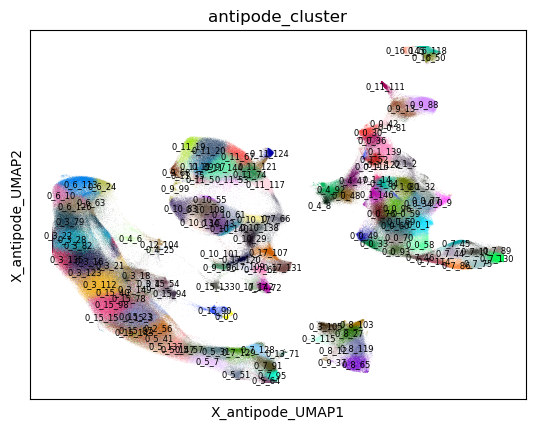

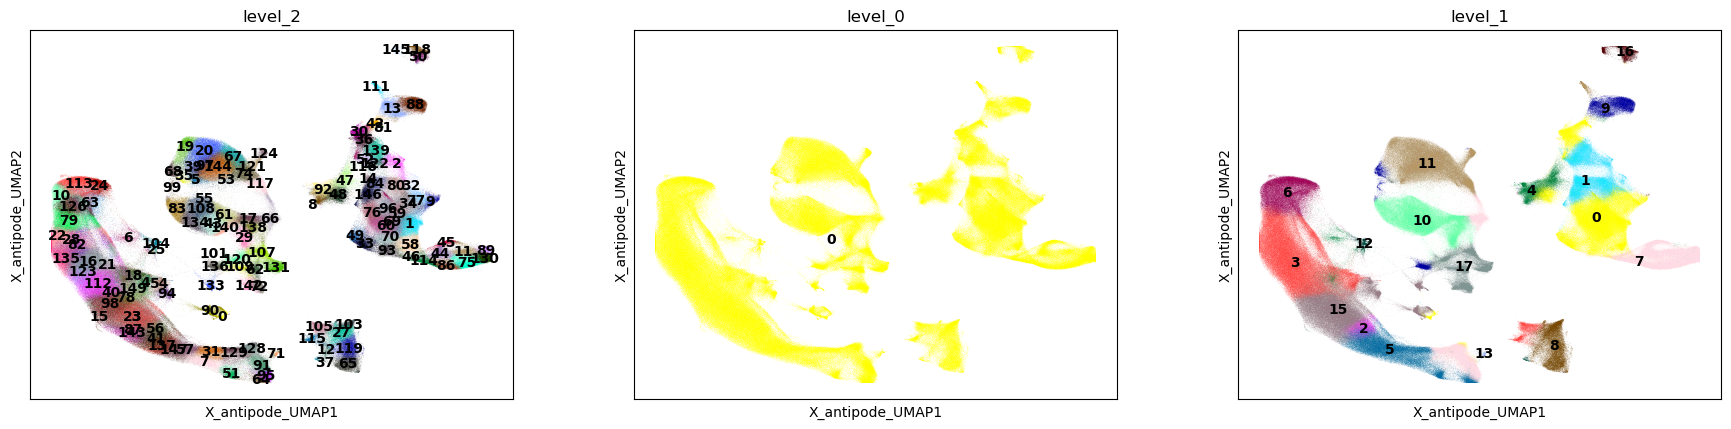

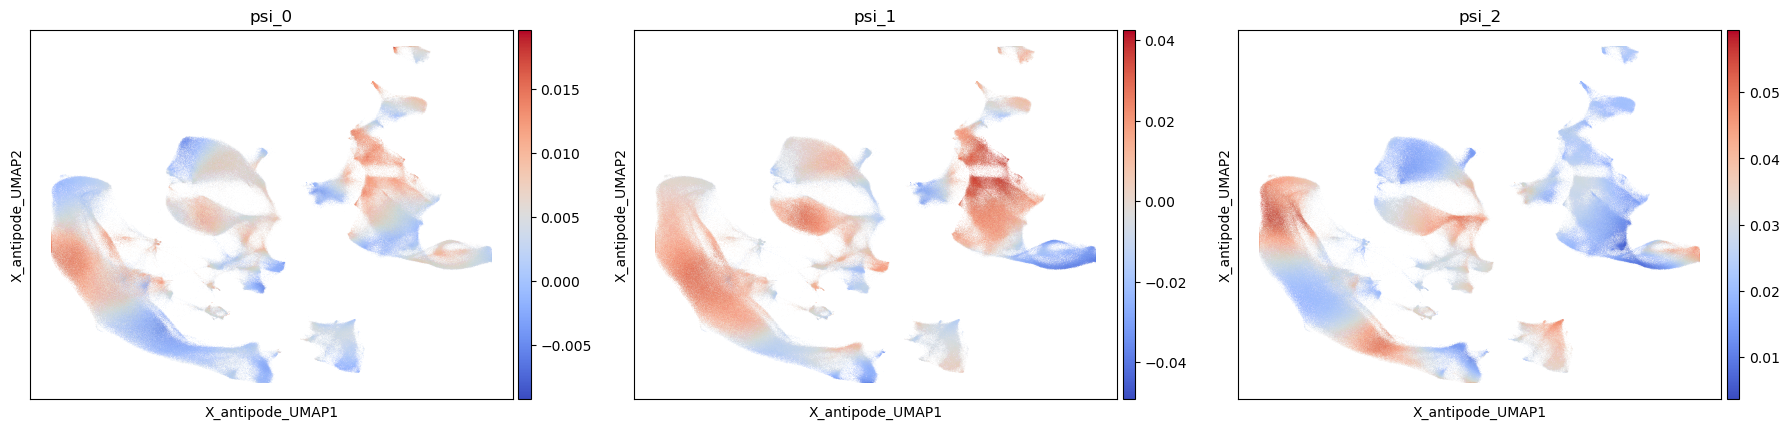

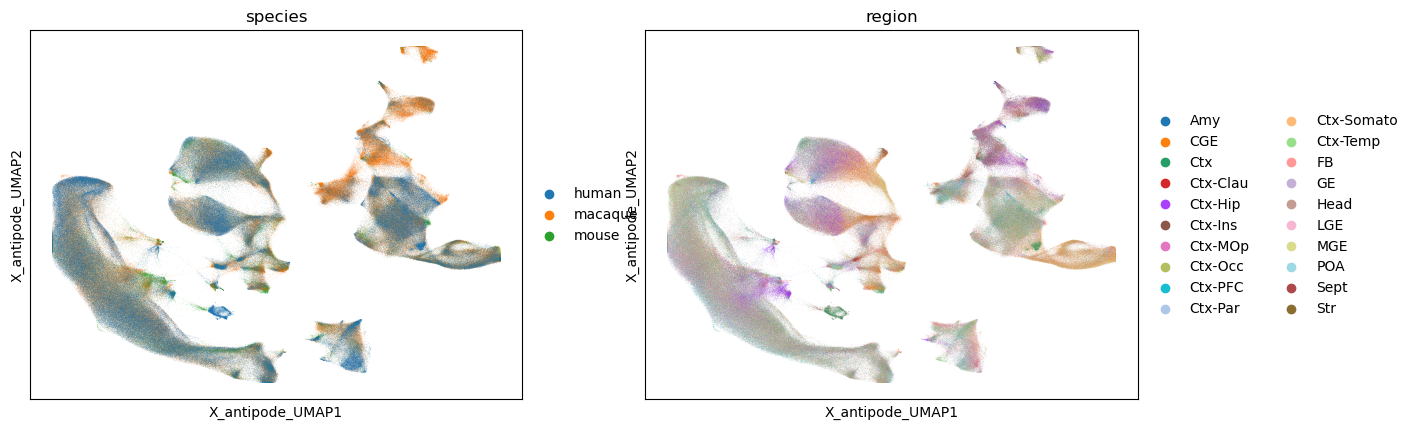

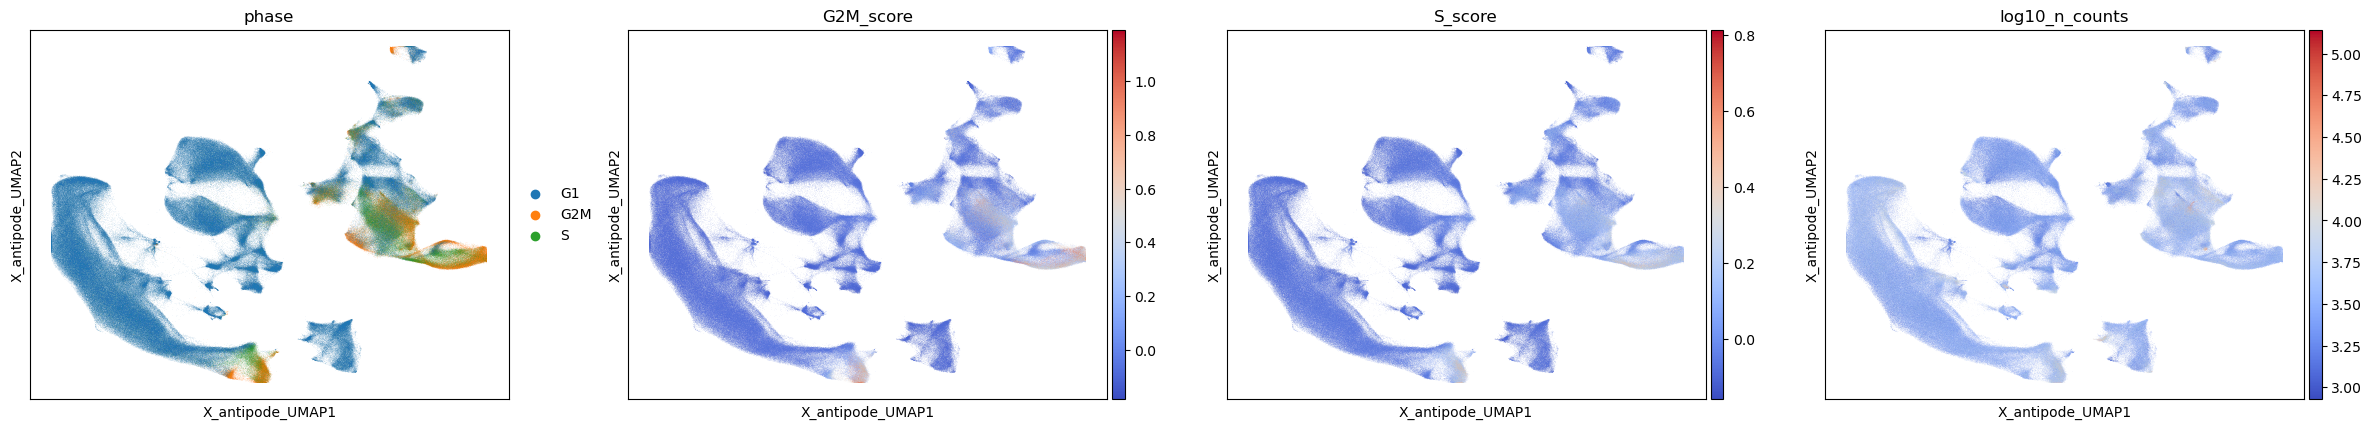

In [17]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'psi' in x],
    cmap='coolwarm',
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['species','region']
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['phase','G2M_score','S_score','log10_n_counts'],cmap='coolwarm'
)


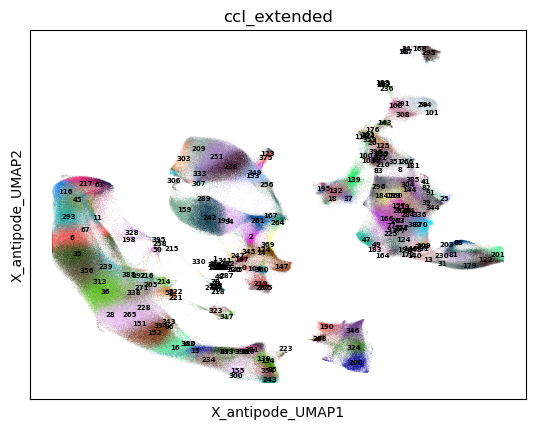

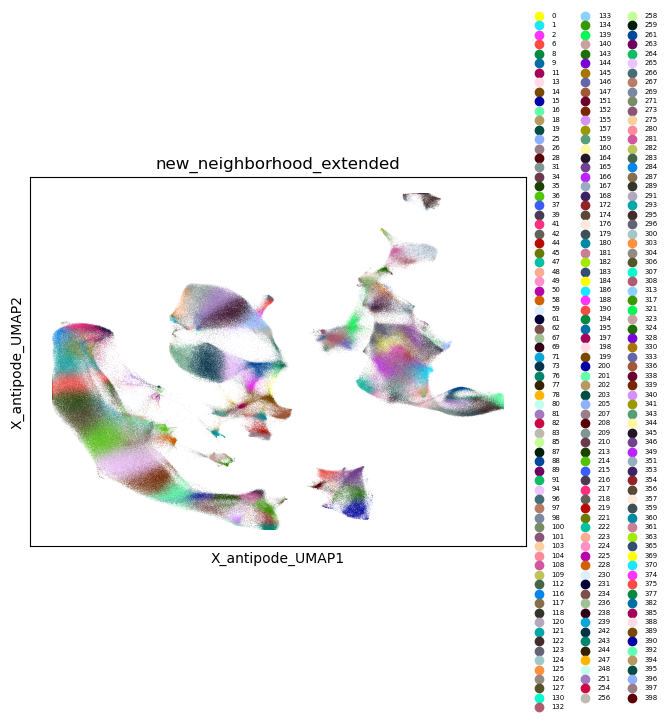

In [18]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102,legend_fontsize=5,
    color=['ccl_extended']
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    palette=sc.pl.palettes.godsnot_102,legend_fontsize=5,
    color=['new_neighborhood_extended']
)

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


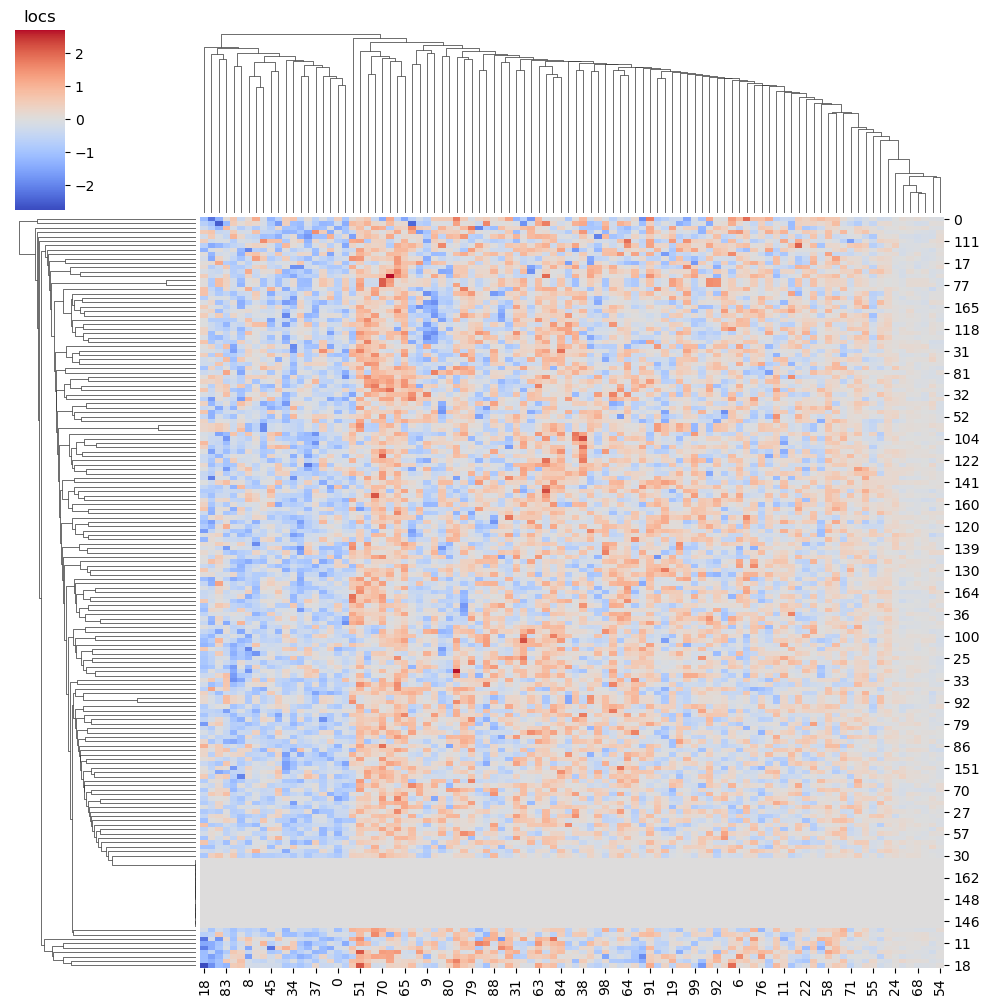

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


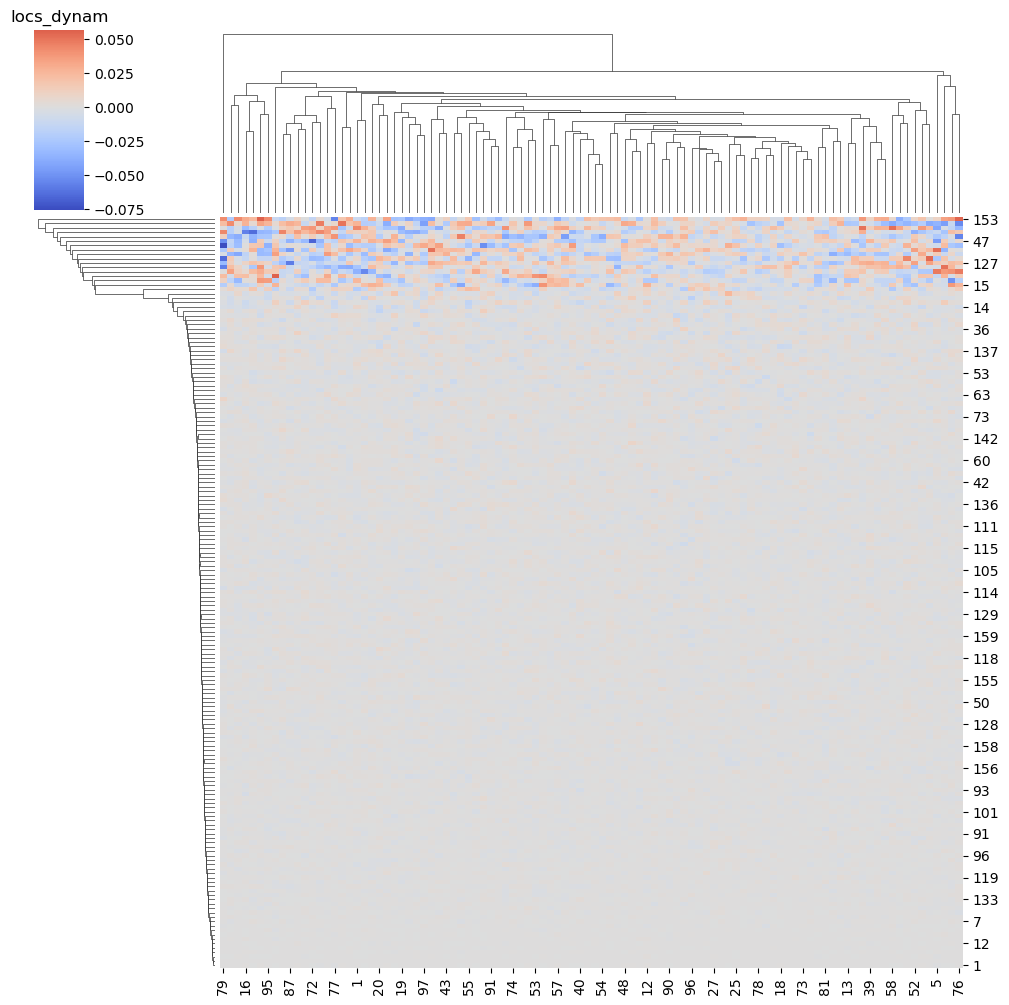

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


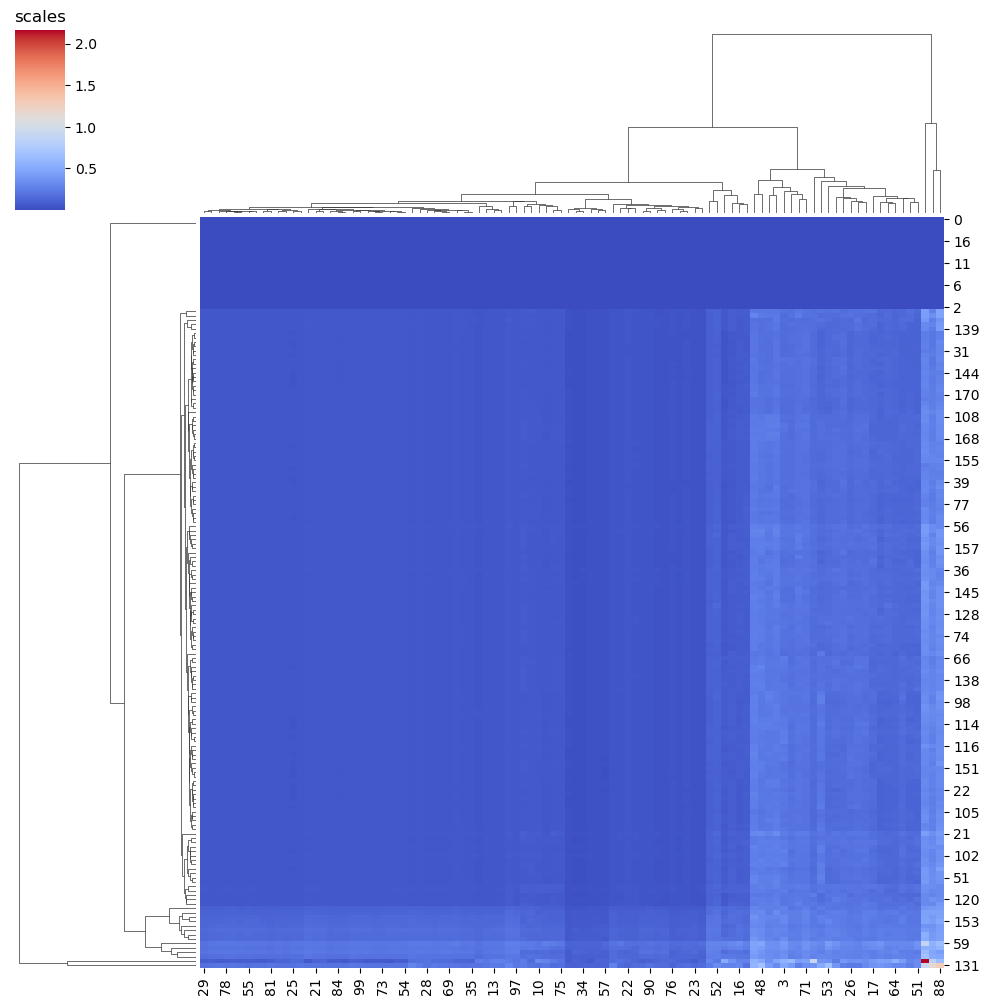

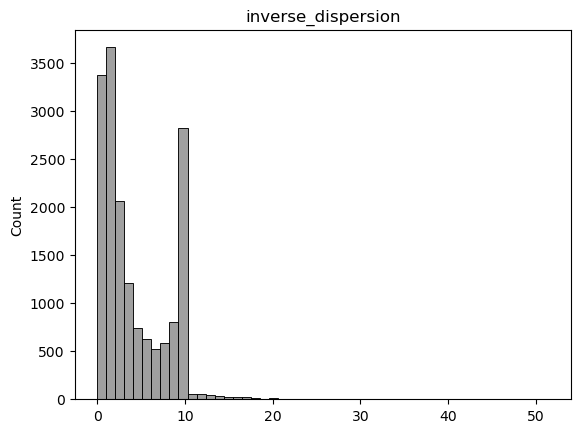

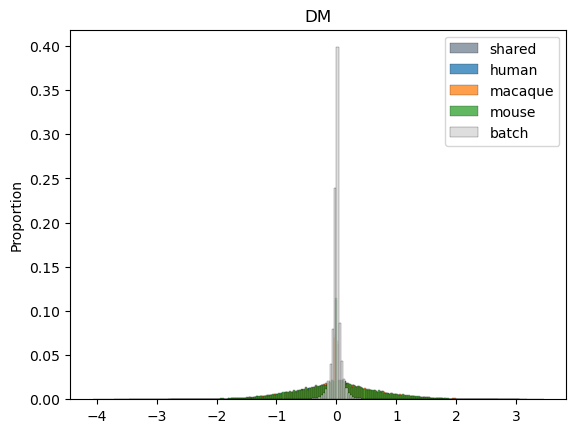

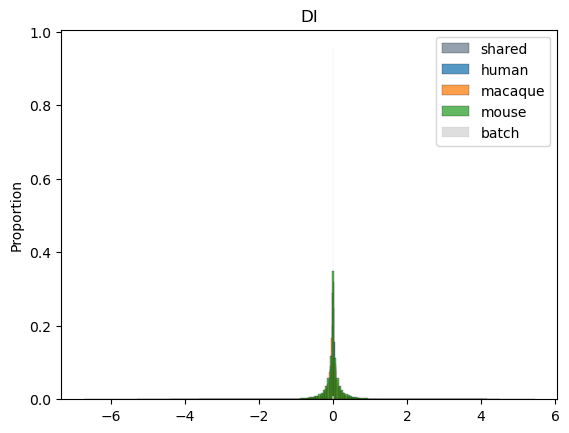

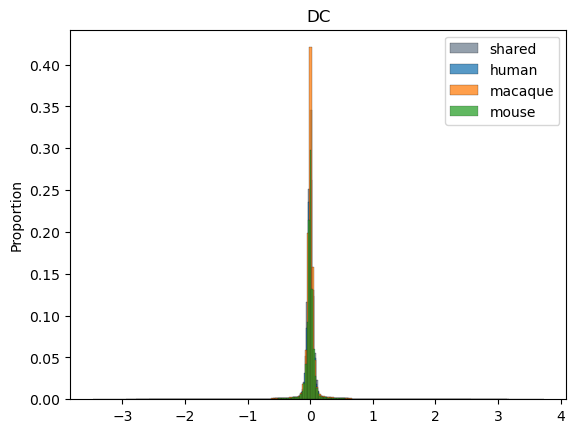

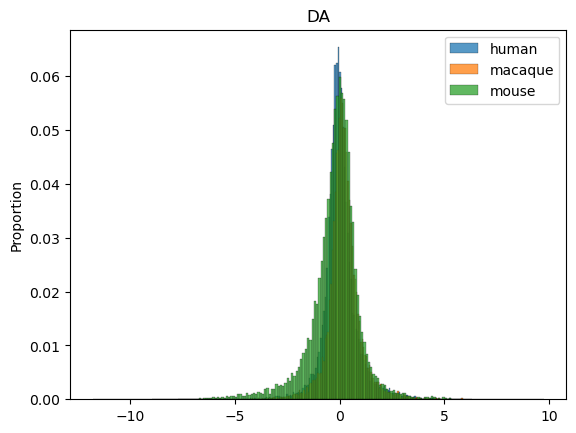

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(antipode_model.batch_key)[color_key]


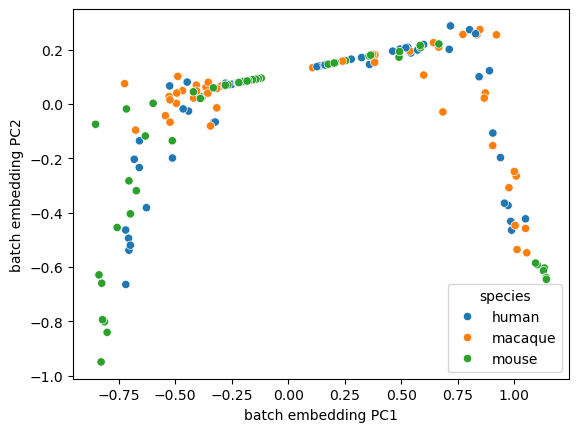

0         1                  batch_name species
0    0.973140 -0.373468       CS12OpticVesicle_kOut   human
1   -0.328317 -0.066312  CS13_olfactory_pacode_kOut   human
2    0.360104  0.146117     CS13_optic_vesicle_kOut   human
3    0.542813  0.188312    CS13_prosencephalon_kOut   human
4   -0.322692 -0.066081            CS14_cortex_kOut   human
..        ...       ...                         ...     ...
244 -0.218025  0.079277                      p0-WT2   mouse
245 -0.175115  0.085901                      p0-WT3   mouse
246 -0.181629  0.084922                      p0-WT4   mouse
247  1.102358 -0.591563      p07_Cortex_SRR11947654   mouse
248  1.094818 -0.585440      p07_Cortex_SRR11947655   mouse

[249 rows x 4 columns]

In [19]:
# plot_loss(antipode_model.losses)
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)
plot_batch_embedding_pca(antipode_model)

In [20]:
pstore=adata.uns['param_store']
discov_cluster_params,cluster_params, cluster_labels,var_labels,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
cluster_index = np.array([int(x) for x in cluster_labels])
discov_cluster_params = discov_cluster_params[:,cluster_index,:]
discov_labels=adata.obs[antipode_model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=antipode_model.level_sizes[-1]

In [21]:
leaf_key = 'level_2'
log_real_means,real_mean_levels=antipode.model_functions.get_real_leaf_means(adata,discov_key,leaf_key,layer=layer_key)
real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=real_mean_levels[leaf_key])
real_means=real_means.loc[real_mean_levels[leaf_key],:]

  0%|          | 0/411 [00:00<?, ?it/s]

  0%|          | 1/411 [00:00<00:46,  8.73it/s]

  0%|          | 2/411 [00:00<02:07,  3.20it/s]

  1%|          | 4/411 [00:01<02:35,  2.62it/s]

  1%|▏         | 6/411 [00:01<01:33,  4.33it/s]

  2%|▏         | 8/411 [00:01<01:17,  5.18it/s]

  2%|▏         | 9/411 [00:01<01:10,  5.71it/s]

  3%|▎         | 11/411 [00:02<01:18,  5.10it/s]

  3%|▎         | 12/411 [00:02<01:10,  5.66it/s]

  3%|▎         | 14/411 [00:02<00:56,  7.05it/s]

  4%|▍         | 17/411 [00:03<01:34,  4.15it/s]

  4%|▍         | 18/411 [00:03<01:26,  4.57it/s]

  5%|▍         | 20/411 [00:04<01:10,  5.58it/s]

  5%|▌         | 21/411 [00:04<01:20,  4.87it/s]

  6%|▌         | 23/411 [00:04<01:01,  6.28it/s]

  6%|▌         | 24/411 [00:04<01:08,  5.67it/s]

  6%|▌         | 25/411 [00:04<01:08,  5.63it/s]

  7%|▋         | 27/411 [00:05<00:57,  6.66it/s]

  7%|▋         | 28/411 [00:05<01:14,  5.15it/s]

  7%|▋         | 29/411 [00:05<01:09,  5.47it/s]

  8%|▊         | 31/411 [00:05<00:58,  6.54it/s]

  8%|▊         | 33/411 [00:06<00:47,  7.93it/s]

  8%|▊         | 34/411 [00:06<00:47,  7.86it/s]

  9%|▉         | 38/411 [00:06<00:28, 12.96it/s]

 10%|▉         | 40/411 [00:06<00:40,  9.24it/s]

 10%|█         | 42/411 [00:07<00:52,  7.06it/s]

 10%|█         | 43/411 [00:07<00:49,  7.37it/s]

 11%|█         | 46/411 [00:07<00:36, 10.11it/s]

 12%|█▏        | 48/411 [00:07<00:35, 10.21it/s]

 12%|█▏        | 51/411 [00:07<00:27, 13.10it/s]

 13%|█▎        | 54/411 [00:07<00:22, 15.74it/s]

 14%|█▎        | 56/411 [00:08<00:33, 10.61it/s]

 14%|█▍        | 58/411 [00:08<00:44,  7.98it/s]

 15%|█▍        | 60/411 [00:09<00:54,  6.40it/s]

 15%|█▌        | 62/411 [00:09<00:46,  7.56it/s]

 16%|█▌        | 64/411 [00:09<00:54,  6.40it/s]

 16%|█▌        | 65/411 [00:09<00:51,  6.77it/s]

 16%|█▌        | 66/411 [00:10<00:56,  6.07it/s]

 17%|█▋        | 68/411 [00:10<00:48,  7.04it/s]

 17%|█▋        | 69/411 [00:10<00:49,  6.92it/s]

 18%|█▊        | 72/411 [00:10<00:37,  9.11it/s]

 18%|█▊        | 73/411 [00:10<00:42,  8.00it/s]

 18%|█▊        | 74/411 [00:10<00:44,  7.59it/s]

 18%|█▊        | 75/411 [00:11<00:53,  6.30it/s]

 18%|█▊        | 76/411 [00:11<00:51,  6.54it/s]

 19%|█▊        | 77/411 [00:11<01:12,  4.62it/s]

 19%|█▉        | 78/411 [00:11<01:15,  4.39it/s]

 19%|█▉        | 80/411 [00:12<01:00,  5.43it/s]

 20%|█▉        | 81/411 [00:12<00:56,  5.81it/s]

 20%|█▉        | 82/411 [00:12<00:55,  5.96it/s]

 20%|██        | 83/411 [00:12<00:52,  6.29it/s]

 21%|██        | 85/411 [00:12<00:41,  7.79it/s]

 21%|██        | 87/411 [00:13<00:40,  7.98it/s]

 21%|██▏       | 88/411 [00:13<00:47,  6.74it/s]

 22%|██▏       | 90/411 [00:13<00:38,  8.29it/s]

 22%|██▏       | 92/411 [00:13<00:35,  8.87it/s]

 23%|██▎       | 93/411 [00:13<00:42,  7.46it/s]

 23%|██▎       | 94/411 [00:14<00:43,  7.26it/s]

 23%|██▎       | 95/411 [00:14<01:12,  4.37it/s]

 24%|██▍       | 98/411 [00:14<00:42,  7.36it/s]

 24%|██▍       | 100/411 [00:14<00:34,  9.06it/s]

 25%|██▍       | 102/411 [00:15<00:42,  7.20it/s]

 26%|██▌       | 105/411 [00:15<00:49,  6.17it/s]

 26%|██▌       | 106/411 [00:16<01:09,  4.42it/s]

 26%|██▌       | 107/411 [00:16<01:02,  4.87it/s]

 27%|██▋       | 109/411 [00:16<00:46,  6.56it/s]

 27%|██▋       | 111/411 [00:16<00:37,  8.06it/s]

 27%|██▋       | 113/411 [00:17<00:40,  7.39it/s]

 28%|██▊       | 116/411 [00:17<00:33,  8.73it/s]

 29%|██▊       | 118/411 [00:17<00:34,  8.52it/s]

 29%|██▉       | 119/411 [00:17<00:34,  8.54it/s]

 29%|██▉       | 120/411 [00:17<00:34,  8.55it/s]

 29%|██▉       | 121/411 [00:17<00:35,  8.27it/s]

 30%|██▉       | 123/411 [00:17<00:27, 10.40it/s]

 30%|███       | 125/411 [00:18<00:36,  7.76it/s]

 31%|███       | 126/411 [00:18<00:35,  8.06it/s]

 31%|███       | 127/411 [00:18<00:35,  7.97it/s]

 31%|███▏      | 129/411 [00:18<00:28,  9.80it/s]

 32%|███▏      | 131/411 [00:18<00:25, 10.79it/s]

 32%|███▏      | 133/411 [00:19<00:44,  6.18it/s]

 33%|███▎      | 135/411 [00:19<00:38,  7.26it/s]

 33%|███▎      | 136/411 [00:19<00:42,  6.51it/s]

 34%|███▍      | 139/411 [00:20<00:37,  7.22it/s]

 34%|███▍      | 140/411 [00:20<00:39,  6.89it/s]

 34%|███▍      | 141/411 [00:20<00:50,  5.32it/s]

 35%|███▌      | 144/411 [00:20<00:33,  7.99it/s]

 36%|███▌      | 146/411 [00:21<00:39,  6.67it/s]

 36%|███▌      | 147/411 [00:21<00:37,  7.09it/s]

 36%|███▌      | 148/411 [00:21<00:35,  7.35it/s]

 36%|███▋      | 149/411 [00:21<00:35,  7.37it/s]

 37%|███▋      | 151/411 [00:22<00:38,  6.82it/s]

 37%|███▋      | 154/411 [00:22<00:39,  6.50it/s]

 38%|███▊      | 155/411 [00:22<00:38,  6.68it/s]

 38%|███▊      | 156/411 [00:22<00:37,  6.86it/s]

 38%|███▊      | 158/411 [00:23<00:40,  6.18it/s]

 39%|███▉      | 160/411 [00:23<00:33,  7.45it/s]

 39%|███▉      | 161/411 [00:23<00:40,  6.20it/s]

 39%|███▉      | 162/411 [00:23<00:38,  6.50it/s]

 40%|███▉      | 164/411 [00:23<00:33,  7.32it/s]

 40%|████      | 165/411 [00:24<00:42,  5.84it/s]

 40%|████      | 166/411 [00:24<00:40,  6.02it/s]

 41%|████      | 167/411 [00:24<00:42,  5.68it/s]

 41%|████      | 169/411 [00:24<00:33,  7.24it/s]

 41%|████▏     | 170/411 [00:24<00:34,  7.07it/s]

 42%|████▏     | 172/411 [00:25<00:26,  9.15it/s]

 42%|████▏     | 174/411 [00:25<00:24,  9.56it/s]

 43%|████▎     | 176/411 [00:25<00:23,  9.99it/s]

 43%|████▎     | 178/411 [00:25<00:28,  8.24it/s]

 44%|████▎     | 179/411 [00:25<00:32,  7.05it/s]

 44%|████▍     | 180/411 [00:26<00:32,  7.01it/s]

 44%|████▍     | 182/411 [00:26<00:25,  8.82it/s]

 45%|████▍     | 183/411 [00:26<00:34,  6.64it/s]

 45%|████▍     | 184/411 [00:26<00:41,  5.45it/s]

 45%|████▌     | 186/411 [00:27<00:33,  6.77it/s]

 46%|████▌     | 188/411 [00:27<00:31,  7.11it/s]

 47%|████▋     | 192/411 [00:27<00:22,  9.63it/s]

 47%|████▋     | 193/411 [00:27<00:23,  9.43it/s]

 47%|████▋     | 194/411 [00:27<00:26,  8.30it/s]

 47%|████▋     | 195/411 [00:27<00:27,  7.83it/s]

 48%|████▊     | 196/411 [00:28<00:35,  6.03it/s]

 48%|████▊     | 198/411 [00:28<00:30,  6.94it/s]

 48%|████▊     | 199/411 [00:28<00:28,  7.34it/s]

 49%|████▉     | 201/411 [00:28<00:24,  8.62it/s]

 49%|████▉     | 202/411 [00:28<00:25,  8.11it/s]

 49%|████▉     | 203/411 [00:29<00:26,  7.74it/s]

 50%|████▉     | 205/411 [00:29<00:22,  9.03it/s]

 50%|█████     | 206/411 [00:29<00:25,  7.93it/s]

 51%|█████     | 209/411 [00:29<00:21,  9.58it/s]

 51%|█████     | 210/411 [00:29<00:25,  7.81it/s]

 51%|█████▏    | 211/411 [00:30<00:30,  6.57it/s]

 52%|█████▏    | 212/411 [00:30<00:28,  6.88it/s]

 52%|█████▏    | 213/411 [00:30<00:26,  7.44it/s]

 52%|█████▏    | 214/411 [00:30<00:36,  5.45it/s]

 52%|█████▏    | 215/411 [00:30<00:36,  5.35it/s]

 53%|█████▎    | 217/411 [00:31<00:32,  6.04it/s]

 53%|█████▎    | 218/411 [00:31<00:31,  6.08it/s]

 53%|█████▎    | 219/411 [00:31<00:32,  5.83it/s]

 54%|█████▎    | 220/411 [00:31<00:30,  6.18it/s]

 54%|█████▍    | 222/411 [00:32<00:39,  4.82it/s]

 55%|█████▍    | 225/411 [00:32<00:28,  6.62it/s]

 55%|█████▍    | 226/411 [00:32<00:36,  5.11it/s]

 55%|█████▌    | 227/411 [00:32<00:32,  5.59it/s]

 56%|█████▌    | 229/411 [00:33<00:25,  7.01it/s]

 56%|█████▌    | 230/411 [00:33<00:29,  6.07it/s]

 56%|█████▌    | 231/411 [00:33<00:28,  6.28it/s]

 56%|█████▋    | 232/411 [00:33<00:39,  4.48it/s]

 57%|█████▋    | 236/411 [00:34<00:19,  8.81it/s]

 58%|█████▊    | 238/411 [00:34<00:21,  7.99it/s]

 58%|█████▊    | 240/411 [00:34<00:22,  7.73it/s]

 59%|█████▉    | 242/411 [00:35<00:32,  5.20it/s]

 59%|█████▉    | 243/411 [00:35<00:34,  4.94it/s]

 59%|█████▉    | 244/411 [00:35<00:31,  5.25it/s]

 60%|██████    | 247/411 [00:36<00:23,  6.99it/s]

 60%|██████    | 248/411 [00:36<00:23,  6.85it/s]

 61%|██████    | 249/411 [00:36<00:24,  6.59it/s]

 61%|██████    | 250/411 [00:36<00:23,  6.89it/s]

 61%|██████▏   | 252/411 [00:36<00:19,  8.17it/s]

 62%|██████▏   | 253/411 [00:36<00:21,  7.37it/s]

 62%|██████▏   | 254/411 [00:36<00:21,  7.47it/s]

 62%|██████▏   | 255/411 [00:37<00:25,  6.04it/s]

 62%|██████▏   | 256/411 [00:37<00:24,  6.44it/s]

 63%|██████▎   | 258/411 [00:37<00:23,  6.56it/s]

 63%|██████▎   | 259/411 [00:37<00:23,  6.59it/s]

 64%|██████▎   | 261/411 [00:37<00:19,  7.52it/s]

 64%|██████▎   | 262/411 [00:38<00:22,  6.57it/s]

 64%|██████▍   | 264/411 [00:38<00:18,  7.95it/s]

 65%|██████▍   | 266/411 [00:38<00:22,  6.58it/s]

 65%|██████▌   | 268/411 [00:38<00:17,  8.17it/s]

 66%|██████▌   | 270/411 [00:39<00:20,  7.02it/s]

 66%|██████▌   | 272/411 [00:39<00:18,  7.46it/s]

 66%|██████▋   | 273/411 [00:39<00:19,  7.19it/s]

 67%|██████▋   | 276/411 [00:39<00:14,  9.39it/s]

 68%|██████▊   | 278/411 [00:39<00:12, 10.71it/s]

 68%|██████▊   | 280/411 [00:40<00:11, 11.86it/s]

 69%|██████▉   | 283/411 [00:40<00:08, 15.46it/s]

 70%|███████   | 288/411 [00:40<00:05, 22.59it/s]

 71%|███████   | 291/411 [00:40<00:05, 21.34it/s]

 72%|███████▏  | 294/411 [00:40<00:06, 17.17it/s]

 72%|███████▏  | 297/411 [00:40<00:07, 15.06it/s]

 73%|███████▎  | 300/411 [00:41<00:06, 17.44it/s]

 74%|███████▎  | 303/411 [00:41<00:06, 16.92it/s]

 74%|███████▍  | 305/411 [00:41<00:06, 16.96it/s]

 76%|███████▌  | 311/411 [00:41<00:03, 25.87it/s]

 77%|███████▋  | 315/411 [00:41<00:04, 23.78it/s]

 77%|███████▋  | 318/411 [00:41<00:03, 23.56it/s]

 78%|███████▊  | 322/411 [00:41<00:03, 26.19it/s]

 79%|███████▉  | 326/411 [00:42<00:02, 28.97it/s]

 80%|████████  | 330/411 [00:42<00:03, 23.83it/s]

 81%|████████  | 333/411 [00:42<00:03, 24.05it/s]

 82%|████████▏ | 336/411 [00:42<00:03, 22.58it/s]

 82%|████████▏ | 339/411 [00:42<00:03, 22.69it/s]

 83%|████████▎ | 342/411 [00:42<00:03, 22.42it/s]

 84%|████████▍ | 345/411 [00:43<00:03, 20.56it/s]

 85%|████████▍ | 348/411 [00:43<00:03, 18.78it/s]

 85%|████████▌ | 351/411 [00:43<00:03, 19.28it/s]

 86%|████████▌ | 354/411 [00:43<00:02, 21.17it/s]

 87%|████████▋ | 357/411 [00:43<00:02, 22.02it/s]

 88%|████████▊ | 360/411 [00:43<00:02, 22.31it/s]

 88%|████████▊ | 363/411 [00:43<00:02, 23.15it/s]

 89%|████████▉ | 366/411 [00:43<00:01, 22.62it/s]

 90%|████████▉ | 369/411 [00:44<00:02, 19.13it/s]

 91%|█████████ | 374/411 [00:44<00:01, 22.20it/s]

 92%|█████████▏| 377/411 [00:44<00:01, 18.99it/s]

 92%|█████████▏| 380/411 [00:44<00:01, 17.40it/s]

 93%|█████████▎| 382/411 [00:44<00:01, 17.28it/s]

 94%|█████████▍| 386/411 [00:45<00:01, 20.59it/s]

 95%|█████████▍| 389/411 [00:45<00:00, 22.52it/s]

 95%|█████████▌| 392/411 [00:45<00:00, 23.96it/s]

 96%|█████████▌| 395/411 [00:45<00:00, 19.53it/s]

 97%|█████████▋| 398/411 [00:45<00:00, 16.66it/s]

 97%|█████████▋| 400/411 [00:45<00:00, 16.33it/s]

 98%|█████████▊| 402/411 [00:45<00:00, 16.29it/s]

 99%|█████████▉| 406/411 [00:46<00:00, 20.50it/s]

100%|█████████▉| 409/411 [00:46<00:00, 20.10it/s]

100%|██████████| 411/411 [00:46<00:00,  8.86it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  1%|▏         | 2/137 [00:00<00:32,  4.19it/s]

  2%|▏         | 3/137 [00:00<00:26,  5.12it/s]

  3%|▎         | 4/137 [00:01<00:44,  2.96it/s]

  4%|▎         | 5/137 [00:01<00:34,  3.86it/s]

  5%|▌         | 7/137 [00:01<00:21,  6.10it/s]

  6%|▌         | 8/137 [00:01<00:23,  5.61it/s]

  7%|▋         | 9/137 [00:01<00:24,  5.27it/s]

  7%|▋         | 10/137 [00:01<00:20,  6.08it/s]

  8%|▊         | 11/137 [00:02<00:22,  5.50it/s]

  9%|▉         | 12/137 [00:02<00:21,  5.79it/s]

 10%|█         | 14/137 [00:02<00:19,  6.28it/s]

 12%|█▏        | 17/137 [00:03<00:23,  5.13it/s]

 13%|█▎        | 18/137 [00:03<00:22,  5.23it/s]

 14%|█▍        | 19/137 [00:03<00:22,  5.19it/s]

 15%|█▍        | 20/137 [00:03<00:21,  5.34it/s]

 15%|█▌        | 21/137 [00:04<00:29,  3.89it/s]

 16%|█▌        | 22/137 [00:04<00:25,  4.57it/s]

 17%|█▋        | 23/137 [00:04<00:22,  5.09it/s]

 18%|█▊        | 24/137 [00:04<00:27,  4.13it/s]

 18%|█▊        | 25/137 [00:05<00:25,  4.31it/s]

 20%|█▉        | 27/137 [00:05<00:21,  5.19it/s]

 20%|██        | 28/137 [00:05<00:27,  3.95it/s]

 21%|██        | 29/137 [00:06<00:26,  4.14it/s]

 22%|██▏       | 30/137 [00:06<00:23,  4.46it/s]

 23%|██▎       | 31/137 [00:06<00:23,  4.58it/s]

 24%|██▍       | 33/137 [00:06<00:18,  5.49it/s]

 25%|██▍       | 34/137 [00:06<00:17,  5.80it/s]

 26%|██▋       | 36/137 [00:07<00:14,  7.05it/s]

 28%|██▊       | 39/137 [00:07<00:11,  8.87it/s]

 29%|██▉       | 40/137 [00:07<00:15,  6.27it/s]

 31%|███       | 42/137 [00:08<00:18,  5.20it/s]

 31%|███▏      | 43/137 [00:08<00:17,  5.25it/s]

 33%|███▎      | 45/137 [00:08<00:13,  6.64it/s]

 34%|███▎      | 46/137 [00:08<00:15,  6.06it/s]

 34%|███▍      | 47/137 [00:09<00:16,  5.32it/s]

 35%|███▌      | 48/137 [00:09<00:15,  5.86it/s]

 36%|███▋      | 50/137 [00:09<00:12,  7.02it/s]

 37%|███▋      | 51/137 [00:09<00:12,  6.99it/s]

 39%|███▊      | 53/137 [00:09<00:10,  8.37it/s]

 40%|████      | 55/137 [00:09<00:10,  7.72it/s]

 41%|████      | 56/137 [00:10<00:12,  6.60it/s]

 42%|████▏     | 57/137 [00:10<00:14,  5.43it/s]

 42%|████▏     | 58/137 [00:10<00:15,  5.17it/s]

 43%|████▎     | 59/137 [00:11<00:19,  4.06it/s]

 44%|████▍     | 60/137 [00:11<00:17,  4.38it/s]

 45%|████▍     | 61/137 [00:11<00:15,  4.79it/s]

 45%|████▌     | 62/137 [00:11<00:14,  5.29it/s]

 46%|████▌     | 63/137 [00:11<00:13,  5.58it/s]

 47%|████▋     | 64/137 [00:11<00:14,  4.98it/s]

 47%|████▋     | 65/137 [00:12<00:14,  5.05it/s]

 48%|████▊     | 66/137 [00:12<00:15,  4.58it/s]

 50%|████▉     | 68/137 [00:12<00:12,  5.56it/s]

 50%|█████     | 69/137 [00:12<00:13,  5.20it/s]

 52%|█████▏    | 71/137 [00:13<00:09,  6.81it/s]

 53%|█████▎    | 72/137 [00:13<00:10,  6.09it/s]

 53%|█████▎    | 73/137 [00:13<00:12,  5.10it/s]

 54%|█████▍    | 74/137 [00:13<00:13,  4.52it/s]

 55%|█████▍    | 75/137 [00:14<00:14,  4.34it/s]

 55%|█████▌    | 76/137 [00:14<00:13,  4.67it/s]

 56%|█████▌    | 77/137 [00:14<00:17,  3.45it/s]

 57%|█████▋    | 78/137 [00:15<00:17,  3.41it/s]

 58%|█████▊    | 80/137 [00:15<00:13,  4.10it/s]

 59%|█████▉    | 81/137 [00:15<00:13,  4.27it/s]

 60%|█████▉    | 82/137 [00:15<00:12,  4.29it/s]

 61%|██████    | 83/137 [00:16<00:12,  4.48it/s]

 61%|██████▏   | 84/137 [00:16<00:10,  5.05it/s]

 62%|██████▏   | 85/137 [00:16<00:12,  4.13it/s]

 64%|██████▎   | 87/137 [00:16<00:09,  5.33it/s]

 64%|██████▍   | 88/137 [00:17<00:10,  4.62it/s]

 65%|██████▍   | 89/137 [00:17<00:11,  4.24it/s]

 66%|██████▌   | 90/137 [00:17<00:09,  4.72it/s]

 66%|██████▋   | 91/137 [00:17<00:08,  5.30it/s]

 67%|██████▋   | 92/137 [00:17<00:08,  5.56it/s]

 68%|██████▊   | 93/137 [00:18<00:09,  4.50it/s]

 69%|██████▊   | 94/137 [00:18<00:09,  4.62it/s]

 69%|██████▉   | 95/137 [00:19<00:14,  2.93it/s]

 72%|███████▏  | 98/137 [00:19<00:07,  5.49it/s]

 73%|███████▎  | 100/137 [00:19<00:06,  5.97it/s]

 74%|███████▎  | 101/137 [00:19<00:06,  5.67it/s]

 74%|███████▍  | 102/137 [00:20<00:07,  4.74it/s]

 75%|███████▌  | 103/137 [00:20<00:06,  5.23it/s]

 77%|███████▋  | 105/137 [00:21<00:09,  3.45it/s]

 77%|███████▋  | 106/137 [00:21<00:10,  2.92it/s]

 78%|███████▊  | 107/137 [00:21<00:09,  3.24it/s]

 80%|███████▉  | 109/137 [00:21<00:05,  4.67it/s]

 80%|████████  | 110/137 [00:22<00:05,  4.70it/s]

 81%|████████  | 111/137 [00:22<00:04,  5.34it/s]

 82%|████████▏ | 112/137 [00:22<00:05,  4.76it/s]

 82%|████████▏ | 113/137 [00:22<00:04,  5.04it/s]

 84%|████████▍ | 115/137 [00:22<00:03,  6.73it/s]

 85%|████████▍ | 116/137 [00:23<00:03,  5.68it/s]

 85%|████████▌ | 117/137 [00:23<00:03,  6.29it/s]

 86%|████████▌ | 118/137 [00:23<00:03,  4.91it/s]

 87%|████████▋ | 119/137 [00:23<00:03,  4.92it/s]

 88%|████████▊ | 120/137 [00:23<00:03,  5.03it/s]

 88%|████████▊ | 121/137 [00:24<00:03,  4.78it/s]

 89%|████████▉ | 122/137 [00:24<00:03,  4.86it/s]

 90%|████████▉ | 123/137 [00:24<00:02,  5.71it/s]

 91%|█████████ | 124/137 [00:24<00:02,  5.22it/s]

 91%|█████████ | 125/137 [00:25<00:02,  4.31it/s]

 92%|█████████▏| 126/137 [00:25<00:02,  5.01it/s]

 93%|█████████▎| 127/137 [00:25<00:01,  5.13it/s]

 93%|█████████▎| 128/137 [00:25<00:01,  5.72it/s]

 94%|█████████▍| 129/137 [00:25<00:01,  5.15it/s]

 95%|█████████▍| 130/137 [00:25<00:01,  5.96it/s]

 96%|█████████▋| 132/137 [00:26<00:00,  6.68it/s]

 97%|█████████▋| 133/137 [00:26<00:00,  4.16it/s]

 99%|█████████▊| 135/137 [00:26<00:00,  5.02it/s]

 99%|█████████▉| 136/137 [00:27<00:00,  4.65it/s]

100%|██████████| 137/137 [00:27<00:00,  5.28it/s]

100%|██████████| 137/137 [00:27<00:00,  5.03it/s]

In [22]:
fits=[]
for i in range(discov_cluster_params.shape[0]):
    for g in range(discov_cluster_params.shape[2]):
        x=discov_cluster_params[i,:,g]
        y=log_real_means[i,:,g]
        fits.append(scipy.stats.stats.spearmanr(x,y).statistic)


/scratch/fast/45117/ipykernel_3588157/2048301033.py:6: DeprecationWarning: Please import `spearmanr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  fits.append(scipy.stats.stats.spearmanr(x,y).statistic)


0.8578596793879085


Text(0.5, 1.0, '')

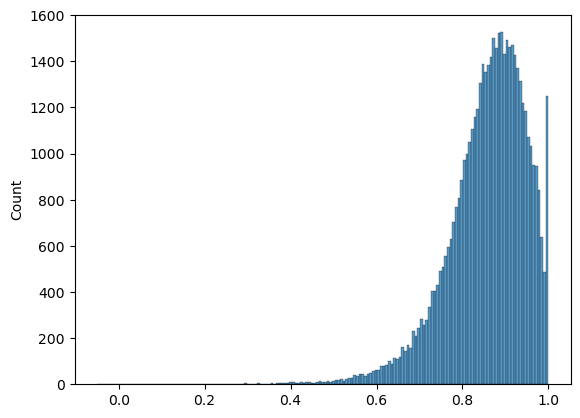

In [23]:
print(np.mean(np.nan_to_num(fits)))
seaborn.histplot(fits)
plt.title('')

Text(0, 0.5, 'actual gene log mean')

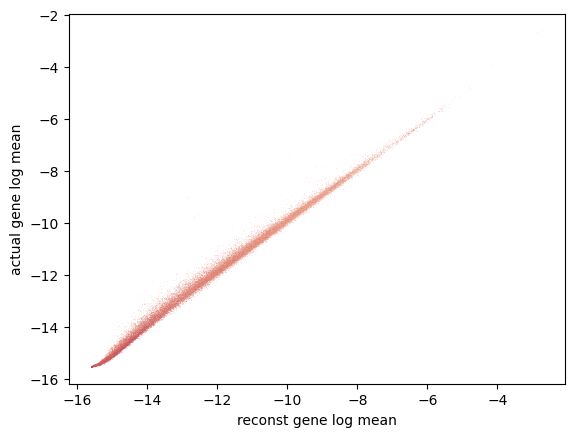

In [24]:
cmap = plt.cm.coolwarm

# Map 'fits' values to the colormap
colors = cmap(np.array(fits))
seaborn.scatterplot(x=discov_cluster_params.mean(1).flatten(),y=log_real_means.mean(1).flatten(),s=0.1,color=colors)
plt.xlabel('reconst gene log mean')
plt.ylabel('actual gene log mean')

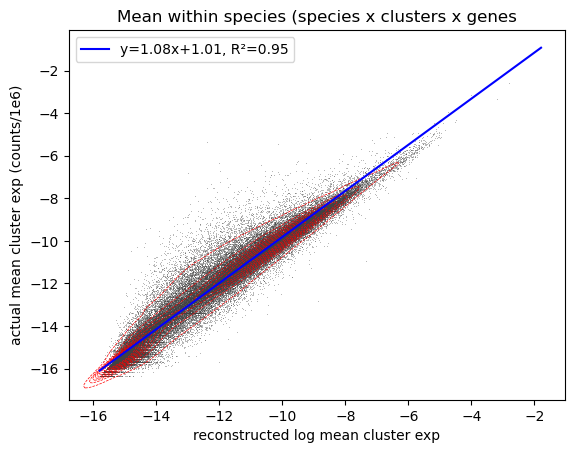

In [25]:
# Calculate the regression parameters
x=(discov_cluster_params).flatten()
x=safe_log_transform(np.exp(x))
y=log_real_means.flatten()
# zeros=y>-20
# x=x[zeros]
# y=y[zeros]
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

In [26]:
antipode_model.save(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),save_anndata=True,prefix='p4_')

TypeError: Can't implicitly convert non-string objects to strings